# Dissertation II - Code

<hr style="border:1px solid black"> </hr>

## Import Libraries

In [3]:
## Data managing
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from ydata_synthetic.synthesizers.regular import WGAN_GP 

## Data visualisations
import seaborn as sns
import matplotlib.pyplot as plt


## Modelling 

# sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# xgboost
from xgboost.sklearn import XGBClassifier

# keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


## Scoring
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score 

In [4]:
# Dataframe Printing Settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

<hr style="border:1px solid black"> </hr>

## Helper Functions

In [5]:
#Adapted from: https://www.kaggle.com/kucherevskiy/rul-prediction
def prepare_data(data):
    df = data.copy()
    tempMax = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    tempMax = pd.DataFrame(tempMax)
    tempMax.columns = ['unit_number','max']
    df = df.merge(tempMax, on=['unit_number'], how='left')
    df['label'] = np.where(df['max'] - df['time_in_cycles'] <= 15, 1, 0 )
    df.drop(columns=['max'],inplace = True)
    
    return df

In [6]:
# Source:
# Function to retrieve outliers
def find_outliers(dataset):
    
    outliers = {}
    
    for i in list(dataset.loc[:, dataset.dtypes != np.object]):
        Q1 = dataset[i].quantile(0.25)
        Q3 = dataset[i].quantile(0.75)
        IQR = Q3 - Q1
        num_outliers = ((dataset[i] < (Q1 - 1.5 * IQR)) | (dataset[i] > (Q3 + 1.5 * IQR)))
        outliers[i] = num_outliers
        
    return outliers

In [7]:
# Source:
# Testing for outliers
def plot_box(dataset, cols=3, width=20, height=20, hspace=0.7, wspace=0.5):
    
    outliers = find_outliers(dataset)
    
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(outliers.keys()):
        ax = fig.add_subplot(rows, cols, i + 1)
        g = sns.boxplot(dataset[column])
        ax.set_title('Box plot of {}. Outliers: {}'.format(column, outliers[column].sum()))

In [8]:
#Plot distributions of each feature (Adapted from: Daniel Martinez)
def plot_distribution(dataset, cols=4, width=20, height=15, hspace=0.7, wspace=0.7):
    
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        g = sns.distplot(dataset[column])
        plt.xticks(rotation=25)

<hr style="border:1px solid black"> </hr>

## Importing Data and Initial Cleaning

In [9]:
# Column Names
columns = ['unit_number','time_in_cycles','Altitude','Mach','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

In [10]:
# Train
df1 = pd.read_csv('/Users/nicolasrosal/Desktop/Dissertation2/CMAPSSData/train_FD003.txt',
                  sep=" ",
                  header=None)

# Test
df2 = pd.read_csv('/Users/nicolasrosal/Desktop/Dissertation2/CMAPSSData/test_FD003.txt',
                  sep=" ",
                  header=None)

- Dataframe1:

In [11]:
# Dropping empty columns
df1.drop(columns=[26,27], inplace=True)

In [12]:
#Renaming Columns
df1.columns = columns

In [13]:
# Adding RUL column
df1 = prepare_data(df1)

- Dataframe2:

In [14]:
# Dropping empty columns
df2.drop(columns=[26,27], inplace=True)

In [15]:
#Renaming Columns
df2.columns = columns

In [16]:
# Adding RUL column
df2 = prepare_data(df2)

### Combining df1 and df2

###### Creating a dataframe for Exploratory Data Analysis and Modelling

In [17]:
TTF_data = pd.concat([df1, df2])

<hr style="border:1px solid black"> </hr>

## Exploratory Data Analysis

- Missing Values:

In [18]:
print('Number of missing values:', TTF_data.isna().sum().sum())

Number of missing values: 0


- Descriptive Statistics:

In [19]:
TTF_data.describe()

unit_number  time_in_cycles      Altitude          Mach      TRA  \
count  41316.000000    41316.000000  41316.000000  41316.000000  41316.0   
mean      49.939563      125.790323     -0.000021      0.000001    100.0   
std       29.595390       94.313702      0.002197      0.000294      0.0   
min        1.000000        1.000000     -0.008700     -0.000600    100.0   
25%       24.000000       52.000000     -0.001500     -0.000300    100.0   
50%       49.000000      108.000000      0.000000      0.000000    100.0   
75%       76.000000      176.000000      0.001500      0.000300    100.0   
max      100.000000      525.000000      0.008600      0.000700    100.0   

                 T2           T24           T30           T50            P2  \
count  4.131600e+04  41316.000000  41316.000000  41316.000000  4.131600e+04   
mean   5.186700e+02    642.381587   1587.086657   1402.903329  1.462000e+01   
std    3.344707e-10      0.492753      6.445107      9.019166  4.025273e-12   
min    5.186700e+02    640.840000   1564.300000   1377.060000  1.462000e+01   
25%    5.186700e+02    642.030000   1582.580000   1396.360000  1.462000e+01   
50%    5.186700e+02    642.330000   1586.610000   1401.475000  1.462000e+01   
75%    5.186700e+02    642.690000   1591.060000   1408.190000  1.462000e+01   
max    5.186700e+02    645.110000   1615.390000   1441.160000  1.462000e+01   

                P15           P30            Nf            Nc           epr  \
count  41316.000000  41316.000000  41316.000000  41316.000000  41316.000000   
mean      21.595188    554.907380   2388.051375   9060.963080      1.300920   
std        0.017502      3.026714      0.157032     17.648439      0.003036   
min       21.450000    549.550000   2386.900000   9017.980000      1.290000   
25%       21.580000    553.220000   2387.990000   9050.380000      1.300000   
50%       21.600000    554.070000   2388.050000   9057.770000      1.300000   
75%       21.610000    555.610000   2388.120000   9066.490000      1.300000   
max       21.610000    570.490000   2388.600000   9234.350000      1.320000   

               Ps30           phi           NRf           NRc           BPR  \
count  41316.000000  41316.000000  41316.000000  41316.000000  41316.000000   
mean      47.365514    522.816178   2388.051306   8141.842465      8.395718   
std        0.276744      2.866448      0.156796     14.533754      0.053640   
min       46.650000    517.670000   2386.930000   8099.680000      8.156300   
25%       47.160000    521.250000   2387.990000   8133.500000      8.364700   
50%       47.320000    521.990000   2388.050000   8139.550000      8.396800   
75%       47.530000    523.440000   2388.120000   8146.600000      8.431200   
max       48.440000    537.400000   2388.610000   8290.550000      8.570500   

               farB       htBleed   Nf_dmd  PCNfR_dmd           W31  \
count  4.131600e+04  41316.000000  41316.0    41316.0  41316.000000   
mean   3.000000e-02    392.298819   2388.0      100.0     38.991901   
std    2.142756e-14      1.655365      0.0        0.0      0.222143   
min    3.000000e-02    387.000000   2388.0      100.0     38.170000   
25%    3.000000e-02    391.000000   2388.0      100.0     38.850000   
50%    3.000000e-02    392.000000   2388.0      100.0     38.990000   
75%    3.000000e-02    393.000000   2388.0      100.0     39.130000   
max    3.000000e-02    399.000000   2388.0      100.0     39.850000   

                W32         label  
count  41316.000000  41316.000000  
mean      23.395388      0.077452  
std        0.133404      0.267310  
min       22.872600      0.000000  
25%       23.310000      0.000000  
50%       23.394900      0.000000  
75%       23.474900      0.000000  
max       23.950500      1.000000

In [20]:
# Drop columns with constant values (std < 0.00001) and time_in_cycles (not a time series analysis)
TTF_data.drop(columns=['time_in_cycles', 'TRA', 'Mach','T2', 'P2', 'farB', 'Nf_dmd', 'PCNfR_dmd'], inplace=True)

- Correlation Analysis:

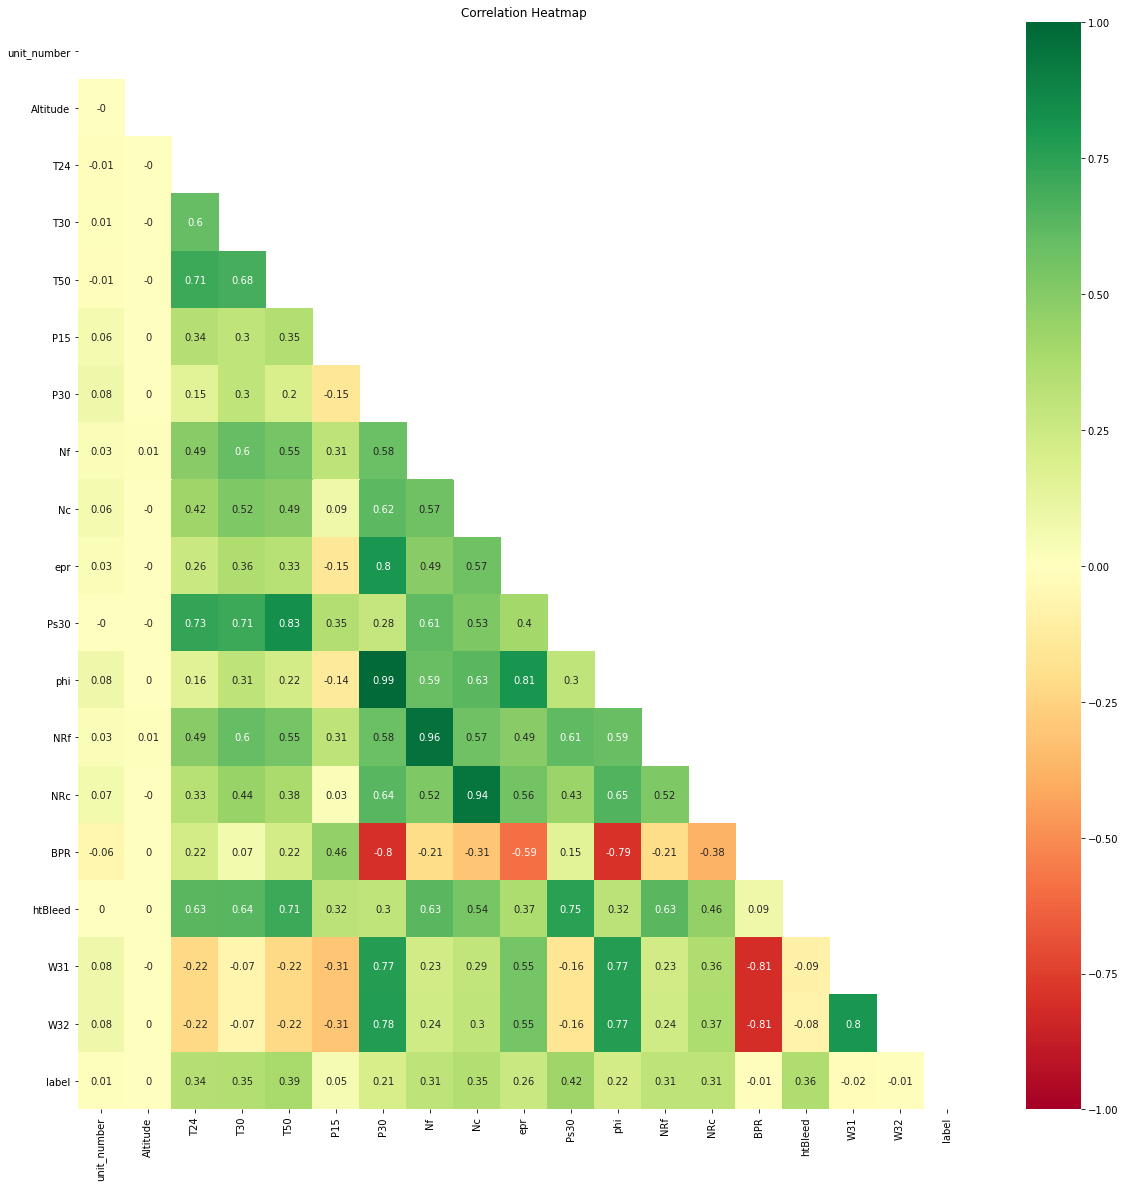

In [21]:
#Source: https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

plt.figure(figsize=(20, 20))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(TTF_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(np.round(TTF_data.corr(), 2), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap.set_title('Correlation Heatmap');

In [22]:
# Drop highly correlated variables and uncorrelated variables
TTF_data.drop(columns=['unit_number', 'Altitude', 'phi', 'NRf', 'NRc'], inplace=True)

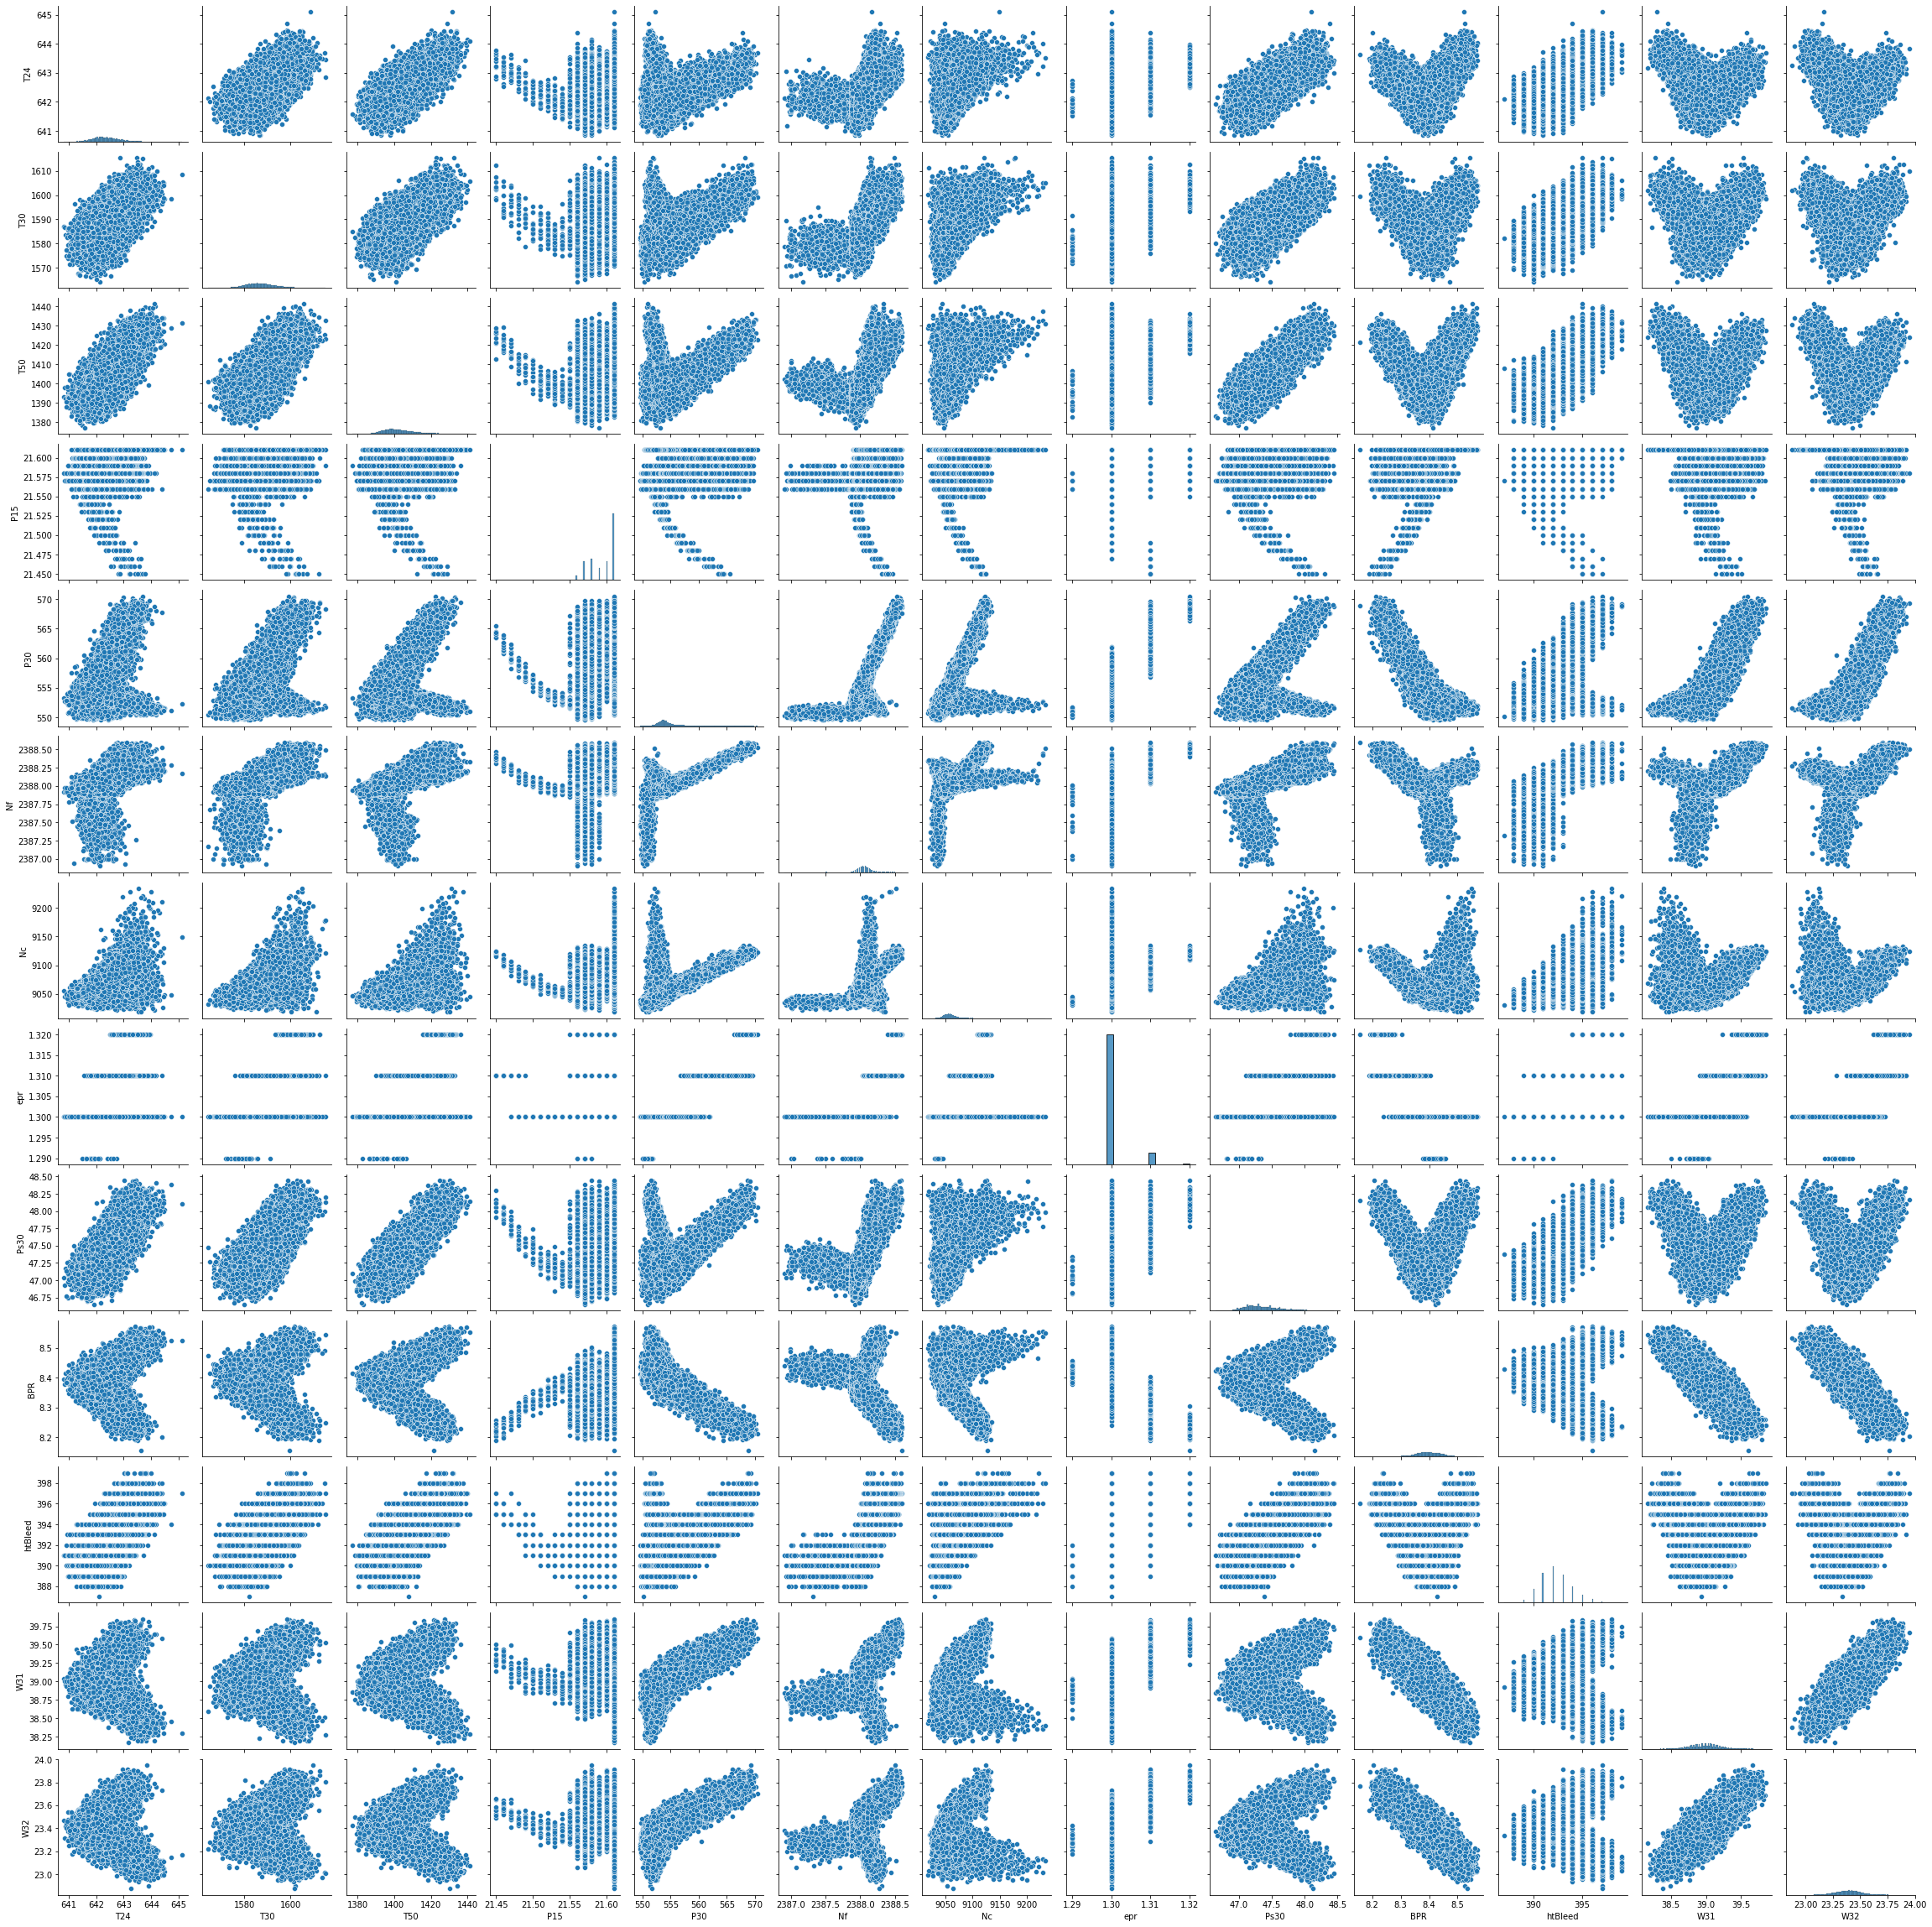

In [23]:
# Visualizing distribution and correlation of remaining variables 
sns.pairplot(TTF_data.drop(columns=['label']))

- Outlier Analysis:

/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/lib/python3.7/site-

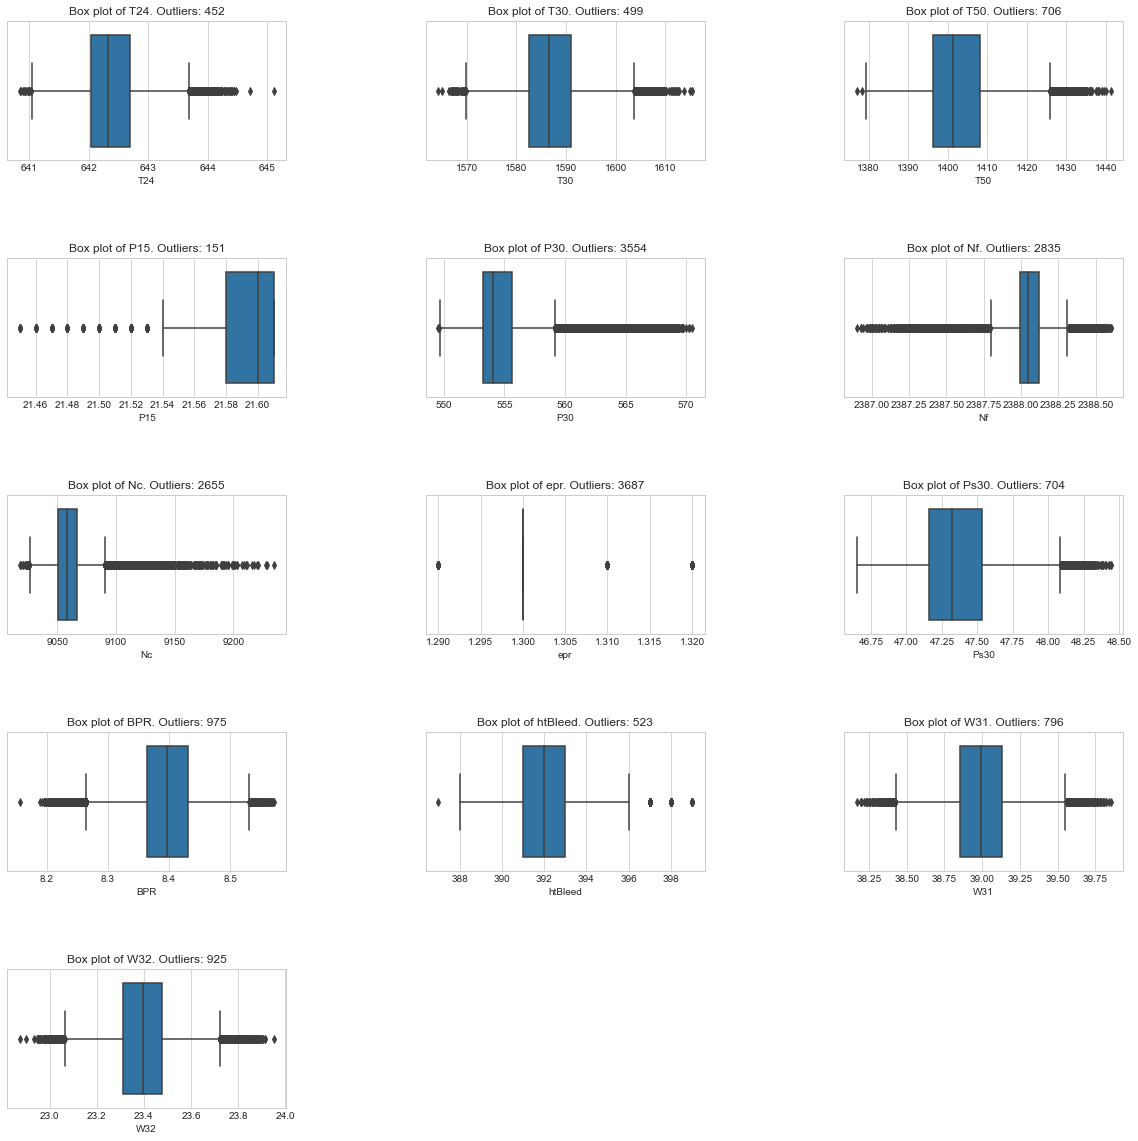

In [75]:
plot_box(TTF_data.drop(columns=['label']))

- Class Distribution:

In [25]:
def class_distribution(data):
    plt.bar(data['label'].unique(), data['label'].value_counts(), color=['green', 'red'])
    plt.title('Distribution of Classes')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0,1], ['Healthy (0)', 'Risk of Failure (1)'])
    plt.show()

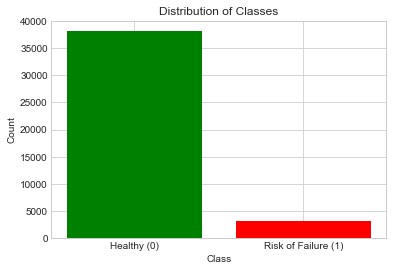

In [26]:
class_distribution(TTF_data)

<hr style="border:1px solid black"> </hr>

## Feature Engineering

In [27]:
# Splitting the data into X (parameters) and y (label)
X = TTF_data.drop(columns=['label']).values
y = TTF_data['label'].values

In [28]:
# Scaling Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [29]:
# Creating TFF_scaled
TFF_scaled = pd.DataFrame(X_scaled)
TFF_scaled['label'] = y
TFF_scaled.columns = ['T24', 'T30', 'T50', 'P15', 'P30', 'Nf', 'Nc', 'epr',
                      'Ps30', 'BPR', 'htBleed', 'W31', 'W32', 'label']

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

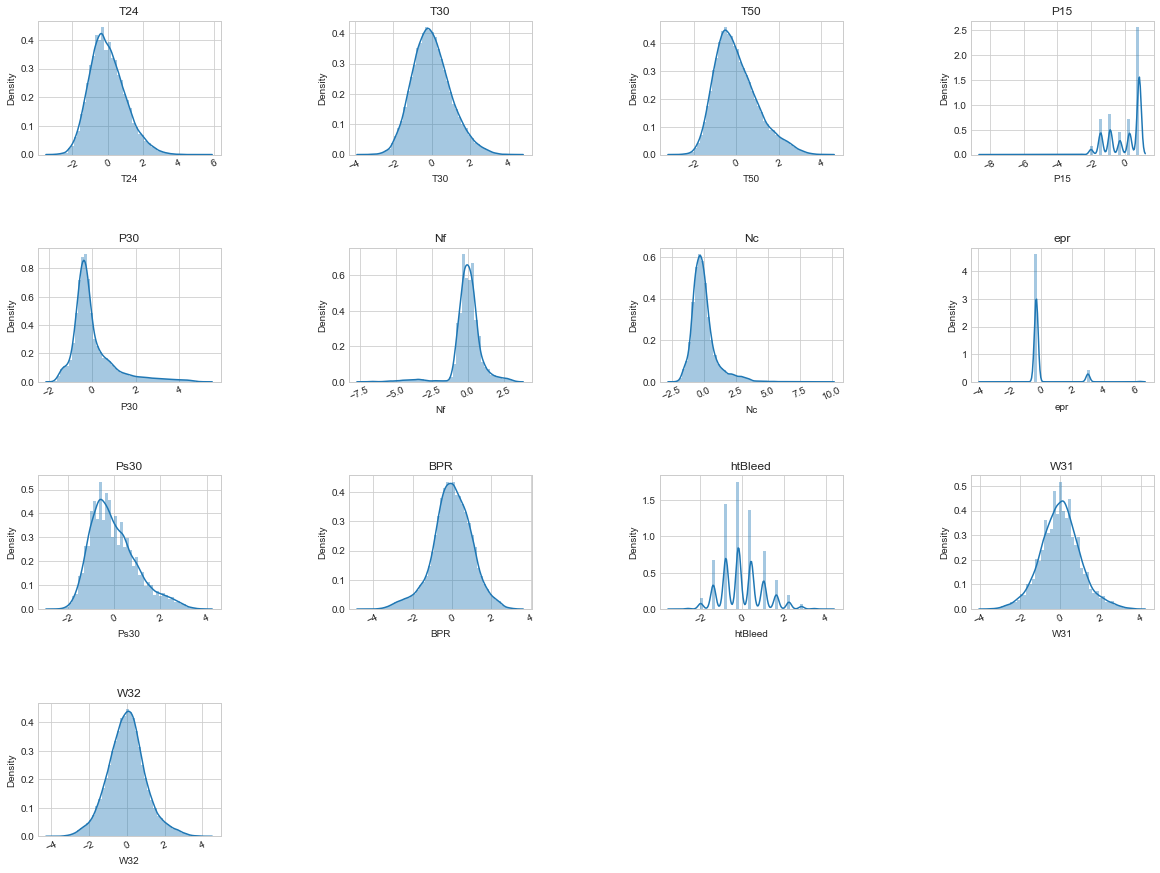

In [76]:
# Visualising distributions
plot_distribution(TFF_scaled.drop(columns=['label']))

### Data Imbalance

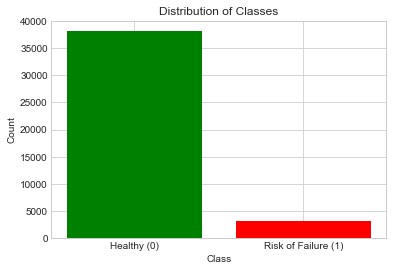

In [31]:
# Display class counts
class_distribution(TFF_scaled)

In [32]:
# Splitting intro train and test data
X_train, X_test, y_train, y_test = train_test_split(TFF_scaled.drop(columns=['label']), 
                                                    TFF_scaled['label'], 
                                                    test_size=0.2, 
                                                    random_state=123)

### No Data Imbalance

In [33]:
failure = TFF_scaled[TFF_scaled.label == 1]
healthy = TFF_scaled[TFF_scaled.label == 0]

- Upsampling:

In [34]:
# Upsample minority class
failure_upsampled = resample(failure,
                             n_samples=healthy.shape[0],
                             random_state=123)
 
# Combine majority class with upsampled minority class
data_upsampled = pd.concat([healthy, failure_upsampled])

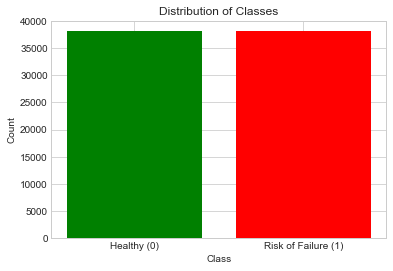

In [35]:
# Display new class counts - upsampled data
class_distribution(data_upsampled)

In [36]:
# Splitting intro train and test data
Xbal_train, Xbal_test, ybal_train, ybal_test = train_test_split(data_upsampled.drop(columns=['label']), 
                                                                data_upsampled['label'], 
                                                                test_size=0.2, 
                                                                random_state=123)

- Synthetic Data:

Adapted from - https://github.com/ydataai/ydata-synthetic/blob/master/examples/regular/wgan_example.py

In [37]:
# Define model, data columns and label column
model = WGAN_GP
data_cols = list(failure.columns[failure.columns != 'label'])
label_cols = ['label']

In [38]:
#Defining training data for GAN
train_data = failure.copy().reset_index(drop=True)

In [39]:
#Define the GAN and training parameters
noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
epochs = 5000
learning_rate = 5e-4
beta_1 = 0.5
beta_2 = 0.9
models_dir = './cache'

gan_args = [batch_size, learning_rate, beta_1, beta_2, noise_dim, train_data[data_cols].shape[1], dim]
train_args = ['', epochs, log_step]

In [40]:
#Training the WGAN_GP model
synthesizer = model(gan_args, n_critic=1)
synthesizer.train(train_data[data_cols], train_args)

  0%|          | 5/5000 [00:01<1:50:41,  1.33s/it]

Iteration: 0 | disc_loss: 5.138636589050293 | gen_loss: 0.02046990767121315
Iteration: 1 | disc_loss: 0.8931335806846619 | gen_loss: -0.0029454107861965895
Iteration: 2 | disc_loss: 0.1877252608537674 | gen_loss: -0.01203317753970623
Iteration: 3 | disc_loss: 0.001463811844587326 | gen_loss: -0.01821049302816391
Iteration: 4 | disc_loss: -0.10481608659029007 | gen_loss: -0.028350280597805977
Iteration: 5 | disc_loss: -0.06767818331718445 | gen_loss: -0.031749967485666275
Iteration: 6 | disc_loss: -0.16668671369552612 | gen_loss: -0.03017772175371647


  0%|          | 15/5000 [00:02<55:07,  1.51it/s]  

Iteration: 7 | disc_loss: -0.1353733092546463 | gen_loss: -0.014620931819081306
Iteration: 8 | disc_loss: -0.16072264313697815 | gen_loss: 0.006650887429714203
Iteration: 9 | disc_loss: -0.20146292448043823 | gen_loss: 0.0258110910654068
Iteration: 10 | disc_loss: -0.1746530830860138 | gen_loss: 0.016984090209007263
Iteration: 11 | disc_loss: -0.22080901265144348 | gen_loss: 0.03061649575829506
Iteration: 12 | disc_loss: -0.15733318030834198 | gen_loss: 0.02252306416630745
Iteration: 13 | disc_loss: -0.22007404267787933 | gen_loss: 0.028697185218334198
Iteration: 14 | disc_loss: -0.1867128163576126 | gen_loss: 0.03186601772904396
Iteration: 15 | disc_loss: -0.20445707440376282 | gen_loss: 0.06450063735246658


  0%|          | 20/5000 [00:02<39:09,  2.12it/s]

Iteration: 16 | disc_loss: 0.08620595932006836 | gen_loss: 0.02230658568441868
Iteration: 17 | disc_loss: -0.04253144562244415 | gen_loss: 0.02847476303577423
Iteration: 18 | disc_loss: -0.20154410600662231 | gen_loss: 0.044815413653850555
Iteration: 19 | disc_loss: -0.13726124167442322 | gen_loss: 0.07126472890377045
Iteration: 20 | disc_loss: -0.2742214500904083 | gen_loss: 0.1198757067322731
Iteration: 21 | disc_loss: -0.2353331446647644 | gen_loss: 0.08581492304801941
Iteration: 22 | disc_loss: -0.27918484807014465 | gen_loss: 0.07067827135324478


  1%|          | 29/5000 [00:02<20:15,  4.09it/s]

Iteration: 23 | disc_loss: -0.2636454105377197 | gen_loss: 0.053444940596818924
Iteration: 24 | disc_loss: -0.24424462020397186 | gen_loss: 0.04367486387491226
Iteration: 25 | disc_loss: -0.25264236330986023 | gen_loss: 0.043739669024944305
Iteration: 26 | disc_loss: -0.11328086256980896 | gen_loss: 0.049936626106500626
Iteration: 27 | disc_loss: -0.1269199252128601 | gen_loss: 0.07365726679563522
Iteration: 28 | disc_loss: 0.02674540877342224 | gen_loss: 0.04429721087217331
Iteration: 29 | disc_loss: -0.21596495807170868 | gen_loss: 0.05410180240869522
Iteration: 30 | disc_loss: -0.2303076833486557 | gen_loss: 0.06872792541980743
Iteration: 31 | disc_loss: -0.2358408272266388 | gen_loss: 0.07584080100059509


  1%|          | 37/5000 [00:02<11:02,  7.49it/s]

Iteration: 32 | disc_loss: -0.2860855460166931 | gen_loss: 0.11071022599935532
Iteration: 33 | disc_loss: -0.12403973937034607 | gen_loss: 0.08283722400665283
Iteration: 34 | disc_loss: -0.16036611795425415 | gen_loss: 0.11866767704486847
Iteration: 35 | disc_loss: -0.13063852488994598 | gen_loss: 0.09487777948379517
Iteration: 36 | disc_loss: -0.20388123393058777 | gen_loss: 0.10587248206138611
Iteration: 37 | disc_loss: -0.236471027135849 | gen_loss: 0.09579207003116608
Iteration: 38 | disc_loss: -0.23903045058250427 | gen_loss: 0.07830273360013962
Iteration: 39 | disc_loss: -0.2555326819419861 | gen_loss: 0.08293815702199936


  1%|          | 46/5000 [00:03<06:34, 12.56it/s]

Iteration: 40 | disc_loss: -0.2319929301738739 | gen_loss: 0.06652763485908508
Iteration: 41 | disc_loss: -0.25527068972587585 | gen_loss: 0.07075989991426468
Iteration: 42 | disc_loss: -0.18171845376491547 | gen_loss: 0.07095566391944885
Iteration: 43 | disc_loss: -0.13099993765354156 | gen_loss: 0.08041925728321075
Iteration: 44 | disc_loss: -0.1342589557170868 | gen_loss: 0.07956907153129578
Iteration: 45 | disc_loss: -0.24489423632621765 | gen_loss: 0.0914628803730011
Iteration: 46 | disc_loss: -0.23054006695747375 | gen_loss: 0.08625337481498718


  1%|          | 54/5000 [00:03<04:22, 18.81it/s]

Iteration: 47 | disc_loss: -0.2360604703426361 | gen_loss: 0.09546610713005066
Iteration: 48 | disc_loss: -0.2447100281715393 | gen_loss: 0.1036147028207779
Iteration: 49 | disc_loss: -0.24607478082180023 | gen_loss: 0.11899255216121674
Iteration: 50 | disc_loss: -0.26435187458992004 | gen_loss: 0.15173369646072388
Iteration: 51 | disc_loss: -0.1756475865840912 | gen_loss: 0.10786686837673187
Iteration: 52 | disc_loss: -0.14320769906044006 | gen_loss: 0.08653008192777634
Iteration: 53 | disc_loss: -0.04747164249420166 | gen_loss: 0.15528567135334015
Iteration: 54 | disc_loss: -0.2278270125389099 | gen_loss: 0.23904165625572205
Iteration: 55 | disc_loss: 0.040820926427841187 | gen_loss: 0.08968476206064224


  1%|          | 62/5000 [00:03<03:18, 24.86it/s]

Iteration: 56 | disc_loss: -0.021759629249572754 | gen_loss: -0.005362875293940306
Iteration: 57 | disc_loss: 0.1032622754573822 | gen_loss: 0.08933154493570328
Iteration: 58 | disc_loss: -0.0840236097574234 | gen_loss: 0.13174256682395935
Iteration: 59 | disc_loss: -0.2689749002456665 | gen_loss: 0.14036822319030762
Iteration: 60 | disc_loss: -0.10312354564666748 | gen_loss: 0.11310471594333649
Iteration: 61 | disc_loss: -0.2485557347536087 | gen_loss: 0.11274117976427078
Iteration: 62 | disc_loss: -0.24451258778572083 | gen_loss: 0.10616016387939453


  1%|▏         | 70/5000 [00:03<02:54, 28.26it/s]

Iteration: 63 | disc_loss: -0.24550019204616547 | gen_loss: 0.09080657362937927
Iteration: 64 | disc_loss: -0.2556208372116089 | gen_loss: 0.07440995424985886
Iteration: 65 | disc_loss: -0.2076568752527237 | gen_loss: 0.07113048434257507
Iteration: 66 | disc_loss: -0.2385348677635193 | gen_loss: 0.057331934571266174
Iteration: 67 | disc_loss: -0.23948146402835846 | gen_loss: 0.06761112809181213
Iteration: 68 | disc_loss: -0.24758315086364746 | gen_loss: 0.09941659867763519
Iteration: 69 | disc_loss: -0.27849817276000977 | gen_loss: 0.1488041877746582
Iteration: 70 | disc_loss: -0.29250577092170715 | gen_loss: 0.1735846996307373


  2%|▏         | 78/5000 [00:03<02:41, 30.51it/s]

Iteration: 71 | disc_loss: -0.2932196259498596 | gen_loss: 0.18318012356758118
Iteration: 72 | disc_loss: -0.28275471925735474 | gen_loss: 0.13480007648468018
Iteration: 73 | disc_loss: -0.2687554955482483 | gen_loss: 0.10142108798027039
Iteration: 74 | disc_loss: -0.22484110295772552 | gen_loss: 0.09947914630174637
Iteration: 75 | disc_loss: 0.06407301127910614 | gen_loss: -0.005507941357791424
Iteration: 76 | disc_loss: 0.9968873262405396 | gen_loss: 0.11661140620708466
Iteration: 77 | disc_loss: 0.007195636630058289 | gen_loss: 0.19379127025604248


  2%|▏         | 82/5000 [00:04<02:47, 29.41it/s]

Iteration: 78 | disc_loss: -0.18151484429836273 | gen_loss: 0.22547578811645508
Iteration: 79 | disc_loss: 0.03913801908493042 | gen_loss: 0.16178394854068756
Iteration: 80 | disc_loss: -0.14532814919948578 | gen_loss: 0.1397315114736557
Iteration: 81 | disc_loss: -0.17581194639205933 | gen_loss: 0.13148808479309082
Iteration: 82 | disc_loss: -0.06256157904863358 | gen_loss: 0.07831969112157822
Iteration: 83 | disc_loss: -0.11204502731561661 | gen_loss: 0.09111079573631287


  2%|▏         | 90/5000 [00:04<02:39, 30.86it/s]

Iteration: 84 | disc_loss: -0.0880877822637558 | gen_loss: 0.0789836123585701
Iteration: 85 | disc_loss: -0.04008878767490387 | gen_loss: 0.08279235661029816
Iteration: 86 | disc_loss: -0.13240519165992737 | gen_loss: 0.11503274738788605
Iteration: 87 | disc_loss: -0.1927020400762558 | gen_loss: 0.1676180362701416
Iteration: 88 | disc_loss: -0.15040427446365356 | gen_loss: 0.1577407717704773
Iteration: 89 | disc_loss: -0.19295169413089752 | gen_loss: 0.20704320073127747
Iteration: 90 | disc_loss: -0.22835451364517212 | gen_loss: 0.14957118034362793
Iteration: 91 | disc_loss: -0.13208237290382385 | gen_loss: 0.09915118664503098


  2%|▏         | 98/5000 [00:04<02:28, 32.96it/s]

Iteration: 92 | disc_loss: -0.11970960348844528 | gen_loss: 0.06291253864765167
Iteration: 93 | disc_loss: -0.133103609085083 | gen_loss: 0.07462254166603088
Iteration: 94 | disc_loss: -0.1715782880783081 | gen_loss: 0.07573968172073364
Iteration: 95 | disc_loss: -0.15695549547672272 | gen_loss: 0.07362951338291168
Iteration: 96 | disc_loss: -0.1679762303829193 | gen_loss: 0.08030577003955841
Iteration: 97 | disc_loss: -0.16056784987449646 | gen_loss: 0.09870397299528122
Iteration: 98 | disc_loss: -0.15963739156723022 | gen_loss: 0.11576840281486511
Iteration: 99 | disc_loss: -0.16256853938102722 | gen_loss: 0.15816062688827515


  2%|▏         | 106/5000 [00:04<02:38, 30.96it/s]

Iteration: 100 | disc_loss: -0.17063891887664795 | gen_loss: 0.2089042067527771
Iteration: 101 | disc_loss: 0.08158919215202332 | gen_loss: 0.07055771350860596
Iteration: 102 | disc_loss: -0.017173372209072113 | gen_loss: -0.0690445825457573
Iteration: 103 | disc_loss: 0.21202543377876282 | gen_loss: 0.15375187993049622
Iteration: 104 | disc_loss: -0.09460300207138062 | gen_loss: 0.29994672536849976
Iteration: 105 | disc_loss: -0.09546776115894318 | gen_loss: 0.3460269570350647


  2%|▏         | 110/5000 [00:05<02:32, 32.06it/s]

Iteration: 106 | disc_loss: -0.092765673995018 | gen_loss: 0.492506206035614
Iteration: 107 | disc_loss: 0.21820366382598877 | gen_loss: 0.23574215173721313
Iteration: 108 | disc_loss: -0.05529610812664032 | gen_loss: 0.22123706340789795
Iteration: 109 | disc_loss: -0.1777731031179428 | gen_loss: 0.2005794793367386
Iteration: 110 | disc_loss: 0.16126221418380737 | gen_loss: 0.11477920413017273
Iteration: 111 | disc_loss: -0.04559723287820816 | gen_loss: 0.09470629692077637
Iteration: 112 | disc_loss: -0.1310431957244873 | gen_loss: 0.05782013013958931


  2%|▏         | 118/5000 [00:05<02:34, 31.52it/s]

Iteration: 113 | disc_loss: -0.12372303009033203 | gen_loss: 0.07340901345014572
Iteration: 114 | disc_loss: -0.16542668640613556 | gen_loss: 0.0871167927980423
Iteration: 115 | disc_loss: -0.17292091250419617 | gen_loss: 0.11091341078281403
Iteration: 116 | disc_loss: -0.1703459620475769 | gen_loss: 0.12610459327697754
Iteration: 117 | disc_loss: -0.1389886736869812 | gen_loss: 0.15626956522464752
Iteration: 118 | disc_loss: -0.13829094171524048 | gen_loss: 0.19497574865818024
Iteration: 119 | disc_loss: -0.1401778608560562 | gen_loss: 0.1999712735414505


  3%|▎         | 126/5000 [00:05<02:30, 32.41it/s]

Iteration: 120 | disc_loss: -0.07041274011135101 | gen_loss: 0.17083990573883057
Iteration: 121 | disc_loss: -0.12465845793485641 | gen_loss: 0.21502147614955902
Iteration: 122 | disc_loss: -0.13077184557914734 | gen_loss: 0.19687029719352722
Iteration: 123 | disc_loss: -0.1752486228942871 | gen_loss: 0.15234869718551636
Iteration: 124 | disc_loss: -0.16967067122459412 | gen_loss: 0.12935546040534973
Iteration: 125 | disc_loss: -0.14352674782276154 | gen_loss: 0.06717167049646378
Iteration: 126 | disc_loss: -0.010594755411148071 | gen_loss: 0.13677464425563812
Iteration: 127 | disc_loss: 0.02025565505027771 | gen_loss: 0.15861210227012634


  3%|▎         | 134/5000 [00:05<02:20, 34.66it/s]

Iteration: 128 | disc_loss: -0.1474250853061676 | gen_loss: 0.16567733883857727
Iteration: 129 | disc_loss: -0.046628184616565704 | gen_loss: 0.21878337860107422
Iteration: 130 | disc_loss: -0.17137055099010468 | gen_loss: 0.2547432482242584
Iteration: 131 | disc_loss: -0.12155095487833023 | gen_loss: 0.16728179156780243
Iteration: 132 | disc_loss: -0.10533765703439713 | gen_loss: 0.18485625088214874
Iteration: 133 | disc_loss: 0.15693849325180054 | gen_loss: 0.07586245238780975
Iteration: 134 | disc_loss: 0.06706030666828156 | gen_loss: 0.01379774883389473
Iteration: 135 | disc_loss: -0.1549271047115326 | gen_loss: -0.043451353907585144


  3%|▎         | 142/5000 [00:05<02:31, 31.96it/s]

Iteration: 136 | disc_loss: -0.05277833342552185 | gen_loss: 0.08980568498373032
Iteration: 137 | disc_loss: -0.11657977849245071 | gen_loss: 0.13094379007816315
Iteration: 138 | disc_loss: -0.15834559500217438 | gen_loss: 0.14982861280441284
Iteration: 139 | disc_loss: -0.15740568935871124 | gen_loss: 0.16174043715000153
Iteration: 140 | disc_loss: -0.09052275121212006 | gen_loss: 0.16029301285743713
Iteration: 141 | disc_loss: -0.06296154111623764 | gen_loss: 0.23947802186012268


  3%|▎         | 150/5000 [00:06<02:20, 34.41it/s]

Iteration: 142 | disc_loss: -0.006839588284492493 | gen_loss: 0.1529420018196106
Iteration: 143 | disc_loss: -0.1160508245229721 | gen_loss: 0.16522333025932312
Iteration: 144 | disc_loss: -0.14905032515525818 | gen_loss: 0.15380766987800598
Iteration: 145 | disc_loss: -0.08090658485889435 | gen_loss: 0.1407824605703354
Iteration: 146 | disc_loss: -0.12995818257331848 | gen_loss: 0.1416659653186798
Iteration: 147 | disc_loss: -0.13285483419895172 | gen_loss: 0.12560194730758667
Iteration: 148 | disc_loss: 0.03292126953601837 | gen_loss: 0.09482686966657639
Iteration: 149 | disc_loss: 0.17043907940387726 | gen_loss: 0.04153335466980934


  3%|▎         | 154/5000 [00:06<02:17, 35.15it/s]

Iteration: 150 | disc_loss: -0.10963042080402374 | gen_loss: 0.006852652877569199
Iteration: 151 | disc_loss: 0.1195068210363388 | gen_loss: 0.16711317002773285
Iteration: 152 | disc_loss: -0.05620035529136658 | gen_loss: 0.3006492257118225
Iteration: 153 | disc_loss: 0.08416324853897095 | gen_loss: 0.1597619354724884
Iteration: 154 | disc_loss: -0.04625128209590912 | gen_loss: 0.14108669757843018
Iteration: 155 | disc_loss: -0.08091630041599274 | gen_loss: 0.08459873497486115
Iteration: 156 | disc_loss: -0.06866125762462616 | gen_loss: 0.0646406039595604


  3%|▎         | 162/5000 [00:06<02:32, 31.82it/s]

Iteration: 157 | disc_loss: -0.048920463770627975 | gen_loss: 0.03983743488788605
Iteration: 158 | disc_loss: -0.08245614171028137 | gen_loss: 0.015355458483099937
Iteration: 159 | disc_loss: -0.1066499575972557 | gen_loss: 0.03086979314684868
Iteration: 160 | disc_loss: -0.1212100237607956 | gen_loss: -0.009034212678670883
Iteration: 161 | disc_loss: -0.020337529480457306 | gen_loss: 0.05829046666622162
Iteration: 162 | disc_loss: 0.10096774995326996 | gen_loss: 0.013899772427976131
Iteration: 163 | disc_loss: -0.058757103979587555 | gen_loss: 0.04537699744105339


  3%|▎         | 170/5000 [00:06<02:22, 33.91it/s]

Iteration: 164 | disc_loss: -0.0755920261144638 | gen_loss: 0.09239375591278076
Iteration: 165 | disc_loss: -0.08824130892753601 | gen_loss: 0.11492443829774857
Iteration: 166 | disc_loss: -0.0929047241806984 | gen_loss: 0.16307833790779114
Iteration: 167 | disc_loss: -0.07969597727060318 | gen_loss: 0.16000646352767944
Iteration: 168 | disc_loss: -0.05023634433746338 | gen_loss: 0.216602623462677
Iteration: 169 | disc_loss: 0.03846649080514908 | gen_loss: 0.13512998819351196
Iteration: 170 | disc_loss: -0.023668594658374786 | gen_loss: 0.13783761858940125
Iteration: 171 | disc_loss: -0.035815127193927765 | gen_loss: 0.1293565332889557


  4%|▎         | 178/5000 [00:07<02:28, 32.56it/s]

Iteration: 172 | disc_loss: -0.05237801745533943 | gen_loss: 0.11916609853506088
Iteration: 173 | disc_loss: -0.05821993947029114 | gen_loss: 0.1118905246257782
Iteration: 174 | disc_loss: -0.08570831269025803 | gen_loss: 0.09901003539562225
Iteration: 175 | disc_loss: -0.056670207530260086 | gen_loss: 0.08961821347475052
Iteration: 176 | disc_loss: -0.06728759407997131 | gen_loss: 0.05753489211201668
Iteration: 177 | disc_loss: -0.05607923865318298 | gen_loss: 0.058083534240722656
Iteration: 178 | disc_loss: -0.05324898287653923 | gen_loss: 0.02309165708720684


  4%|▎         | 182/5000 [00:07<02:53, 27.79it/s]

Iteration: 179 | disc_loss: 0.015226982533931732 | gen_loss: 0.050334349274635315
Iteration: 180 | disc_loss: 0.008642010390758514 | gen_loss: 0.11411929875612259
Iteration: 181 | disc_loss: -0.050957802683115005 | gen_loss: 0.15378844738006592
Iteration: 182 | disc_loss: -0.08617192506790161 | gen_loss: 0.16099540889263153
Iteration: 183 | disc_loss: -0.10399294644594193 | gen_loss: 0.19311273097991943


  4%|▍         | 190/5000 [00:07<02:40, 29.95it/s]

Iteration: 184 | disc_loss: -0.08820831775665283 | gen_loss: 0.13017608225345612
Iteration: 185 | disc_loss: -0.09297961741685867 | gen_loss: 0.10102847218513489
Iteration: 186 | disc_loss: -0.07351371645927429 | gen_loss: 0.09744945168495178
Iteration: 187 | disc_loss: -0.03473437950015068 | gen_loss: 0.07243519276380539
Iteration: 188 | disc_loss: -0.004126850515604019 | gen_loss: 0.08730940520763397
Iteration: 189 | disc_loss: 0.015515424311161041 | gen_loss: 0.05700230598449707
Iteration: 190 | disc_loss: -0.041508059948682785 | gen_loss: 0.04609748348593712


  4%|▍         | 197/5000 [00:07<02:54, 27.51it/s]

Iteration: 191 | disc_loss: -0.06890258193016052 | gen_loss: 0.04686141759157181
Iteration: 192 | disc_loss: -0.08188693970441818 | gen_loss: -0.007533561438322067
Iteration: 193 | disc_loss: 0.009299829602241516 | gen_loss: 0.08827920258045197
Iteration: 194 | disc_loss: 0.11115853488445282 | gen_loss: 0.1986626535654068
Iteration: 195 | disc_loss: 0.050783075392246246 | gen_loss: 0.10552909970283508
Iteration: 196 | disc_loss: -0.0343787744641304 | gen_loss: 0.07951311022043228
Iteration: 197 | disc_loss: -0.08136938512325287 | gen_loss: 0.047049716114997864
Iteration: 198 | disc_loss: 0.012430533766746521 | gen_loss: 0.0569918192923069
Iteration: 199 | disc_loss: 0.00318991020321846 | gen_loss: 0.05098292604088783
Iteration: 200 | disc_loss: 0.02472531422972679 | gen_loss: 0.08319811522960663


  4%|▍         | 209/5000 [00:08<02:56, 27.12it/s]

Iteration: 201 | disc_loss: 0.023666836321353912 | gen_loss: 0.08941537141799927
Iteration: 202 | disc_loss: 0.04211334139108658 | gen_loss: 0.10551657527685165
Iteration: 203 | disc_loss: -0.043582525104284286 | gen_loss: 0.1521901935338974
Iteration: 204 | disc_loss: -0.06823401153087616 | gen_loss: 0.16075915098190308
Iteration: 205 | disc_loss: -0.07288828492164612 | gen_loss: 0.14079849421977997
Iteration: 206 | disc_loss: -0.060275766998529434 | gen_loss: 0.1110692173242569
Iteration: 207 | disc_loss: -0.0728582814335823 | gen_loss: 0.09977927803993225
Iteration: 208 | disc_loss: -0.07853065431118011 | gen_loss: 0.0391407385468483


  4%|▍         | 213/5000 [00:08<02:43, 29.28it/s]

Iteration: 209 | disc_loss: 0.027092158794403076 | gen_loss: 0.09016278386116028
Iteration: 210 | disc_loss: 0.0019425377249717712 | gen_loss: 0.11759872734546661
Iteration: 211 | disc_loss: -0.005776740610599518 | gen_loss: 0.09107993543148041
Iteration: 212 | disc_loss: -0.0667710229754448 | gen_loss: 0.10318464785814285
Iteration: 213 | disc_loss: -0.07485610246658325 | gen_loss: 0.07665121555328369
Iteration: 214 | disc_loss: 0.0032994747161865234 | gen_loss: 0.09504958987236023
Iteration: 215 | disc_loss: 0.06203656643629074 | gen_loss: 0.08736255764961243


  4%|▍         | 221/5000 [00:08<02:33, 31.14it/s]

Iteration: 216 | disc_loss: -0.05170927196741104 | gen_loss: 0.04264526441693306
Iteration: 217 | disc_loss: -0.006639666855335236 | gen_loss: 0.06932022422552109
Iteration: 218 | disc_loss: 0.0019758939743041992 | gen_loss: 0.02843310683965683
Iteration: 219 | disc_loss: -0.040972750633955 | gen_loss: 0.05330532789230347
Iteration: 220 | disc_loss: -0.06444589048624039 | gen_loss: 0.09668910503387451
Iteration: 221 | disc_loss: -0.06830545514822006 | gen_loss: 0.07764029502868652
Iteration: 222 | disc_loss: 0.0088941790163517 | gen_loss: 0.10772763192653656
Iteration: 223 | disc_loss: -0.016231577843427658 | gen_loss: 0.26006078720092773


  5%|▍         | 230/5000 [00:08<02:32, 31.33it/s]

Iteration: 224 | disc_loss: 0.058441027998924255 | gen_loss: 0.1945454180240631
Iteration: 225 | disc_loss: 0.04185134917497635 | gen_loss: 0.2953444719314575
Iteration: 226 | disc_loss: 0.06314460933208466 | gen_loss: 0.12952429056167603
Iteration: 227 | disc_loss: -0.053100377321243286 | gen_loss: 0.07426074147224426
Iteration: 228 | disc_loss: -0.05202976614236832 | gen_loss: 0.0390000119805336
Iteration: 229 | disc_loss: -0.013191774487495422 | gen_loss: 0.0528537817299366


  5%|▍         | 234/5000 [00:09<02:28, 32.08it/s]

Iteration: 230 | disc_loss: -0.036552272737026215 | gen_loss: 0.030914969742298126
Iteration: 231 | disc_loss: 0.021891549229621887 | gen_loss: 0.08121712505817413
Iteration: 232 | disc_loss: 0.04362078011035919 | gen_loss: 0.031399525701999664
Iteration: 233 | disc_loss: -0.05373934656381607 | gen_loss: 0.009030550718307495
Iteration: 234 | disc_loss: -0.05014684796333313 | gen_loss: 0.05883492901921272
Iteration: 235 | disc_loss: -0.02191830426454544 | gen_loss: 0.08995979279279709


  5%|▍         | 242/5000 [00:09<02:33, 31.06it/s]

Iteration: 236 | disc_loss: 3.714859485626221e-05 | gen_loss: 0.12777428328990936
Iteration: 237 | disc_loss: 0.2147139310836792 | gen_loss: 0.1524045467376709
Iteration: 238 | disc_loss: 0.25422146916389465 | gen_loss: 0.23686042428016663
Iteration: 239 | disc_loss: -0.050021007657051086 | gen_loss: 0.2753737270832062
Iteration: 240 | disc_loss: 0.01440994068980217 | gen_loss: 0.17769649624824524
Iteration: 241 | disc_loss: -0.01225389912724495 | gen_loss: 0.14800351858139038
Iteration: 242 | disc_loss: -0.05564158037304878 | gen_loss: 0.13476082682609558
Iteration: 243 | disc_loss: -0.053273748606443405 | gen_loss: 0.10096482932567596


  5%|▌         | 250/5000 [00:09<02:21, 33.66it/s]

Iteration: 244 | disc_loss: -0.09481024742126465 | gen_loss: 0.07456658780574799
Iteration: 245 | disc_loss: -0.09040036052465439 | gen_loss: 0.049178481101989746
Iteration: 246 | disc_loss: -0.041526228189468384 | gen_loss: 0.003923967946320772
Iteration: 247 | disc_loss: 0.06582581251859665 | gen_loss: 0.09991833567619324
Iteration: 248 | disc_loss: 0.15099340677261353 | gen_loss: 0.18136072158813477
Iteration: 249 | disc_loss: -0.036093153059482574 | gen_loss: 0.18372146785259247
Iteration: 250 | disc_loss: -0.04588684067130089 | gen_loss: 0.1524866670370102
Iteration: 251 | disc_loss: -0.04348914325237274 | gen_loss: 0.14866863191127777
Iteration: 252 | disc_loss: -0.064608633518219 | gen_loss: 0.14167693257331848


  5%|▌         | 259/5000 [00:09<02:14, 35.20it/s]

Iteration: 253 | disc_loss: -0.036702096462249756 | gen_loss: 0.10118047893047333
Iteration: 254 | disc_loss: -0.016327710822224617 | gen_loss: 0.06228385120630264
Iteration: 255 | disc_loss: -0.009598914533853531 | gen_loss: 0.09254249185323715
Iteration: 256 | disc_loss: 0.0038753673434257507 | gen_loss: 0.07915738970041275
Iteration: 257 | disc_loss: -0.04644279554486275 | gen_loss: 0.11420486867427826
Iteration: 258 | disc_loss: -0.05803383141756058 | gen_loss: 0.14496874809265137
Iteration: 259 | disc_loss: -0.05259375646710396 | gen_loss: 0.13466280698776245
Iteration: 260 | disc_loss: 0.015300724655389786 | gen_loss: 0.15658310055732727


  5%|▌         | 267/5000 [00:09<02:22, 33.12it/s]

Iteration: 261 | disc_loss: -0.05928346514701843 | gen_loss: 0.1199389174580574
Iteration: 262 | disc_loss: -0.06660408526659012 | gen_loss: 0.09774264693260193
Iteration: 263 | disc_loss: -0.014351651072502136 | gen_loss: 0.1341610550880432
Iteration: 264 | disc_loss: 0.04804716259241104 | gen_loss: 0.10480712354183197
Iteration: 265 | disc_loss: -0.026428643614053726 | gen_loss: 0.12661486864089966
Iteration: 266 | disc_loss: -0.06581603735685349 | gen_loss: 0.1391531378030777


  6%|▌         | 275/5000 [00:10<02:21, 33.51it/s]

Iteration: 267 | disc_loss: -0.03961969166994095 | gen_loss: 0.13871049880981445
Iteration: 268 | disc_loss: -0.062357932329177856 | gen_loss: 0.15300408005714417
Iteration: 269 | disc_loss: -0.06613294780254364 | gen_loss: 0.14363691210746765
Iteration: 270 | disc_loss: -0.07141224294900894 | gen_loss: 0.09946700930595398
Iteration: 271 | disc_loss: 0.02626928687095642 | gen_loss: 0.12731409072875977
Iteration: 272 | disc_loss: 0.047508612275123596 | gen_loss: 0.05327858403325081
Iteration: 273 | disc_loss: -0.0775737464427948 | gen_loss: 0.04776192456483841
Iteration: 274 | disc_loss: -0.038954008370637894 | gen_loss: 0.10110698640346527


  6%|▌         | 279/5000 [00:10<02:26, 32.15it/s]

Iteration: 275 | disc_loss: -0.08177229017019272 | gen_loss: 0.11121547967195511
Iteration: 276 | disc_loss: -0.06073435768485069 | gen_loss: 0.1324843168258667
Iteration: 277 | disc_loss: -0.07947742938995361 | gen_loss: 0.1703101247549057
Iteration: 278 | disc_loss: -0.07338608801364899 | gen_loss: 0.20482110977172852
Iteration: 279 | disc_loss: 0.050163932144641876 | gen_loss: 0.18657299876213074
Iteration: 280 | disc_loss: 0.12363447993993759 | gen_loss: 0.234268456697464
Iteration: 281 | disc_loss: 0.0075808316469192505 | gen_loss: 0.1635052114725113


  6%|▌         | 288/5000 [00:10<02:44, 28.67it/s]

Iteration: 282 | disc_loss: -0.01840921677649021 | gen_loss: 0.13337650895118713
Iteration: 283 | disc_loss: -0.041660893708467484 | gen_loss: 0.0544423907995224
Iteration: 284 | disc_loss: 0.14487898349761963 | gen_loss: 0.13708165287971497
Iteration: 285 | disc_loss: 0.11018332839012146 | gen_loss: 0.1329459547996521
Iteration: 286 | disc_loss: -0.04403167963027954 | gen_loss: 0.14450612664222717
Iteration: 287 | disc_loss: -0.06201280653476715 | gen_loss: 0.1328313797712326
Iteration: 288 | disc_loss: -0.033943869173526764 | gen_loss: 0.061317697167396545
Iteration: 289 | disc_loss: -0.03530292585492134 | gen_loss: 0.05110548809170723
Iteration: 290 | disc_loss: 0.020483125001192093 | gen_loss: 0.17184078693389893


  6%|▌         | 296/5000 [00:10<02:32, 30.91it/s]

Iteration: 291 | disc_loss: -0.04884777218103409 | gen_loss: 0.24557563662528992
Iteration: 292 | disc_loss: -0.08786924928426743 | gen_loss: 0.287858784198761
Iteration: 293 | disc_loss: -0.01762676239013672 | gen_loss: 0.2606642246246338
Iteration: 294 | disc_loss: 0.049524202942848206 | gen_loss: 0.2673053443431854
Iteration: 295 | disc_loss: 0.09484007954597473 | gen_loss: 0.21066108345985413
Iteration: 296 | disc_loss: -0.048661909997463226 | gen_loss: 0.14640295505523682
Iteration: 297 | disc_loss: -0.08212371170520782 | gen_loss: 0.06003803759813309


  6%|▌         | 300/5000 [00:11<02:32, 30.81it/s]

Iteration: 298 | disc_loss: -0.03683703392744064 | gen_loss: 0.05924402177333832
Iteration: 299 | disc_loss: -0.015023009851574898 | gen_loss: 0.03409034013748169
Iteration: 300 | disc_loss: -0.04862078279256821 | gen_loss: 0.025496600195765495
Iteration: 301 | disc_loss: 0.0018916279077529907 | gen_loss: 0.049595825374126434


  6%|▌         | 308/5000 [00:11<02:43, 28.77it/s]

Iteration: 302 | disc_loss: 0.05089036375284195 | gen_loss: 0.15826815366744995
Iteration: 303 | disc_loss: 0.13104328513145447 | gen_loss: 0.28465035557746887
Iteration: 304 | disc_loss: 0.33687713742256165 | gen_loss: 0.1415475308895111
Iteration: 305 | disc_loss: 0.035242676734924316 | gen_loss: 0.087717205286026
Iteration: 306 | disc_loss: -0.056410711258649826 | gen_loss: 0.06702527403831482
Iteration: 307 | disc_loss: -0.05237922817468643 | gen_loss: 0.0789061188697815


  6%|▌         | 312/5000 [00:11<04:07, 18.94it/s]

Iteration: 308 | disc_loss: -0.05994434654712677 | gen_loss: 0.0785394236445427
Iteration: 309 | disc_loss: -0.04243563860654831 | gen_loss: 0.08784772455692291
Iteration: 310 | disc_loss: -0.04474016651511192 | gen_loss: 0.10197387635707855
Iteration: 311 | disc_loss: 0.2013428658246994 | gen_loss: 0.12883511185646057
Iteration: 312 | disc_loss: 0.1729958951473236 | gen_loss: 0.13064466416835785


  6%|▋         | 320/5000 [00:12<03:10, 24.61it/s]

Iteration: 313 | disc_loss: 0.010856129229068756 | gen_loss: 0.15085694193840027
Iteration: 314 | disc_loss: 0.3555174767971039 | gen_loss: 0.14073139429092407
Iteration: 315 | disc_loss: -0.05062131583690643 | gen_loss: 0.13271036744117737
Iteration: 316 | disc_loss: -0.03012063354253769 | gen_loss: 0.1128404289484024
Iteration: 317 | disc_loss: -0.0786428302526474 | gen_loss: 0.11428648978471756
Iteration: 318 | disc_loss: 0.02814450114965439 | gen_loss: 0.11963094025850296
Iteration: 319 | disc_loss: -0.06130492314696312 | gen_loss: 0.14172038435935974


  7%|▋         | 327/5000 [00:12<02:46, 28.11it/s]

Iteration: 320 | disc_loss: -0.03345885127782822 | gen_loss: 0.1063026711344719
Iteration: 321 | disc_loss: -0.030272282660007477 | gen_loss: 0.1202998161315918
Iteration: 322 | disc_loss: -0.026318930089473724 | gen_loss: 0.1502540558576584
Iteration: 323 | disc_loss: -0.042223893105983734 | gen_loss: 0.16298362612724304
Iteration: 324 | disc_loss: -0.0652511939406395 | gen_loss: 0.17624148726463318
Iteration: 325 | disc_loss: -0.06485909968614578 | gen_loss: 0.20739296078681946
Iteration: 326 | disc_loss: -0.05841132253408432 | gen_loss: 0.194731205701828


  7%|▋         | 335/5000 [00:12<02:28, 31.37it/s]

Iteration: 327 | disc_loss: -0.07041555643081665 | gen_loss: 0.18285948038101196
Iteration: 328 | disc_loss: -0.05689041689038277 | gen_loss: 0.16947761178016663
Iteration: 329 | disc_loss: -0.04230300709605217 | gen_loss: 0.16221414506435394
Iteration: 330 | disc_loss: -0.06811286509037018 | gen_loss: 0.12885691225528717
Iteration: 331 | disc_loss: -0.035202883183956146 | gen_loss: 0.12808117270469666
Iteration: 332 | disc_loss: -0.03569834679365158 | gen_loss: 0.08441506326198578
Iteration: 333 | disc_loss: -0.061745524406433105 | gen_loss: 0.08015070855617523
Iteration: 334 | disc_loss: -0.04462919384241104 | gen_loss: 0.14859166741371155


  7%|▋         | 339/5000 [00:12<02:19, 33.40it/s]

Iteration: 335 | disc_loss: 0.013539619743824005 | gen_loss: 0.06546107679605484
Iteration: 336 | disc_loss: 0.1252829134464264 | gen_loss: 0.1589498668909073
Iteration: 337 | disc_loss: -0.04240633547306061 | gen_loss: 0.18402564525604248
Iteration: 338 | disc_loss: -0.07077589631080627 | gen_loss: 0.21196293830871582
Iteration: 339 | disc_loss: -0.028684008866548538 | gen_loss: 0.23046547174453735
Iteration: 340 | disc_loss: 0.10116800665855408 | gen_loss: 0.273516446352005
Iteration: 341 | disc_loss: -0.006495710462331772 | gen_loss: 0.22072114050388336


  7%|▋         | 348/5000 [00:12<02:22, 32.59it/s]

Iteration: 342 | disc_loss: -0.0443243682384491 | gen_loss: 0.21316786110401154
Iteration: 343 | disc_loss: -0.04504988342523575 | gen_loss: 0.20454934239387512
Iteration: 344 | disc_loss: -0.02551732212305069 | gen_loss: 0.15183000266551971
Iteration: 345 | disc_loss: 0.054548248648643494 | gen_loss: 0.22255083918571472
Iteration: 346 | disc_loss: 0.09591397643089294 | gen_loss: 0.2026914656162262
Iteration: 347 | disc_loss: -0.06646489351987839 | gen_loss: 0.1786494106054306
Iteration: 348 | disc_loss: -0.03936761990189552 | gen_loss: 0.19742873311042786
Iteration: 349 | disc_loss: 0.06913475692272186 | gen_loss: 0.1435859650373459


  7%|▋         | 357/5000 [00:13<02:13, 34.75it/s]

Iteration: 350 | disc_loss: -0.010954014956951141 | gen_loss: 0.1449630707502365
Iteration: 351 | disc_loss: -0.05875828117132187 | gen_loss: 0.1408492922782898
Iteration: 352 | disc_loss: -0.043533943593502045 | gen_loss: 0.10437619686126709
Iteration: 353 | disc_loss: 0.09294101595878601 | gen_loss: 0.17306306958198547
Iteration: 354 | disc_loss: 0.03980571776628494 | gen_loss: 0.21597468852996826
Iteration: 355 | disc_loss: -0.08427361398935318 | gen_loss: 0.24378640949726105
Iteration: 356 | disc_loss: 0.07770776748657227 | gen_loss: 0.21759150922298431


  7%|▋         | 365/5000 [00:13<02:21, 32.83it/s]

Iteration: 357 | disc_loss: 0.014189444482326508 | gen_loss: 0.1570976972579956
Iteration: 358 | disc_loss: -0.02754555270075798 | gen_loss: 0.1611003875732422
Iteration: 359 | disc_loss: -0.03733981028199196 | gen_loss: 0.21100565791130066
Iteration: 360 | disc_loss: -0.07082781195640564 | gen_loss: 0.2621629238128662
Iteration: 361 | disc_loss: -0.03328807279467583 | gen_loss: 0.22007888555526733
Iteration: 362 | disc_loss: -0.051567915827035904 | gen_loss: 0.19359761476516724
Iteration: 363 | disc_loss: -0.04532498121261597 | gen_loss: 0.18317416310310364
Iteration: 364 | disc_loss: -0.058302514255046844 | gen_loss: 0.15985700488090515


  8%|▊         | 375/5000 [00:13<02:01, 38.12it/s]

Iteration: 365 | disc_loss: 0.011598430573940277 | gen_loss: 0.21430601179599762
Iteration: 366 | disc_loss: 0.025100938975811005 | gen_loss: 0.20014014840126038
Iteration: 367 | disc_loss: -0.03297877311706543 | gen_loss: 0.20156830549240112
Iteration: 368 | disc_loss: -0.04739449918270111 | gen_loss: 0.21581856906414032
Iteration: 369 | disc_loss: 0.020333021879196167 | gen_loss: 0.20276093482971191
Iteration: 370 | disc_loss: -0.05479900538921356 | gen_loss: 0.18136268854141235
Iteration: 371 | disc_loss: -0.006852693855762482 | gen_loss: 0.19951382279396057
Iteration: 372 | disc_loss: 0.08425073325634003 | gen_loss: 0.1064453199505806
Iteration: 373 | disc_loss: 0.03698944300413132 | gen_loss: 0.16428916156291962
Iteration: 374 | disc_loss: -0.005285128951072693 | gen_loss: 0.18905390799045563


  8%|▊         | 381/5000 [00:13<01:52, 41.12it/s]

Iteration: 375 | disc_loss: -0.028086364269256592 | gen_loss: 0.25520238280296326
Iteration: 376 | disc_loss: -0.03258366137742996 | gen_loss: 0.2743549942970276
Iteration: 377 | disc_loss: -0.07388337701559067 | gen_loss: 0.29932743310928345
Iteration: 378 | disc_loss: -0.027250289916992188 | gen_loss: 0.27896276116371155
Iteration: 379 | disc_loss: -0.032388247549533844 | gen_loss: 0.3010842204093933
Iteration: 380 | disc_loss: -0.04414934292435646 | gen_loss: 0.28810831904411316
Iteration: 381 | disc_loss: -0.05041668191552162 | gen_loss: 0.26288557052612305
Iteration: 382 | disc_loss: -0.04253986477851868 | gen_loss: 0.23073969781398773
Iteration: 383 | disc_loss: -0.06623898446559906 | gen_loss: 0.21383444964885712
Iteration: 384 | disc_loss: -0.004186462610960007 | gen_loss: 0.2548671066761017


  8%|▊         | 391/5000 [00:13<01:48, 42.31it/s]

Iteration: 385 | disc_loss: 0.11829541623592377 | gen_loss: 0.1651797592639923
Iteration: 386 | disc_loss: -0.06365096569061279 | gen_loss: 0.15641093254089355
Iteration: 387 | disc_loss: -0.06411335617303848 | gen_loss: 0.1776011735200882
Iteration: 388 | disc_loss: -0.05046728998422623 | gen_loss: 0.1534176766872406
Iteration: 389 | disc_loss: -0.03403649479150772 | gen_loss: 0.2165868580341339
Iteration: 390 | disc_loss: -0.0059992484748363495 | gen_loss: 0.14379093050956726
Iteration: 391 | disc_loss: -0.03447282314300537 | gen_loss: 0.20921331644058228
Iteration: 392 | disc_loss: -0.06957071274518967 | gen_loss: 0.23311656713485718
Iteration: 393 | disc_loss: -0.055165406316518784 | gen_loss: 0.2869841754436493
Iteration: 394 | disc_loss: -0.08056517690420151 | gen_loss: 0.32344046235084534


  8%|▊         | 396/5000 [00:14<01:45, 43.70it/s]

Iteration: 395 | disc_loss: -0.07644612342119217 | gen_loss: 0.3190409541130066
Iteration: 396 | disc_loss: -0.08301698416471481 | gen_loss: 0.29015690088272095
Iteration: 397 | disc_loss: 0.0032900795340538025 | gen_loss: 0.2699829339981079
Iteration: 398 | disc_loss: 0.12667042016983032 | gen_loss: 0.24419927597045898
Iteration: 399 | disc_loss: -0.06608038395643234 | gen_loss: 0.21578994393348694
Iteration: 400 | disc_loss: -0.08569004386663437 | gen_loss: 0.21809595823287964


  8%|▊         | 405/5000 [00:14<02:33, 29.88it/s]

Iteration: 401 | disc_loss: -0.06908334046602249 | gen_loss: 0.16798226535320282
Iteration: 402 | disc_loss: -0.05251794308423996 | gen_loss: 0.18757233023643494
Iteration: 403 | disc_loss: -0.07102896273136139 | gen_loss: 0.15789027512073517
Iteration: 404 | disc_loss: -0.07117659598588943 | gen_loss: 0.18949291110038757
Iteration: 405 | disc_loss: -0.067757748067379 | gen_loss: 0.3021053373813629
Iteration: 406 | disc_loss: 0.04080623388290405 | gen_loss: 0.40287378430366516


  8%|▊         | 413/5000 [00:14<02:36, 29.26it/s]

Iteration: 407 | disc_loss: 0.25302040576934814 | gen_loss: 0.28409743309020996
Iteration: 408 | disc_loss: -0.07964938133955002 | gen_loss: 0.21272271871566772
Iteration: 409 | disc_loss: -0.0900731310248375 | gen_loss: 0.1885419636964798
Iteration: 410 | disc_loss: -0.03206675872206688 | gen_loss: 0.2528131604194641
Iteration: 411 | disc_loss: 0.029075495898723602 | gen_loss: 0.19440053403377533
Iteration: 412 | disc_loss: -0.04163043200969696 | gen_loss: 0.22032970190048218


  8%|▊         | 421/5000 [00:14<02:25, 31.45it/s]

Iteration: 413 | disc_loss: -0.04266147315502167 | gen_loss: 0.17308014631271362
Iteration: 414 | disc_loss: -0.04558362066745758 | gen_loss: 0.22905215620994568
Iteration: 415 | disc_loss: -0.06819619238376617 | gen_loss: 0.2218085527420044
Iteration: 416 | disc_loss: -0.07887072116136551 | gen_loss: 0.24480637907981873
Iteration: 417 | disc_loss: -0.09091313928365707 | gen_loss: 0.24873514473438263
Iteration: 418 | disc_loss: -0.06720423698425293 | gen_loss: 0.23950955271720886
Iteration: 419 | disc_loss: 0.013238832354545593 | gen_loss: 0.24748563766479492
Iteration: 420 | disc_loss: 0.1019018143415451 | gen_loss: 0.15375344455242157


  9%|▊         | 429/5000 [00:15<02:19, 32.67it/s]

Iteration: 421 | disc_loss: -0.06206544488668442 | gen_loss: 0.13918259739875793
Iteration: 422 | disc_loss: -0.021967999637126923 | gen_loss: 0.20473383367061615
Iteration: 423 | disc_loss: -0.016478590667247772 | gen_loss: 0.16977879405021667
Iteration: 424 | disc_loss: -0.07763558626174927 | gen_loss: 0.16113492846488953
Iteration: 425 | disc_loss: -0.0668388083577156 | gen_loss: 0.16944095492362976
Iteration: 426 | disc_loss: -0.04958407208323479 | gen_loss: 0.2669171988964081
Iteration: 427 | disc_loss: -0.017878457903862 | gen_loss: 0.22288766503334045
Iteration: 428 | disc_loss: -0.04392411559820175 | gen_loss: 0.2053719162940979


  9%|▊         | 437/5000 [00:15<02:16, 33.34it/s]

Iteration: 429 | disc_loss: -0.07581160217523575 | gen_loss: 0.22375184297561646
Iteration: 430 | disc_loss: -0.07563216984272003 | gen_loss: 0.21062901616096497
Iteration: 431 | disc_loss: 0.050609469413757324 | gen_loss: 0.30581384897232056
Iteration: 432 | disc_loss: 0.014520443975925446 | gen_loss: 0.3101212978363037
Iteration: 433 | disc_loss: -0.07814891636371613 | gen_loss: 0.32419681549072266
Iteration: 434 | disc_loss: -0.02593012899160385 | gen_loss: 0.2948143482208252
Iteration: 435 | disc_loss: -0.005676772445440292 | gen_loss: 0.270419180393219
Iteration: 436 | disc_loss: -0.08604352921247482 | gen_loss: 0.2526811361312866


  9%|▉         | 445/5000 [00:15<02:08, 35.47it/s]

Iteration: 437 | disc_loss: -0.04021787643432617 | gen_loss: 0.2662193775177002
Iteration: 438 | disc_loss: -0.05203419551253319 | gen_loss: 0.18931162357330322
Iteration: 439 | disc_loss: -0.09241257607936859 | gen_loss: 0.21344393491744995
Iteration: 440 | disc_loss: -0.08777719736099243 | gen_loss: 0.2022046148777008
Iteration: 441 | disc_loss: -0.08028008043766022 | gen_loss: 0.18603214621543884
Iteration: 442 | disc_loss: -0.0729217380285263 | gen_loss: 0.24015715718269348
Iteration: 443 | disc_loss: 0.046066924929618835 | gen_loss: 0.22516214847564697
Iteration: 444 | disc_loss: 0.16941410303115845 | gen_loss: 0.2704273760318756


  9%|▉         | 449/5000 [00:15<02:27, 30.76it/s]

Iteration: 445 | disc_loss: -0.023782476782798767 | gen_loss: 0.29847580194473267
Iteration: 446 | disc_loss: -0.06714540719985962 | gen_loss: 0.3163783550262451
Iteration: 447 | disc_loss: -0.07583820074796677 | gen_loss: 0.3382282853126526
Iteration: 448 | disc_loss: -0.004755698144435883 | gen_loss: 0.3332321345806122
Iteration: 449 | disc_loss: -0.07620489597320557 | gen_loss: 0.31413552165031433


  9%|▉         | 453/5000 [00:15<02:42, 28.04it/s]

Iteration: 450 | disc_loss: -0.06878025829792023 | gen_loss: 0.31229913234710693
Iteration: 451 | disc_loss: 0.06372345983982086 | gen_loss: 0.29958099126815796
Iteration: 452 | disc_loss: -0.02051086723804474 | gen_loss: 0.28681349754333496
Iteration: 453 | disc_loss: -0.07732748985290527 | gen_loss: 0.2041224241256714
Iteration: 454 | disc_loss: -0.06525606662034988 | gen_loss: 0.19227895140647888
Iteration: 455 | disc_loss: -0.049596063792705536 | gen_loss: 0.23835213482379913


  9%|▉         | 461/5000 [00:16<02:32, 29.77it/s]

Iteration: 456 | disc_loss: -0.06236659735441208 | gen_loss: 0.2143726944923401
Iteration: 457 | disc_loss: -0.08579690754413605 | gen_loss: 0.15564611554145813
Iteration: 458 | disc_loss: -0.027871791273355484 | gen_loss: 0.2989475131034851
Iteration: 459 | disc_loss: -0.039019498974084854 | gen_loss: 0.2813235819339752
Iteration: 460 | disc_loss: -0.08317407965660095 | gen_loss: 0.3012027144432068
Iteration: 461 | disc_loss: -0.06548843532800674 | gen_loss: 0.3173767030239105
Iteration: 462 | disc_loss: -0.05232178792357445 | gen_loss: 0.375393807888031
Iteration: 463 | disc_loss: -0.049204420298337936 | gen_loss: 0.3071947991847992


  9%|▉         | 469/5000 [00:16<02:16, 33.09it/s]

Iteration: 464 | disc_loss: -0.08168145269155502 | gen_loss: 0.29422956705093384
Iteration: 465 | disc_loss: 0.013081647455692291 | gen_loss: 0.2460271418094635
Iteration: 466 | disc_loss: 0.2831631302833557 | gen_loss: 0.25776973366737366
Iteration: 467 | disc_loss: -0.05332013964653015 | gen_loss: 0.23870866000652313
Iteration: 468 | disc_loss: -0.07172934710979462 | gen_loss: 0.19161878526210785
Iteration: 469 | disc_loss: -0.04066571965813637 | gen_loss: 0.2552809715270996
Iteration: 470 | disc_loss: -0.05357658863067627 | gen_loss: 0.22413136065006256
Iteration: 471 | disc_loss: -0.030207596719264984 | gen_loss: 0.24512818455696106


 10%|▉         | 477/5000 [00:16<02:11, 34.49it/s]

Iteration: 472 | disc_loss: -0.055988773703575134 | gen_loss: 0.2159704566001892
Iteration: 473 | disc_loss: -0.06149512529373169 | gen_loss: 0.1579548716545105
Iteration: 474 | disc_loss: -0.03316553682088852 | gen_loss: 0.211124986410141
Iteration: 475 | disc_loss: -0.05902228504419327 | gen_loss: 0.20696239173412323
Iteration: 476 | disc_loss: -0.06331600248813629 | gen_loss: 0.2338062822818756
Iteration: 477 | disc_loss: -0.07623179256916046 | gen_loss: 0.2514033317565918
Iteration: 478 | disc_loss: -0.020358502864837646 | gen_loss: 0.2752346694469452
Iteration: 479 | disc_loss: -0.038434188812971115 | gen_loss: 0.2604629695415497


 10%|▉         | 486/5000 [00:16<02:05, 35.89it/s]

Iteration: 480 | disc_loss: -0.07291548699140549 | gen_loss: 0.2606140971183777
Iteration: 481 | disc_loss: -0.02737398073077202 | gen_loss: 0.2949267625808716
Iteration: 482 | disc_loss: -0.05008229985833168 | gen_loss: 0.25617319345474243
Iteration: 483 | disc_loss: -0.09074847400188446 | gen_loss: 0.2232978343963623
Iteration: 484 | disc_loss: -0.005068585276603699 | gen_loss: 0.29586535692214966
Iteration: 485 | disc_loss: -0.0023932456970214844 | gen_loss: 0.28159305453300476
Iteration: 486 | disc_loss: -0.05543440580368042 | gen_loss: 0.2646031379699707
Iteration: 487 | disc_loss: -0.08558103442192078 | gen_loss: 0.2472829818725586


 10%|▉         | 494/5000 [00:17<02:17, 32.77it/s]

Iteration: 488 | disc_loss: -0.059325482696294785 | gen_loss: 0.20161893963813782
Iteration: 489 | disc_loss: -0.02457510679960251 | gen_loss: 0.2848805785179138
Iteration: 490 | disc_loss: -0.0855543315410614 | gen_loss: 0.30274516344070435
Iteration: 491 | disc_loss: -0.051712870597839355 | gen_loss: 0.28290796279907227
Iteration: 492 | disc_loss: -0.01141311228275299 | gen_loss: 0.34187623858451843
Iteration: 493 | disc_loss: 0.004620678722858429 | gen_loss: 0.30669012665748596
Iteration: 494 | disc_loss: -0.005639083683490753 | gen_loss: 0.32186299562454224


 10%|█         | 502/5000 [00:17<02:16, 32.84it/s]

Iteration: 495 | disc_loss: -0.08738873153924942 | gen_loss: 0.35283803939819336
Iteration: 496 | disc_loss: -0.05701150745153427 | gen_loss: 0.32430386543273926
Iteration: 497 | disc_loss: -0.09567833691835403 | gen_loss: 0.3415045440196991
Iteration: 498 | disc_loss: -0.06562738120555878 | gen_loss: 0.29940909147262573
Iteration: 499 | disc_loss: -0.030246317386627197 | gen_loss: 0.31302136182785034
Iteration: 500 | disc_loss: -0.024059858173131943 | gen_loss: 0.2869214415550232
Iteration: 501 | disc_loss: -0.029493998736143112 | gen_loss: 0.32677438855171204
Iteration: 502 | disc_loss: -0.08271652460098267 | gen_loss: 0.3425719439983368


 10%|█         | 512/5000 [00:17<01:58, 37.85it/s]

Iteration: 503 | disc_loss: -0.04023869335651398 | gen_loss: 0.3132014870643616
Iteration: 504 | disc_loss: -0.02981013059616089 | gen_loss: 0.2980203628540039
Iteration: 505 | disc_loss: -0.08726455271244049 | gen_loss: 0.24535751342773438
Iteration: 506 | disc_loss: 0.15307438373565674 | gen_loss: 0.3144722878932953
Iteration: 507 | disc_loss: 0.08992329239845276 | gen_loss: 0.29098111391067505
Iteration: 508 | disc_loss: -0.02553962916135788 | gen_loss: 0.23413604497909546
Iteration: 509 | disc_loss: 0.25579702854156494 | gen_loss: 0.2855038046836853
Iteration: 510 | disc_loss: -0.033858686685562134 | gen_loss: 0.30938518047332764
Iteration: 511 | disc_loss: -0.005409421399235725 | gen_loss: 0.3242166340351105
Iteration: 512 | disc_loss: 0.015351861715316772 | gen_loss: 0.3820638656616211


 10%|█         | 521/5000 [00:17<01:54, 39.12it/s]

Iteration: 513 | disc_loss: -0.03833815082907677 | gen_loss: 0.4277251362800598
Iteration: 514 | disc_loss: -0.04984551668167114 | gen_loss: 0.4329565763473511
Iteration: 515 | disc_loss: -0.026600293815135956 | gen_loss: 0.4013642966747284
Iteration: 516 | disc_loss: -0.0265074260532856 | gen_loss: 0.33240872621536255
Iteration: 517 | disc_loss: -0.011879749596118927 | gen_loss: 0.2757723033428192
Iteration: 518 | disc_loss: -0.027689866721630096 | gen_loss: 0.2689967751502991
Iteration: 519 | disc_loss: -0.07270849496126175 | gen_loss: 0.2528855800628662
Iteration: 520 | disc_loss: -0.0738442987203598 | gen_loss: 0.24327775835990906


 11%|█         | 529/5000 [00:18<01:55, 38.82it/s]

Iteration: 521 | disc_loss: -0.09617297351360321 | gen_loss: 0.18817248940467834
Iteration: 522 | disc_loss: -0.08979577571153641 | gen_loss: 0.224218487739563
Iteration: 523 | disc_loss: -0.07411915808916092 | gen_loss: 0.2866520285606384
Iteration: 524 | disc_loss: -0.028547190129756927 | gen_loss: 0.23424968123435974
Iteration: 525 | disc_loss: -0.039000026881694794 | gen_loss: 0.25681257247924805
Iteration: 526 | disc_loss: -0.04850270599126816 | gen_loss: 0.23290930688381195
Iteration: 527 | disc_loss: -0.08290304988622665 | gen_loss: 0.203444242477417
Iteration: 528 | disc_loss: -0.019985001534223557 | gen_loss: 0.2521347105503082


 11%|█         | 537/5000 [00:18<02:02, 36.46it/s]

Iteration: 529 | disc_loss: 0.10289457440376282 | gen_loss: 0.17375096678733826
Iteration: 530 | disc_loss: -0.027958892285823822 | gen_loss: 0.16156907379627228
Iteration: 531 | disc_loss: -0.08304790407419205 | gen_loss: 0.2071601152420044
Iteration: 532 | disc_loss: -0.08446791023015976 | gen_loss: 0.2275354266166687
Iteration: 533 | disc_loss: -0.03490382805466652 | gen_loss: 0.23923234641551971
Iteration: 534 | disc_loss: -0.08280646800994873 | gen_loss: 0.2427615523338318
Iteration: 535 | disc_loss: -0.06422971934080124 | gen_loss: 0.22238637506961823
Iteration: 536 | disc_loss: 0.07495568692684174 | gen_loss: 0.28633183240890503


 11%|█         | 546/5000 [00:18<02:00, 36.95it/s]

Iteration: 537 | disc_loss: -0.004346758127212524 | gen_loss: 0.26369184255599976
Iteration: 538 | disc_loss: -0.04515848308801651 | gen_loss: 0.21527811884880066
Iteration: 539 | disc_loss: 0.23804140090942383 | gen_loss: 0.2777222990989685
Iteration: 540 | disc_loss: -0.04665683954954147 | gen_loss: 0.3048073351383209
Iteration: 541 | disc_loss: -0.027467381209135056 | gen_loss: 0.2900398075580597
Iteration: 542 | disc_loss: -0.008575469255447388 | gen_loss: 0.24543564021587372
Iteration: 543 | disc_loss: -0.05591057240962982 | gen_loss: 0.24636422097682953
Iteration: 544 | disc_loss: -0.08233678340911865 | gen_loss: 0.245906263589859
Iteration: 545 | disc_loss: -0.024640750139951706 | gen_loss: 0.17564383149147034


 11%|█         | 555/5000 [00:18<02:01, 36.64it/s]

Iteration: 546 | disc_loss: -0.020671870559453964 | gen_loss: 0.2125002145767212
Iteration: 547 | disc_loss: -0.05387961119413376 | gen_loss: 0.23229598999023438
Iteration: 548 | disc_loss: -0.062264952808618546 | gen_loss: 0.2183934897184372
Iteration: 549 | disc_loss: -0.06759724766016006 | gen_loss: 0.2300364375114441
Iteration: 550 | disc_loss: -0.08621177822351456 | gen_loss: 0.28294479846954346
Iteration: 551 | disc_loss: -0.035845912992954254 | gen_loss: 0.31651821732521057
Iteration: 552 | disc_loss: 0.04560206085443497 | gen_loss: 0.23449258506298065
Iteration: 553 | disc_loss: -0.0782952606678009 | gen_loss: 0.24469241499900818
Iteration: 554 | disc_loss: -0.08488819003105164 | gen_loss: 0.20655930042266846


 11%|█▏        | 563/5000 [00:19<01:56, 37.98it/s]

Iteration: 555 | disc_loss: -0.046040236949920654 | gen_loss: 0.2819364666938782
Iteration: 556 | disc_loss: -0.09000509977340698 | gen_loss: 0.3349183201789856
Iteration: 557 | disc_loss: -0.03980052098631859 | gen_loss: 0.27991193532943726
Iteration: 558 | disc_loss: 0.003920942544937134 | gen_loss: 0.20840880274772644
Iteration: 559 | disc_loss: -0.03746044263243675 | gen_loss: 0.18714404106140137
Iteration: 560 | disc_loss: -0.09065853804349899 | gen_loss: 0.1367332637310028
Iteration: 561 | disc_loss: -0.07977134734392166 | gen_loss: 0.17602238059043884
Iteration: 562 | disc_loss: -0.07758400589227676 | gen_loss: 0.19118574261665344
Iteration: 563 | disc_loss: -0.08619992434978485 | gen_loss: 0.2294483482837677


 11%|█▏        | 573/5000 [00:19<01:53, 38.89it/s]

Iteration: 564 | disc_loss: -0.08212100714445114 | gen_loss: 0.2581603229045868
Iteration: 565 | disc_loss: -0.08185059577226639 | gen_loss: 0.31002897024154663
Iteration: 566 | disc_loss: -0.05345543101429939 | gen_loss: 0.2758389711380005
Iteration: 567 | disc_loss: -0.04838185012340546 | gen_loss: 0.2898440361022949
Iteration: 568 | disc_loss: -0.054944541305303574 | gen_loss: 0.29959726333618164
Iteration: 569 | disc_loss: -0.07962458580732346 | gen_loss: 0.30306732654571533
Iteration: 570 | disc_loss: -0.05816463753581047 | gen_loss: 0.33237504959106445
Iteration: 571 | disc_loss: -0.04204881936311722 | gen_loss: 0.3026328980922699
Iteration: 572 | disc_loss: -0.0731397196650505 | gen_loss: 0.30563315749168396


 12%|█▏        | 582/5000 [00:19<01:50, 39.86it/s]

Iteration: 573 | disc_loss: -0.06623226404190063 | gen_loss: 0.3186149597167969
Iteration: 574 | disc_loss: 0.012408867478370667 | gen_loss: 0.32708966732025146
Iteration: 575 | disc_loss: 0.04528294503688812 | gen_loss: 0.2910751402378082
Iteration: 576 | disc_loss: -0.04157430678606033 | gen_loss: 0.25062471628189087
Iteration: 577 | disc_loss: -0.06699690967798233 | gen_loss: 0.22317993640899658
Iteration: 578 | disc_loss: -0.06736021488904953 | gen_loss: 0.22602877020835876
Iteration: 579 | disc_loss: -0.06711883097887039 | gen_loss: 0.17248234152793884
Iteration: 580 | disc_loss: -0.06480423361063004 | gen_loss: 0.1923985630273819
Iteration: 581 | disc_loss: -0.050365809351205826 | gen_loss: 0.2679465711116791


 12%|█▏        | 587/5000 [00:19<01:50, 40.00it/s]

Iteration: 582 | disc_loss: 0.07126615941524506 | gen_loss: 0.2840612530708313
Iteration: 583 | disc_loss: -0.03295828774571419 | gen_loss: 0.25845101475715637
Iteration: 584 | disc_loss: -0.05650362744927406 | gen_loss: 0.2518242299556732
Iteration: 585 | disc_loss: -0.06730353832244873 | gen_loss: 0.24476441740989685
Iteration: 586 | disc_loss: -0.08004611730575562 | gen_loss: 0.2779320776462555
Iteration: 587 | disc_loss: -0.05140167847275734 | gen_loss: 0.31893014907836914
Iteration: 588 | disc_loss: 0.03430674970149994 | gen_loss: 0.2779158353805542
Iteration: 589 | disc_loss: -0.028311707079410553 | gen_loss: 0.2957901656627655
Iteration: 590 | disc_loss: -0.08879661560058594 | gen_loss: 0.29538410902023315


 12%|█▏        | 596/5000 [00:19<01:55, 38.08it/s]

Iteration: 591 | disc_loss: -0.02596452087163925 | gen_loss: 0.23199716210365295
Iteration: 592 | disc_loss: -0.05541723966598511 | gen_loss: 0.2598012387752533
Iteration: 593 | disc_loss: -0.01572553813457489 | gen_loss: 0.3481258153915405
Iteration: 594 | disc_loss: 0.08194133639335632 | gen_loss: 0.3362201154232025
Iteration: 595 | disc_loss: 0.06900820136070251 | gen_loss: 0.322872519493103
Iteration: 596 | disc_loss: -0.04530378803610802 | gen_loss: 0.338155597448349
Iteration: 597 | disc_loss: -0.06838949769735336 | gen_loss: 0.3201085925102234


 12%|█▏        | 604/5000 [00:20<02:24, 30.49it/s]

Iteration: 598 | disc_loss: -0.062364351004362106 | gen_loss: 0.31184083223342896
Iteration: 599 | disc_loss: -0.06447236984968185 | gen_loss: 0.2782030403614044
Iteration: 600 | disc_loss: -0.05267481878399849 | gen_loss: 0.2635921239852905
Iteration: 601 | disc_loss: 0.012333519756793976 | gen_loss: 0.2988852858543396
Iteration: 602 | disc_loss: -0.05755610764026642 | gen_loss: 0.3080867528915405
Iteration: 603 | disc_loss: -0.07866980135440826 | gen_loss: 0.3191456198692322


 12%|█▏        | 609/5000 [00:20<02:11, 33.28it/s]

Iteration: 604 | disc_loss: -0.07243518531322479 | gen_loss: 0.314985066652298
Iteration: 605 | disc_loss: -0.05476546287536621 | gen_loss: 0.32214751839637756
Iteration: 606 | disc_loss: -0.0007147118449211121 | gen_loss: 0.27771130204200745
Iteration: 607 | disc_loss: -0.04741904139518738 | gen_loss: 0.2819584012031555
Iteration: 608 | disc_loss: -0.06920484453439713 | gen_loss: 0.25989246368408203
Iteration: 609 | disc_loss: -0.057219136506319046 | gen_loss: 0.23245355486869812
Iteration: 610 | disc_loss: -0.031602658331394196 | gen_loss: 0.2608959674835205
Iteration: 611 | disc_loss: -0.03686770796775818 | gen_loss: 0.23686742782592773


 12%|█▏        | 617/5000 [00:20<02:08, 34.08it/s]

Iteration: 612 | disc_loss: -0.07695403695106506 | gen_loss: 0.23217174410820007
Iteration: 613 | disc_loss: -0.05364859849214554 | gen_loss: 0.2638115882873535
Iteration: 614 | disc_loss: -0.00864415243268013 | gen_loss: 0.23951274156570435
Iteration: 615 | disc_loss: -0.009295202791690826 | gen_loss: 0.24949966371059418
Iteration: 616 | disc_loss: -0.05835103243589401 | gen_loss: 0.2596813440322876
Iteration: 617 | disc_loss: -0.042341575026512146 | gen_loss: 0.28946614265441895
Iteration: 618 | disc_loss: -0.014229461550712585 | gen_loss: 0.2860170900821686
Iteration: 619 | disc_loss: -0.03697358816862106 | gen_loss: 0.27381226420402527


 12%|█▎        | 625/5000 [00:20<02:03, 35.43it/s]

Iteration: 620 | disc_loss: -0.0647486001253128 | gen_loss: 0.24703353643417358
Iteration: 621 | disc_loss: -0.053761571645736694 | gen_loss: 0.20348361134529114
Iteration: 622 | disc_loss: -0.04542405903339386 | gen_loss: 0.20891596376895905
Iteration: 623 | disc_loss: -0.059058718383312225 | gen_loss: 0.13916102051734924
Iteration: 624 | disc_loss: -0.034812670201063156 | gen_loss: 0.21705028414726257
Iteration: 625 | disc_loss: -0.07181905955076218 | gen_loss: 0.30727440118789673
Iteration: 626 | disc_loss: -0.09130030870437622 | gen_loss: 0.3331215977668762
Iteration: 627 | disc_loss: -0.0705733373761177 | gen_loss: 0.3877423405647278


 13%|█▎        | 634/5000 [00:20<01:55, 37.76it/s]

Iteration: 628 | disc_loss: -0.0639977976679802 | gen_loss: 0.38288623094558716
Iteration: 629 | disc_loss: -0.027703676372766495 | gen_loss: 0.37874647974967957
Iteration: 630 | disc_loss: 0.09611903876066208 | gen_loss: 0.32978370785713196
Iteration: 631 | disc_loss: 0.03330890089273453 | gen_loss: 0.30737239122390747
Iteration: 632 | disc_loss: -0.059832632541656494 | gen_loss: 0.32402652502059937
Iteration: 633 | disc_loss: -0.05655403435230255 | gen_loss: 0.3446243405342102
Iteration: 634 | disc_loss: 0.0010644793510437012 | gen_loss: 0.3065582811832428
Iteration: 635 | disc_loss: -0.078331857919693 | gen_loss: 0.2707698941230774
Iteration: 636 | disc_loss: 0.03330466151237488 | gen_loss: 0.2899736762046814


 13%|█▎        | 642/5000 [00:21<01:53, 38.34it/s]

Iteration: 637 | disc_loss: -0.05349075049161911 | gen_loss: 0.24764221906661987
Iteration: 638 | disc_loss: -0.08134222030639648 | gen_loss: 0.23053552210330963
Iteration: 639 | disc_loss: -0.04942687600851059 | gen_loss: 0.22800078988075256
Iteration: 640 | disc_loss: -0.04631901532411575 | gen_loss: 0.20247548818588257
Iteration: 641 | disc_loss: -0.05073735862970352 | gen_loss: 0.2550123333930969
Iteration: 642 | disc_loss: -0.0507463701069355 | gen_loss: 0.24454475939273834
Iteration: 643 | disc_loss: -0.02749820426106453 | gen_loss: 0.21969816088676453
Iteration: 644 | disc_loss: -0.019762810319662094 | gen_loss: 0.14990782737731934


 13%|█▎        | 650/5000 [00:21<01:54, 37.84it/s]

Iteration: 645 | disc_loss: -0.06185241788625717 | gen_loss: 0.20325611531734467
Iteration: 646 | disc_loss: -0.0673692375421524 | gen_loss: 0.19567808508872986
Iteration: 647 | disc_loss: -0.01971784606575966 | gen_loss: 0.28677481412887573
Iteration: 648 | disc_loss: -0.03450965881347656 | gen_loss: 0.3140239119529724
Iteration: 649 | disc_loss: -0.07039085775613785 | gen_loss: 0.32177120447158813
Iteration: 650 | disc_loss: -0.06842339783906937 | gen_loss: 0.3347666263580322
Iteration: 651 | disc_loss: -0.03201902285218239 | gen_loss: 0.27746784687042236
Iteration: 652 | disc_loss: -0.06848899275064468 | gen_loss: 0.2694893479347229
Iteration: 653 | disc_loss: 0.0012362971901893616 | gen_loss: 0.3056352436542511


 13%|█▎        | 660/5000 [00:21<01:47, 40.19it/s]

Iteration: 654 | disc_loss: 0.005140185356140137 | gen_loss: 0.27471858263015747
Iteration: 655 | disc_loss: -0.049752894788980484 | gen_loss: 0.25810036063194275
Iteration: 656 | disc_loss: -0.06624844670295715 | gen_loss: 0.24440090358257294
Iteration: 657 | disc_loss: -0.032579608261585236 | gen_loss: 0.29065966606140137
Iteration: 658 | disc_loss: -0.044963233172893524 | gen_loss: 0.2688300907611847
Iteration: 659 | disc_loss: -0.05576324462890625 | gen_loss: 0.31704461574554443
Iteration: 660 | disc_loss: -0.0610596165060997 | gen_loss: 0.31656086444854736
Iteration: 661 | disc_loss: -0.05856622755527496 | gen_loss: 0.26496627926826477
Iteration: 662 | disc_loss: -0.06047159433364868 | gen_loss: 0.2764173448085785


 13%|█▎        | 669/5000 [00:21<01:51, 39.02it/s]

Iteration: 663 | disc_loss: -0.06776171177625656 | gen_loss: 0.2689210772514343
Iteration: 664 | disc_loss: -0.07344058901071548 | gen_loss: 0.27226898074150085
Iteration: 665 | disc_loss: 0.05056290328502655 | gen_loss: 0.23553776741027832
Iteration: 666 | disc_loss: -0.0025166012346744537 | gen_loss: 0.1756000965833664
Iteration: 667 | disc_loss: -0.08496522158384323 | gen_loss: 0.1602356731891632
Iteration: 668 | disc_loss: -0.07887696474790573 | gen_loss: 0.1835121214389801
Iteration: 669 | disc_loss: -0.05314997583627701 | gen_loss: 0.19185157120227814
Iteration: 670 | disc_loss: -0.04159848392009735 | gen_loss: 0.25561606884002686
Iteration: 671 | disc_loss: -0.05426377058029175 | gen_loss: 0.3341083824634552


 14%|█▎        | 679/5000 [00:22<01:48, 39.66it/s]

Iteration: 672 | disc_loss: -0.04261162132024765 | gen_loss: 0.2689089775085449
Iteration: 673 | disc_loss: 0.01787547394633293 | gen_loss: 0.2588304877281189
Iteration: 674 | disc_loss: -0.02281620167195797 | gen_loss: 0.20865799486637115
Iteration: 675 | disc_loss: -0.06521465629339218 | gen_loss: 0.16578739881515503
Iteration: 676 | disc_loss: 0.23516225814819336 | gen_loss: 0.2124539613723755
Iteration: 677 | disc_loss: -0.021722622215747833 | gen_loss: 0.23621991276741028
Iteration: 678 | disc_loss: -0.06291848421096802 | gen_loss: 0.21051782369613647
Iteration: 679 | disc_loss: -0.0058779045939445496 | gen_loss: 0.22987684607505798


 14%|█▍        | 689/5000 [00:22<01:46, 40.39it/s]

Iteration: 680 | disc_loss: 0.048011474311351776 | gen_loss: 0.19830185174942017
Iteration: 681 | disc_loss: -0.05279222130775452 | gen_loss: 0.18278121948242188
Iteration: 682 | disc_loss: -0.02320391684770584 | gen_loss: 0.23910802602767944
Iteration: 683 | disc_loss: -0.027334488928318024 | gen_loss: 0.26827681064605713
Iteration: 684 | disc_loss: -0.06970790773630142 | gen_loss: 0.33444613218307495
Iteration: 685 | disc_loss: 0.005535461008548737 | gen_loss: 0.25938230752944946
Iteration: 686 | disc_loss: 0.011476419866085052 | gen_loss: 0.2707594037055969
Iteration: 687 | disc_loss: -0.03717077523469925 | gen_loss: 0.26312798261642456
Iteration: 688 | disc_loss: -0.0706259161233902 | gen_loss: 0.26239466667175293


 14%|█▍        | 698/5000 [00:22<01:48, 39.78it/s]

Iteration: 689 | disc_loss: -0.04311786964535713 | gen_loss: 0.20660443603992462
Iteration: 690 | disc_loss: -0.03719901293516159 | gen_loss: 0.2599632740020752
Iteration: 691 | disc_loss: -0.0638723149895668 | gen_loss: 0.2578611969947815
Iteration: 692 | disc_loss: -0.0732179805636406 | gen_loss: 0.247583270072937
Iteration: 693 | disc_loss: 0.08552487194538116 | gen_loss: 0.27409300208091736
Iteration: 694 | disc_loss: -0.011221610009670258 | gen_loss: 0.2535164952278137
Iteration: 695 | disc_loss: -0.055562783032655716 | gen_loss: 0.23620153963565826
Iteration: 696 | disc_loss: -0.012666366994380951 | gen_loss: 0.23658770322799683
Iteration: 697 | disc_loss: -0.053798794746398926 | gen_loss: 0.20988890528678894


 14%|█▍        | 702/5000 [00:22<02:00, 35.74it/s]

Iteration: 698 | disc_loss: -0.0715242475271225 | gen_loss: 0.18319131433963776
Iteration: 699 | disc_loss: -0.08179408311843872 | gen_loss: 0.1616026610136032
Iteration: 700 | disc_loss: -0.052996180951595306 | gen_loss: 0.200449600815773
Iteration: 701 | disc_loss: -0.022624462842941284 | gen_loss: 0.13933640718460083
Iteration: 702 | disc_loss: 0.0005004927515983582 | gen_loss: 0.19217030704021454
Iteration: 703 | disc_loss: -0.012294750660657883 | gen_loss: 0.2191312313079834
Iteration: 704 | disc_loss: -0.0438404381275177 | gen_loss: 0.22357016801834106
Iteration: 705 | disc_loss: -0.03643473982810974 | gen_loss: 0.2782302498817444


 14%|█▍        | 713/5000 [00:22<01:55, 37.05it/s]

Iteration: 706 | disc_loss: -0.023994972929358482 | gen_loss: 0.2521136403083801
Iteration: 707 | disc_loss: -0.02946212887763977 | gen_loss: 0.23711282014846802
Iteration: 708 | disc_loss: -0.06893330067396164 | gen_loss: 0.23449234664440155
Iteration: 709 | disc_loss: -0.017391301691532135 | gen_loss: 0.2654634714126587
Iteration: 710 | disc_loss: -0.038181573152542114 | gen_loss: 0.23238888382911682
Iteration: 711 | disc_loss: -0.07590524852275848 | gen_loss: 0.21262727677822113
Iteration: 712 | disc_loss: -0.0790211409330368 | gen_loss: 0.2164733111858368
Iteration: 713 | disc_loss: -0.08343537896871567 | gen_loss: 0.19929122924804688


 14%|█▍        | 723/5000 [00:23<01:47, 39.76it/s]

Iteration: 714 | disc_loss: -0.05665847659111023 | gen_loss: 0.1443970501422882
Iteration: 715 | disc_loss: 0.03772762417793274 | gen_loss: 0.23210957646369934
Iteration: 716 | disc_loss: 0.019841410219669342 | gen_loss: 0.20643773674964905
Iteration: 717 | disc_loss: -0.03512508049607277 | gen_loss: 0.18568992614746094
Iteration: 718 | disc_loss: 0.024655058979988098 | gen_loss: 0.2075287401676178
Iteration: 719 | disc_loss: -0.06749293953180313 | gen_loss: 0.21310031414031982
Iteration: 720 | disc_loss: -0.014065433293581009 | gen_loss: 0.19814042747020721
Iteration: 721 | disc_loss: -0.03645620495080948 | gen_loss: 0.22354824841022491
Iteration: 722 | disc_loss: -0.06923004984855652 | gen_loss: 0.24160906672477722


 15%|█▍        | 729/5000 [00:23<01:38, 43.53it/s]

Iteration: 723 | disc_loss: -0.06670709699392319 | gen_loss: 0.26263946294784546
Iteration: 724 | disc_loss: -0.07854058593511581 | gen_loss: 0.21222981810569763
Iteration: 725 | disc_loss: -0.014678392559289932 | gen_loss: 0.18779848515987396
Iteration: 726 | disc_loss: 0.06596831977367401 | gen_loss: 0.19960737228393555
Iteration: 727 | disc_loss: -0.02431415766477585 | gen_loss: 0.20379944145679474
Iteration: 728 | disc_loss: -0.048255257308483124 | gen_loss: 0.22177469730377197
Iteration: 729 | disc_loss: -0.019122961908578873 | gen_loss: 0.34909501671791077
Iteration: 730 | disc_loss: 0.014267049729824066 | gen_loss: 0.23105593025684357
Iteration: 731 | disc_loss: -0.02203518897294998 | gen_loss: 0.16271917521953583
Iteration: 732 | disc_loss: -0.017069946974515915 | gen_loss: 0.15726664662361145


 15%|█▍        | 739/5000 [00:23<01:43, 41.00it/s]

Iteration: 733 | disc_loss: -0.030639469623565674 | gen_loss: 0.14470389485359192
Iteration: 734 | disc_loss: -0.040015339851379395 | gen_loss: 0.1882888227701187
Iteration: 735 | disc_loss: -0.03612630069255829 | gen_loss: 0.14207112789154053
Iteration: 736 | disc_loss: -0.05000341311097145 | gen_loss: 0.14524929225444794
Iteration: 737 | disc_loss: -0.06161291152238846 | gen_loss: 0.16751153767108917
Iteration: 738 | disc_loss: -0.057060133665800095 | gen_loss: 0.19313931465148926
Iteration: 739 | disc_loss: -0.06361964344978333 | gen_loss: 0.200504869222641
Iteration: 740 | disc_loss: -0.06424235552549362 | gen_loss: 0.23517157137393951


 15%|█▍        | 749/5000 [00:23<01:47, 39.55it/s]

Iteration: 741 | disc_loss: 0.036908648908138275 | gen_loss: 0.20686551928520203
Iteration: 742 | disc_loss: 0.08307793736457825 | gen_loss: 0.18404921889305115
Iteration: 743 | disc_loss: -0.07711274921894073 | gen_loss: 0.17617982625961304
Iteration: 744 | disc_loss: -0.07583985477685928 | gen_loss: 0.16683617234230042
Iteration: 745 | disc_loss: -0.06539687514305115 | gen_loss: 0.19077810645103455
Iteration: 746 | disc_loss: -0.06002674251794815 | gen_loss: 0.19197532534599304
Iteration: 747 | disc_loss: -0.0686885416507721 | gen_loss: 0.21251478791236877
Iteration: 748 | disc_loss: -0.0752149373292923 | gen_loss: 0.2627101540565491
Iteration: 749 | disc_loss: -0.03575477749109268 | gen_loss: 0.24504686892032623


 15%|█▌        | 759/5000 [00:24<01:43, 41.07it/s]

Iteration: 750 | disc_loss: -0.06594215333461761 | gen_loss: 0.24748028814792633
Iteration: 751 | disc_loss: -0.04735720157623291 | gen_loss: 0.21823076903820038
Iteration: 752 | disc_loss: 0.04576335847377777 | gen_loss: 0.2717207074165344
Iteration: 753 | disc_loss: -0.04014899209141731 | gen_loss: 0.30021631717681885
Iteration: 754 | disc_loss: -0.06476084887981415 | gen_loss: 0.2725668251514435
Iteration: 755 | disc_loss: 0.1869184672832489 | gen_loss: 0.29334756731987
Iteration: 756 | disc_loss: -0.012548614293336868 | gen_loss: 0.28087228536605835
Iteration: 757 | disc_loss: -0.03979833424091339 | gen_loss: 0.2787870764732361
Iteration: 758 | disc_loss: -0.02372647076845169 | gen_loss: 0.2516748607158661


 15%|█▌        | 769/5000 [00:24<01:36, 43.80it/s]

Iteration: 759 | disc_loss: -0.050131916999816895 | gen_loss: 0.23534534871578217
Iteration: 760 | disc_loss: -0.05436122044920921 | gen_loss: 0.24739453196525574
Iteration: 761 | disc_loss: -0.06980360299348831 | gen_loss: 0.2437390685081482
Iteration: 762 | disc_loss: -0.04700624197721481 | gen_loss: 0.2163952738046646
Iteration: 763 | disc_loss: -0.006145492196083069 | gen_loss: 0.24498701095581055
Iteration: 764 | disc_loss: -0.04404045641422272 | gen_loss: 0.2530892491340637
Iteration: 765 | disc_loss: -0.05135618895292282 | gen_loss: 0.28128695487976074
Iteration: 766 | disc_loss: 0.06036492437124252 | gen_loss: 0.23913761973381042
Iteration: 767 | disc_loss: -0.037915028631687164 | gen_loss: 0.24614638090133667
Iteration: 768 | disc_loss: -0.02721458300948143 | gen_loss: 0.23054100573062897


 16%|█▌        | 779/5000 [00:24<01:35, 44.19it/s]

Iteration: 769 | disc_loss: 0.0035704076290130615 | gen_loss: 0.25531333684921265
Iteration: 770 | disc_loss: -0.07049182057380676 | gen_loss: 0.2611392140388489
Iteration: 771 | disc_loss: -0.03367156162858009 | gen_loss: 0.22061604261398315
Iteration: 772 | disc_loss: -0.05550947040319443 | gen_loss: 0.22092074155807495
Iteration: 773 | disc_loss: -0.05339537560939789 | gen_loss: 0.19924180209636688
Iteration: 774 | disc_loss: -0.05192692577838898 | gen_loss: 0.1735227108001709
Iteration: 775 | disc_loss: -0.07339602708816528 | gen_loss: 0.14768263697624207
Iteration: 776 | disc_loss: -0.03192467987537384 | gen_loss: 0.1732703149318695
Iteration: 777 | disc_loss: -0.06315360218286514 | gen_loss: 0.15986810624599457
Iteration: 778 | disc_loss: -0.042339712381362915 | gen_loss: 0.174722820520401


 16%|█▌        | 789/5000 [00:24<01:34, 44.34it/s]

Iteration: 779 | disc_loss: -0.030681125819683075 | gen_loss: 0.21134249866008759
Iteration: 780 | disc_loss: -0.06206135079264641 | gen_loss: 0.26063209772109985
Iteration: 781 | disc_loss: -0.049785662442445755 | gen_loss: 0.273998498916626
Iteration: 782 | disc_loss: -0.05030294507741928 | gen_loss: 0.24874258041381836
Iteration: 783 | disc_loss: -0.04896704852581024 | gen_loss: 0.22597074508666992
Iteration: 784 | disc_loss: -0.04699382185935974 | gen_loss: 0.2099427580833435
Iteration: 785 | disc_loss: -0.07153143733739853 | gen_loss: 0.21126312017440796
Iteration: 786 | disc_loss: 0.19097083806991577 | gen_loss: 0.19853994250297546
Iteration: 787 | disc_loss: -0.04630772024393082 | gen_loss: 0.16535566747188568
Iteration: 788 | disc_loss: -0.047551508992910385 | gen_loss: 0.13123154640197754


 16%|█▌        | 794/5000 [00:24<01:35, 44.16it/s]

Iteration: 789 | disc_loss: -6.363540887832642e-05 | gen_loss: 0.19004330039024353
Iteration: 790 | disc_loss: -0.04118700698018074 | gen_loss: 0.20948700606822968
Iteration: 791 | disc_loss: -0.06023504585027695 | gen_loss: 0.2075720578432083
Iteration: 792 | disc_loss: -0.016784382984042168 | gen_loss: 0.17553582787513733
Iteration: 793 | disc_loss: -0.058783598244190216 | gen_loss: 0.14228089153766632
Iteration: 794 | disc_loss: -0.07950428873300552 | gen_loss: 0.13597533106803894
Iteration: 795 | disc_loss: -0.04942233860492706 | gen_loss: 0.15042945742607117
Iteration: 796 | disc_loss: -0.06464523822069168 | gen_loss: 0.1703648567199707
Iteration: 797 | disc_loss: -0.08264089375734329 | gen_loss: 0.21548205614089966


 16%|█▌        | 804/5000 [00:25<01:46, 39.49it/s]

Iteration: 798 | disc_loss: -0.05739882215857506 | gen_loss: 0.19470912218093872
Iteration: 799 | disc_loss: -0.06408442556858063 | gen_loss: 0.1967819333076477
Iteration: 800 | disc_loss: -0.016051139682531357 | gen_loss: 0.2423865795135498
Iteration: 801 | disc_loss: 0.009324118494987488 | gen_loss: 0.26845645904541016
Iteration: 802 | disc_loss: 0.005711778998374939 | gen_loss: 0.2776380777359009
Iteration: 803 | disc_loss: -0.050403300672769547 | gen_loss: 0.2606372833251953
Iteration: 804 | disc_loss: -0.017490513622760773 | gen_loss: 0.21857383847236633
Iteration: 805 | disc_loss: -0.009386483579874039 | gen_loss: 0.20208537578582764


 16%|█▋        | 814/5000 [00:25<01:38, 42.64it/s]

Iteration: 806 | disc_loss: -0.05508607253432274 | gen_loss: 0.1664063185453415
Iteration: 807 | disc_loss: -0.07598279416561127 | gen_loss: 0.15331652760505676
Iteration: 808 | disc_loss: -0.05531354248523712 | gen_loss: 0.1762171983718872
Iteration: 809 | disc_loss: -0.033875077962875366 | gen_loss: 0.19298510253429413
Iteration: 810 | disc_loss: -0.0423574224114418 | gen_loss: 0.21058659255504608
Iteration: 811 | disc_loss: -0.05562908574938774 | gen_loss: 0.2316679060459137
Iteration: 812 | disc_loss: -0.03958168253302574 | gen_loss: 0.25738224387168884
Iteration: 813 | disc_loss: 0.00046463310718536377 | gen_loss: 0.19432106614112854
Iteration: 814 | disc_loss: -0.05126688629388809 | gen_loss: 0.19002383947372437
Iteration: 815 | disc_loss: -0.06631962209939957 | gen_loss: 0.16408807039260864


 16%|█▋        | 824/5000 [00:25<01:37, 42.87it/s]

Iteration: 816 | disc_loss: -0.06392870843410492 | gen_loss: 0.10604096949100494
Iteration: 817 | disc_loss: 0.31568020582199097 | gen_loss: 0.2346576452255249
Iteration: 818 | disc_loss: 0.06593137979507446 | gen_loss: 0.29445841908454895
Iteration: 819 | disc_loss: -0.05104398354887962 | gen_loss: 0.3064301013946533
Iteration: 820 | disc_loss: -0.023655440658330917 | gen_loss: 0.290300577878952
Iteration: 821 | disc_loss: 0.0010868087410926819 | gen_loss: 0.30358535051345825
Iteration: 822 | disc_loss: -0.02599945291876793 | gen_loss: 0.302595317363739
Iteration: 823 | disc_loss: -0.01676514744758606 | gen_loss: 0.3221602141857147
Iteration: 824 | disc_loss: -0.016142800450325012 | gen_loss: 0.2888413071632385


 17%|█▋        | 834/5000 [00:25<01:35, 43.76it/s]

Iteration: 825 | disc_loss: -0.047929659485816956 | gen_loss: 0.2655521631240845
Iteration: 826 | disc_loss: -0.04680894315242767 | gen_loss: 0.2424754500389099
Iteration: 827 | disc_loss: 0.0033442750573158264 | gen_loss: 0.24796316027641296
Iteration: 828 | disc_loss: -0.06512398272752762 | gen_loss: 0.22235754132270813
Iteration: 829 | disc_loss: -0.0667690560221672 | gen_loss: 0.2112695574760437
Iteration: 830 | disc_loss: 0.024126671254634857 | gen_loss: 0.15106207132339478
Iteration: 831 | disc_loss: 0.14074423909187317 | gen_loss: 0.1849026381969452
Iteration: 832 | disc_loss: -0.01193998008966446 | gen_loss: 0.18969443440437317
Iteration: 833 | disc_loss: -0.05611446499824524 | gen_loss: 0.19220133125782013


 17%|█▋        | 839/5000 [00:25<01:36, 43.26it/s]

Iteration: 834 | disc_loss: -0.03293265774846077 | gen_loss: 0.19164422154426575
Iteration: 835 | disc_loss: -0.047516852617263794 | gen_loss: 0.21120356023311615
Iteration: 836 | disc_loss: -0.050118930637836456 | gen_loss: 0.17250853776931763
Iteration: 837 | disc_loss: -0.0310061052441597 | gen_loss: 0.1792922168970108
Iteration: 838 | disc_loss: -0.05332520231604576 | gen_loss: 0.13243436813354492
Iteration: 839 | disc_loss: -0.07198134809732437 | gen_loss: 0.13464689254760742
Iteration: 840 | disc_loss: -0.06350629776716232 | gen_loss: 0.13188228011131287
Iteration: 841 | disc_loss: -0.057418014854192734 | gen_loss: 0.10739287734031677
Iteration: 842 | disc_loss: 0.21397551894187927 | gen_loss: 0.15853944420814514
Iteration: 843 | disc_loss: -0.07374552637338638 | gen_loss: 0.18466061353683472


 17%|█▋        | 850/5000 [00:26<01:35, 43.67it/s]

Iteration: 844 | disc_loss: -0.026354029774665833 | gen_loss: 0.17510494589805603
Iteration: 845 | disc_loss: -0.05594523996114731 | gen_loss: 0.20376719534397125
Iteration: 846 | disc_loss: 0.06594031304121017 | gen_loss: 0.20922879874706268
Iteration: 847 | disc_loss: -0.023035116493701935 | gen_loss: 0.21026410162448883
Iteration: 848 | disc_loss: -0.08439653366804123 | gen_loss: 0.21449242532253265
Iteration: 849 | disc_loss: -0.07446765899658203 | gen_loss: 0.23286020755767822
Iteration: 850 | disc_loss: -0.03205288201570511 | gen_loss: 0.24468472599983215
Iteration: 851 | disc_loss: -0.04605834186077118 | gen_loss: 0.2201026976108551


 17%|█▋        | 860/5000 [00:26<01:40, 41.39it/s]

Iteration: 852 | disc_loss: -0.05544285476207733 | gen_loss: 0.21774014830589294
Iteration: 853 | disc_loss: -0.05089453607797623 | gen_loss: 0.22872990369796753
Iteration: 854 | disc_loss: -0.0644717589020729 | gen_loss: 0.22965314984321594
Iteration: 855 | disc_loss: -0.07485661655664444 | gen_loss: 0.1998777687549591
Iteration: 856 | disc_loss: -0.045971136540174484 | gen_loss: 0.21696317195892334
Iteration: 857 | disc_loss: -0.060597293078899384 | gen_loss: 0.21309983730316162
Iteration: 858 | disc_loss: -0.0369093157351017 | gen_loss: 0.21957823634147644
Iteration: 859 | disc_loss: 0.10116265714168549 | gen_loss: 0.20020127296447754
Iteration: 860 | disc_loss: 0.041828498244285583 | gen_loss: 0.15265582501888275


 17%|█▋        | 870/5000 [00:26<01:38, 41.81it/s]

Iteration: 861 | disc_loss: -0.07112744450569153 | gen_loss: 0.13759745657444
Iteration: 862 | disc_loss: -0.03572320565581322 | gen_loss: 0.15449854731559753
Iteration: 863 | disc_loss: -0.03755905106663704 | gen_loss: 0.17537283897399902
Iteration: 864 | disc_loss: -0.03617797791957855 | gen_loss: 0.22986090183258057
Iteration: 865 | disc_loss: -0.0599990040063858 | gen_loss: 0.24115478992462158
Iteration: 866 | disc_loss: -0.0592074878513813 | gen_loss: 0.21441499888896942
Iteration: 867 | disc_loss: -0.05497882142663002 | gen_loss: 0.22568932175636292
Iteration: 868 | disc_loss: 0.018088065087795258 | gen_loss: 0.2165687382221222
Iteration: 869 | disc_loss: -0.010845288634300232 | gen_loss: 0.22376735508441925


 18%|█▊        | 875/5000 [00:26<01:40, 40.95it/s]

Iteration: 870 | disc_loss: -0.03584861755371094 | gen_loss: 0.22784623503684998
Iteration: 871 | disc_loss: -0.06963612139225006 | gen_loss: 0.21017691493034363
Iteration: 872 | disc_loss: -0.06831182539463043 | gen_loss: 0.1681077778339386
Iteration: 873 | disc_loss: -0.08410177379846573 | gen_loss: 0.1483190655708313
Iteration: 874 | disc_loss: 0.01421339437365532 | gen_loss: 0.20891952514648438
Iteration: 875 | disc_loss: 0.03335065394639969 | gen_loss: 0.22532919049263
Iteration: 876 | disc_loss: -0.04811181128025055 | gen_loss: 0.2358621209859848
Iteration: 877 | disc_loss: -0.03617050126194954 | gen_loss: 0.2653215527534485
Iteration: 878 | disc_loss: -0.050875090062618256 | gen_loss: 0.2785027027130127


 18%|█▊        | 885/5000 [00:27<01:34, 43.55it/s]

Iteration: 879 | disc_loss: -0.044309671968221664 | gen_loss: 0.24758432805538177
Iteration: 880 | disc_loss: -0.044442690908908844 | gen_loss: 0.2548985481262207
Iteration: 881 | disc_loss: -0.012841157615184784 | gen_loss: 0.25400790572166443
Iteration: 882 | disc_loss: -0.06520096212625504 | gen_loss: 0.2429075986146927
Iteration: 883 | disc_loss: 0.03565717488527298 | gen_loss: 0.204637348651886
Iteration: 884 | disc_loss: 0.09405659139156342 | gen_loss: 0.22043433785438538
Iteration: 885 | disc_loss: -0.03728083521127701 | gen_loss: 0.21779002249240875
Iteration: 886 | disc_loss: -0.06442012637853622 | gen_loss: 0.2422051727771759
Iteration: 887 | disc_loss: 0.06147344410419464 | gen_loss: 0.27670320868492126
Iteration: 888 | disc_loss: 0.034199073910713196 | gen_loss: 0.26018035411834717


 18%|█▊        | 895/5000 [00:27<01:31, 44.69it/s]

Iteration: 889 | disc_loss: -0.033879972994327545 | gen_loss: 0.2567405700683594
Iteration: 890 | disc_loss: -0.04253939539194107 | gen_loss: 0.27341902256011963
Iteration: 891 | disc_loss: -0.05452462285757065 | gen_loss: 0.25990498065948486
Iteration: 892 | disc_loss: -0.04922419786453247 | gen_loss: 0.24432089924812317
Iteration: 893 | disc_loss: -0.0435163676738739 | gen_loss: 0.21534718573093414
Iteration: 894 | disc_loss: -0.05106506496667862 | gen_loss: 0.18988393247127533
Iteration: 895 | disc_loss: -0.07260723412036896 | gen_loss: 0.16480183601379395
Iteration: 896 | disc_loss: -0.05924351140856743 | gen_loss: 0.17834237217903137
Iteration: 897 | disc_loss: -0.05162161588668823 | gen_loss: 0.1915549635887146
Iteration: 898 | disc_loss: -0.0545114167034626 | gen_loss: 0.19585195183753967


 18%|█▊        | 905/5000 [00:27<01:49, 37.45it/s]

Iteration: 899 | disc_loss: -0.06928509473800659 | gen_loss: 0.21049290895462036
Iteration: 900 | disc_loss: -0.0642307847738266 | gen_loss: 0.19796359539031982
Iteration: 901 | disc_loss: -0.05987801402807236 | gen_loss: 0.18573343753814697
Iteration: 902 | disc_loss: -0.034808188676834106 | gen_loss: 0.2266208529472351
Iteration: 903 | disc_loss: 0.010657578706741333 | gen_loss: 0.2209855616092682
Iteration: 904 | disc_loss: 0.10391692817211151 | gen_loss: 0.23911550641059875
Iteration: 905 | disc_loss: -0.031816501170396805 | gen_loss: 0.24192488193511963

 18%|█▊        | 915/5000 [00:27<01:37, 41.75it/s]


Iteration: 906 | disc_loss: -0.05327116325497627 | gen_loss: 0.23627199232578278
Iteration: 907 | disc_loss: -0.039570290595293045 | gen_loss: 0.21868228912353516
Iteration: 908 | disc_loss: -0.009189985692501068 | gen_loss: 0.2640810012817383
Iteration: 909 | disc_loss: -0.016982974484562874 | gen_loss: 0.2640899419784546
Iteration: 910 | disc_loss: -0.053619153797626495 | gen_loss: 0.2488383799791336
Iteration: 911 | disc_loss: -0.04410817474126816 | gen_loss: 0.2206474244594574
Iteration: 912 | disc_loss: -0.023259300738573074 | gen_loss: 0.23526346683502197
Iteration: 913 | disc_loss: 0.0034735016524791718 | gen_loss: 0.22978052496910095
Iteration: 914 | disc_loss: -0.03359450772404671 | gen_loss: 0.22538837790489197


 18%|█▊        | 920/5000 [00:27<01:35, 42.50it/s]

Iteration: 915 | disc_loss: -0.05321685969829559 | gen_loss: 0.2224888801574707
Iteration: 916 | disc_loss: -0.029227174818515778 | gen_loss: 0.16780737042427063
Iteration: 917 | disc_loss: -0.05213078856468201 | gen_loss: 0.14357061684131622
Iteration: 918 | disc_loss: -0.06571447104215622 | gen_loss: 0.10694586485624313
Iteration: 919 | disc_loss: -0.05447450280189514 | gen_loss: 0.1256570816040039
Iteration: 920 | disc_loss: -0.06102363020181656 | gen_loss: 0.17645573616027832
Iteration: 921 | disc_loss: -0.054871175438165665 | gen_loss: 0.15485385060310364
Iteration: 922 | disc_loss: -0.04608600586652756 | gen_loss: 0.12004406750202179
Iteration: 923 | disc_loss: -0.04406195133924484 | gen_loss: 0.16984882950782776


 19%|█▊        | 930/5000 [00:28<01:36, 42.06it/s]

Iteration: 924 | disc_loss: -0.046384476125240326 | gen_loss: 0.1720244139432907
Iteration: 925 | disc_loss: -0.07209821790456772 | gen_loss: 0.12435021996498108
Iteration: 926 | disc_loss: -0.07672539353370667 | gen_loss: 0.21442727744579315
Iteration: 927 | disc_loss: 0.06340597569942474 | gen_loss: 0.1671769618988037
Iteration: 928 | disc_loss: 0.07346344739198685 | gen_loss: 0.09838204085826874
Iteration: 929 | disc_loss: -0.050092361867427826 | gen_loss: 0.11809489130973816
Iteration: 930 | disc_loss: -0.04283503070473671 | gen_loss: 0.16202327609062195
Iteration: 931 | disc_loss: -0.04112862050533295 | gen_loss: 0.14356468617916107
Iteration: 932 | disc_loss: -0.0541914664208889 | gen_loss: 0.1696530282497406


 19%|█▉        | 940/5000 [00:28<01:34, 42.92it/s]

Iteration: 933 | disc_loss: -0.041394226253032684 | gen_loss: 0.18424606323242188
Iteration: 934 | disc_loss: -0.05344441905617714 | gen_loss: 0.22095562517642975
Iteration: 935 | disc_loss: -0.041092097759246826 | gen_loss: 0.2219618260860443
Iteration: 936 | disc_loss: -0.05546898767352104 | gen_loss: 0.20009836554527283
Iteration: 937 | disc_loss: -0.03600618615746498 | gen_loss: 0.1838405281305313
Iteration: 938 | disc_loss: -0.008380219340324402 | gen_loss: 0.18729107081890106
Iteration: 939 | disc_loss: -0.0454866886138916 | gen_loss: 0.18015369772911072
Iteration: 940 | disc_loss: -0.03676702082157135 | gen_loss: 0.1832701563835144
Iteration: 941 | disc_loss: -0.05706443265080452 | gen_loss: 0.17056572437286377
Iteration: 942 | disc_loss: -0.023246105760335922 | gen_loss: 0.15650485455989838


 19%|█▉        | 950/5000 [00:28<01:29, 45.47it/s]

Iteration: 943 | disc_loss: -0.03248898684978485 | gen_loss: 0.13945308327674866
Iteration: 944 | disc_loss: -0.07101034373044968 | gen_loss: 0.12948855757713318
Iteration: 945 | disc_loss: -0.06002495065331459 | gen_loss: 0.1383170485496521
Iteration: 946 | disc_loss: -0.030095163732767105 | gen_loss: 0.1618315875530243
Iteration: 947 | disc_loss: -0.02007807046175003 | gen_loss: 0.14109936356544495
Iteration: 948 | disc_loss: -0.036336749792099 | gen_loss: 0.14419198036193848
Iteration: 949 | disc_loss: -0.06243766471743584 | gen_loss: 0.12226136028766632
Iteration: 950 | disc_loss: -0.08639155328273773 | gen_loss: 0.10858641564846039
Iteration: 951 | disc_loss: -0.0688774585723877 | gen_loss: 0.16535528004169464
Iteration: 952 | disc_loss: -0.07664723694324493 | gen_loss: 0.16472066938877106


 19%|█▉        | 960/5000 [00:28<01:27, 46.22it/s]

Iteration: 953 | disc_loss: 0.05448703467845917 | gen_loss: 0.1467072069644928
Iteration: 954 | disc_loss: -0.044201020151376724 | gen_loss: 0.14549432694911957
Iteration: 955 | disc_loss: 0.018280833959579468 | gen_loss: 0.09013625979423523
Iteration: 956 | disc_loss: -0.024960137903690338 | gen_loss: 0.12429703027009964
Iteration: 957 | disc_loss: -0.036875978112220764 | gen_loss: 0.17315968871116638
Iteration: 958 | disc_loss: -0.06713397800922394 | gen_loss: 0.2511570453643799
Iteration: 959 | disc_loss: -0.06896393746137619 | gen_loss: 0.3058079481124878
Iteration: 960 | disc_loss: 0.21115413308143616 | gen_loss: 0.16749218106269836
Iteration: 961 | disc_loss: -0.034788522869348526 | gen_loss: 0.13561661541461945
Iteration: 962 | disc_loss: -0.08804744482040405 | gen_loss: 0.1319195032119751


 19%|█▉        | 970/5000 [00:28<01:26, 46.42it/s]

Iteration: 963 | disc_loss: -0.07294642925262451 | gen_loss: 0.12405598908662796
Iteration: 964 | disc_loss: -0.05502257123589516 | gen_loss: 0.11864928901195526
Iteration: 965 | disc_loss: -0.056500133126974106 | gen_loss: 0.14193810522556305
Iteration: 966 | disc_loss: -0.05810698866844177 | gen_loss: 0.15291976928710938
Iteration: 967 | disc_loss: -0.03478646278381348 | gen_loss: 0.18479785323143005
Iteration: 968 | disc_loss: -0.027295729145407677 | gen_loss: 0.24140030145645142
Iteration: 969 | disc_loss: -0.0430062860250473 | gen_loss: 0.2860679030418396
Iteration: 970 | disc_loss: -0.024255646392703056 | gen_loss: 0.2536008656024933
Iteration: 971 | disc_loss: -0.001085515134036541 | gen_loss: 0.239675834774971
Iteration: 972 | disc_loss: -0.00915779359638691 | gen_loss: 0.21757160127162933


 20%|█▉        | 980/5000 [00:29<01:37, 41.41it/s]

Iteration: 973 | disc_loss: 0.040966399013996124 | gen_loss: 0.21430382132530212
Iteration: 974 | disc_loss: 0.052850961685180664 | gen_loss: 0.2005019187927246
Iteration: 975 | disc_loss: -0.09230456501245499 | gen_loss: 0.18694305419921875
Iteration: 976 | disc_loss: 0.06731700152158737 | gen_loss: 0.17910104990005493
Iteration: 977 | disc_loss: -0.01881614327430725 | gen_loss: 0.15621158480644226
Iteration: 978 | disc_loss: -0.051615022122859955 | gen_loss: 0.14092278480529785
Iteration: 979 | disc_loss: -0.055336836725473404 | gen_loss: 0.13200721144676208
Iteration: 980 | disc_loss: -0.05733826011419296 | gen_loss: 0.1717551350593567


 20%|█▉        | 990/5000 [00:29<01:37, 41.24it/s]

Iteration: 981 | disc_loss: -0.06675384938716888 | gen_loss: 0.16943499445915222
Iteration: 982 | disc_loss: -0.06065636873245239 | gen_loss: 0.17937415838241577
Iteration: 983 | disc_loss: -0.048362523317337036 | gen_loss: 0.16602960228919983
Iteration: 984 | disc_loss: -0.052227120846509933 | gen_loss: 0.15192770957946777
Iteration: 985 | disc_loss: -0.05728459358215332 | gen_loss: 0.1428104043006897
Iteration: 986 | disc_loss: -0.0613958016037941 | gen_loss: 0.14470629394054413
Iteration: 987 | disc_loss: -0.018313605338335037 | gen_loss: 0.1864921599626541
Iteration: 988 | disc_loss: -0.03937947377562523 | gen_loss: 0.2097959816455841
Iteration: 989 | disc_loss: -0.056008536368608475 | gen_loss: 0.19556686282157898


 20%|█▉        | 995/5000 [00:29<01:34, 42.18it/s]

Iteration: 990 | disc_loss: -0.04688800871372223 | gen_loss: 0.21441389620304108
Iteration: 991 | disc_loss: -0.04843084514141083 | gen_loss: 0.1972918063402176
Iteration: 992 | disc_loss: -0.05645844340324402 | gen_loss: 0.17418372631072998
Iteration: 993 | disc_loss: -0.03706735745072365 | gen_loss: 0.11412861943244934
Iteration: 994 | disc_loss: -0.006637793034315109 | gen_loss: 0.1662813425064087
Iteration: 995 | disc_loss: -0.01654277741909027 | gen_loss: 0.17141509056091309
Iteration: 996 | disc_loss: -0.05533894896507263 | gen_loss: 0.17581799626350403
Iteration: 997 | disc_loss: -0.041924573481082916 | gen_loss: 0.19184479117393494
Iteration: 998 | disc_loss: -0.039611391723155975 | gen_loss: 0.19605344533920288


 20%|██        | 1005/5000 [00:29<01:46, 37.50it/s]

Iteration: 999 | disc_loss: -0.01764700561761856 | gen_loss: 0.21402005851268768
Iteration: 1000 | disc_loss: -0.03683033585548401 | gen_loss: 0.18624795973300934
Iteration: 1001 | disc_loss: -0.05892227590084076 | gen_loss: 0.17279009521007538
Iteration: 1002 | disc_loss: -0.056859295815229416 | gen_loss: 0.1201552301645279
Iteration: 1003 | disc_loss: -0.07324253767728806 | gen_loss: 0.08886182308197021
Iteration: 1004 | disc_loss: -0.03600279241800308 | gen_loss: 0.17429828643798828
Iteration: 1005 | disc_loss: -0.06567435711622238 | gen_loss: 0.18924829363822937


 20%|██        | 1013/5000 [00:30<01:51, 35.87it/s]

Iteration: 1006 | disc_loss: -0.042841654270887375 | gen_loss: 0.17809957265853882
Iteration: 1007 | disc_loss: -0.05471951141953468 | gen_loss: 0.15879157185554504
Iteration: 1008 | disc_loss: -0.06340783089399338 | gen_loss: 0.1712232083082199
Iteration: 1009 | disc_loss: -0.05581242963671684 | gen_loss: 0.15866035223007202
Iteration: 1010 | disc_loss: -0.05612754076719284 | gen_loss: 0.1773647665977478
Iteration: 1011 | disc_loss: -0.003647930920124054 | gen_loss: 0.0955761969089508
Iteration: 1012 | disc_loss: 0.03299792855978012 | gen_loss: 0.11604946851730347


 20%|██        | 1017/5000 [00:30<01:54, 34.84it/s]

Iteration: 1013 | disc_loss: -0.055268775671720505 | gen_loss: 0.1936044543981552
Iteration: 1014 | disc_loss: 0.06752318143844604 | gen_loss: 0.19290012121200562
Iteration: 1015 | disc_loss: -0.06643269956111908 | gen_loss: 0.17875275015830994
Iteration: 1016 | disc_loss: -0.062139905989170074 | gen_loss: 0.22142376005649567
Iteration: 1017 | disc_loss: -0.05830030515789986 | gen_loss: 0.18626078963279724
Iteration: 1018 | disc_loss: -0.03999382257461548 | gen_loss: 0.2121901512145996
Iteration: 1019 | disc_loss: -0.030629906803369522 | gen_loss: 0.24456357955932617


 21%|██        | 1026/5000 [00:30<01:53, 34.93it/s]

Iteration: 1020 | disc_loss: -0.06368020176887512 | gen_loss: 0.29838839173316956
Iteration: 1021 | disc_loss: -0.03945330157876015 | gen_loss: 0.2317427396774292
Iteration: 1022 | disc_loss: -0.0018293708562850952 | gen_loss: 0.19755443930625916
Iteration: 1023 | disc_loss: -0.007491078227758408 | gen_loss: 0.18918441236019135
Iteration: 1024 | disc_loss: 0.014630503952503204 | gen_loss: 0.1306014060974121
Iteration: 1025 | disc_loss: -0.025367189198732376 | gen_loss: 0.18032777309417725
Iteration: 1026 | disc_loss: -0.02812112681567669 | gen_loss: 0.15543490648269653


 21%|██        | 1034/5000 [00:30<01:54, 34.60it/s]

Iteration: 1027 | disc_loss: -0.058075807988643646 | gen_loss: 0.17975696921348572
Iteration: 1028 | disc_loss: -0.05450620502233505 | gen_loss: 0.16825604438781738
Iteration: 1029 | disc_loss: -0.06419641524553299 | gen_loss: 0.17897340655326843
Iteration: 1030 | disc_loss: -0.0756639838218689 | gen_loss: 0.18484318256378174
Iteration: 1031 | disc_loss: -0.028436459600925446 | gen_loss: 0.20942020416259766
Iteration: 1032 | disc_loss: -0.060310982167720795 | gen_loss: 0.1922437697649002
Iteration: 1033 | disc_loss: -0.07814858853816986 | gen_loss: 0.16158339381217957
Iteration: 1034 | disc_loss: -0.05174461007118225 | gen_loss: 0.14720556139945984


 21%|██        | 1042/5000 [00:30<01:51, 35.54it/s]

Iteration: 1035 | disc_loss: -0.043529123067855835 | gen_loss: 0.10640566051006317
Iteration: 1036 | disc_loss: 0.035942018032073975 | gen_loss: 0.15798985958099365
Iteration: 1037 | disc_loss: -0.05566135048866272 | gen_loss: 0.17648980021476746
Iteration: 1038 | disc_loss: -0.05752578750252724 | gen_loss: 0.19337230920791626
Iteration: 1039 | disc_loss: -0.054321594536304474 | gen_loss: 0.1821378469467163
Iteration: 1040 | disc_loss: 0.02922789752483368 | gen_loss: 0.16830113530158997
Iteration: 1041 | disc_loss: -0.04435362666845322 | gen_loss: 0.136770099401474
Iteration: 1042 | disc_loss: -0.058247484266757965 | gen_loss: 0.09421472996473312


 21%|██        | 1050/5000 [00:31<01:48, 36.50it/s]

Iteration: 1043 | disc_loss: -0.06736402213573456 | gen_loss: 0.11067034304141998
Iteration: 1044 | disc_loss: -0.05680971220135689 | gen_loss: 0.14897969365119934
Iteration: 1045 | disc_loss: -0.066116563975811 | gen_loss: 0.20230600237846375
Iteration: 1046 | disc_loss: -0.052074190229177475 | gen_loss: 0.1992662101984024
Iteration: 1047 | disc_loss: -0.04680342227220535 | gen_loss: 0.19739165902137756
Iteration: 1048 | disc_loss: -0.0020961016416549683 | gen_loss: 0.1677977293729782
Iteration: 1049 | disc_loss: -0.020561136305332184 | gen_loss: 0.14269427955150604
Iteration: 1050 | disc_loss: -0.05656297132372856 | gen_loss: 0.14882145822048187


 21%|██        | 1058/5000 [00:31<01:54, 34.57it/s]

Iteration: 1051 | disc_loss: -0.0738723874092102 | gen_loss: 0.1817988157272339
Iteration: 1052 | disc_loss: -0.032313473522663116 | gen_loss: 0.21777880191802979
Iteration: 1053 | disc_loss: 0.045868679881095886 | gen_loss: 0.14358873665332794
Iteration: 1054 | disc_loss: -0.016040198504924774 | gen_loss: 0.12642395496368408
Iteration: 1055 | disc_loss: -0.042547259479761124 | gen_loss: 0.11215177178382874
Iteration: 1056 | disc_loss: -0.06772150099277496 | gen_loss: 0.1070438101887703
Iteration: 1057 | disc_loss: -0.048153672367334366 | gen_loss: 0.15972259640693665


 21%|██▏       | 1063/5000 [00:31<01:49, 36.06it/s]

Iteration: 1058 | disc_loss: -0.057490505278110504 | gen_loss: 0.18429073691368103
Iteration: 1059 | disc_loss: -0.046082403510808945 | gen_loss: 0.21866020560264587
Iteration: 1060 | disc_loss: -0.024604417383670807 | gen_loss: 0.19900158047676086
Iteration: 1061 | disc_loss: -0.0420709103345871 | gen_loss: 0.16146305203437805
Iteration: 1062 | disc_loss: -0.05584211274981499 | gen_loss: 0.1609380841255188
Iteration: 1063 | disc_loss: -0.025383682921528816 | gen_loss: 0.18814164400100708
Iteration: 1064 | disc_loss: -0.049123793840408325 | gen_loss: 0.2156771570444107
Iteration: 1065 | disc_loss: -0.07715363055467606 | gen_loss: 0.21589958667755127
Iteration: 1066 | disc_loss: -0.06665140390396118 | gen_loss: 0.2023298442363739


 21%|██▏       | 1072/5000 [00:31<01:46, 36.99it/s]

Iteration: 1067 | disc_loss: -0.03934773802757263 | gen_loss: 0.19143688678741455
Iteration: 1068 | disc_loss: 0.0346476286649704 | gen_loss: 0.15401163697242737
Iteration: 1069 | disc_loss: -0.012640666216611862 | gen_loss: 0.1679319590330124
Iteration: 1070 | disc_loss: -0.05077410116791725 | gen_loss: 0.1743037849664688
Iteration: 1071 | disc_loss: -0.0042936354875564575 | gen_loss: 0.1890575885772705
Iteration: 1072 | disc_loss: 0.07714538276195526 | gen_loss: 0.1558169722557068
Iteration: 1073 | disc_loss: -0.0434076227247715 | gen_loss: 0.18673887848854065
Iteration: 1074 | disc_loss: -0.0366450771689415 | gen_loss: 0.15812183916568756


 22%|██▏       | 1080/5000 [00:31<01:44, 37.42it/s]

Iteration: 1075 | disc_loss: -0.06735022366046906 | gen_loss: 0.18222974240779877
Iteration: 1076 | disc_loss: -0.0551280751824379 | gen_loss: 0.2038257122039795
Iteration: 1077 | disc_loss: 0.024566762149333954 | gen_loss: 0.19446717202663422
Iteration: 1078 | disc_loss: -0.03129610791802406 | gen_loss: 0.13442277908325195
Iteration: 1079 | disc_loss: -0.07257954031229019 | gen_loss: 0.12864714860916138
Iteration: 1080 | disc_loss: -0.0654330849647522 | gen_loss: 0.10866330564022064
Iteration: 1081 | disc_loss: -0.02563430741429329 | gen_loss: 0.18138399720191956
Iteration: 1082 | disc_loss: -0.041636690497398376 | gen_loss: 0.2512866258621216
Iteration: 1083 | disc_loss: -0.009026631712913513 | gen_loss: 0.16736526787281036


 22%|██▏       | 1089/5000 [00:32<01:42, 38.12it/s]

Iteration: 1084 | disc_loss: -0.030960101634263992 | gen_loss: 0.13136357069015503
Iteration: 1085 | disc_loss: -0.0845232903957367 | gen_loss: 0.1380552500486374
Iteration: 1086 | disc_loss: -0.06344575434923172 | gen_loss: 0.15047262609004974
Iteration: 1087 | disc_loss: -0.046847809106111526 | gen_loss: 0.17427033185958862
Iteration: 1088 | disc_loss: 0.030443459749221802 | gen_loss: 0.14768236875534058
Iteration: 1089 | disc_loss: -0.001900218427181244 | gen_loss: 0.15306629240512848
Iteration: 1090 | disc_loss: -0.06539536267518997 | gen_loss: 0.15543417632579803
Iteration: 1091 | disc_loss: -0.06415095925331116 | gen_loss: 0.16656583547592163


 22%|██▏       | 1097/5000 [00:32<01:43, 37.83it/s]

Iteration: 1092 | disc_loss: -0.04235276207327843 | gen_loss: 0.1512630581855774
Iteration: 1093 | disc_loss: 0.07293199002742767 | gen_loss: 0.1425950527191162
Iteration: 1094 | disc_loss: -0.08300480246543884 | gen_loss: 0.14377111196517944
Iteration: 1095 | disc_loss: -0.06989571452140808 | gen_loss: 0.14317196607589722
Iteration: 1096 | disc_loss: -0.08622583001852036 | gen_loss: 0.14282947778701782
Iteration: 1097 | disc_loss: -0.05368202179670334 | gen_loss: 0.13337638974189758
Iteration: 1098 | disc_loss: -0.0663859024643898 | gen_loss: 0.11828829348087311
Iteration: 1099 | disc_loss: -0.04589178413152695 | gen_loss: 0.11285033077001572


 22%|██▏       | 1105/5000 [00:32<01:55, 33.76it/s]

Iteration: 1100 | disc_loss: -0.05820208042860031 | gen_loss: 0.13840416073799133
Iteration: 1101 | disc_loss: -0.05891730263829231 | gen_loss: 0.17966997623443604
Iteration: 1102 | disc_loss: -0.05337532237172127 | gen_loss: 0.20465326309204102
Iteration: 1103 | disc_loss: -0.027552703395485878 | gen_loss: 0.16642478108406067
Iteration: 1104 | disc_loss: -0.032194748520851135 | gen_loss: 0.13904337584972382
Iteration: 1105 | disc_loss: -0.07531721889972687 | gen_loss: 0.14755362272262573


 22%|██▏       | 1113/5000 [00:32<01:50, 35.20it/s]

Iteration: 1106 | disc_loss: -0.0436118058860302 | gen_loss: 0.16969622671604156
Iteration: 1107 | disc_loss: -0.04569404199719429 | gen_loss: 0.11443239450454712
Iteration: 1108 | disc_loss: -0.09702014923095703 | gen_loss: 0.09948011487722397
Iteration: 1109 | disc_loss: -0.04084399715065956 | gen_loss: 0.14514407515525818
Iteration: 1110 | disc_loss: -0.03471910580992699 | gen_loss: 0.1256554126739502
Iteration: 1111 | disc_loss: -0.04815370589494705 | gen_loss: 0.1970791518688202
Iteration: 1112 | disc_loss: -0.04788658767938614 | gen_loss: 0.21731573343276978
Iteration: 1113 | disc_loss: -0.03833916038274765 | gen_loss: 0.23385436832904816


 22%|██▏       | 1121/5000 [00:33<01:51, 34.88it/s]

Iteration: 1114 | disc_loss: -0.03602273762226105 | gen_loss: 0.2049517035484314
Iteration: 1115 | disc_loss: -0.046279244124889374 | gen_loss: 0.20061495900154114
Iteration: 1116 | disc_loss: -0.06134741008281708 | gen_loss: 0.17712648212909698
Iteration: 1117 | disc_loss: -0.07303440570831299 | gen_loss: 0.16712579131126404
Iteration: 1118 | disc_loss: -0.06572963297367096 | gen_loss: 0.13201799988746643
Iteration: 1119 | disc_loss: 0.07805436104536057 | gen_loss: 0.1690126657485962
Iteration: 1120 | disc_loss: 0.06792488694190979 | gen_loss: 0.11917086690664291


 23%|██▎       | 1130/5000 [00:33<01:46, 36.40it/s]

Iteration: 1121 | disc_loss: -0.06367688626050949 | gen_loss: 0.0829206258058548
Iteration: 1122 | disc_loss: -0.034497663378715515 | gen_loss: 0.11132699996232986
Iteration: 1123 | disc_loss: -0.04845011606812477 | gen_loss: 0.15767556428909302
Iteration: 1124 | disc_loss: -0.021402031183242798 | gen_loss: 0.16604870557785034
Iteration: 1125 | disc_loss: -0.07467487454414368 | gen_loss: 0.14974595606327057
Iteration: 1126 | disc_loss: -0.06282931566238403 | gen_loss: 0.14710253477096558
Iteration: 1127 | disc_loss: -0.06479528546333313 | gen_loss: 0.12621024250984192
Iteration: 1128 | disc_loss: -0.06830411404371262 | gen_loss: 0.10055766999721527
Iteration: 1129 | disc_loss: -0.053275953978300095 | gen_loss: 0.11346101015806198


 23%|██▎       | 1139/5000 [00:33<01:43, 37.29it/s]

Iteration: 1130 | disc_loss: -0.0434916652739048 | gen_loss: 0.18999959528446198
Iteration: 1131 | disc_loss: -0.002354137599468231 | gen_loss: 0.20853236317634583
Iteration: 1132 | disc_loss: -0.06427068263292313 | gen_loss: 0.21519958972930908
Iteration: 1133 | disc_loss: -0.016832292079925537 | gen_loss: 0.20461469888687134
Iteration: 1134 | disc_loss: -0.06593059003353119 | gen_loss: 0.1950550079345703
Iteration: 1135 | disc_loss: -0.06443488597869873 | gen_loss: 0.16602876782417297
Iteration: 1136 | disc_loss: -0.05352817475795746 | gen_loss: 0.11908183991909027
Iteration: 1137 | disc_loss: 0.10968106240034103 | gen_loss: 0.1755719631910324
Iteration: 1138 | disc_loss: -0.05993755906820297 | gen_loss: 0.20777815580368042


 23%|██▎       | 1149/5000 [00:33<01:32, 41.57it/s]

Iteration: 1139 | disc_loss: -0.06338284909725189 | gen_loss: 0.2408718764781952
Iteration: 1140 | disc_loss: -0.05397496744990349 | gen_loss: 0.23366329073905945
Iteration: 1141 | disc_loss: -0.051743488758802414 | gen_loss: 0.21122035384178162
Iteration: 1142 | disc_loss: -0.06501568853855133 | gen_loss: 0.1911291778087616
Iteration: 1143 | disc_loss: -0.06495305895805359 | gen_loss: 0.17080385982990265
Iteration: 1144 | disc_loss: -0.022447220981121063 | gen_loss: 0.14738959074020386
Iteration: 1145 | disc_loss: 0.012841805815696716 | gen_loss: 0.0880381315946579
Iteration: 1146 | disc_loss: -0.06934241950511932 | gen_loss: 0.04856349900364876
Iteration: 1147 | disc_loss: -0.016491007059812546 | gen_loss: 0.1488189995288849
Iteration: 1148 | disc_loss: -0.04799189046025276 | gen_loss: 0.1998799741268158


 23%|██▎       | 1154/5000 [00:33<01:47, 35.68it/s]

Iteration: 1149 | disc_loss: -0.07195085287094116 | gen_loss: 0.22599582374095917
Iteration: 1150 | disc_loss: -0.044642746448516846 | gen_loss: 0.20026060938835144
Iteration: 1151 | disc_loss: -0.0376693494617939 | gen_loss: 0.14661076664924622
Iteration: 1152 | disc_loss: -0.0407915934920311 | gen_loss: 0.11100448668003082
Iteration: 1153 | disc_loss: -0.044395267963409424 | gen_loss: 0.11423422396183014
Iteration: 1154 | disc_loss: -0.06897228956222534 | gen_loss: 0.13870352506637573


 23%|██▎       | 1162/5000 [00:34<01:44, 36.56it/s]

Iteration: 1155 | disc_loss: -0.06415291130542755 | gen_loss: 0.14046762883663177
Iteration: 1156 | disc_loss: -0.08030025660991669 | gen_loss: 0.15105128288269043
Iteration: 1157 | disc_loss: -0.04449791461229324 | gen_loss: 0.1745690405368805
Iteration: 1158 | disc_loss: -0.04920404031872749 | gen_loss: 0.15615731477737427
Iteration: 1159 | disc_loss: -0.04029759019613266 | gen_loss: 0.17131347954273224
Iteration: 1160 | disc_loss: -0.04965859651565552 | gen_loss: 0.1904832422733307
Iteration: 1161 | disc_loss: -0.057258717715740204 | gen_loss: 0.1969088912010193
Iteration: 1162 | disc_loss: -0.018391229212284088 | gen_loss: 0.23241867125034332


 23%|██▎       | 1171/5000 [00:34<01:38, 38.94it/s]

Iteration: 1163 | disc_loss: 0.13384641706943512 | gen_loss: 0.17616553604602814
Iteration: 1164 | disc_loss: 0.0010452046990394592 | gen_loss: 0.13076159358024597
Iteration: 1165 | disc_loss: -0.06428197026252747 | gen_loss: 0.116971954703331
Iteration: 1166 | disc_loss: -0.006115972995758057 | gen_loss: 0.1435297131538391
Iteration: 1167 | disc_loss: -0.06895393878221512 | gen_loss: 0.1660081297159195
Iteration: 1168 | disc_loss: -0.05610881745815277 | gen_loss: 0.15380918979644775
Iteration: 1169 | disc_loss: -0.00020810216665267944 | gen_loss: 0.18079879879951477
Iteration: 1170 | disc_loss: -0.05452978238463402 | gen_loss: 0.17675691843032837
Iteration: 1171 | disc_loss: -0.07119997590780258 | gen_loss: 0.16661804914474487
Iteration: 1172 | disc_loss: -0.06927815824747086 | gen_loss: 0.15997502207756042


 24%|██▎       | 1179/5000 [00:34<01:41, 37.67it/s]

Iteration: 1173 | disc_loss: -0.03983522579073906 | gen_loss: 0.16340170800685883
Iteration: 1174 | disc_loss: -0.04965159669518471 | gen_loss: 0.144877091050148
Iteration: 1175 | disc_loss: -0.06161395087838173 | gen_loss: 0.1314138025045395
Iteration: 1176 | disc_loss: -0.05177117511630058 | gen_loss: 0.12803620100021362
Iteration: 1177 | disc_loss: -0.02579202502965927 | gen_loss: 0.09682055562734604
Iteration: 1178 | disc_loss: -0.007669903337955475 | gen_loss: 0.12082570791244507
Iteration: 1179 | disc_loss: -0.03388754650950432 | gen_loss: 0.08569373190402985
Iteration: 1180 | disc_loss: -0.06136207655072212 | gen_loss: 0.11158020794391632


 24%|██▎       | 1187/5000 [00:34<01:43, 36.98it/s]

Iteration: 1181 | disc_loss: -0.049700234085321426 | gen_loss: 0.15660901367664337
Iteration: 1182 | disc_loss: -0.06712495535612106 | gen_loss: 0.1669999063014984
Iteration: 1183 | disc_loss: -0.07535089552402496 | gen_loss: 0.1636486053466797
Iteration: 1184 | disc_loss: -0.06283893436193466 | gen_loss: 0.1516740918159485
Iteration: 1185 | disc_loss: -0.060862716287374496 | gen_loss: 0.14126572012901306
Iteration: 1186 | disc_loss: -0.023399364203214645 | gen_loss: 0.0908377543091774
Iteration: 1187 | disc_loss: 0.00277053564786911 | gen_loss: 0.13702276349067688
Iteration: 1188 | disc_loss: -0.04254860430955887 | gen_loss: 0.15500299632549286


 24%|██▍       | 1196/5000 [00:35<01:39, 38.28it/s]

Iteration: 1189 | disc_loss: -0.06847672909498215 | gen_loss: 0.18195515871047974
Iteration: 1190 | disc_loss: -0.06509242206811905 | gen_loss: 0.18115681409835815
Iteration: 1191 | disc_loss: -0.04195341467857361 | gen_loss: 0.18516159057617188
Iteration: 1192 | disc_loss: -0.05117616802453995 | gen_loss: 0.17239005863666534
Iteration: 1193 | disc_loss: -0.024120602756738663 | gen_loss: 0.17141969501972198
Iteration: 1194 | disc_loss: -0.025278888642787933 | gen_loss: 0.15609632432460785
Iteration: 1195 | disc_loss: -0.03985804691910744 | gen_loss: 0.15263384580612183
Iteration: 1196 | disc_loss: -0.01372944563627243 | gen_loss: 0.09481578320264816
Iteration: 1197 | disc_loss: -0.058243896812200546 | gen_loss: 0.07715518772602081


 24%|██▍       | 1204/5000 [00:35<01:56, 32.54it/s]

Iteration: 1198 | disc_loss: -0.013672742992639542 | gen_loss: 0.11807925999164581
Iteration: 1199 | disc_loss: -0.05335462838411331 | gen_loss: 0.13652528822422028
Iteration: 1200 | disc_loss: -0.050328053534030914 | gen_loss: 0.157900869846344
Iteration: 1201 | disc_loss: -0.07471681386232376 | gen_loss: 0.18329060077667236
Iteration: 1202 | disc_loss: -0.07185505330562592 | gen_loss: 0.19229313731193542
Iteration: 1203 | disc_loss: -0.0626944974064827 | gen_loss: 0.17312631011009216


 24%|██▍       | 1213/5000 [00:35<01:45, 35.82it/s]

Iteration: 1204 | disc_loss: -0.039124831557273865 | gen_loss: 0.17982417345046997
Iteration: 1205 | disc_loss: -0.004500895738601685 | gen_loss: 0.17457948625087738
Iteration: 1206 | disc_loss: -0.05975335091352463 | gen_loss: 0.1588553786277771
Iteration: 1207 | disc_loss: 0.01655038446187973 | gen_loss: 0.1865406334400177
Iteration: 1208 | disc_loss: -0.01673005521297455 | gen_loss: 0.16730210185050964
Iteration: 1209 | disc_loss: -0.027742929756641388 | gen_loss: 0.1501874029636383
Iteration: 1210 | disc_loss: -0.04250417277216911 | gen_loss: 0.13873191177845
Iteration: 1211 | disc_loss: -0.027348699048161507 | gen_loss: 0.20006412267684937
Iteration: 1212 | disc_loss: -0.06068677082657814 | gen_loss: 0.23754332959651947


 24%|██▍       | 1221/5000 [00:35<01:45, 35.98it/s]

Iteration: 1213 | disc_loss: 0.03682398051023483 | gen_loss: 0.17380467057228088
Iteration: 1214 | disc_loss: -0.02704976499080658 | gen_loss: 0.138132244348526
Iteration: 1215 | disc_loss: -0.05513499677181244 | gen_loss: 0.1361386775970459
Iteration: 1216 | disc_loss: -0.06575604528188705 | gen_loss: 0.13879182934761047
Iteration: 1217 | disc_loss: -0.05776745453476906 | gen_loss: 0.14526225626468658
Iteration: 1218 | disc_loss: -0.04773227497935295 | gen_loss: 0.16258379817008972
Iteration: 1219 | disc_loss: -0.06772559881210327 | gen_loss: 0.16495639085769653
Iteration: 1220 | disc_loss: -0.06693362444639206 | gen_loss: 0.17616423964500427


 25%|██▍       | 1229/5000 [00:36<01:43, 36.26it/s]

Iteration: 1221 | disc_loss: -0.0478295274078846 | gen_loss: 0.18667952716350555
Iteration: 1222 | disc_loss: -0.05454486235976219 | gen_loss: 0.1688077598810196
Iteration: 1223 | disc_loss: -0.012914586812257767 | gen_loss: 0.10721096396446228
Iteration: 1224 | disc_loss: 0.0394541472196579 | gen_loss: 0.11260494589805603
Iteration: 1225 | disc_loss: -0.03902142494916916 | gen_loss: 0.12395595014095306
Iteration: 1226 | disc_loss: -0.057556718587875366 | gen_loss: 0.1488305628299713
Iteration: 1227 | disc_loss: -0.06521661579608917 | gen_loss: 0.13223187625408173
Iteration: 1228 | disc_loss: -0.06407475471496582 | gen_loss: 0.11856202781200409


 25%|██▍       | 1233/5000 [00:36<01:45, 35.87it/s]

Iteration: 1229 | disc_loss: -0.051965780556201935 | gen_loss: 0.15609252452850342
Iteration: 1230 | disc_loss: -0.07044266909360886 | gen_loss: 0.19120821356773376
Iteration: 1231 | disc_loss: -0.0637936219573021 | gen_loss: 0.20268498361110687
Iteration: 1232 | disc_loss: -0.027991697192192078 | gen_loss: 0.17588791251182556
Iteration: 1233 | disc_loss: -0.009078927338123322 | gen_loss: 0.13284613192081451
Iteration: 1234 | disc_loss: -0.05604010447859764 | gen_loss: 0.11826184391975403
Iteration: 1235 | disc_loss: 0.0066092610359191895 | gen_loss: 0.1566888689994812
Iteration: 1236 | disc_loss: -0.044152483344078064 | gen_loss: 0.20756572484970093


 25%|██▍       | 1242/5000 [00:36<01:41, 37.20it/s]

Iteration: 1237 | disc_loss: -0.06225994974374771 | gen_loss: 0.22236737608909607
Iteration: 1238 | disc_loss: -0.04809015616774559 | gen_loss: 0.18647614121437073
Iteration: 1239 | disc_loss: -0.0689655989408493 | gen_loss: 0.16054999828338623
Iteration: 1240 | disc_loss: -0.06970841437578201 | gen_loss: 0.13006678223609924
Iteration: 1241 | disc_loss: -0.07409276068210602 | gen_loss: 0.12255537509918213
Iteration: 1242 | disc_loss: -0.051445066928863525 | gen_loss: 0.1929399073123932
Iteration: 1243 | disc_loss: 0.008619524538516998 | gen_loss: 0.18929821252822876


 25%|██▌       | 1250/5000 [00:36<01:43, 36.12it/s]

Iteration: 1244 | disc_loss: -0.036216720938682556 | gen_loss: 0.1560085415840149
Iteration: 1245 | disc_loss: -0.07488945126533508 | gen_loss: 0.13639061152935028
Iteration: 1246 | disc_loss: -0.07880070060491562 | gen_loss: 0.16097241640090942
Iteration: 1247 | disc_loss: -0.0633273795247078 | gen_loss: 0.1612750142812729
Iteration: 1248 | disc_loss: 0.014198169112205505 | gen_loss: 0.19366130232810974
Iteration: 1249 | disc_loss: -0.037171490490436554 | gen_loss: 0.1930173635482788
Iteration: 1250 | disc_loss: -0.039546724408864975 | gen_loss: 0.1641342043876648
Iteration: 1251 | disc_loss: -0.04206198453903198 | gen_loss: 0.17743977904319763


 25%|██▌       | 1258/5000 [00:36<01:40, 37.31it/s]

Iteration: 1252 | disc_loss: -0.06131143495440483 | gen_loss: 0.18426258862018585
Iteration: 1253 | disc_loss: -0.06149296462535858 | gen_loss: 0.1902138739824295
Iteration: 1254 | disc_loss: -0.06881676614284515 | gen_loss: 0.18611671030521393
Iteration: 1255 | disc_loss: -0.07316773384809494 | gen_loss: 0.22781899571418762
Iteration: 1256 | disc_loss: 0.035840630531311035 | gen_loss: 0.2514607310295105
Iteration: 1257 | disc_loss: 0.11795645952224731 | gen_loss: 0.20597684383392334
Iteration: 1258 | disc_loss: -0.05509632080793381 | gen_loss: 0.19890862703323364
Iteration: 1259 | disc_loss: -0.03816404938697815 | gen_loss: 0.15664900839328766
Iteration: 1260 | disc_loss: -0.04980010539293289 | gen_loss: 0.1589432954788208


 25%|██▌       | 1268/5000 [00:37<01:32, 40.21it/s]

Iteration: 1261 | disc_loss: -0.05733845755457878 | gen_loss: 0.14896684885025024
Iteration: 1262 | disc_loss: -0.06224309280514717 | gen_loss: 0.12765663862228394
Iteration: 1263 | disc_loss: -0.0692833811044693 | gen_loss: 0.12928122282028198
Iteration: 1264 | disc_loss: -0.06077269837260246 | gen_loss: 0.08905817568302155
Iteration: 1265 | disc_loss: -0.06529991328716278 | gen_loss: 0.0944548100233078
Iteration: 1266 | disc_loss: -0.06439130008220673 | gen_loss: 0.08889441192150116
Iteration: 1267 | disc_loss: -0.05902833864092827 | gen_loss: 0.11105559766292572
Iteration: 1268 | disc_loss: -0.05000419169664383 | gen_loss: 0.1156330406665802
Iteration: 1269 | disc_loss: -0.06517841666936874 | gen_loss: 0.10395241528749466


 26%|██▌       | 1278/5000 [00:37<01:31, 40.50it/s]

Iteration: 1270 | disc_loss: -0.07338102161884308 | gen_loss: 0.08356674760580063
Iteration: 1271 | disc_loss: -0.03987474367022514 | gen_loss: 0.1605490744113922
Iteration: 1272 | disc_loss: -0.046270787715911865 | gen_loss: 0.14068657159805298
Iteration: 1273 | disc_loss: -0.06943143159151077 | gen_loss: 0.13564422726631165
Iteration: 1274 | disc_loss: -0.0746278464794159 | gen_loss: 0.13007217645645142
Iteration: 1275 | disc_loss: -0.04728730767965317 | gen_loss: 0.12966948747634888
Iteration: 1276 | disc_loss: -0.04756191000342369 | gen_loss: 0.103444404900074
Iteration: 1277 | disc_loss: -0.05600647255778313 | gen_loss: 0.1549757570028305


 26%|██▌       | 1283/5000 [00:37<01:32, 40.11it/s]

Iteration: 1278 | disc_loss: -0.0686042308807373 | gen_loss: 0.22579485177993774
Iteration: 1279 | disc_loss: 0.08503033965826035 | gen_loss: 0.17574156820774078
Iteration: 1280 | disc_loss: -0.020682312548160553 | gen_loss: 0.15073059499263763
Iteration: 1281 | disc_loss: -0.047065239399671555 | gen_loss: 0.12740425765514374
Iteration: 1282 | disc_loss: 0.01070091500878334 | gen_loss: 0.141419917345047
Iteration: 1283 | disc_loss: 0.021174997091293335 | gen_loss: 0.12149087339639664
Iteration: 1284 | disc_loss: -0.0859466940164566 | gen_loss: 0.11446204781532288
Iteration: 1285 | disc_loss: -0.010773271322250366 | gen_loss: 0.12557223439216614
Iteration: 1286 | disc_loss: -0.060468073934316635 | gen_loss: 0.1310845911502838


 26%|██▌       | 1293/5000 [00:37<01:31, 40.49it/s]

Iteration: 1287 | disc_loss: 0.007165849208831787 | gen_loss: 0.11892049014568329
Iteration: 1288 | disc_loss: -0.04389278590679169 | gen_loss: 0.14876426756381989
Iteration: 1289 | disc_loss: -0.07242410629987717 | gen_loss: 0.16468305885791779
Iteration: 1290 | disc_loss: -0.042474038898944855 | gen_loss: 0.1895369589328766
Iteration: 1291 | disc_loss: -0.06514164060354233 | gen_loss: 0.18855053186416626
Iteration: 1292 | disc_loss: -0.029560653492808342 | gen_loss: 0.17510315775871277
Iteration: 1293 | disc_loss: -0.05633816868066788 | gen_loss: 0.13626432418823242
Iteration: 1294 | disc_loss: 0.007276799529790878 | gen_loss: 0.1538865864276886
Iteration: 1295 | disc_loss: -0.0022746771574020386 | gen_loss: 0.16703881323337555


 26%|██▌       | 1298/5000 [00:37<01:29, 41.27it/s]

Iteration: 1296 | disc_loss: -0.07468365877866745 | gen_loss: 0.19005674123764038
Iteration: 1297 | disc_loss: -0.020008504390716553 | gen_loss: 0.19600749015808105
Iteration: 1298 | disc_loss: -0.003407612442970276 | gen_loss: 0.15610015392303467
Iteration: 1299 | disc_loss: -0.06210434436798096 | gen_loss: 0.15418419241905212
Iteration: 1300 | disc_loss: -0.05700436979532242 | gen_loss: 0.1489412486553192
Iteration: 1301 | disc_loss: -0.03462609648704529 | gen_loss: 0.13003014028072357


 26%|██▌       | 1308/5000 [00:38<01:39, 37.14it/s]

Iteration: 1302 | disc_loss: -0.05777653306722641 | gen_loss: 0.14677737653255463
Iteration: 1303 | disc_loss: -0.06781618297100067 | gen_loss: 0.14462074637413025
Iteration: 1304 | disc_loss: -0.007874004542827606 | gen_loss: 0.10625308752059937
Iteration: 1305 | disc_loss: -0.017636068165302277 | gen_loss: 0.11971999704837799
Iteration: 1306 | disc_loss: -0.04191507399082184 | gen_loss: 0.15782707929611206
Iteration: 1307 | disc_loss: 0.028931178152561188 | gen_loss: 0.12991157174110413
Iteration: 1308 | disc_loss: -0.06255053728818893 | gen_loss: 0.1261918544769287
Iteration: 1309 | disc_loss: -0.0605630949139595 | gen_loss: 0.1527986228466034
Iteration: 1310 | disc_loss: -0.06141147390007973 | gen_loss: 0.1591554433107376


 26%|██▋       | 1316/5000 [00:38<01:37, 37.76it/s]

Iteration: 1311 | disc_loss: -0.07258342206478119 | gen_loss: 0.16670401394367218
Iteration: 1312 | disc_loss: -0.07280772179365158 | gen_loss: 0.17369425296783447
Iteration: 1313 | disc_loss: -0.07144367694854736 | gen_loss: 0.17334428429603577
Iteration: 1314 | disc_loss: -0.03745199739933014 | gen_loss: 0.18856281042099
Iteration: 1315 | disc_loss: -0.05450085550546646 | gen_loss: 0.1760508120059967
Iteration: 1316 | disc_loss: -0.050218865275382996 | gen_loss: 0.16619296371936798
Iteration: 1317 | disc_loss: -0.07930979132652283 | gen_loss: 0.1467113494873047


 26%|██▋       | 1324/5000 [00:38<01:40, 36.76it/s]

Iteration: 1318 | disc_loss: -0.07096684724092484 | gen_loss: 0.13751468062400818
Iteration: 1319 | disc_loss: -0.04222368448972702 | gen_loss: 0.10529515892267227
Iteration: 1320 | disc_loss: -0.03655853122472763 | gen_loss: 0.15137304365634918
Iteration: 1321 | disc_loss: -0.05557964742183685 | gen_loss: 0.23035812377929688
Iteration: 1322 | disc_loss: -0.05077074468135834 | gen_loss: 0.19479188323020935
Iteration: 1323 | disc_loss: -0.040041085332632065 | gen_loss: 0.1716901957988739
Iteration: 1324 | disc_loss: -0.050827506929636 | gen_loss: 0.17707327008247375
Iteration: 1325 | disc_loss: -0.03438164293766022 | gen_loss: 0.10446099191904068
Iteration: 1326 | disc_loss: -0.06421026587486267 | gen_loss: 0.12766245007514954


 27%|██▋       | 1334/5000 [00:38<01:33, 39.33it/s]

Iteration: 1327 | disc_loss: -0.07460812479257584 | gen_loss: 0.15931957960128784
Iteration: 1328 | disc_loss: -0.04154019430279732 | gen_loss: 0.16263672709465027
Iteration: 1329 | disc_loss: -0.04673600196838379 | gen_loss: 0.16501541435718536
Iteration: 1330 | disc_loss: -0.06342052668333054 | gen_loss: 0.16918936371803284
Iteration: 1331 | disc_loss: -0.06591149419546127 | gen_loss: 0.1411091536283493
Iteration: 1332 | disc_loss: -0.0679207518696785 | gen_loss: 0.13218504190444946
Iteration: 1333 | disc_loss: -0.0509001687169075 | gen_loss: 0.1123993843793869
Iteration: 1334 | disc_loss: -0.07106470316648483 | gen_loss: 0.10369370877742767
Iteration: 1335 | disc_loss: -0.059710368514060974 | gen_loss: 0.12204458564519882


 27%|██▋       | 1343/5000 [00:38<01:33, 39.04it/s]

Iteration: 1336 | disc_loss: -0.05833550915122032 | gen_loss: 0.15255911648273468
Iteration: 1337 | disc_loss: -0.06641054153442383 | gen_loss: 0.19113755226135254
Iteration: 1338 | disc_loss: -0.02911921963095665 | gen_loss: 0.2232191115617752
Iteration: 1339 | disc_loss: -0.023134782910346985 | gen_loss: 0.24793995916843414
Iteration: 1340 | disc_loss: -0.006754159927368164 | gen_loss: 0.2088559865951538
Iteration: 1341 | disc_loss: -0.06374576687812805 | gen_loss: 0.20207734405994415
Iteration: 1342 | disc_loss: -0.05811348930001259 | gen_loss: 0.20372292399406433
Iteration: 1343 | disc_loss: -0.011600717902183533 | gen_loss: 0.21075382828712463
Iteration: 1344 | disc_loss: -0.048656195402145386 | gen_loss: 0.18395915627479553


 27%|██▋       | 1353/5000 [00:39<01:34, 38.54it/s]

Iteration: 1345 | disc_loss: -0.0740727037191391 | gen_loss: 0.13732968270778656
Iteration: 1346 | disc_loss: -0.07274334877729416 | gen_loss: 0.14044705033302307
Iteration: 1347 | disc_loss: -0.05781005322933197 | gen_loss: 0.1233152523636818
Iteration: 1348 | disc_loss: -0.06456217169761658 | gen_loss: 0.10082007944583893
Iteration: 1349 | disc_loss: -0.055738579481840134 | gen_loss: 0.12200960516929626
Iteration: 1350 | disc_loss: -0.06512249261140823 | gen_loss: 0.1363823413848877
Iteration: 1351 | disc_loss: -0.05764581263065338 | gen_loss: 0.14537520706653595
Iteration: 1352 | disc_loss: -0.06228030472993851 | gen_loss: 0.14316165447235107


 27%|██▋       | 1362/5000 [00:39<01:29, 40.62it/s]

Iteration: 1353 | disc_loss: -0.06911853700876236 | gen_loss: 0.16478930413722992
Iteration: 1354 | disc_loss: -0.05950223654508591 | gen_loss: 0.16832967102527618
Iteration: 1355 | disc_loss: -0.04834973067045212 | gen_loss: 0.15065163373947144
Iteration: 1356 | disc_loss: -0.06490615755319595 | gen_loss: 0.1390414834022522
Iteration: 1357 | disc_loss: 0.10063092410564423 | gen_loss: 0.1586872786283493
Iteration: 1358 | disc_loss: -0.04616951942443848 | gen_loss: 0.15786391496658325
Iteration: 1359 | disc_loss: -0.0785057321190834 | gen_loss: 0.12273560464382172
Iteration: 1360 | disc_loss: 0.05820132791996002 | gen_loss: 0.1262257993221283
Iteration: 1361 | disc_loss: -0.024238109588623047 | gen_loss: 0.10279703140258789
Iteration: 1362 | disc_loss: -0.05131926387548447 | gen_loss: 0.07850465178489685


 27%|██▋       | 1368/5000 [00:39<01:22, 44.03it/s]

Iteration: 1363 | disc_loss: -0.020469708368182182 | gen_loss: 0.0809270590543747
Iteration: 1364 | disc_loss: -0.0431034155189991 | gen_loss: 0.03775897994637489
Iteration: 1365 | disc_loss: -0.04856976121664047 | gen_loss: -0.006779219955205917
Iteration: 1366 | disc_loss: -0.004850313067436218 | gen_loss: 0.05255749821662903
Iteration: 1367 | disc_loss: -0.03956795111298561 | gen_loss: 0.07005609571933746
Iteration: 1368 | disc_loss: -0.07015424966812134 | gen_loss: 0.10754873603582382
Iteration: 1369 | disc_loss: 0.06188894063234329 | gen_loss: 0.08436641842126846
Iteration: 1370 | disc_loss: -0.03276105970144272 | gen_loss: 0.06251230835914612
Iteration: 1371 | disc_loss: -0.07417246699333191 | gen_loss: 0.08819101005792618


 28%|██▊       | 1378/5000 [00:39<01:29, 40.30it/s]

Iteration: 1372 | disc_loss: -0.0672130286693573 | gen_loss: 0.11099511384963989
Iteration: 1373 | disc_loss: -0.07533051073551178 | gen_loss: 0.12230202555656433
Iteration: 1374 | disc_loss: -0.06587829440832138 | gen_loss: 0.1259521245956421
Iteration: 1375 | disc_loss: -0.04919177666306496 | gen_loss: 0.11697912961244583
Iteration: 1376 | disc_loss: -0.05173299089074135 | gen_loss: 0.10732904076576233
Iteration: 1377 | disc_loss: -0.03262096643447876 | gen_loss: 0.07754626870155334
Iteration: 1378 | disc_loss: 0.0019620954990386963 | gen_loss: 0.08160005509853363
Iteration: 1379 | disc_loss: -0.04709526151418686 | gen_loss: 0.12996217608451843


 28%|██▊       | 1388/5000 [00:40<01:31, 39.47it/s]

Iteration: 1380 | disc_loss: 0.02521355450153351 | gen_loss: 0.10108383744955063
Iteration: 1381 | disc_loss: -0.06327444314956665 | gen_loss: 0.10152272880077362
Iteration: 1382 | disc_loss: -0.06934434175491333 | gen_loss: 0.11788032948970795
Iteration: 1383 | disc_loss: -0.04594534635543823 | gen_loss: 0.1070837676525116
Iteration: 1384 | disc_loss: -0.05484485626220703 | gen_loss: 0.11609028279781342
Iteration: 1385 | disc_loss: -0.05859120562672615 | gen_loss: 0.13505400717258453
Iteration: 1386 | disc_loss: -0.05949801206588745 | gen_loss: 0.14297330379486084
Iteration: 1387 | disc_loss: -0.07269366085529327 | gen_loss: 0.1471823751926422
Iteration: 1388 | disc_loss: -0.07007589936256409 | gen_loss: 0.15597929060459137


 28%|██▊       | 1396/5000 [00:40<01:32, 39.09it/s]

Iteration: 1389 | disc_loss: -0.05537283420562744 | gen_loss: 0.1428663730621338
Iteration: 1390 | disc_loss: -0.05147431790828705 | gen_loss: 0.13431984186172485
Iteration: 1391 | disc_loss: -0.034035854041576385 | gen_loss: 0.1080920547246933
Iteration: 1392 | disc_loss: -0.04518222436308861 | gen_loss: 0.15259572863578796
Iteration: 1393 | disc_loss: -0.07185804843902588 | gen_loss: 0.19785381853580475
Iteration: 1394 | disc_loss: -0.07239434868097305 | gen_loss: 0.18995711207389832
Iteration: 1395 | disc_loss: -0.051383864134550095 | gen_loss: 0.19846519827842712
Iteration: 1396 | disc_loss: -0.04158175736665726 | gen_loss: 0.14324314892292023


 28%|██▊       | 1401/5000 [00:40<01:39, 36.06it/s]

Iteration: 1397 | disc_loss: -0.029651634395122528 | gen_loss: 0.13542762398719788
Iteration: 1398 | disc_loss: -0.07492443919181824 | gen_loss: 0.12816108763217926
Iteration: 1399 | disc_loss: -0.08928614854812622 | gen_loss: 0.12584605813026428
Iteration: 1400 | disc_loss: -0.07887458056211472 | gen_loss: 0.13717029988765717
Iteration: 1401 | disc_loss: -0.06547345221042633 | gen_loss: 0.12810686230659485
Iteration: 1402 | disc_loss: -0.05970427393913269 | gen_loss: 0.16252994537353516
Iteration: 1403 | disc_loss: -0.0532076358795166 | gen_loss: 0.1620018184185028


 28%|██▊       | 1410/5000 [00:40<01:33, 38.22it/s]

Iteration: 1404 | disc_loss: -0.055517930537462234 | gen_loss: 0.17584775388240814
Iteration: 1405 | disc_loss: -0.035484883934259415 | gen_loss: 0.17216752469539642
Iteration: 1406 | disc_loss: -0.011515477672219276 | gen_loss: 0.14231428503990173
Iteration: 1407 | disc_loss: 0.01666925847530365 | gen_loss: 0.08371131122112274
Iteration: 1408 | disc_loss: -0.02802247554063797 | gen_loss: 0.10598547756671906
Iteration: 1409 | disc_loss: -0.07137717306613922 | gen_loss: 0.07300125807523727
Iteration: 1410 | disc_loss: -0.03614645451307297 | gen_loss: 0.11425863951444626
Iteration: 1411 | disc_loss: -0.011985473334789276 | gen_loss: 0.13917413353919983
Iteration: 1412 | disc_loss: -0.0760592371225357 | gen_loss: 0.1799468696117401


 28%|██▊       | 1420/5000 [00:40<01:32, 38.86it/s]

Iteration: 1413 | disc_loss: 0.02685070037841797 | gen_loss: 0.16422060132026672
Iteration: 1414 | disc_loss: -0.047551922500133514 | gen_loss: 0.15424159169197083
Iteration: 1415 | disc_loss: -0.04785789176821709 | gen_loss: 0.13254351913928986
Iteration: 1416 | disc_loss: -0.03505963087081909 | gen_loss: 0.10524903982877731
Iteration: 1417 | disc_loss: -0.0594053752720356 | gen_loss: 0.0920109897851944
Iteration: 1418 | disc_loss: -0.051530636847019196 | gen_loss: 0.131402850151062
Iteration: 1419 | disc_loss: -0.03486188128590584 | gen_loss: 0.12157964706420898
Iteration: 1420 | disc_loss: -0.04100857675075531 | gen_loss: 0.1415255218744278


 29%|██▊       | 1428/5000 [00:41<01:32, 38.49it/s]

Iteration: 1421 | disc_loss: -0.06388481706380844 | gen_loss: 0.16875723004341125
Iteration: 1422 | disc_loss: -0.0647120326757431 | gen_loss: 0.19913356006145477
Iteration: 1423 | disc_loss: -0.06341962516307831 | gen_loss: 0.15283706784248352
Iteration: 1424 | disc_loss: -0.06670396775007248 | gen_loss: 0.15117290616035461
Iteration: 1425 | disc_loss: -0.07610699534416199 | gen_loss: 0.16834081709384918
Iteration: 1426 | disc_loss: -0.07344943284988403 | gen_loss: 0.1403982937335968
Iteration: 1427 | disc_loss: -0.10637850314378738 | gen_loss: 0.0981038510799408
Iteration: 1428 | disc_loss: -0.08810161799192429 | gen_loss: 0.10412563383579254
Iteration: 1429 | disc_loss: -0.016275014728307724 | gen_loss: 0.1246798187494278


 29%|██▉       | 1438/5000 [00:41<01:27, 40.50it/s]

Iteration: 1430 | disc_loss: -0.07076701521873474 | gen_loss: 0.18712231516838074
Iteration: 1431 | disc_loss: -0.07165969908237457 | gen_loss: 0.2431757003068924
Iteration: 1432 | disc_loss: -0.011405374854803085 | gen_loss: 0.1492515653371811
Iteration: 1433 | disc_loss: 0.007098555564880371 | gen_loss: 0.12510493397712708
Iteration: 1434 | disc_loss: -0.049228813499212265 | gen_loss: 0.13007313013076782
Iteration: 1435 | disc_loss: -0.06255258619785309 | gen_loss: 0.12162850797176361
Iteration: 1436 | disc_loss: -0.06268773972988129 | gen_loss: 0.09137687087059021
Iteration: 1437 | disc_loss: -0.037619348615407944 | gen_loss: 0.13312697410583496
Iteration: 1438 | disc_loss: 0.0013570711016654968 | gen_loss: 0.12325938045978546


 29%|██▉       | 1448/5000 [00:41<01:21, 43.42it/s]

Iteration: 1439 | disc_loss: -0.0451943539083004 | gen_loss: 0.11414852738380432
Iteration: 1440 | disc_loss: -0.05334534868597984 | gen_loss: 0.12362684309482574
Iteration: 1441 | disc_loss: -0.06033843755722046 | gen_loss: 0.1430865228176117
Iteration: 1442 | disc_loss: -0.0761578157544136 | gen_loss: 0.13816100358963013
Iteration: 1443 | disc_loss: -0.038178905844688416 | gen_loss: 0.1682138741016388
Iteration: 1444 | disc_loss: -0.005230434238910675 | gen_loss: 0.16384665668010712
Iteration: 1445 | disc_loss: -0.07540414482355118 | gen_loss: 0.1721009612083435
Iteration: 1446 | disc_loss: -0.06291171163320541 | gen_loss: 0.160222589969635
Iteration: 1447 | disc_loss: -0.03138044476509094 | gen_loss: 0.15553876757621765
Iteration: 1448 | disc_loss: -0.057939980179071426 | gen_loss: 0.15179568529129028


 29%|██▉       | 1458/5000 [00:41<01:17, 45.92it/s]

Iteration: 1449 | disc_loss: -0.07208902388811111 | gen_loss: 0.12126743048429489
Iteration: 1450 | disc_loss: -0.0278443843126297 | gen_loss: 0.1503508985042572
Iteration: 1451 | disc_loss: -0.039305344223976135 | gen_loss: 0.1248776838183403
Iteration: 1452 | disc_loss: -0.05891501158475876 | gen_loss: 0.14971718192100525
Iteration: 1453 | disc_loss: -0.07684838026762009 | gen_loss: 0.1913454532623291
Iteration: 1454 | disc_loss: -0.04382297396659851 | gen_loss: 0.147586390376091
Iteration: 1455 | disc_loss: -0.0571073517203331 | gen_loss: 0.12253297865390778
Iteration: 1456 | disc_loss: -0.051175348460674286 | gen_loss: 0.09463870525360107
Iteration: 1457 | disc_loss: -0.05531418323516846 | gen_loss: 0.1205751970410347
Iteration: 1458 | disc_loss: -0.06328678876161575 | gen_loss: 0.12662868201732635


 29%|██▉       | 1468/5000 [00:42<01:18, 44.73it/s]

Iteration: 1459 | disc_loss: -0.05454503744840622 | gen_loss: 0.14517752826213837
Iteration: 1460 | disc_loss: -0.030852004885673523 | gen_loss: 0.1920727789402008
Iteration: 1461 | disc_loss: -0.02665572240948677 | gen_loss: 0.21975921094417572
Iteration: 1462 | disc_loss: -0.0488906092941761 | gen_loss: 0.2335159182548523
Iteration: 1463 | disc_loss: -0.05083838105201721 | gen_loss: 0.20283183455467224
Iteration: 1464 | disc_loss: -0.08017846196889877 | gen_loss: 0.16780325770378113
Iteration: 1465 | disc_loss: -0.07457578182220459 | gen_loss: 0.13740414381027222
Iteration: 1466 | disc_loss: -0.08614017814397812 | gen_loss: 0.09252063184976578
Iteration: 1467 | disc_loss: 0.13171333074569702 | gen_loss: 0.1519034057855606


 30%|██▉       | 1478/5000 [00:42<01:19, 44.55it/s]

Iteration: 1468 | disc_loss: -0.011614128947257996 | gen_loss: 0.1634002923965454
Iteration: 1469 | disc_loss: 0.013145290315151215 | gen_loss: 0.1365024447441101
Iteration: 1470 | disc_loss: -0.07367067039012909 | gen_loss: 0.15519112348556519
Iteration: 1471 | disc_loss: -0.06089300289750099 | gen_loss: 0.16018660366535187
Iteration: 1472 | disc_loss: -0.01930011436343193 | gen_loss: 0.1473332941532135
Iteration: 1473 | disc_loss: -0.03897525370121002 | gen_loss: 0.1407233327627182
Iteration: 1474 | disc_loss: -0.07701164484024048 | gen_loss: 0.16833123564720154
Iteration: 1475 | disc_loss: -0.07063157856464386 | gen_loss: 0.16653546690940857
Iteration: 1476 | disc_loss: -0.03235182538628578 | gen_loss: 0.16436970233917236
Iteration: 1477 | disc_loss: -0.0636737048625946 | gen_loss: 0.1400063931941986


 30%|██▉       | 1488/5000 [00:42<01:17, 45.52it/s]

Iteration: 1478 | disc_loss: -0.0581599622964859 | gen_loss: 0.12134125828742981
Iteration: 1479 | disc_loss: -0.013166114687919617 | gen_loss: 0.16151085495948792
Iteration: 1480 | disc_loss: -0.06820983439683914 | gen_loss: 0.17646726965904236
Iteration: 1481 | disc_loss: -0.05859524756669998 | gen_loss: 0.16887788474559784
Iteration: 1482 | disc_loss: -0.03973428159952164 | gen_loss: 0.16520315408706665
Iteration: 1483 | disc_loss: -0.04173623025417328 | gen_loss: 0.1679002344608307
Iteration: 1484 | disc_loss: -0.06348231434822083 | gen_loss: 0.17006659507751465
Iteration: 1485 | disc_loss: -0.06662837415933609 | gen_loss: 0.17916211485862732
Iteration: 1486 | disc_loss: -0.07502860575914383 | gen_loss: 0.16014152765274048
Iteration: 1487 | disc_loss: -0.05080986022949219 | gen_loss: 0.15459275245666504


 30%|██▉       | 1493/5000 [00:42<01:17, 45.11it/s]

Iteration: 1488 | disc_loss: -0.07570827752351761 | gen_loss: 0.14598405361175537
Iteration: 1489 | disc_loss: -0.07282146066427231 | gen_loss: 0.14660638570785522
Iteration: 1490 | disc_loss: -0.07159499078989029 | gen_loss: 0.13609084486961365
Iteration: 1491 | disc_loss: -0.0794980525970459 | gen_loss: 0.11393719166517258
Iteration: 1492 | disc_loss: 0.020899362862110138 | gen_loss: 0.14038702845573425
Iteration: 1493 | disc_loss: -0.03772849962115288 | gen_loss: 0.10012225806713104
Iteration: 1494 | disc_loss: 0.020141325891017914 | gen_loss: 0.05275566875934601
Iteration: 1495 | disc_loss: 0.04491090774536133 | gen_loss: 0.07434147596359253
Iteration: 1496 | disc_loss: -0.058290690183639526 | gen_loss: 0.10010843724012375
Iteration: 1497 | disc_loss: -0.05793482065200806 | gen_loss: 0.10246862471103668


 30%|███       | 1504/5000 [00:42<01:23, 42.01it/s]

Iteration: 1498 | disc_loss: -0.031786222010850906 | gen_loss: 0.10256480425596237
Iteration: 1499 | disc_loss: 0.049608178436756134 | gen_loss: 0.09043581038713455
Iteration: 1500 | disc_loss: -0.06351989507675171 | gen_loss: 0.13643251359462738
Iteration: 1501 | disc_loss: -0.02010449394583702 | gen_loss: 0.11184144020080566
Iteration: 1502 | disc_loss: -0.06457722187042236 | gen_loss: 0.0984923467040062
Iteration: 1503 | disc_loss: -0.03157635033130646 | gen_loss: 0.11044624447822571
Iteration: 1504 | disc_loss: -0.05235810950398445 | gen_loss: 0.1333775371313095
Iteration: 1505 | disc_loss: -0.06391054391860962 | gen_loss: 0.12415614724159241


 30%|███       | 1514/5000 [00:43<01:19, 43.60it/s]

Iteration: 1506 | disc_loss: -0.06127689778804779 | gen_loss: 0.12034306675195694
Iteration: 1507 | disc_loss: -0.029015786945819855 | gen_loss: 0.1118830144405365
Iteration: 1508 | disc_loss: -0.06132662296295166 | gen_loss: 0.12350578606128693
Iteration: 1509 | disc_loss: -0.031192896887660027 | gen_loss: 0.12958765029907227
Iteration: 1510 | disc_loss: -0.06428181380033493 | gen_loss: 0.14707189798355103
Iteration: 1511 | disc_loss: -0.07420805841684341 | gen_loss: 0.14774903655052185
Iteration: 1512 | disc_loss: -0.062237340956926346 | gen_loss: 0.15325304865837097
Iteration: 1513 | disc_loss: -0.057117242366075516 | gen_loss: 0.13093380630016327
Iteration: 1514 | disc_loss: -0.04557138681411743 | gen_loss: 0.14143221080303192


 30%|███       | 1524/5000 [00:43<01:23, 41.69it/s]

Iteration: 1515 | disc_loss: -0.026930909603834152 | gen_loss: 0.1387818157672882
Iteration: 1516 | disc_loss: -0.022683393210172653 | gen_loss: 0.14126402139663696
Iteration: 1517 | disc_loss: -0.07880522310733795 | gen_loss: 0.1272301971912384
Iteration: 1518 | disc_loss: -0.0646100863814354 | gen_loss: 0.10897859185934067
Iteration: 1519 | disc_loss: -0.0541674867272377 | gen_loss: 0.1141582503914833
Iteration: 1520 | disc_loss: -0.052774105221033096 | gen_loss: 0.14490225911140442
Iteration: 1521 | disc_loss: -0.05060138925909996 | gen_loss: 0.1406640261411667
Iteration: 1522 | disc_loss: -0.0683751255273819 | gen_loss: 0.14483687281608582
Iteration: 1523 | disc_loss: -0.07200351357460022 | gen_loss: 0.14203590154647827
Iteration: 1524 | disc_loss: -0.01694440469145775 | gen_loss: 0.13344192504882812

 31%|███       | 1529/5000 [00:43<01:31, 37.79it/s]


Iteration: 1525 | disc_loss: -0.009152248501777649 | gen_loss: 0.11173917353153229
Iteration: 1526 | disc_loss: -0.07388787716627121 | gen_loss: 0.08341381698846817
Iteration: 1527 | disc_loss: -0.020710155367851257 | gen_loss: 0.08096146583557129
Iteration: 1528 | disc_loss: -0.06983261555433273 | gen_loss: 0.07441738992929459
Iteration: 1529 | disc_loss: -0.06527897715568542 | gen_loss: 0.099576935172081
Iteration: 1530 | disc_loss: -0.050145380198955536 | gen_loss: 0.08215998113155365


 31%|███       | 1537/5000 [00:43<01:30, 38.28it/s]

Iteration: 1531 | disc_loss: -0.046564001590013504 | gen_loss: 0.06776199489831924
Iteration: 1532 | disc_loss: -0.004648230969905853 | gen_loss: 0.1184033453464508
Iteration: 1533 | disc_loss: -0.07488492131233215 | gen_loss: 0.14918528497219086
Iteration: 1534 | disc_loss: -0.06510443240404129 | gen_loss: 0.1394757330417633
Iteration: 1535 | disc_loss: -0.030096661299467087 | gen_loss: 0.15988118946552277
Iteration: 1536 | disc_loss: -0.043193742632865906 | gen_loss: 0.13659606873989105
Iteration: 1537 | disc_loss: -0.054417092353105545 | gen_loss: 0.10944436490535736
Iteration: 1538 | disc_loss: -0.0802750289440155 | gen_loss: 0.10173721611499786
Iteration: 1539 | disc_loss: -0.08727975189685822 | gen_loss: 0.0982867032289505


 31%|███       | 1547/5000 [00:43<01:25, 40.57it/s]

Iteration: 1540 | disc_loss: -0.0983583927154541 | gen_loss: 0.08455200493335724
Iteration: 1541 | disc_loss: -0.08938010782003403 | gen_loss: 0.0742436945438385
Iteration: 1542 | disc_loss: -0.07401102036237717 | gen_loss: 0.09282161295413971
Iteration: 1543 | disc_loss: -0.058856301009655 | gen_loss: 0.0365460030734539
Iteration: 1544 | disc_loss: -0.05366753786802292 | gen_loss: 0.03463835269212723
Iteration: 1545 | disc_loss: -0.05396775156259537 | gen_loss: 0.11305800080299377
Iteration: 1546 | disc_loss: -0.04354731738567352 | gen_loss: 0.14848636090755463
Iteration: 1547 | disc_loss: -0.07125657051801682 | gen_loss: 0.17395256459712982
Iteration: 1548 | disc_loss: 0.11243025213479996 | gen_loss: 0.11736765503883362
Iteration: 1549 | disc_loss: -0.03111252188682556 | gen_loss: 0.10848937928676605


 31%|███       | 1557/5000 [00:44<01:19, 43.46it/s]

Iteration: 1550 | disc_loss: -0.04575067758560181 | gen_loss: 0.11462602764368057
Iteration: 1551 | disc_loss: -0.07632345706224442 | gen_loss: 0.12278687953948975
Iteration: 1552 | disc_loss: -0.06139707192778587 | gen_loss: 0.10807698965072632
Iteration: 1553 | disc_loss: -0.08143127709627151 | gen_loss: 0.08484925329685211
Iteration: 1554 | disc_loss: -0.05046224221587181 | gen_loss: 0.10942120850086212
Iteration: 1555 | disc_loss: -0.061592549085617065 | gen_loss: 0.12178906053304672
Iteration: 1556 | disc_loss: -0.019244801253080368 | gen_loss: 0.12258042395114899
Iteration: 1557 | disc_loss: -0.03469669446349144 | gen_loss: 0.1142822653055191
Iteration: 1558 | disc_loss: -0.0509767159819603 | gen_loss: 0.15421482920646667
Iteration: 1559 | disc_loss: -0.06318000704050064 | gen_loss: 0.166042298078537


 31%|███▏      | 1567/5000 [00:44<01:17, 44.43it/s]

Iteration: 1560 | disc_loss: -0.037072837352752686 | gen_loss: 0.16199856996536255
Iteration: 1561 | disc_loss: -0.05695971101522446 | gen_loss: 0.14985352754592896
Iteration: 1562 | disc_loss: -0.06730764359235764 | gen_loss: 0.15019537508487701
Iteration: 1563 | disc_loss: -0.08453532308340073 | gen_loss: 0.15644234418869019
Iteration: 1564 | disc_loss: -0.04006586968898773 | gen_loss: 0.14598102867603302
Iteration: 1565 | disc_loss: -0.06985897570848465 | gen_loss: 0.13616952300071716
Iteration: 1566 | disc_loss: -0.07065101712942123 | gen_loss: 0.12973450124263763
Iteration: 1567 | disc_loss: -0.0662461519241333 | gen_loss: 0.10399072617292404
Iteration: 1568 | disc_loss: -0.05778735131025314 | gen_loss: 0.14377619326114655


 32%|███▏      | 1577/5000 [00:44<01:16, 44.89it/s]

Iteration: 1569 | disc_loss: -0.07044081389904022 | gen_loss: 0.12666934728622437
Iteration: 1570 | disc_loss: -0.08131466805934906 | gen_loss: 0.09401324391365051
Iteration: 1571 | disc_loss: -0.07259596139192581 | gen_loss: 0.07330700755119324
Iteration: 1572 | disc_loss: -0.09035095572471619 | gen_loss: 0.07902222871780396
Iteration: 1573 | disc_loss: -0.0767061710357666 | gen_loss: 0.0904974639415741
Iteration: 1574 | disc_loss: -0.051392897963523865 | gen_loss: 0.1144237294793129
Iteration: 1575 | disc_loss: -0.06400034576654434 | gen_loss: 0.11297249794006348
Iteration: 1576 | disc_loss: -0.0400216244161129 | gen_loss: 0.10252368450164795
Iteration: 1577 | disc_loss: -0.036117538809776306 | gen_loss: 0.06672057509422302
Iteration: 1578 | disc_loss: -0.03349108621478081 | gen_loss: 0.09501127898693085


 32%|███▏      | 1587/5000 [00:44<01:15, 45.28it/s]

Iteration: 1579 | disc_loss: -0.05974458158016205 | gen_loss: 0.11413534730672836
Iteration: 1580 | disc_loss: -0.061492979526519775 | gen_loss: 0.13204388320446014
Iteration: 1581 | disc_loss: 0.07466024160385132 | gen_loss: 0.14247655868530273
Iteration: 1582 | disc_loss: 0.003665335476398468 | gen_loss: 0.1735650599002838
Iteration: 1583 | disc_loss: -0.060206811875104904 | gen_loss: 0.1788034290075302
Iteration: 1584 | disc_loss: -0.05274336785078049 | gen_loss: 0.18769410252571106
Iteration: 1585 | disc_loss: -0.06502950936555862 | gen_loss: 0.1554088443517685
Iteration: 1586 | disc_loss: -0.046183109283447266 | gen_loss: 0.1499839574098587
Iteration: 1587 | disc_loss: 0.02206045389175415 | gen_loss: 0.12545013427734375
Iteration: 1588 | disc_loss: -0.013864368200302124 | gen_loss: 0.12584125995635986


 32%|███▏      | 1597/5000 [00:45<01:15, 45.21it/s]

Iteration: 1589 | disc_loss: -0.07432547211647034 | gen_loss: 0.08483865112066269
Iteration: 1590 | disc_loss: 0.028582416474819183 | gen_loss: 0.10186448693275452
Iteration: 1591 | disc_loss: -0.05002700537443161 | gen_loss: 0.09108815342187881
Iteration: 1592 | disc_loss: -0.041878312826156616 | gen_loss: 0.06543208658695221
Iteration: 1593 | disc_loss: -0.06285008788108826 | gen_loss: 0.05691481754183769
Iteration: 1594 | disc_loss: 0.03140261769294739 | gen_loss: 0.08500123769044876
Iteration: 1595 | disc_loss: -0.06309115141630173 | gen_loss: 0.08890046924352646
Iteration: 1596 | disc_loss: -0.0706900805234909 | gen_loss: 0.09546814858913422
Iteration: 1597 | disc_loss: -0.06587771326303482 | gen_loss: 0.08850929886102676
Iteration: 1598 | disc_loss: -0.0714307352900505 | gen_loss: 0.0850798487663269


 32%|███▏      | 1607/5000 [00:45<01:17, 43.63it/s]

Iteration: 1599 | disc_loss: -0.07102243602275848 | gen_loss: 0.05829919874668121
Iteration: 1600 | disc_loss: -0.08374161273241043 | gen_loss: 0.06227598339319229
Iteration: 1601 | disc_loss: -0.06274513900279999 | gen_loss: 0.10195372998714447
Iteration: 1602 | disc_loss: -0.08242756128311157 | gen_loss: 0.13072419166564941
Iteration: 1603 | disc_loss: -0.02979148179292679 | gen_loss: 0.13326485455036163
Iteration: 1604 | disc_loss: 0.01780737191438675 | gen_loss: 0.11148742586374283
Iteration: 1605 | disc_loss: -0.07518050819635391 | gen_loss: 0.11366403847932816
Iteration: 1606 | disc_loss: 0.054628752171993256 | gen_loss: 0.08205685019493103


 32%|███▏      | 1617/5000 [00:45<01:16, 44.49it/s]

Iteration: 1607 | disc_loss: -0.07046230137348175 | gen_loss: 0.07404959201812744
Iteration: 1608 | disc_loss: -0.03592817485332489 | gen_loss: 0.07236270606517792
Iteration: 1609 | disc_loss: -0.06833291798830032 | gen_loss: 0.07562023401260376
Iteration: 1610 | disc_loss: -0.05391603335738182 | gen_loss: 0.06203066185116768
Iteration: 1611 | disc_loss: -0.0698370561003685 | gen_loss: 0.04502246156334877
Iteration: 1612 | disc_loss: -0.026133447885513306 | gen_loss: 0.053914204239845276
Iteration: 1613 | disc_loss: -0.05745280161499977 | gen_loss: 0.06785771995782852
Iteration: 1614 | disc_loss: -0.05579134821891785 | gen_loss: 0.02234775200486183
Iteration: 1615 | disc_loss: -0.04059641808271408 | gen_loss: 0.05126410722732544
Iteration: 1616 | disc_loss: -0.06801418215036392 | gen_loss: 0.06642529368400574


 32%|███▏      | 1622/5000 [00:45<01:16, 43.88it/s]

Iteration: 1617 | disc_loss: -0.05949247255921364 | gen_loss: 0.05302925407886505
Iteration: 1618 | disc_loss: -0.07962904125452042 | gen_loss: 0.06218685954809189
Iteration: 1619 | disc_loss: -0.0553894117474556 | gen_loss: 0.1126004010438919
Iteration: 1620 | disc_loss: -0.08359077572822571 | gen_loss: 0.17536962032318115
Iteration: 1621 | disc_loss: -0.0473102405667305 | gen_loss: 0.15535885095596313
Iteration: 1622 | disc_loss: -0.030124086886644363 | gen_loss: 0.10003428161144257
Iteration: 1623 | disc_loss: -0.053895242512226105 | gen_loss: 0.11721302568912506
Iteration: 1624 | disc_loss: -0.051819246262311935 | gen_loss: 0.13543090224266052
Iteration: 1625 | disc_loss: -0.047330714762210846 | gen_loss: 0.10849043726921082


 33%|███▎      | 1632/5000 [00:45<01:20, 42.04it/s]

Iteration: 1626 | disc_loss: -0.034213535487651825 | gen_loss: 0.10519173741340637
Iteration: 1627 | disc_loss: -0.07414312660694122 | gen_loss: 0.1615084707736969
Iteration: 1628 | disc_loss: 0.007482104003429413 | gen_loss: 0.13030299544334412
Iteration: 1629 | disc_loss: 0.032553739845752716 | gen_loss: 0.10657188296318054
Iteration: 1630 | disc_loss: -0.04898827522993088 | gen_loss: 0.09399595856666565
Iteration: 1631 | disc_loss: -0.07935090363025665 | gen_loss: 0.08914726227521896
Iteration: 1632 | disc_loss: -0.07200828194618225 | gen_loss: 0.05932316929101944
Iteration: 1633 | disc_loss: -0.08054355531930923 | gen_loss: 0.009777804836630821
Iteration: 1634 | disc_loss: 0.06022977828979492 | gen_loss: 0.06472501158714294
Iteration: 1635 | disc_loss: -0.028310243040323257 | gen_loss: 0.08441630005836487


 33%|███▎      | 1643/5000 [00:46<01:15, 44.51it/s]

Iteration: 1636 | disc_loss: -0.07865048944950104 | gen_loss: 0.09897266328334808
Iteration: 1637 | disc_loss: -0.06714577227830887 | gen_loss: 0.11566754430532455
Iteration: 1638 | disc_loss: -0.0641573816537857 | gen_loss: 0.09214460849761963
Iteration: 1639 | disc_loss: -0.06965069472789764 | gen_loss: 0.07310949265956879
Iteration: 1640 | disc_loss: -0.058938052505254745 | gen_loss: 0.041360802948474884
Iteration: 1641 | disc_loss: -0.07107090950012207 | gen_loss: 0.0717487633228302
Iteration: 1642 | disc_loss: -0.02579246461391449 | gen_loss: -0.0011689658276736736
Iteration: 1643 | disc_loss: -0.048029232770204544 | gen_loss: 0.03649469465017319
Iteration: 1644 | disc_loss: -0.0673709362745285 | gen_loss: 0.12236461788415909
Iteration: 1645 | disc_loss: -0.08866313844919205 | gen_loss: 0.1961122453212738


 33%|███▎      | 1653/5000 [00:46<01:13, 45.28it/s]

Iteration: 1646 | disc_loss: -0.08993581682443619 | gen_loss: 0.19014844298362732
Iteration: 1647 | disc_loss: -0.055928945541381836 | gen_loss: 0.25805070996284485
Iteration: 1648 | disc_loss: -0.028090644627809525 | gen_loss: 0.1657320261001587
Iteration: 1649 | disc_loss: -0.05103914439678192 | gen_loss: 0.17374354600906372
Iteration: 1650 | disc_loss: -0.07486878335475922 | gen_loss: 0.1529121994972229
Iteration: 1651 | disc_loss: -0.03669212758541107 | gen_loss: 0.16496101021766663
Iteration: 1652 | disc_loss: -0.07686448097229004 | gen_loss: 0.14794185757637024
Iteration: 1653 | disc_loss: -0.07137054949998856 | gen_loss: 0.12043401598930359
Iteration: 1654 | disc_loss: -0.09933560341596603 | gen_loss: 0.08614026755094528
Iteration: 1655 | disc_loss: -0.08318640291690826 | gen_loss: 0.057825978845357895


 33%|███▎      | 1663/5000 [00:46<01:21, 40.74it/s]

Iteration: 1656 | disc_loss: -0.04316861182451248 | gen_loss: 0.11061450839042664
Iteration: 1657 | disc_loss: -0.04028615728020668 | gen_loss: 0.10770417749881744
Iteration: 1658 | disc_loss: -0.037476833909749985 | gen_loss: 0.11326906085014343
Iteration: 1659 | disc_loss: -0.04580608010292053 | gen_loss: 0.104233518242836
Iteration: 1660 | disc_loss: -0.006147347390651703 | gen_loss: 0.1451275497674942
Iteration: 1661 | disc_loss: -0.0663238987326622 | gen_loss: 0.16184867918491364
Iteration: 1662 | disc_loss: -0.038034599274396896 | gen_loss: 0.12528422474861145


 33%|███▎      | 1673/5000 [00:46<01:17, 42.67it/s]

Iteration: 1663 | disc_loss: -0.003411009907722473 | gen_loss: 0.0783407986164093
Iteration: 1664 | disc_loss: -0.04268393665552139 | gen_loss: 0.08475497364997864
Iteration: 1665 | disc_loss: -0.0589015819132328 | gen_loss: 0.11127887666225433
Iteration: 1666 | disc_loss: -0.06081170588731766 | gen_loss: 0.09663079679012299
Iteration: 1667 | disc_loss: -0.08370564132928848 | gen_loss: 0.07930992543697357
Iteration: 1668 | disc_loss: -0.06575365364551544 | gen_loss: 0.08470732718706131
Iteration: 1669 | disc_loss: -0.06772536784410477 | gen_loss: 0.09265565872192383
Iteration: 1670 | disc_loss: -0.0658605769276619 | gen_loss: 0.08095662295818329
Iteration: 1671 | disc_loss: -0.0621941052377224 | gen_loss: 0.12579700350761414
Iteration: 1672 | disc_loss: -0.04847382754087448 | gen_loss: 0.14870773255825043


 34%|███▎      | 1678/5000 [00:46<01:17, 42.73it/s]

Iteration: 1673 | disc_loss: -0.05743248015642166 | gen_loss: 0.1857985556125641
Iteration: 1674 | disc_loss: -0.07535556703805923 | gen_loss: 0.2334708422422409
Iteration: 1675 | disc_loss: -0.06588727235794067 | gen_loss: 0.21326670050621033
Iteration: 1676 | disc_loss: -0.03182478994131088 | gen_loss: 0.1646185666322708
Iteration: 1677 | disc_loss: -0.009445790201425552 | gen_loss: 0.13429293036460876
Iteration: 1678 | disc_loss: -0.07035259157419205 | gen_loss: 0.13685037195682526
Iteration: 1679 | disc_loss: -0.07140611112117767 | gen_loss: 0.11436760425567627
Iteration: 1680 | disc_loss: -0.0585789680480957 | gen_loss: 0.10270266234874725


 34%|███▍      | 1688/5000 [00:47<01:22, 40.07it/s]

Iteration: 1681 | disc_loss: -0.004325076937675476 | gen_loss: 0.1014733612537384
Iteration: 1682 | disc_loss: -0.07027121633291245 | gen_loss: 0.10411304235458374
Iteration: 1683 | disc_loss: -0.06938641518354416 | gen_loss: 0.11826691031455994
Iteration: 1684 | disc_loss: -0.06306245923042297 | gen_loss: 0.09125906229019165
Iteration: 1685 | disc_loss: -0.048822470009326935 | gen_loss: 0.11568199843168259
Iteration: 1686 | disc_loss: -0.07091382890939713 | gen_loss: 0.17223548889160156
Iteration: 1687 | disc_loss: -0.0729878768324852 | gen_loss: 0.16402605175971985
Iteration: 1688 | disc_loss: -0.06395682692527771 | gen_loss: 0.16555234789848328
Iteration: 1689 | disc_loss: -0.05639632046222687 | gen_loss: 0.15424305200576782


 34%|███▍      | 1698/5000 [00:47<01:18, 42.07it/s]

Iteration: 1690 | disc_loss: -0.07850932329893112 | gen_loss: 0.1487070620059967
Iteration: 1691 | disc_loss: -0.06786666810512543 | gen_loss: 0.12483910471200943
Iteration: 1692 | disc_loss: -0.05661626160144806 | gen_loss: 0.13675394654273987
Iteration: 1693 | disc_loss: -0.05648563429713249 | gen_loss: 0.1556602418422699
Iteration: 1694 | disc_loss: -0.032438725233078 | gen_loss: 0.1703302413225174
Iteration: 1695 | disc_loss: -0.04203755781054497 | gen_loss: 0.16302038729190826
Iteration: 1696 | disc_loss: -0.06997144967317581 | gen_loss: 0.15245334804058075
Iteration: 1697 | disc_loss: -0.05473916605114937 | gen_loss: 0.138807013630867
Iteration: 1698 | disc_loss: -0.023761611431837082 | gen_loss: 0.1337241679430008
Iteration: 1699 | disc_loss: -0.07653780281543732 | gen_loss: 0.1327361911535263


 34%|███▍      | 1708/5000 [00:47<01:19, 41.44it/s]

Iteration: 1700 | disc_loss: -0.06949122250080109 | gen_loss: 0.13090351223945618
Iteration: 1701 | disc_loss: -0.0821608379483223 | gen_loss: 0.10492192208766937
Iteration: 1702 | disc_loss: -0.08145775645971298 | gen_loss: 0.08973589539527893
Iteration: 1703 | disc_loss: -0.03933543711900711 | gen_loss: 0.12182368338108063
Iteration: 1704 | disc_loss: -0.049494847655296326 | gen_loss: 0.13322263956069946
Iteration: 1705 | disc_loss: -0.05647386983036995 | gen_loss: 0.1724746823310852
Iteration: 1706 | disc_loss: -0.05437922477722168 | gen_loss: 0.11392635852098465
Iteration: 1707 | disc_loss: -0.05364101380109787 | gen_loss: 0.08530975878238678


 34%|███▍      | 1718/5000 [00:47<01:14, 44.03it/s]

Iteration: 1708 | disc_loss: -0.04484374821186066 | gen_loss: 0.09251042455434799
Iteration: 1709 | disc_loss: -0.07628174871206284 | gen_loss: 0.09949375689029694
Iteration: 1710 | disc_loss: -0.05276171863079071 | gen_loss: 0.08359278738498688
Iteration: 1711 | disc_loss: -0.03887341544032097 | gen_loss: 0.1217852458357811
Iteration: 1712 | disc_loss: -0.07073403149843216 | gen_loss: 0.1448231339454651
Iteration: 1713 | disc_loss: -0.06766051054000854 | gen_loss: 0.1565093994140625
Iteration: 1714 | disc_loss: 0.0015831813216209412 | gen_loss: 0.1231854110956192
Iteration: 1715 | disc_loss: 0.006271466612815857 | gen_loss: 0.07782246172428131
Iteration: 1716 | disc_loss: -0.08161525428295135 | gen_loss: 0.06251302361488342
Iteration: 1717 | disc_loss: -0.04528522491455078 | gen_loss: 0.10639433562755585


 34%|███▍      | 1723/5000 [00:48<01:14, 43.70it/s]

Iteration: 1718 | disc_loss: -0.05436287075281143 | gen_loss: 0.08869864046573639
Iteration: 1719 | disc_loss: -0.07103198766708374 | gen_loss: 0.10213015973567963
Iteration: 1720 | disc_loss: -0.0668976902961731 | gen_loss: 0.13655312359333038
Iteration: 1721 | disc_loss: -0.040557611733675 | gen_loss: 0.11956415325403214
Iteration: 1722 | disc_loss: -0.0653272420167923 | gen_loss: 0.11120973527431488
Iteration: 1723 | disc_loss: -0.06888581812381744 | gen_loss: 0.12378446757793427
Iteration: 1724 | disc_loss: -0.0665397047996521 | gen_loss: 0.11446237564086914
Iteration: 1725 | disc_loss: -0.05765774846076965 | gen_loss: 0.12221984565258026
Iteration: 1726 | disc_loss: -0.07694289088249207 | gen_loss: 0.14743496477603912


 35%|███▍      | 1733/5000 [00:48<01:15, 43.36it/s]

Iteration: 1727 | disc_loss: -0.0616438128054142 | gen_loss: 0.140253484249115
Iteration: 1728 | disc_loss: -0.07657065242528915 | gen_loss: 0.13092854619026184
Iteration: 1729 | disc_loss: -0.06775185465812683 | gen_loss: 0.11320661008358002
Iteration: 1730 | disc_loss: -0.07194355130195618 | gen_loss: 0.12041386216878891
Iteration: 1731 | disc_loss: -0.0719720646739006 | gen_loss: 0.1452830582857132
Iteration: 1732 | disc_loss: -0.06862444430589676 | gen_loss: 0.14045196771621704
Iteration: 1733 | disc_loss: -0.06373123079538345 | gen_loss: 0.16234341263771057
Iteration: 1734 | disc_loss: -0.04917759448289871 | gen_loss: 0.1393710970878601
Iteration: 1735 | disc_loss: -0.066226527094841 | gen_loss: 0.15815478563308716


 35%|███▍      | 1743/5000 [00:48<01:15, 42.92it/s]

Iteration: 1736 | disc_loss: -0.0653512179851532 | gen_loss: 0.16670840978622437
Iteration: 1737 | disc_loss: 0.051091983914375305 | gen_loss: 0.13450220227241516
Iteration: 1738 | disc_loss: -0.03303302079439163 | gen_loss: 0.1134336069226265
Iteration: 1739 | disc_loss: -0.07749473303556442 | gen_loss: 0.1010286808013916
Iteration: 1740 | disc_loss: -0.08614304661750793 | gen_loss: 0.13010922074317932
Iteration: 1741 | disc_loss: -0.07091982662677765 | gen_loss: 0.11178012192249298
Iteration: 1742 | disc_loss: -0.0537581592798233 | gen_loss: 0.11076103150844574
Iteration: 1743 | disc_loss: -0.06045808270573616 | gen_loss: 0.13593187928199768
Iteration: 1744 | disc_loss: -0.06321178376674652 | gen_loss: 0.12875968217849731


 35%|███▌      | 1753/5000 [00:48<01:13, 44.28it/s]

Iteration: 1745 | disc_loss: -0.0452873669564724 | gen_loss: 0.13799308240413666
Iteration: 1746 | disc_loss: -0.04188182204961777 | gen_loss: 0.1684388816356659
Iteration: 1747 | disc_loss: -0.05285508930683136 | gen_loss: 0.13328194618225098
Iteration: 1748 | disc_loss: -0.06346237659454346 | gen_loss: 0.12395907938480377
Iteration: 1749 | disc_loss: -0.06742371618747711 | gen_loss: 0.07834955304861069
Iteration: 1750 | disc_loss: 0.0013659074902534485 | gen_loss: 0.11046859622001648
Iteration: 1751 | disc_loss: -0.045075125992298126 | gen_loss: 0.15521937608718872
Iteration: 1752 | disc_loss: 0.04433616250753403 | gen_loss: 0.15461257100105286
Iteration: 1753 | disc_loss: -0.06594313681125641 | gen_loss: 0.1593388020992279
Iteration: 1754 | disc_loss: -0.04239222779870033 | gen_loss: 0.14601469039916992


 35%|███▌      | 1763/5000 [00:48<01:12, 44.54it/s]

Iteration: 1755 | disc_loss: -0.04864160344004631 | gen_loss: 0.12292972207069397
Iteration: 1756 | disc_loss: -0.06572587043046951 | gen_loss: 0.11769817769527435
Iteration: 1757 | disc_loss: -0.07250835001468658 | gen_loss: 0.07181145995855331
Iteration: 1758 | disc_loss: -0.02606729418039322 | gen_loss: 0.13393422961235046
Iteration: 1759 | disc_loss: -0.06857681274414062 | gen_loss: 0.1446107178926468
Iteration: 1760 | disc_loss: -0.0695849061012268 | gen_loss: 0.1300169974565506
Iteration: 1761 | disc_loss: -0.0029680877923965454 | gen_loss: 0.17005980014801025
Iteration: 1762 | disc_loss: -0.06856890022754669 | gen_loss: 0.17386481165885925
Iteration: 1763 | disc_loss: -0.07446552067995071 | gen_loss: 0.1865958869457245


 35%|███▌      | 1773/5000 [00:49<01:11, 45.09it/s]

Iteration: 1764 | disc_loss: 0.0021885447204113007 | gen_loss: 0.16726996004581451
Iteration: 1765 | disc_loss: -0.06294101476669312 | gen_loss: 0.14898663759231567
Iteration: 1766 | disc_loss: 0.008534103631973267 | gen_loss: 0.11134487390518188
Iteration: 1767 | disc_loss: 0.03873271495103836 | gen_loss: 0.0951261818408966
Iteration: 1768 | disc_loss: -0.07319363951683044 | gen_loss: 0.09607961773872375
Iteration: 1769 | disc_loss: -0.0500011071562767 | gen_loss: 0.07726631313562393
Iteration: 1770 | disc_loss: -0.07261460274457932 | gen_loss: 0.08182089030742645
Iteration: 1771 | disc_loss: -0.03548609837889671 | gen_loss: 0.037689223885536194
Iteration: 1772 | disc_loss: -0.06976941972970963 | gen_loss: 0.048510871827602386
Iteration: 1773 | disc_loss: -0.0427970215678215 | gen_loss: 0.07086118310689926


 36%|███▌      | 1783/5000 [00:49<01:13, 44.02it/s]

Iteration: 1774 | disc_loss: -0.07658714801073074 | gen_loss: 0.0704500675201416
Iteration: 1775 | disc_loss: -0.07454925775527954 | gen_loss: 0.08462151885032654
Iteration: 1776 | disc_loss: -0.07090256363153458 | gen_loss: 0.09609781950712204
Iteration: 1777 | disc_loss: -0.05402947589755058 | gen_loss: 0.08235698938369751
Iteration: 1778 | disc_loss: -0.05335136502981186 | gen_loss: 0.07089352607727051
Iteration: 1779 | disc_loss: -0.0683540627360344 | gen_loss: 0.07094243168830872
Iteration: 1780 | disc_loss: -0.07190937548875809 | gen_loss: 0.05202934518456459
Iteration: 1781 | disc_loss: -0.07847101241350174 | gen_loss: 0.05079592391848564
Iteration: 1782 | disc_loss: -0.05039200186729431 | gen_loss: 0.10220544785261154
Iteration: 1783 | disc_loss: -0.020682379603385925 | gen_loss: 0.14624284207820892


 36%|███▌      | 1793/5000 [00:49<01:12, 43.99it/s]

Iteration: 1784 | disc_loss: -0.022427089512348175 | gen_loss: 0.16357222199440002
Iteration: 1785 | disc_loss: -0.06570073962211609 | gen_loss: 0.1516035497188568
Iteration: 1786 | disc_loss: 0.028061263263225555 | gen_loss: 0.11370700597763062
Iteration: 1787 | disc_loss: -0.052583247423172 | gen_loss: 0.10228631645441055
Iteration: 1788 | disc_loss: -0.019348841160535812 | gen_loss: 0.13134652376174927
Iteration: 1789 | disc_loss: -0.07075536251068115 | gen_loss: 0.1373354196548462
Iteration: 1790 | disc_loss: -0.023998819291591644 | gen_loss: 0.11537261307239532
Iteration: 1791 | disc_loss: -0.02554307132959366 | gen_loss: 0.11783866584300995
Iteration: 1792 | disc_loss: -0.040235765278339386 | gen_loss: 0.13985221087932587
Iteration: 1793 | disc_loss: -0.04361608996987343 | gen_loss: 0.14822396636009216


 36%|███▌      | 1803/5000 [00:49<01:15, 42.49it/s]

Iteration: 1794 | disc_loss: -0.0621282197535038 | gen_loss: 0.14906223118305206
Iteration: 1795 | disc_loss: -0.05716229975223541 | gen_loss: 0.16006416082382202
Iteration: 1796 | disc_loss: 0.010928407311439514 | gen_loss: 0.1278882622718811
Iteration: 1797 | disc_loss: -0.06418895721435547 | gen_loss: 0.1196882575750351
Iteration: 1798 | disc_loss: -0.06784744560718536 | gen_loss: 0.10013052821159363
Iteration: 1799 | disc_loss: -0.05882279574871063 | gen_loss: 0.06328486651182175
Iteration: 1800 | disc_loss: -0.06454035639762878 | gen_loss: 0.06172648444771767
Iteration: 1801 | disc_loss: -0.048853643238544464 | gen_loss: 0.08665730059146881
Iteration: 1802 | disc_loss: -0.07086201757192612 | gen_loss: 0.1378059983253479


 36%|███▌      | 1808/5000 [00:49<01:17, 41.31it/s]

Iteration: 1803 | disc_loss: -0.07171906530857086 | gen_loss: 0.14251893758773804
Iteration: 1804 | disc_loss: -0.017799582332372665 | gen_loss: 0.12747666239738464
Iteration: 1805 | disc_loss: -0.05376606434583664 | gen_loss: 0.1077643483877182
Iteration: 1806 | disc_loss: -0.05798674747347832 | gen_loss: 0.12405295670032501
Iteration: 1807 | disc_loss: -0.04590548574924469 | gen_loss: 0.061176031827926636
Iteration: 1808 | disc_loss: -0.05791940540075302 | gen_loss: 0.07300470769405365
Iteration: 1809 | disc_loss: -0.07631014287471771 | gen_loss: 0.10902576148509979
Iteration: 1810 | disc_loss: -0.07322008162736893 | gen_loss: 0.14100676774978638
Iteration: 1811 | disc_loss: -0.05546993017196655 | gen_loss: 0.16203585267066956


 36%|███▋      | 1818/5000 [00:50<01:15, 41.96it/s]

Iteration: 1812 | disc_loss: -0.07171668112277985 | gen_loss: 0.13255053758621216
Iteration: 1813 | disc_loss: -0.0038981735706329346 | gen_loss: 0.13198639452457428
Iteration: 1814 | disc_loss: -0.07075738161802292 | gen_loss: 0.130538210272789
Iteration: 1815 | disc_loss: -0.061761073768138885 | gen_loss: 0.08778195828199387
Iteration: 1816 | disc_loss: -0.052069876343011856 | gen_loss: 0.10317012667655945
Iteration: 1817 | disc_loss: -0.08671879768371582 | gen_loss: 0.1182723343372345
Iteration: 1818 | disc_loss: -0.06999514997005463 | gen_loss: 0.12365745007991791
Iteration: 1819 | disc_loss: -0.059127192944288254 | gen_loss: 0.1220298483967781
Iteration: 1820 | disc_loss: -0.05910582095384598 | gen_loss: 0.14262890815734863
Iteration: 1821 | disc_loss: -0.04148228466510773 | gen_loss: 0.13750717043876648


 37%|███▋      | 1828/5000 [00:50<01:11, 44.43it/s]

Iteration: 1822 | disc_loss: -0.04922334849834442 | gen_loss: 0.12010638415813446
Iteration: 1823 | disc_loss: -0.06664414703845978 | gen_loss: 0.10844597220420837
Iteration: 1824 | disc_loss: -0.07334531098604202 | gen_loss: 0.08275559544563293
Iteration: 1825 | disc_loss: -0.04316678270697594 | gen_loss: 0.10551438480615616
Iteration: 1826 | disc_loss: -0.07193812727928162 | gen_loss: 0.09443357586860657
Iteration: 1827 | disc_loss: -0.031234368681907654 | gen_loss: 0.09113437682390213
Iteration: 1828 | disc_loss: 0.008722975850105286 | gen_loss: 0.09643444418907166
Iteration: 1829 | disc_loss: -0.07652769237756729 | gen_loss: 0.1008693277835846
Iteration: 1830 | disc_loss: -0.0781325027346611 | gen_loss: 0.07433532178401947
Iteration: 1831 | disc_loss: -0.045237623155117035 | gen_loss: 0.10352016985416412


 37%|███▋      | 1838/5000 [00:50<01:11, 43.98it/s]

Iteration: 1832 | disc_loss: -0.06451337039470673 | gen_loss: 0.09575298428535461
Iteration: 1833 | disc_loss: -0.06865455210208893 | gen_loss: 0.07872222363948822
Iteration: 1834 | disc_loss: -0.07321326434612274 | gen_loss: 0.08086453378200531
Iteration: 1835 | disc_loss: -0.016506478190422058 | gen_loss: 0.11427150666713715
Iteration: 1836 | disc_loss: -0.03793560713529587 | gen_loss: 0.12408335506916046
Iteration: 1837 | disc_loss: -0.04311535134911537 | gen_loss: 0.11712317168712616
Iteration: 1838 | disc_loss: -0.04478781670331955 | gen_loss: 0.12055874615907669
Iteration: 1839 | disc_loss: -0.015116102993488312 | gen_loss: 0.10351414233446121
Iteration: 1840 | disc_loss: -0.08437515795230865 | gen_loss: 0.09981967508792877


 37%|███▋      | 1848/5000 [00:50<01:10, 44.68it/s]

Iteration: 1841 | disc_loss: -0.06797689199447632 | gen_loss: 0.0853365957736969
Iteration: 1842 | disc_loss: -0.06607002019882202 | gen_loss: 0.09778141230344772
Iteration: 1843 | disc_loss: 0.0038162320852279663 | gen_loss: 0.1157543808221817
Iteration: 1844 | disc_loss: 0.01747146248817444 | gen_loss: 0.10274359583854675
Iteration: 1845 | disc_loss: -0.0721287652850151 | gen_loss: 0.12280134856700897
Iteration: 1846 | disc_loss: -0.07267239689826965 | gen_loss: 0.10328255593776703
Iteration: 1847 | disc_loss: -0.04727116599678993 | gen_loss: 0.10554715991020203
Iteration: 1848 | disc_loss: -0.07352199405431747 | gen_loss: 0.10315217077732086
Iteration: 1849 | disc_loss: -0.0839514434337616 | gen_loss: 0.11400304734706879
Iteration: 1850 | disc_loss: 0.021467506885528564 | gen_loss: 0.07365219295024872


 37%|███▋      | 1858/5000 [00:51<01:10, 44.78it/s]

Iteration: 1851 | disc_loss: -0.06607304513454437 | gen_loss: 0.06542016565799713
Iteration: 1852 | disc_loss: -0.07525573670864105 | gen_loss: 0.06493273377418518
Iteration: 1853 | disc_loss: -0.07450616359710693 | gen_loss: 0.07751231640577316
Iteration: 1854 | disc_loss: -0.06742972135543823 | gen_loss: 0.1156783401966095
Iteration: 1855 | disc_loss: -0.0836702212691307 | gen_loss: 0.18734562397003174
Iteration: 1856 | disc_loss: -0.0499604307115078 | gen_loss: 0.14503923058509827
Iteration: 1857 | disc_loss: -0.020748071372509003 | gen_loss: 0.12488122284412384
Iteration: 1858 | disc_loss: -0.030271057039499283 | gen_loss: 0.09869734942913055
Iteration: 1859 | disc_loss: -0.06625806540250778 | gen_loss: 0.09576541185379028
Iteration: 1860 | disc_loss: -0.08568525314331055 | gen_loss: 0.07234646379947662


 37%|███▋      | 1868/5000 [00:51<01:08, 45.58it/s]

Iteration: 1861 | disc_loss: -0.011980213224887848 | gen_loss: 0.11141493916511536
Iteration: 1862 | disc_loss: -0.07219783961772919 | gen_loss: 0.12225012481212616
Iteration: 1863 | disc_loss: -0.08355006575584412 | gen_loss: 0.11265900731086731
Iteration: 1864 | disc_loss: -0.08028808981180191 | gen_loss: 0.10578493773937225
Iteration: 1865 | disc_loss: -0.05082079768180847 | gen_loss: 0.12306144088506699
Iteration: 1866 | disc_loss: -0.05692373961210251 | gen_loss: 0.1156427413225174
Iteration: 1867 | disc_loss: -0.08419341593980789 | gen_loss: 0.13050180673599243
Iteration: 1868 | disc_loss: -0.07998832315206528 | gen_loss: 0.16389355063438416
Iteration: 1869 | disc_loss: -0.06478109210729599 | gen_loss: 0.15287239849567413
Iteration: 1870 | disc_loss: -0.05088922753930092 | gen_loss: 0.14146298170089722


 38%|███▊      | 1878/5000 [00:51<01:12, 43.29it/s]

Iteration: 1871 | disc_loss: -0.039795536547899246 | gen_loss: 0.14060044288635254
Iteration: 1872 | disc_loss: -0.02401554211974144 | gen_loss: 0.12512530386447906
Iteration: 1873 | disc_loss: -0.05789811164140701 | gen_loss: 0.12565910816192627
Iteration: 1874 | disc_loss: -0.08265428245067596 | gen_loss: 0.12813027203083038
Iteration: 1875 | disc_loss: -0.07406352460384369 | gen_loss: 0.12568700313568115
Iteration: 1876 | disc_loss: -0.06479619443416595 | gen_loss: 0.10926762223243713
Iteration: 1877 | disc_loss: -0.07371304929256439 | gen_loss: 0.08881062269210815
Iteration: 1878 | disc_loss: -0.048244912177324295 | gen_loss: 0.12050984799861908


 38%|███▊      | 1888/5000 [00:51<01:11, 43.56it/s]

Iteration: 1879 | disc_loss: -0.07553426176309586 | gen_loss: 0.11950672417879105
Iteration: 1880 | disc_loss: -0.06109510734677315 | gen_loss: 0.08405044674873352
Iteration: 1881 | disc_loss: 0.05066576972603798 | gen_loss: 0.13027167320251465
Iteration: 1882 | disc_loss: -0.03790116310119629 | gen_loss: 0.15077203512191772
Iteration: 1883 | disc_loss: -0.06419576704502106 | gen_loss: 0.17306748032569885
Iteration: 1884 | disc_loss: -0.06487371772527695 | gen_loss: 0.1627991497516632
Iteration: 1885 | disc_loss: -0.0605216883122921 | gen_loss: 0.13227218389511108
Iteration: 1886 | disc_loss: -0.058006759732961655 | gen_loss: 0.13088761270046234
Iteration: 1887 | disc_loss: -0.06618938595056534 | gen_loss: 0.09908676147460938


 38%|███▊      | 1898/5000 [00:51<01:10, 44.00it/s]

Iteration: 1888 | disc_loss: -0.05329392850399017 | gen_loss: 0.11105380952358246
Iteration: 1889 | disc_loss: -0.05838042497634888 | gen_loss: 0.14573757350444794
Iteration: 1890 | disc_loss: -0.05855414271354675 | gen_loss: 0.1484309881925583
Iteration: 1891 | disc_loss: -0.07164741307497025 | gen_loss: 0.1720363348722458
Iteration: 1892 | disc_loss: -0.045744530856609344 | gen_loss: 0.17114341259002686
Iteration: 1893 | disc_loss: -0.017257802188396454 | gen_loss: 0.1333840787410736
Iteration: 1894 | disc_loss: -0.06213481351733208 | gen_loss: 0.13620106875896454
Iteration: 1895 | disc_loss: -0.06450047343969345 | gen_loss: 0.10312511026859283
Iteration: 1896 | disc_loss: -0.06509508937597275 | gen_loss: 0.11130276322364807
Iteration: 1897 | disc_loss: -0.05102662742137909 | gen_loss: 0.06368587166070938


 38%|███▊      | 1903/5000 [00:52<01:15, 41.20it/s]

Iteration: 1898 | disc_loss: -0.07955663651227951 | gen_loss: 0.08652034401893616
Iteration: 1899 | disc_loss: -0.03375942260026932 | gen_loss: 0.09782952070236206
Iteration: 1900 | disc_loss: -0.07038881629705429 | gen_loss: 0.10434558987617493
Iteration: 1901 | disc_loss: -0.07415129989385605 | gen_loss: 0.10224203020334244
Iteration: 1902 | disc_loss: -0.015106286853551865 | gen_loss: 0.11741390824317932
Iteration: 1903 | disc_loss: -0.0839797630906105 | gen_loss: 0.12928776443004608
Iteration: 1904 | disc_loss: -0.05662519857287407 | gen_loss: 0.10392891615629196
Iteration: 1905 | disc_loss: -0.07770781964063644 | gen_loss: 0.08409430831670761
Iteration: 1906 | disc_loss: -0.012052632868289948 | gen_loss: 0.10255959630012512


 38%|███▊      | 1913/5000 [00:52<01:12, 42.79it/s]

Iteration: 1907 | disc_loss: -0.055234722793102264 | gen_loss: 0.08897136151790619
Iteration: 1908 | disc_loss: -0.0329645499587059 | gen_loss: 0.08489299565553665
Iteration: 1909 | disc_loss: -0.06973987817764282 | gen_loss: 0.07535824179649353
Iteration: 1910 | disc_loss: -0.05486057698726654 | gen_loss: 0.10447783768177032
Iteration: 1911 | disc_loss: -0.07267032563686371 | gen_loss: 0.11582207679748535
Iteration: 1912 | disc_loss: -0.06428311765193939 | gen_loss: 0.11423680931329727
Iteration: 1913 | disc_loss: -0.06435809284448624 | gen_loss: 0.11430219560861588
Iteration: 1914 | disc_loss: -0.05718372017145157 | gen_loss: 0.09807143360376358
Iteration: 1915 | disc_loss: -0.08580267429351807 | gen_loss: 0.09274882078170776


 38%|███▊      | 1923/5000 [00:52<01:10, 43.77it/s]

Iteration: 1916 | disc_loss: -0.06693683564662933 | gen_loss: 0.10720190405845642
Iteration: 1917 | disc_loss: -0.059783220291137695 | gen_loss: 0.08946511149406433
Iteration: 1918 | disc_loss: -0.0827084481716156 | gen_loss: 0.08283834159374237
Iteration: 1919 | disc_loss: -0.06786331534385681 | gen_loss: 0.07054010033607483
Iteration: 1920 | disc_loss: -0.012913458049297333 | gen_loss: 0.10735183209180832
Iteration: 1921 | disc_loss: -0.06120918691158295 | gen_loss: 0.11488021165132523
Iteration: 1922 | disc_loss: -0.041602496057748795 | gen_loss: 0.11440543830394745
Iteration: 1923 | disc_loss: -0.026784952729940414 | gen_loss: 0.11055336147546768
Iteration: 1924 | disc_loss: -0.07036501914262772 | gen_loss: 0.08750875294208527


 39%|███▊      | 1933/5000 [00:52<01:11, 42.74it/s]

Iteration: 1925 | disc_loss: -0.041504621505737305 | gen_loss: 0.0848638117313385
Iteration: 1926 | disc_loss: -0.06513729691505432 | gen_loss: 0.08007417619228363
Iteration: 1927 | disc_loss: -0.07364030927419662 | gen_loss: 0.0748445987701416
Iteration: 1928 | disc_loss: -0.07884479314088821 | gen_loss: 0.11670287698507309
Iteration: 1929 | disc_loss: -0.062083516269922256 | gen_loss: 0.13023889064788818
Iteration: 1930 | disc_loss: -0.06616909801959991 | gen_loss: 0.1414550542831421
Iteration: 1931 | disc_loss: -0.06317345798015594 | gen_loss: 0.11263488233089447
Iteration: 1932 | disc_loss: -0.0744997039437294 | gen_loss: 0.11511759459972382
Iteration: 1933 | disc_loss: -0.028540723025798798 | gen_loss: 0.11194638907909393


 39%|███▉      | 1943/5000 [00:53<01:09, 44.01it/s]

Iteration: 1934 | disc_loss: -0.07937300950288773 | gen_loss: 0.11655381321907043
Iteration: 1935 | disc_loss: -0.05732186883687973 | gen_loss: 0.08988463878631592
Iteration: 1936 | disc_loss: -0.04439522325992584 | gen_loss: 0.10449662804603577
Iteration: 1937 | disc_loss: -0.07804419100284576 | gen_loss: 0.11720164120197296
Iteration: 1938 | disc_loss: -0.06809893250465393 | gen_loss: 0.09136481583118439
Iteration: 1939 | disc_loss: -0.03959466889500618 | gen_loss: 0.12070877850055695
Iteration: 1940 | disc_loss: -0.041861165314912796 | gen_loss: 0.10244587808847427
Iteration: 1941 | disc_loss: -0.07366862893104553 | gen_loss: 0.1341109573841095
Iteration: 1942 | disc_loss: -0.029191311448812485 | gen_loss: 0.08744192123413086
Iteration: 1943 | disc_loss: -0.02014801651239395 | gen_loss: 0.07371211051940918


 39%|███▉      | 1953/5000 [00:53<01:08, 44.77it/s]

Iteration: 1944 | disc_loss: -0.07412423938512802 | gen_loss: 0.0780767947435379
Iteration: 1945 | disc_loss: -0.0374603308737278 | gen_loss: 0.11629464477300644
Iteration: 1946 | disc_loss: -0.07373834401369095 | gen_loss: 0.13799454271793365
Iteration: 1947 | disc_loss: -0.05783197283744812 | gen_loss: 0.12805819511413574
Iteration: 1948 | disc_loss: -0.01724032498896122 | gen_loss: 0.13073468208312988
Iteration: 1949 | disc_loss: -0.03535626083612442 | gen_loss: 0.14122450351715088
Iteration: 1950 | disc_loss: -0.04809369146823883 | gen_loss: 0.1684599220752716
Iteration: 1951 | disc_loss: -0.06831663101911545 | gen_loss: 0.17391632497310638
Iteration: 1952 | disc_loss: -0.06644425541162491 | gen_loss: 0.17747586965560913
Iteration: 1953 | disc_loss: -0.017056111246347427 | gen_loss: 0.12659865617752075


 39%|███▉      | 1963/5000 [00:53<01:06, 45.36it/s]

Iteration: 1954 | disc_loss: -0.05288778245449066 | gen_loss: 0.11997424066066742
Iteration: 1955 | disc_loss: -0.029099252074956894 | gen_loss: 0.0928732380270958
Iteration: 1956 | disc_loss: -0.08232119679450989 | gen_loss: 0.08250494301319122
Iteration: 1957 | disc_loss: -0.0030435211956501007 | gen_loss: 0.11459062993526459
Iteration: 1958 | disc_loss: -0.03699217736721039 | gen_loss: 0.10950342565774918
Iteration: 1959 | disc_loss: -0.07909750193357468 | gen_loss: 0.12535345554351807
Iteration: 1960 | disc_loss: -0.07918346673250198 | gen_loss: 0.13912555575370789
Iteration: 1961 | disc_loss: -0.07953190803527832 | gen_loss: 0.13029900193214417
Iteration: 1962 | disc_loss: -0.05889400839805603 | gen_loss: 0.12255090475082397
Iteration: 1963 | disc_loss: -0.06261023879051208 | gen_loss: 0.11476964503526688


 39%|███▉      | 1974/5000 [00:53<01:04, 46.88it/s]

Iteration: 1964 | disc_loss: -0.07205986231565475 | gen_loss: 0.103195920586586
Iteration: 1965 | disc_loss: -0.06958837807178497 | gen_loss: 0.09149838238954544
Iteration: 1966 | disc_loss: -0.06921069324016571 | gen_loss: 0.0782516747713089
Iteration: 1967 | disc_loss: 0.016715988516807556 | gen_loss: 0.09151612222194672
Iteration: 1968 | disc_loss: -0.057798370718955994 | gen_loss: 0.07839592546224594
Iteration: 1969 | disc_loss: -0.06082647666335106 | gen_loss: 0.07739049196243286
Iteration: 1970 | disc_loss: -0.06032528355717659 | gen_loss: 0.08549042046070099
Iteration: 1971 | disc_loss: -0.05973055958747864 | gen_loss: 0.09331764280796051
Iteration: 1972 | disc_loss: -0.06890745460987091 | gen_loss: 0.12434528768062592
Iteration: 1973 | disc_loss: -0.070826455950737 | gen_loss: 0.12698811292648315


 40%|███▉      | 1979/5000 [00:53<01:05, 46.04it/s]

Iteration: 1974 | disc_loss: 0.13545182347297668 | gen_loss: 0.11947391927242279
Iteration: 1975 | disc_loss: -0.0720512866973877 | gen_loss: 0.13769139349460602
Iteration: 1976 | disc_loss: -0.012698568403720856 | gen_loss: 0.15450924634933472
Iteration: 1977 | disc_loss: -0.05152871459722519 | gen_loss: 0.15027643740177155
Iteration: 1978 | disc_loss: -0.04817178100347519 | gen_loss: 0.144217848777771
Iteration: 1979 | disc_loss: -0.057399578392505646 | gen_loss: 0.13538318872451782
Iteration: 1980 | disc_loss: -0.0528874546289444 | gen_loss: 0.1336301565170288
Iteration: 1981 | disc_loss: -0.056910157203674316 | gen_loss: 0.14551681280136108


 40%|███▉      | 1989/5000 [00:54<01:24, 35.54it/s]

Iteration: 1982 | disc_loss: -0.06298708915710449 | gen_loss: 0.15930448472499847
Iteration: 1983 | disc_loss: -0.03954247757792473 | gen_loss: 0.14045743644237518
Iteration: 1984 | disc_loss: -0.06687886267900467 | gen_loss: 0.1286071389913559
Iteration: 1985 | disc_loss: -0.06520283967256546 | gen_loss: 0.1444457769393921
Iteration: 1986 | disc_loss: -0.07413290441036224 | gen_loss: 0.14742782711982727
Iteration: 1987 | disc_loss: -0.058012839406728745 | gen_loss: 0.13206559419631958
Iteration: 1988 | disc_loss: -0.07124941796064377 | gen_loss: 0.13137364387512207


 40%|███▉      | 1998/5000 [00:54<01:18, 38.20it/s]

Iteration: 1989 | disc_loss: -0.06206608563661575 | gen_loss: 0.10899952054023743
Iteration: 1990 | disc_loss: -0.05927932262420654 | gen_loss: 0.11520465463399887
Iteration: 1991 | disc_loss: -0.06695382297039032 | gen_loss: 0.12361424416303635
Iteration: 1992 | disc_loss: -0.0480460524559021 | gen_loss: 0.11951304972171783
Iteration: 1993 | disc_loss: -0.059329524636268616 | gen_loss: 0.12816432118415833
Iteration: 1994 | disc_loss: -0.08380831032991409 | gen_loss: 0.13488318026065826
Iteration: 1995 | disc_loss: -0.07219318300485611 | gen_loss: 0.12223556637763977
Iteration: 1996 | disc_loss: -0.052587904036045074 | gen_loss: 0.1172318160533905
Iteration: 1997 | disc_loss: -0.060402099043130875 | gen_loss: 0.08684995025396347


 40%|████      | 2002/5000 [00:54<01:25, 35.02it/s]

Iteration: 1998 | disc_loss: -0.08169639110565186 | gen_loss: 0.09199230372905731
Iteration: 1999 | disc_loss: -0.047593582421541214 | gen_loss: 0.09281707555055618
Iteration: 2000 | disc_loss: -0.06166861951351166 | gen_loss: 0.10499048978090286
Iteration: 2001 | disc_loss: -0.02935996651649475 | gen_loss: 0.08434617519378662
Iteration: 2002 | disc_loss: -0.057038575410842896 | gen_loss: 0.11610547453165054
Iteration: 2003 | disc_loss: -0.054371342062950134 | gen_loss: 0.14561444520950317
Iteration: 2004 | disc_loss: -0.044172435998916626 | gen_loss: 0.16657084226608276


 40%|████      | 2010/5000 [00:54<01:20, 37.00it/s]

Iteration: 2005 | disc_loss: -0.06041611731052399 | gen_loss: 0.13704729080200195
Iteration: 2006 | disc_loss: -0.07603437453508377 | gen_loss: 0.12076355516910553
Iteration: 2007 | disc_loss: -0.0767374038696289 | gen_loss: 0.12723955512046814
Iteration: 2008 | disc_loss: -0.0826617032289505 | gen_loss: 0.12682825326919556
Iteration: 2009 | disc_loss: -0.04696299880743027 | gen_loss: 0.09882856905460358
Iteration: 2010 | disc_loss: -0.010743632912635803 | gen_loss: 0.11487138271331787
Iteration: 2011 | disc_loss: -0.004018440842628479 | gen_loss: 0.1507110893726349
Iteration: 2012 | disc_loss: -0.06401372700929642 | gen_loss: 0.20104995369911194
Iteration: 2013 | disc_loss: -0.040270622819662094 | gen_loss: 0.228083997964859


 40%|████      | 2020/5000 [00:54<01:14, 39.74it/s]

Iteration: 2014 | disc_loss: -0.03070041537284851 | gen_loss: 0.19155511260032654
Iteration: 2015 | disc_loss: -0.055947061628103256 | gen_loss: 0.1797792762517929
Iteration: 2016 | disc_loss: -0.05944933742284775 | gen_loss: 0.1726808100938797
Iteration: 2017 | disc_loss: -0.0734407976269722 | gen_loss: 0.1570352017879486
Iteration: 2018 | disc_loss: -0.0726236030459404 | gen_loss: 0.13263775408267975
Iteration: 2019 | disc_loss: -0.075344018638134 | gen_loss: 0.0933089479804039
Iteration: 2020 | disc_loss: -0.034954819828271866 | gen_loss: 0.10718564689159393
Iteration: 2021 | disc_loss: -0.05759843811392784 | gen_loss: 0.10762424021959305
Iteration: 2022 | disc_loss: -0.06668155640363693 | gen_loss: 0.11298083513975143


 41%|████      | 2029/5000 [00:55<01:25, 34.79it/s]

Iteration: 2023 | disc_loss: -0.06667253375053406 | gen_loss: 0.1341344565153122
Iteration: 2024 | disc_loss: -0.0711749866604805 | gen_loss: 0.128356471657753
Iteration: 2025 | disc_loss: -0.07278068363666534 | gen_loss: 0.10980720818042755
Iteration: 2026 | disc_loss: -0.08276291191577911 | gen_loss: 0.10456695407629013
Iteration: 2027 | disc_loss: -0.07064691185951233 | gen_loss: 0.10071460157632828
Iteration: 2028 | disc_loss: -0.03971332684159279 | gen_loss: 0.07207641005516052
Iteration: 2029 | disc_loss: -0.0244661346077919 | gen_loss: 0.09088748693466187


 41%|████      | 2038/5000 [00:55<01:19, 37.41it/s]

Iteration: 2030 | disc_loss: -0.057933203876018524 | gen_loss: 0.10865048319101334
Iteration: 2031 | disc_loss: -0.07412149757146835 | gen_loss: 0.1084383949637413
Iteration: 2032 | disc_loss: -0.06925006955862045 | gen_loss: 0.1067260205745697
Iteration: 2033 | disc_loss: -0.06886029243469238 | gen_loss: 0.1317635178565979
Iteration: 2034 | disc_loss: -0.033574819564819336 | gen_loss: 0.09842310845851898
Iteration: 2035 | disc_loss: -0.06497400999069214 | gen_loss: 0.08198227733373642
Iteration: 2036 | disc_loss: -0.060270871967077255 | gen_loss: 0.08682823181152344
Iteration: 2037 | disc_loss: -0.05180414021015167 | gen_loss: 0.11625172197818756
Iteration: 2038 | disc_loss: -0.011022388935089111 | gen_loss: 0.10919250547885895


 41%|████      | 2047/5000 [00:55<01:16, 38.53it/s]

Iteration: 2039 | disc_loss: -0.06668686121702194 | gen_loss: 0.07799749076366425
Iteration: 2040 | disc_loss: -0.044775787740945816 | gen_loss: 0.08006568253040314
Iteration: 2041 | disc_loss: -0.07230090349912643 | gen_loss: 0.09339995682239532
Iteration: 2042 | disc_loss: -0.06568339467048645 | gen_loss: 0.1103445515036583
Iteration: 2043 | disc_loss: -0.058268964290618896 | gen_loss: 0.10486439615488052
Iteration: 2044 | disc_loss: -0.07097142189741135 | gen_loss: 0.11179740726947784
Iteration: 2045 | disc_loss: -0.07885348796844482 | gen_loss: 0.0936521589756012
Iteration: 2046 | disc_loss: -0.07312504947185516 | gen_loss: 0.07784897834062576
Iteration: 2047 | disc_loss: -0.07727808505296707 | gen_loss: 0.06837456673383713
Iteration: 2048 | disc_loss: -0.0699094757437706 | gen_loss: 0.06437753140926361


 41%|████      | 2057/5000 [00:55<01:11, 40.95it/s]

Iteration: 2049 | disc_loss: -0.07332444936037064 | gen_loss: 0.070976622402668
Iteration: 2050 | disc_loss: -0.0699634999036789 | gen_loss: 0.08020414412021637
Iteration: 2051 | disc_loss: -0.055199310183525085 | gen_loss: 0.09244752675294876
Iteration: 2052 | disc_loss: -0.0620155930519104 | gen_loss: 0.13459521532058716
Iteration: 2053 | disc_loss: -0.044682975858449936 | gen_loss: 0.10372702777385712
Iteration: 2054 | disc_loss: -0.06284508109092712 | gen_loss: 0.09163018316030502
Iteration: 2055 | disc_loss: -0.0748378112912178 | gen_loss: 0.09010517597198486
Iteration: 2056 | disc_loss: -0.07944025844335556 | gen_loss: 0.09279534220695496
Iteration: 2057 | disc_loss: -0.05516311898827553 | gen_loss: 0.11267729848623276
Iteration: 2058 | disc_loss: -0.04656548798084259 | gen_loss: 0.11494544893503189


 41%|████▏     | 2067/5000 [00:56<01:07, 43.64it/s]

Iteration: 2059 | disc_loss: -0.08014233410358429 | gen_loss: 0.08938612043857574
Iteration: 2060 | disc_loss: -0.010305330157279968 | gen_loss: 0.09821191430091858
Iteration: 2061 | disc_loss: -0.07094261795282364 | gen_loss: 0.08959588408470154
Iteration: 2062 | disc_loss: -0.06857288628816605 | gen_loss: 0.08754847943782806
Iteration: 2063 | disc_loss: -0.0681743174791336 | gen_loss: 0.10908570885658264
Iteration: 2064 | disc_loss: -0.07540351152420044 | gen_loss: 0.10766253620386124
Iteration: 2065 | disc_loss: -0.07296529412269592 | gen_loss: 0.13063660264015198
Iteration: 2066 | disc_loss: -0.051966097205877304 | gen_loss: 0.1265788972377777
Iteration: 2067 | disc_loss: -0.06531725078821182 | gen_loss: 0.10715404152870178
Iteration: 2068 | disc_loss: -0.03896010294556618 | gen_loss: 0.08470911532640457


 42%|████▏     | 2077/5000 [00:56<01:04, 45.09it/s]

Iteration: 2069 | disc_loss: -0.012202851474285126 | gen_loss: 0.11713331937789917
Iteration: 2070 | disc_loss: -0.07183584570884705 | gen_loss: 0.12182750552892685
Iteration: 2071 | disc_loss: -0.05301201716065407 | gen_loss: 0.11863549053668976
Iteration: 2072 | disc_loss: -0.03366554155945778 | gen_loss: 0.14752784371376038
Iteration: 2073 | disc_loss: -0.08451031148433685 | gen_loss: 0.16254203021526337
Iteration: 2074 | disc_loss: -0.016764067113399506 | gen_loss: 0.11306216567754745
Iteration: 2075 | disc_loss: -0.07028843462467194 | gen_loss: 0.10554605722427368
Iteration: 2076 | disc_loss: -0.08644982427358627 | gen_loss: 0.11193196475505829
Iteration: 2077 | disc_loss: -0.040347494184970856 | gen_loss: 0.0712941586971283
Iteration: 2078 | disc_loss: -0.007865369319915771 | gen_loss: 0.10699164122343063


 42%|████▏     | 2087/5000 [00:56<01:02, 46.31it/s]

Iteration: 2079 | disc_loss: -0.049235016107559204 | gen_loss: 0.09164763987064362
Iteration: 2080 | disc_loss: -0.05967545509338379 | gen_loss: 0.11090618371963501
Iteration: 2081 | disc_loss: -0.07098221033811569 | gen_loss: 0.12124484777450562
Iteration: 2082 | disc_loss: -0.07524088770151138 | gen_loss: 0.10817466676235199
Iteration: 2083 | disc_loss: -0.04025206342339516 | gen_loss: 0.09540607035160065
Iteration: 2084 | disc_loss: -0.03391256928443909 | gen_loss: 0.08146006613969803
Iteration: 2085 | disc_loss: -0.07552848756313324 | gen_loss: 0.09320832043886185
Iteration: 2086 | disc_loss: -0.06998589634895325 | gen_loss: 0.07921004295349121
Iteration: 2087 | disc_loss: -0.07820206880569458 | gen_loss: 0.09350617974996567
Iteration: 2088 | disc_loss: -0.06977880001068115 | gen_loss: 0.08777105808258057


 42%|████▏     | 2097/5000 [00:56<01:08, 42.33it/s]

Iteration: 2089 | disc_loss: -0.05878786742687225 | gen_loss: 0.12096099555492401
Iteration: 2090 | disc_loss: -0.06843922287225723 | gen_loss: 0.14346523582935333
Iteration: 2091 | disc_loss: -0.07494000345468521 | gen_loss: 0.1565495729446411
Iteration: 2092 | disc_loss: -0.07475204765796661 | gen_loss: 0.1342286467552185
Iteration: 2093 | disc_loss: -0.019652947783470154 | gen_loss: 0.11328209936618805
Iteration: 2094 | disc_loss: -0.0068465545773506165 | gen_loss: 0.10691602528095245
Iteration: 2095 | disc_loss: -0.057549066841602325 | gen_loss: 0.09132134914398193
Iteration: 2096 | disc_loss: -0.07768753170967102 | gen_loss: 0.08437603712081909


 42%|████▏     | 2102/5000 [00:56<01:19, 36.50it/s]

Iteration: 2097 | disc_loss: -0.07230107486248016 | gen_loss: 0.0731155276298523
Iteration: 2098 | disc_loss: -0.04562756419181824 | gen_loss: 0.1084851622581482
Iteration: 2099 | disc_loss: -0.0836109146475792 | gen_loss: 0.12633579969406128
Iteration: 2100 | disc_loss: -0.06477836519479752 | gen_loss: 0.10590590536594391
Iteration: 2101 | disc_loss: -0.09162411838769913 | gen_loss: 0.08469736576080322
Iteration: 2102 | disc_loss: -0.03825611248612404 | gen_loss: 0.12775784730911255
Iteration: 2103 | disc_loss: -0.081059530377388 | gen_loss: 0.1306605339050293


 42%|████▏     | 2111/5000 [00:57<01:15, 38.27it/s]

Iteration: 2104 | disc_loss: -0.06758805364370346 | gen_loss: 0.1298770010471344
Iteration: 2105 | disc_loss: -0.0835183635354042 | gen_loss: 0.13277983665466309
Iteration: 2106 | disc_loss: -0.07557562738656998 | gen_loss: 0.12278620898723602
Iteration: 2107 | disc_loss: -0.041040726006031036 | gen_loss: 0.10347932577133179
Iteration: 2108 | disc_loss: -0.0627121776342392 | gen_loss: 0.09297396242618561
Iteration: 2109 | disc_loss: -0.07419796288013458 | gen_loss: 0.07951287925243378
Iteration: 2110 | disc_loss: -0.08992677181959152 | gen_loss: 0.03596073389053345
Iteration: 2111 | disc_loss: -0.02600584179162979 | gen_loss: 0.04869719222187996


 42%|████▏     | 2120/5000 [00:57<01:14, 38.49it/s]

Iteration: 2112 | disc_loss: -0.07169781625270844 | gen_loss: 0.061129286885261536
Iteration: 2113 | disc_loss: -0.0754074677824974 | gen_loss: 0.09758823364973068
Iteration: 2114 | disc_loss: -0.08767671138048172 | gen_loss: 0.12035924196243286
Iteration: 2115 | disc_loss: -0.08898954093456268 | gen_loss: 0.11930812150239944
Iteration: 2116 | disc_loss: -0.07320811599493027 | gen_loss: 0.1197076290845871
Iteration: 2117 | disc_loss: 0.044818878173828125 | gen_loss: 0.12116993963718414
Iteration: 2118 | disc_loss: -0.040943827480077744 | gen_loss: 0.11450667679309845
Iteration: 2119 | disc_loss: -0.0737142488360405 | gen_loss: 0.10737979412078857
Iteration: 2120 | disc_loss: -0.0821966826915741 | gen_loss: 0.10205239802598953


 43%|████▎     | 2129/5000 [00:57<01:13, 39.04it/s]

Iteration: 2121 | disc_loss: -0.07793669402599335 | gen_loss: 0.10632355511188507
Iteration: 2122 | disc_loss: -0.07402008026838303 | gen_loss: 0.1165546327829361
Iteration: 2123 | disc_loss: -0.069313183426857 | gen_loss: 0.10847023874521255
Iteration: 2124 | disc_loss: -0.07390226423740387 | gen_loss: 0.09948301315307617
Iteration: 2125 | disc_loss: -0.06029355898499489 | gen_loss: 0.1206325888633728
Iteration: 2126 | disc_loss: -0.06576301157474518 | gen_loss: 0.1125904768705368
Iteration: 2127 | disc_loss: -0.07811016589403152 | gen_loss: 0.11277622729539871
Iteration: 2128 | disc_loss: -0.08340219408273697 | gen_loss: 0.11118370294570923


 43%|████▎     | 2139/5000 [00:57<01:09, 41.36it/s]

Iteration: 2129 | disc_loss: -0.04107195511460304 | gen_loss: 0.11185917258262634
Iteration: 2130 | disc_loss: -0.046426963061094284 | gen_loss: 0.10503292828798294
Iteration: 2131 | disc_loss: -0.07117421180009842 | gen_loss: 0.10158982127904892
Iteration: 2132 | disc_loss: -0.0733892172574997 | gen_loss: 0.10377658903598785
Iteration: 2133 | disc_loss: -0.07122015953063965 | gen_loss: 0.11370052397251129
Iteration: 2134 | disc_loss: -0.059044960886240005 | gen_loss: 0.13318505883216858
Iteration: 2135 | disc_loss: -0.07983456552028656 | gen_loss: 0.13996697962284088
Iteration: 2136 | disc_loss: -0.06792178750038147 | gen_loss: 0.12412287294864655
Iteration: 2137 | disc_loss: -0.04546112194657326 | gen_loss: 0.11953693628311157
Iteration: 2138 | disc_loss: 0.01480693370103836 | gen_loss: 0.07308805733919144


 43%|████▎     | 2144/5000 [00:58<01:10, 40.77it/s]

Iteration: 2139 | disc_loss: -0.07414635270833969 | gen_loss: 0.05925222486257553
Iteration: 2140 | disc_loss: -0.07208209484815598 | gen_loss: 0.03363952785730362
Iteration: 2141 | disc_loss: -0.010392695665359497 | gen_loss: 0.06531856954097748
Iteration: 2142 | disc_loss: -0.06686931848526001 | gen_loss: 0.07513599097728729
Iteration: 2143 | disc_loss: -0.040293898433446884 | gen_loss: 0.10039831697940826
Iteration: 2144 | disc_loss: -0.07622063905000687 | gen_loss: 0.10051358491182327
Iteration: 2145 | disc_loss: 0.06442125886678696 | gen_loss: 0.08333009481430054
Iteration: 2146 | disc_loss: -0.07400740683078766 | gen_loss: 0.08979426324367523
Iteration: 2147 | disc_loss: -0.012746766209602356 | gen_loss: 0.032618749886751175


 43%|████▎     | 2154/5000 [00:58<01:11, 39.77it/s]

Iteration: 2148 | disc_loss: -0.05967140570282936 | gen_loss: 0.0485416017472744
Iteration: 2149 | disc_loss: -0.06896590441465378 | gen_loss: 0.07503525912761688
Iteration: 2150 | disc_loss: -0.08563581854104996 | gen_loss: 0.10345058143138885
Iteration: 2151 | disc_loss: -0.06510099768638611 | gen_loss: 0.10245296359062195
Iteration: 2152 | disc_loss: -0.04481799155473709 | gen_loss: 0.08720768988132477
Iteration: 2153 | disc_loss: -0.05668990686535835 | gen_loss: 0.0751720517873764
Iteration: 2154 | disc_loss: -0.07185261696577072 | gen_loss: 0.07685143500566483
Iteration: 2155 | disc_loss: -0.06758075207471848 | gen_loss: 0.09399038553237915
Iteration: 2156 | disc_loss: -0.07040034979581833 | gen_loss: 0.10106857120990753


 43%|████▎     | 2163/5000 [00:58<01:10, 40.21it/s]

Iteration: 2157 | disc_loss: -0.060493119060993195 | gen_loss: 0.10443753004074097
Iteration: 2158 | disc_loss: -0.07066474109888077 | gen_loss: 0.12791627645492554
Iteration: 2159 | disc_loss: -0.0665789246559143 | gen_loss: 0.13799917697906494
Iteration: 2160 | disc_loss: -0.08314089477062225 | gen_loss: 0.14295345544815063
Iteration: 2161 | disc_loss: -0.009162843227386475 | gen_loss: 0.11702375113964081
Iteration: 2162 | disc_loss: -0.04445696994662285 | gen_loss: 0.09444378316402435
Iteration: 2163 | disc_loss: -0.05442720651626587 | gen_loss: 0.05693834647536278
Iteration: 2164 | disc_loss: 0.021925784647464752 | gen_loss: 0.0816020518541336
Iteration: 2165 | disc_loss: -0.06267380714416504 | gen_loss: 0.07182136178016663


 43%|████▎     | 2173/5000 [00:58<01:09, 40.54it/s]

Iteration: 2166 | disc_loss: -0.06633482128381729 | gen_loss: 0.09269268065690994
Iteration: 2167 | disc_loss: -0.06223443150520325 | gen_loss: 0.1020188108086586
Iteration: 2168 | disc_loss: -0.06374283134937286 | gen_loss: 0.11892086267471313
Iteration: 2169 | disc_loss: -0.0602075457572937 | gen_loss: 0.0954810231924057
Iteration: 2170 | disc_loss: -0.06803856790065765 | gen_loss: 0.08766177296638489
Iteration: 2171 | disc_loss: -0.08289241790771484 | gen_loss: 0.0984240174293518
Iteration: 2172 | disc_loss: -0.08189713954925537 | gen_loss: 0.0917668491601944
Iteration: 2173 | disc_loss: -0.0808270052075386 | gen_loss: 0.07977499067783356
Iteration: 2174 | disc_loss: -0.054634615778923035 | gen_loss: 0.10665193200111389


 44%|████▎     | 2183/5000 [00:59<01:12, 39.10it/s]

Iteration: 2175 | disc_loss: -0.07670940458774567 | gen_loss: 0.11369643360376358
Iteration: 2176 | disc_loss: -0.06694589555263519 | gen_loss: 0.10910926014184952
Iteration: 2177 | disc_loss: -0.07331125438213348 | gen_loss: 0.11499065905809402
Iteration: 2178 | disc_loss: -0.06261317431926727 | gen_loss: 0.10264340043067932
Iteration: 2179 | disc_loss: -0.05412525683641434 | gen_loss: 0.11287416517734528
Iteration: 2180 | disc_loss: 0.004875488579273224 | gen_loss: 0.09122541546821594
Iteration: 2181 | disc_loss: -0.018000490963459015 | gen_loss: 0.09803947806358337
Iteration: 2182 | disc_loss: -0.06250984966754913 | gen_loss: 0.11807829886674881


 44%|████▍     | 2191/5000 [00:59<01:12, 38.54it/s]

Iteration: 2183 | disc_loss: -0.057658955454826355 | gen_loss: 0.09178350865840912
Iteration: 2184 | disc_loss: -0.06981593370437622 | gen_loss: 0.11809386312961578
Iteration: 2185 | disc_loss: -0.08862541615962982 | gen_loss: 0.13102594017982483
Iteration: 2186 | disc_loss: -0.07006289809942245 | gen_loss: 0.12776942551136017
Iteration: 2187 | disc_loss: -0.0632098913192749 | gen_loss: 0.131790891289711
Iteration: 2188 | disc_loss: -0.06603440642356873 | gen_loss: 0.09951097518205643
Iteration: 2189 | disc_loss: -0.0634535625576973 | gen_loss: 0.10949518531560898
Iteration: 2190 | disc_loss: -0.07744208723306656 | gen_loss: 0.12545152008533478


 44%|████▍     | 2199/5000 [00:59<01:15, 37.23it/s]

Iteration: 2191 | disc_loss: -0.07147713005542755 | gen_loss: 0.12339435517787933
Iteration: 2192 | disc_loss: -0.014134369790554047 | gen_loss: 0.10361327230930328
Iteration: 2193 | disc_loss: -0.06777425110340118 | gen_loss: 0.09366099536418915
Iteration: 2194 | disc_loss: -0.06731575727462769 | gen_loss: 0.07161959260702133
Iteration: 2195 | disc_loss: -0.028287097811698914 | gen_loss: 0.09224031865596771
Iteration: 2196 | disc_loss: -0.0672687292098999 | gen_loss: 0.09747114777565002
Iteration: 2197 | disc_loss: -0.07101357728242874 | gen_loss: 0.0979219377040863
Iteration: 2198 | disc_loss: -0.0782775804400444 | gen_loss: 0.10176146030426025


 44%|████▍     | 2203/5000 [00:59<01:30, 31.00it/s]

Iteration: 2199 | disc_loss: 0.03320212662220001 | gen_loss: 0.09977211803197861
Iteration: 2200 | disc_loss: -0.06747905910015106 | gen_loss: 0.11505074799060822
Iteration: 2201 | disc_loss: -0.009155191481113434 | gen_loss: 0.09292159974575043
Iteration: 2202 | disc_loss: -0.08118347823619843 | gen_loss: 0.07828623056411743
Iteration: 2203 | disc_loss: -0.021885208785533905 | gen_loss: 0.09935319423675537
Iteration: 2204 | disc_loss: -0.06896824389696121 | gen_loss: 0.10874076187610626


 44%|████▍     | 2213/5000 [00:59<01:18, 35.62it/s]

Iteration: 2205 | disc_loss: -0.05816638469696045 | gen_loss: 0.1055217832326889
Iteration: 2206 | disc_loss: -0.05992025509476662 | gen_loss: 0.09623537957668304
Iteration: 2207 | disc_loss: -0.059007517993450165 | gen_loss: 0.0896710604429245
Iteration: 2208 | disc_loss: -0.0652734637260437 | gen_loss: 0.10717424750328064
Iteration: 2209 | disc_loss: -0.03806838020682335 | gen_loss: 0.09754253923892975
Iteration: 2210 | disc_loss: -0.06889878958463669 | gen_loss: 0.09567525237798691
Iteration: 2211 | disc_loss: -0.04952751100063324 | gen_loss: 0.09819571673870087
Iteration: 2212 | disc_loss: -0.06687024980783463 | gen_loss: 0.11787021905183792
Iteration: 2213 | disc_loss: -0.06880378723144531 | gen_loss: 0.09456288814544678


 44%|████▍     | 2221/5000 [01:00<01:17, 36.05it/s]

Iteration: 2214 | disc_loss: -0.07275214791297913 | gen_loss: 0.09393122792243958
Iteration: 2215 | disc_loss: -0.026029355823993683 | gen_loss: 0.07162348926067352
Iteration: 2216 | disc_loss: -0.034305669367313385 | gen_loss: 0.08863164484500885
Iteration: 2217 | disc_loss: -0.05609023571014404 | gen_loss: 0.060247693210840225
Iteration: 2218 | disc_loss: -0.061578329652547836 | gen_loss: 0.08550123870372772
Iteration: 2219 | disc_loss: -0.07148552685976028 | gen_loss: 0.08219875395298004
Iteration: 2220 | disc_loss: -0.029250197112560272 | gen_loss: 0.07326643913984299
Iteration: 2221 | disc_loss: -0.07945331186056137 | gen_loss: 0.06318174302577972


 45%|████▍     | 2229/5000 [01:00<01:14, 37.27it/s]

Iteration: 2222 | disc_loss: -0.0028344690799713135 | gen_loss: 0.07346830517053604
Iteration: 2223 | disc_loss: -0.06845812499523163 | gen_loss: 0.06233393773436546
Iteration: 2224 | disc_loss: -0.04371935874223709 | gen_loss: 0.09511405229568481
Iteration: 2225 | disc_loss: -0.06909836083650589 | gen_loss: 0.07609845697879791
Iteration: 2226 | disc_loss: -0.04014198109507561 | gen_loss: 0.06535778194665909
Iteration: 2227 | disc_loss: -0.07001128792762756 | gen_loss: 0.09534022212028503
Iteration: 2228 | disc_loss: -0.06681304425001144 | gen_loss: 0.09559960663318634
Iteration: 2229 | disc_loss: -0.06127052381634712 | gen_loss: 0.09146513789892197
Iteration: 2230 | disc_loss: -0.03695569932460785 | gen_loss: 0.0763663649559021


 45%|████▍     | 2238/5000 [01:00<01:13, 37.75it/s]

Iteration: 2231 | disc_loss: -0.06671153753995895 | gen_loss: 0.07618221640586853
Iteration: 2232 | disc_loss: -0.07914358377456665 | gen_loss: 0.06675116717815399
Iteration: 2233 | disc_loss: -0.07615146785974503 | gen_loss: 0.07894497364759445
Iteration: 2234 | disc_loss: -0.06467005610466003 | gen_loss: 0.08402007818222046
Iteration: 2235 | disc_loss: -0.047048214823007584 | gen_loss: 0.1043977215886116
Iteration: 2236 | disc_loss: -0.0583774670958519 | gen_loss: 0.12025575339794159
Iteration: 2237 | disc_loss: -0.06844237446784973 | gen_loss: 0.0851438045501709
Iteration: 2238 | disc_loss: -0.07441826909780502 | gen_loss: 0.082147017121315


 45%|████▍     | 2247/5000 [01:00<01:11, 38.66it/s]

Iteration: 2239 | disc_loss: -0.07634028792381287 | gen_loss: 0.07568001747131348
Iteration: 2240 | disc_loss: -0.08479393273591995 | gen_loss: 0.0371839739382267
Iteration: 2241 | disc_loss: -0.04192662239074707 | gen_loss: 0.07579111307859421
Iteration: 2242 | disc_loss: -0.07972551137208939 | gen_loss: 0.0873771458864212
Iteration: 2243 | disc_loss: -0.05456889793276787 | gen_loss: 0.0824698805809021
Iteration: 2244 | disc_loss: -0.03237205743789673 | gen_loss: 0.08353116363286972
Iteration: 2245 | disc_loss: -0.07208500802516937 | gen_loss: 0.08219088613986969
Iteration: 2246 | disc_loss: -0.08183880895376205 | gen_loss: 0.1050700768828392


 45%|████▌     | 2251/5000 [01:00<01:15, 36.59it/s]

Iteration: 2247 | disc_loss: -0.08152231574058533 | gen_loss: 0.09492634236812592
Iteration: 2248 | disc_loss: -0.07751218229532242 | gen_loss: 0.10443505644798279
Iteration: 2249 | disc_loss: -0.07271600514650345 | gen_loss: 0.09742322564125061
Iteration: 2250 | disc_loss: -0.06357558071613312 | gen_loss: 0.08258767426013947
Iteration: 2251 | disc_loss: -0.064322330057621 | gen_loss: 0.08172563463449478
Iteration: 2252 | disc_loss: -0.06578219681978226 | gen_loss: 0.0863189846277237
Iteration: 2253 | disc_loss: -0.07079659402370453 | gen_loss: 0.09416592121124268


 45%|████▌     | 2260/5000 [01:01<01:12, 37.89it/s]

Iteration: 2254 | disc_loss: -0.06254716217517853 | gen_loss: 0.10641449689865112
Iteration: 2255 | disc_loss: -0.05008285492658615 | gen_loss: 0.10995513200759888
Iteration: 2256 | disc_loss: -0.06829744577407837 | gen_loss: 0.10361027717590332
Iteration: 2257 | disc_loss: -0.024215828627347946 | gen_loss: 0.08609172701835632
Iteration: 2258 | disc_loss: -0.0003949105739593506 | gen_loss: 0.08333936333656311
Iteration: 2259 | disc_loss: -0.058904558420181274 | gen_loss: 0.1077025979757309
Iteration: 2260 | disc_loss: 0.021740950644016266 | gen_loss: 0.06949496269226074
Iteration: 2261 | disc_loss: -0.06718301773071289 | gen_loss: 0.07874704897403717
Iteration: 2262 | disc_loss: -0.07658720761537552 | gen_loss: 0.07139439880847931


 45%|████▌     | 2269/5000 [01:01<01:09, 39.34it/s]

Iteration: 2263 | disc_loss: -0.0756770670413971 | gen_loss: 0.07176843285560608
Iteration: 2264 | disc_loss: -0.08203139901161194 | gen_loss: 0.05377022549510002
Iteration: 2265 | disc_loss: -0.06952934712171555 | gen_loss: 0.07360943406820297
Iteration: 2266 | disc_loss: -0.05101399123668671 | gen_loss: 0.07325716316699982
Iteration: 2267 | disc_loss: -0.07341595739126205 | gen_loss: 0.08039729297161102
Iteration: 2268 | disc_loss: -0.08134433627128601 | gen_loss: 0.09455235302448273
Iteration: 2269 | disc_loss: -0.06838169693946838 | gen_loss: 0.10667917132377625
Iteration: 2270 | disc_loss: -0.060547832399606705 | gen_loss: 0.07918752729892731


 46%|████▌     | 2278/5000 [01:01<01:10, 38.60it/s]

Iteration: 2271 | disc_loss: -0.07690651714801788 | gen_loss: 0.07964012771844864
Iteration: 2272 | disc_loss: -0.08627533167600632 | gen_loss: 0.09898437559604645
Iteration: 2273 | disc_loss: -0.07259369641542435 | gen_loss: 0.10205640643835068
Iteration: 2274 | disc_loss: -0.06666088849306107 | gen_loss: 0.0680990070104599
Iteration: 2275 | disc_loss: -0.042411260306835175 | gen_loss: 0.07306402921676636
Iteration: 2276 | disc_loss: 0.021659955382347107 | gen_loss: 0.1228460818529129
Iteration: 2277 | disc_loss: -0.06586693972349167 | gen_loss: 0.16206474602222443
Iteration: 2278 | disc_loss: -0.07800574600696564 | gen_loss: 0.15995945036411285
Iteration: 2279 | disc_loss: -0.037636227905750275 | gen_loss: 0.10549593716859818


 46%|████▌     | 2288/5000 [01:01<01:04, 41.95it/s]

Iteration: 2280 | disc_loss: -0.05697602033615112 | gen_loss: 0.11181417107582092
Iteration: 2281 | disc_loss: -0.07225573062896729 | gen_loss: 0.09484436362981796
Iteration: 2282 | disc_loss: -0.047092314809560776 | gen_loss: 0.06879330426454544
Iteration: 2283 | disc_loss: -0.03755185753107071 | gen_loss: 0.09811120480298996
Iteration: 2284 | disc_loss: -0.07071735709905624 | gen_loss: 0.1281791627407074
Iteration: 2285 | disc_loss: -0.06919366121292114 | gen_loss: 0.1560773104429245
Iteration: 2286 | disc_loss: -0.04630468785762787 | gen_loss: 0.11788149923086166
Iteration: 2287 | disc_loss: -0.0635305792093277 | gen_loss: 0.10126592218875885
Iteration: 2288 | disc_loss: -0.07253599166870117 | gen_loss: 0.10360512137413025


 46%|████▌     | 2298/5000 [01:02<01:06, 40.57it/s]

Iteration: 2289 | disc_loss: -0.054210204631090164 | gen_loss: 0.08931878954172134
Iteration: 2290 | disc_loss: -0.08063596487045288 | gen_loss: 0.10009587556123734
Iteration: 2291 | disc_loss: -0.08861525356769562 | gen_loss: 0.10093601047992706
Iteration: 2292 | disc_loss: -0.05026216059923172 | gen_loss: 0.09533311426639557
Iteration: 2293 | disc_loss: -0.07401269674301147 | gen_loss: 0.08057340979576111
Iteration: 2294 | disc_loss: -0.018545739352703094 | gen_loss: 0.10754506289958954
Iteration: 2295 | disc_loss: -0.06480920314788818 | gen_loss: 0.10445387661457062
Iteration: 2296 | disc_loss: -0.038771700114011765 | gen_loss: 0.09247556328773499
Iteration: 2297 | disc_loss: -0.002380579710006714 | gen_loss: 0.10822822153568268


 46%|████▌     | 2303/5000 [01:02<01:12, 37.35it/s]

Iteration: 2298 | disc_loss: -0.07656778395175934 | gen_loss: 0.11874783039093018
Iteration: 2299 | disc_loss: -0.07849254459142685 | gen_loss: 0.12218081951141357
Iteration: 2300 | disc_loss: -0.08077441155910492 | gen_loss: 0.1118331104516983
Iteration: 2301 | disc_loss: -0.069302037358284 | gen_loss: 0.08832918852567673
Iteration: 2302 | disc_loss: -0.04255424812436104 | gen_loss: 0.12089523673057556
Iteration: 2303 | disc_loss: -0.07125107944011688 | gen_loss: 0.1244158148765564
Iteration: 2304 | disc_loss: -0.0690731331706047 | gen_loss: 0.12303903698921204


 46%|████▌     | 2311/5000 [01:02<01:13, 36.36it/s]

Iteration: 2305 | disc_loss: -0.0836137980222702 | gen_loss: 0.1182890459895134
Iteration: 2306 | disc_loss: -0.06307383626699448 | gen_loss: 0.1058153435587883
Iteration: 2307 | disc_loss: -0.07658587396144867 | gen_loss: 0.09328843653202057
Iteration: 2308 | disc_loss: -0.07616513222455978 | gen_loss: 0.10093274712562561
Iteration: 2309 | disc_loss: -0.0814150720834732 | gen_loss: 0.10750441253185272
Iteration: 2310 | disc_loss: -0.06816300749778748 | gen_loss: 0.08917094022035599
Iteration: 2311 | disc_loss: -0.05585556849837303 | gen_loss: 0.09374988079071045
Iteration: 2312 | disc_loss: -0.08311796933412552 | gen_loss: 0.10455276072025299


 46%|████▋     | 2320/5000 [01:02<01:10, 38.23it/s]

Iteration: 2313 | disc_loss: -0.08418141305446625 | gen_loss: 0.08967932313680649
Iteration: 2314 | disc_loss: -0.05288585275411606 | gen_loss: 0.14121565222740173
Iteration: 2315 | disc_loss: -0.0739738717675209 | gen_loss: 0.14328598976135254
Iteration: 2316 | disc_loss: -0.05100472271442413 | gen_loss: 0.13988617062568665
Iteration: 2317 | disc_loss: -0.030652988702058792 | gen_loss: 0.127201110124588
Iteration: 2318 | disc_loss: -0.03107072412967682 | gen_loss: 0.11393117904663086
Iteration: 2319 | disc_loss: -0.048856135457754135 | gen_loss: 0.08763375878334045
Iteration: 2320 | disc_loss: -0.0715768113732338 | gen_loss: 0.08159175515174866
Iteration: 2321 | disc_loss: -0.08310094475746155 | gen_loss: 0.08126401901245117
Iteration: 2322 | disc_loss: -0.05994945392012596 | gen_loss: 0.1140582486987114


 47%|████▋     | 2330/5000 [01:02<01:05, 40.87it/s]

Iteration: 2323 | disc_loss: -0.07488956302404404 | gen_loss: 0.13191360235214233
Iteration: 2324 | disc_loss: -0.048187270760536194 | gen_loss: 0.12584251165390015
Iteration: 2325 | disc_loss: -0.07214071601629257 | gen_loss: 0.12960271537303925
Iteration: 2326 | disc_loss: -0.08098677545785904 | gen_loss: 0.16330698132514954
Iteration: 2327 | disc_loss: -0.06896880269050598 | gen_loss: 0.1361350566148758
Iteration: 2328 | disc_loss: -0.053614988923072815 | gen_loss: 0.10155714303255081
Iteration: 2329 | disc_loss: -0.037964947521686554 | gen_loss: 0.08045900613069534
Iteration: 2330 | disc_loss: -0.06832902878522873 | gen_loss: 0.09206114709377289
Iteration: 2331 | disc_loss: -0.03257881850004196 | gen_loss: 0.05909200757741928
Iteration: 2332 | disc_loss: 0.004833780229091644 | gen_loss: 0.07692292332649231


 47%|████▋     | 2340/5000 [01:03<01:02, 42.66it/s]

Iteration: 2333 | disc_loss: -0.0749894231557846 | gen_loss: 0.11752797663211823
Iteration: 2334 | disc_loss: -0.08257889747619629 | gen_loss: 0.13146257400512695
Iteration: 2335 | disc_loss: -0.06346814334392548 | gen_loss: 0.11667092144489288
Iteration: 2336 | disc_loss: -0.0339718759059906 | gen_loss: 0.1050618588924408
Iteration: 2337 | disc_loss: -0.0705706998705864 | gen_loss: 0.09665530920028687
Iteration: 2338 | disc_loss: -0.08284682780504227 | gen_loss: 0.08562929928302765
Iteration: 2339 | disc_loss: -0.048691462725400925 | gen_loss: 0.10600314289331436
Iteration: 2340 | disc_loss: -0.07248615473508835 | gen_loss: 0.10216528177261353
Iteration: 2341 | disc_loss: -0.07342575490474701 | gen_loss: 0.10230115801095963


 47%|████▋     | 2350/5000 [01:03<01:00, 43.98it/s]

Iteration: 2342 | disc_loss: -0.06701701879501343 | gen_loss: 0.09511912614107132
Iteration: 2343 | disc_loss: -0.0617019459605217 | gen_loss: 0.10669773817062378
Iteration: 2344 | disc_loss: -0.07903055101633072 | gen_loss: 0.075394406914711
Iteration: 2345 | disc_loss: -0.08052385598421097 | gen_loss: 0.07382724434137344
Iteration: 2346 | disc_loss: -0.07106603682041168 | gen_loss: 0.08538338541984558
Iteration: 2347 | disc_loss: -0.004333995282649994 | gen_loss: 0.059021711349487305
Iteration: 2348 | disc_loss: -0.019624188542366028 | gen_loss: 0.04563872143626213
Iteration: 2349 | disc_loss: -0.06592699140310287 | gen_loss: 0.06818180531263351
Iteration: 2350 | disc_loss: -0.07700030505657196 | gen_loss: 0.07508675754070282


 47%|████▋     | 2360/5000 [01:03<01:01, 43.26it/s]

Iteration: 2351 | disc_loss: -0.06318773329257965 | gen_loss: 0.09824195504188538
Iteration: 2352 | disc_loss: -0.06616051495075226 | gen_loss: 0.09307487308979034
Iteration: 2353 | disc_loss: -0.01622820645570755 | gen_loss: 0.0750683844089508
Iteration: 2354 | disc_loss: -0.05529084801673889 | gen_loss: 0.06213255599141121
Iteration: 2355 | disc_loss: -0.07126513868570328 | gen_loss: 0.052037313580513
Iteration: 2356 | disc_loss: -0.06217729300260544 | gen_loss: 0.06956551969051361
Iteration: 2357 | disc_loss: -0.06688737869262695 | gen_loss: 0.08402114361524582
Iteration: 2358 | disc_loss: -0.07876085489988327 | gen_loss: 0.10234145820140839
Iteration: 2359 | disc_loss: -0.009415507316589355 | gen_loss: 0.10440053045749664


 47%|████▋     | 2370/5000 [01:03<00:58, 45.33it/s]

Iteration: 2360 | disc_loss: -0.0707901120185852 | gen_loss: 0.08179587125778198
Iteration: 2361 | disc_loss: -0.07519761472940445 | gen_loss: 0.07214228808879852
Iteration: 2362 | disc_loss: -0.07909730821847916 | gen_loss: 0.06598551571369171
Iteration: 2363 | disc_loss: -0.04372619837522507 | gen_loss: 0.0879572331905365
Iteration: 2364 | disc_loss: -0.02749376744031906 | gen_loss: 0.08781567215919495
Iteration: 2365 | disc_loss: -0.0785522609949112 | gen_loss: 0.09626217931509018
Iteration: 2366 | disc_loss: -0.06809313595294952 | gen_loss: 0.11997565627098083
Iteration: 2367 | disc_loss: -0.06965550035238266 | gen_loss: 0.09965777397155762
Iteration: 2368 | disc_loss: -0.07163336873054504 | gen_loss: 0.11154793202877045
Iteration: 2369 | disc_loss: -0.06715937703847885 | gen_loss: 0.11458256095647812
Iteration: 2370 | disc_loss: -0.09600826352834702 | gen_loss: 0.10402710735797882

 48%|████▊     | 2380/5000 [01:03<00:56, 46.03it/s]


Iteration: 2371 | disc_loss: -0.07383229583501816 | gen_loss: 0.0929555743932724
Iteration: 2372 | disc_loss: 0.0016300380229949951 | gen_loss: 0.10134851932525635
Iteration: 2373 | disc_loss: -0.039424192160367966 | gen_loss: 0.10540905594825745
Iteration: 2374 | disc_loss: -0.0792710930109024 | gen_loss: 0.12146248668432236
Iteration: 2375 | disc_loss: -0.06777261942625046 | gen_loss: 0.1418098360300064
Iteration: 2376 | disc_loss: 0.008251883089542389 | gen_loss: 0.09390510618686676
Iteration: 2377 | disc_loss: -0.03429786115884781 | gen_loss: 0.077764131128788
Iteration: 2378 | disc_loss: -0.08625643700361252 | gen_loss: 0.0669916421175003
Iteration: 2379 | disc_loss: -0.03492090106010437 | gen_loss: 0.08133328706026077


 48%|████▊     | 2390/5000 [01:04<00:56, 46.60it/s]

Iteration: 2380 | disc_loss: -0.047705475240945816 | gen_loss: 0.0910928025841713
Iteration: 2381 | disc_loss: -0.06852211058139801 | gen_loss: 0.0775129422545433
Iteration: 2382 | disc_loss: -0.05376109853386879 | gen_loss: 0.10457432270050049
Iteration: 2383 | disc_loss: -0.07987245172262192 | gen_loss: 0.13621050119400024
Iteration: 2384 | disc_loss: -0.06713356077671051 | gen_loss: 0.174986332654953
Iteration: 2385 | disc_loss: 0.052682869136333466 | gen_loss: 0.11014233529567719
Iteration: 2386 | disc_loss: -0.062049154192209244 | gen_loss: 0.0874725729227066
Iteration: 2387 | disc_loss: -0.046078797429800034 | gen_loss: 0.05758295953273773
Iteration: 2388 | disc_loss: -0.08397176116704941 | gen_loss: 0.06458140164613724
Iteration: 2389 | disc_loss: -0.08304347842931747 | gen_loss: 0.04697159677743912


 48%|████▊     | 2395/5000 [01:04<00:57, 45.16it/s]

Iteration: 2390 | disc_loss: -0.028859306126832962 | gen_loss: 0.08173812925815582
Iteration: 2391 | disc_loss: -0.07607459276914597 | gen_loss: 0.08480630069971085
Iteration: 2392 | disc_loss: -0.061124809086322784 | gen_loss: 0.08792147785425186
Iteration: 2393 | disc_loss: -0.07064986974000931 | gen_loss: 0.10509105026721954
Iteration: 2394 | disc_loss: -0.049867525696754456 | gen_loss: 0.09089571982622147
Iteration: 2395 | disc_loss: -0.07391095161437988 | gen_loss: 0.08582453429698944
Iteration: 2396 | disc_loss: -0.057410530745983124 | gen_loss: 0.09059590846300125
Iteration: 2397 | disc_loss: -0.07257738709449768 | gen_loss: 0.08300193399190903
Iteration: 2398 | disc_loss: -0.07220890372991562 | gen_loss: 0.09973067045211792
Iteration: 2399 | disc_loss: -0.08015521615743637 | gen_loss: 0.10224027931690216


 48%|████▊     | 2406/5000 [01:04<00:58, 44.11it/s]

Iteration: 2400 | disc_loss: -0.08336115628480911 | gen_loss: 0.12388680875301361
Iteration: 2401 | disc_loss: -0.06786234676837921 | gen_loss: 0.11706443876028061
Iteration: 2402 | disc_loss: -0.05748208612203598 | gen_loss: 0.11904406547546387
Iteration: 2403 | disc_loss: -0.08427965641021729 | gen_loss: 0.1088738739490509
Iteration: 2404 | disc_loss: -0.06863416731357574 | gen_loss: 0.10139860212802887
Iteration: 2405 | disc_loss: -0.06382079422473907 | gen_loss: 0.08977557718753815
Iteration: 2406 | disc_loss: -0.08170782029628754 | gen_loss: 0.10894030332565308
Iteration: 2407 | disc_loss: -0.08777624368667603 | gen_loss: 0.08606061339378357
Iteration: 2408 | disc_loss: -0.07908172905445099 | gen_loss: 0.0581049844622612


 48%|████▊     | 2416/5000 [01:04<00:56, 45.75it/s]

Iteration: 2409 | disc_loss: -0.07564685493707657 | gen_loss: 0.08955109119415283
Iteration: 2410 | disc_loss: -0.07627078890800476 | gen_loss: 0.12642279267311096
Iteration: 2411 | disc_loss: -0.07871336489915848 | gen_loss: 0.12292002141475677
Iteration: 2412 | disc_loss: -0.06410856544971466 | gen_loss: 0.09408634901046753
Iteration: 2413 | disc_loss: -0.04387078434228897 | gen_loss: 0.06611888110637665
Iteration: 2414 | disc_loss: -0.044463902711868286 | gen_loss: 0.07192456722259521
Iteration: 2415 | disc_loss: -0.06403329968452454 | gen_loss: 0.09889735281467438
Iteration: 2416 | disc_loss: -0.04294905439019203 | gen_loss: 0.0763724222779274
Iteration: 2417 | disc_loss: -0.05981280282139778 | gen_loss: 0.09218065440654755
Iteration: 2418 | disc_loss: -0.05922921001911163 | gen_loss: 0.11380881071090698


 49%|████▊     | 2427/5000 [01:05<00:59, 43.51it/s]

Iteration: 2419 | disc_loss: -0.03401903808116913 | gen_loss: 0.10648589581251144
Iteration: 2420 | disc_loss: -0.07285793125629425 | gen_loss: 0.10342053323984146
Iteration: 2421 | disc_loss: -0.07623443007469177 | gen_loss: 0.1111026406288147
Iteration: 2422 | disc_loss: -0.07263954728841782 | gen_loss: 0.09494435042142868
Iteration: 2423 | disc_loss: -0.07642913609743118 | gen_loss: 0.10178258270025253
Iteration: 2424 | disc_loss: -0.05398210883140564 | gen_loss: 0.05524788051843643
Iteration: 2425 | disc_loss: -0.08270443230867386 | gen_loss: 0.06492719054222107
Iteration: 2426 | disc_loss: -0.06322551518678665 | gen_loss: 0.0518091581761837


 49%|████▉     | 2438/5000 [01:05<00:55, 46.29it/s]

Iteration: 2427 | disc_loss: -0.05083131790161133 | gen_loss: 0.054405324161052704
Iteration: 2428 | disc_loss: -0.054377488791942596 | gen_loss: 0.02598264440894127
Iteration: 2429 | disc_loss: -0.06097223609685898 | gen_loss: 0.03501792252063751
Iteration: 2430 | disc_loss: -0.06983918696641922 | gen_loss: 0.06716596335172653
Iteration: 2431 | disc_loss: -0.061182714998722076 | gen_loss: 0.08936487883329391
Iteration: 2432 | disc_loss: -0.07567314058542252 | gen_loss: 0.08779093623161316
Iteration: 2433 | disc_loss: -0.06472818553447723 | gen_loss: 0.07708586752414703
Iteration: 2434 | disc_loss: -0.05691935122013092 | gen_loss: 0.0818592756986618
Iteration: 2435 | disc_loss: -0.08449909836053848 | gen_loss: 0.07380354404449463
Iteration: 2436 | disc_loss: -0.07861907035112381 | gen_loss: 0.05388619005680084
Iteration: 2437 | disc_loss: -0.08397214114665985 | gen_loss: 0.059888869524002075


 49%|████▉     | 2444/5000 [01:05<00:53, 47.92it/s]

Iteration: 2438 | disc_loss: -0.0957583412528038 | gen_loss: 0.05599672347307205
Iteration: 2439 | disc_loss: -0.07470691204071045 | gen_loss: 0.09819887578487396
Iteration: 2440 | disc_loss: -0.02910500019788742 | gen_loss: 0.09026575833559036
Iteration: 2441 | disc_loss: -0.06848140060901642 | gen_loss: 0.07689204812049866
Iteration: 2442 | disc_loss: -0.07767415791749954 | gen_loss: 0.08279375731945038
Iteration: 2443 | disc_loss: -0.07442770898342133 | gen_loss: 0.08045323938131332
Iteration: 2444 | disc_loss: -0.0750909373164177 | gen_loss: 0.07247662544250488
Iteration: 2445 | disc_loss: -0.07386910170316696 | gen_loss: 0.06195676326751709
Iteration: 2446 | disc_loss: -0.06770765036344528 | gen_loss: 0.06692583858966827
Iteration: 2447 | disc_loss: -0.05608178302645683 | gen_loss: 0.06957122683525085
Iteration: 2448 | disc_loss: -0.08426695317029953 | gen_loss: 0.056337833404541016


 49%|████▉     | 2455/5000 [01:05<00:54, 46.64it/s]

Iteration: 2449 | disc_loss: -0.0731608122587204 | gen_loss: 0.03109988011419773
Iteration: 2450 | disc_loss: -0.0863775983452797 | gen_loss: 0.03723037615418434
Iteration: 2451 | disc_loss: -0.07149767875671387 | gen_loss: 0.06834271550178528
Iteration: 2452 | disc_loss: -0.06602131575345993 | gen_loss: 0.08946777135133743
Iteration: 2453 | disc_loss: -0.06817751377820969 | gen_loss: 0.11604566127061844
Iteration: 2454 | disc_loss: -0.07048627734184265 | gen_loss: 0.11329422891139984
Iteration: 2455 | disc_loss: -0.0600537471473217 | gen_loss: 0.09917470812797546
Iteration: 2456 | disc_loss: -0.062454260885715485 | gen_loss: 0.09385347366333008
Iteration: 2457 | disc_loss: -0.032713234424591064 | gen_loss: 0.10450690239667892
Iteration: 2458 | disc_loss: -0.08038727939128876 | gen_loss: 0.09809396415948868


 49%|████▉     | 2465/5000 [01:05<00:55, 45.59it/s]

Iteration: 2459 | disc_loss: -0.0558631606400013 | gen_loss: 0.08578862249851227
Iteration: 2460 | disc_loss: 0.011698529124259949 | gen_loss: 0.13341502845287323
Iteration: 2461 | disc_loss: -0.07968998700380325 | gen_loss: 0.15783733129501343
Iteration: 2462 | disc_loss: -0.0540090873837471 | gen_loss: 0.14828625321388245
Iteration: 2463 | disc_loss: -0.02690901607275009 | gen_loss: 0.1399770975112915
Iteration: 2464 | disc_loss: -0.0654185488820076 | gen_loss: 0.13807407021522522
Iteration: 2465 | disc_loss: -0.06462394446134567 | gen_loss: 0.11148739606142044
Iteration: 2466 | disc_loss: -0.040043432265520096 | gen_loss: 0.10275018960237503
Iteration: 2467 | disc_loss: -0.05070999637246132 | gen_loss: 0.06929829716682434
Iteration: 2468 | disc_loss: -0.047744300216436386 | gen_loss: 0.08340442180633545


 50%|████▉     | 2475/5000 [01:06<00:54, 45.98it/s]

Iteration: 2469 | disc_loss: 0.010998871177434921 | gen_loss: 0.06123789772391319
Iteration: 2470 | disc_loss: -0.06342184543609619 | gen_loss: 0.0675973892211914
Iteration: 2471 | disc_loss: -0.07295550405979156 | gen_loss: 0.07395823299884796
Iteration: 2472 | disc_loss: -0.07967296987771988 | gen_loss: 0.08091754466295242
Iteration: 2473 | disc_loss: -0.059777602553367615 | gen_loss: 0.07092458009719849
Iteration: 2474 | disc_loss: -0.0478079691529274 | gen_loss: 0.06988607347011566
Iteration: 2475 | disc_loss: -0.06533162295818329 | gen_loss: 0.06757266819477081
Iteration: 2476 | disc_loss: -0.07678135484457016 | gen_loss: 0.06274710595607758
Iteration: 2477 | disc_loss: -0.004235267639160156 | gen_loss: 0.06490091234445572
Iteration: 2478 | disc_loss: -0.08092627674341202 | gen_loss: 0.08547760546207428


 50%|████▉     | 2486/5000 [01:06<00:54, 45.88it/s]

Iteration: 2479 | disc_loss: -0.08111638575792313 | gen_loss: 0.0940420851111412
Iteration: 2480 | disc_loss: -0.0885196253657341 | gen_loss: 0.08738931268453598
Iteration: 2481 | disc_loss: -0.06839610636234283 | gen_loss: 0.09485633671283722
Iteration: 2482 | disc_loss: -0.08312917500734329 | gen_loss: 0.09397049248218536
Iteration: 2483 | disc_loss: -0.06953465938568115 | gen_loss: 0.07841037213802338
Iteration: 2484 | disc_loss: -0.06837418675422668 | gen_loss: 0.09333158284425735
Iteration: 2485 | disc_loss: -0.07453684508800507 | gen_loss: 0.09488600492477417
Iteration: 2486 | disc_loss: -0.053606968373060226 | gen_loss: 0.09216591715812683
Iteration: 2487 | disc_loss: -0.038259804248809814 | gen_loss: 0.10542471706867218


 50%|████▉     | 2496/5000 [01:06<00:54, 45.91it/s]

Iteration: 2488 | disc_loss: 0.0025950148701667786 | gen_loss: 0.07257573306560516
Iteration: 2489 | disc_loss: -0.03338707238435745 | gen_loss: 0.07967136055231094
Iteration: 2490 | disc_loss: -0.049070801585912704 | gen_loss: 0.04558428376913071
Iteration: 2491 | disc_loss: -0.08913256227970123 | gen_loss: 0.05689028650522232
Iteration: 2492 | disc_loss: 0.000642828643321991 | gen_loss: 0.06718593835830688
Iteration: 2493 | disc_loss: -0.07424140721559525 | gen_loss: 0.09206125140190125
Iteration: 2494 | disc_loss: -0.06294742971658707 | gen_loss: 0.09161266684532166
Iteration: 2495 | disc_loss: -0.0537845715880394 | gen_loss: 0.08268652856349945
Iteration: 2496 | disc_loss: -0.07155155390501022 | gen_loss: 0.05807003378868103
Iteration: 2497 | disc_loss: -0.04013442248106003 | gen_loss: 0.07845667004585266


 50%|█████     | 2507/5000 [01:06<00:55, 45.04it/s]

Iteration: 2498 | disc_loss: -0.07132473587989807 | gen_loss: 0.07641761004924774
Iteration: 2499 | disc_loss: -0.07395973056554794 | gen_loss: 0.07833584398031235
Iteration: 2500 | disc_loss: -0.04599560797214508 | gen_loss: 0.057778697460889816
Iteration: 2501 | disc_loss: -0.0714152380824089 | gen_loss: 0.07065270841121674
Iteration: 2502 | disc_loss: -0.024838529527187347 | gen_loss: 0.059151001274585724
Iteration: 2503 | disc_loss: -0.06272024661302567 | gen_loss: 0.07656112313270569
Iteration: 2504 | disc_loss: -0.0007676780223846436 | gen_loss: 0.04580273479223251
Iteration: 2505 | disc_loss: -0.07086817920207977 | gen_loss: 0.034205272793769836
Iteration: 2506 | disc_loss: -0.05621650815010071 | gen_loss: 0.046467460691928864


 50%|█████     | 2518/5000 [01:06<00:53, 46.77it/s]

Iteration: 2507 | disc_loss: -0.03921172022819519 | gen_loss: 0.06526687741279602
Iteration: 2508 | disc_loss: -0.06334864348173141 | gen_loss: 0.08138123154640198
Iteration: 2509 | disc_loss: -0.07730091363191605 | gen_loss: 0.09867045283317566
Iteration: 2510 | disc_loss: -0.06683313101530075 | gen_loss: 0.09805768728256226
Iteration: 2511 | disc_loss: -0.08804326504468918 | gen_loss: 0.09248454868793488
Iteration: 2512 | disc_loss: -0.07361970096826553 | gen_loss: 0.07146110385656357
Iteration: 2513 | disc_loss: -0.08854492753744125 | gen_loss: 0.08010125905275345
Iteration: 2514 | disc_loss: -0.03682725876569748 | gen_loss: 0.0969792902469635
Iteration: 2515 | disc_loss: -0.08004233241081238 | gen_loss: 0.09637019783258438
Iteration: 2516 | disc_loss: -0.06874684244394302 | gen_loss: 0.1193392351269722
Iteration: 2517 | disc_loss: -0.069263756275177 | gen_loss: 0.11097650229930878


 50%|█████     | 2523/5000 [01:07<00:54, 45.42it/s]

Iteration: 2518 | disc_loss: -0.054697223007678986 | gen_loss: 0.09668174386024475
Iteration: 2519 | disc_loss: -0.0640672892332077 | gen_loss: 0.09205646812915802
Iteration: 2520 | disc_loss: -0.04319456219673157 | gen_loss: 0.09385660290718079
Iteration: 2521 | disc_loss: -0.07504765689373016 | gen_loss: 0.07018425315618515
Iteration: 2522 | disc_loss: -0.06371451914310455 | gen_loss: 0.09285613894462585
Iteration: 2523 | disc_loss: -0.025674380362033844 | gen_loss: 0.08181696385145187
Iteration: 2524 | disc_loss: -0.0709569901227951 | gen_loss: 0.0724605992436409
Iteration: 2525 | disc_loss: -0.03497657552361488 | gen_loss: 0.10021264851093292
Iteration: 2526 | disc_loss: -0.04636521637439728 | gen_loss: 0.10041073709726334


 51%|█████     | 2533/5000 [01:07<00:56, 43.96it/s]

Iteration: 2527 | disc_loss: -0.08107132464647293 | gen_loss: 0.10392553359270096
Iteration: 2528 | disc_loss: -0.05729396268725395 | gen_loss: 0.09744967520236969
Iteration: 2529 | disc_loss: -0.07357745617628098 | gen_loss: 0.08616122603416443
Iteration: 2530 | disc_loss: -0.052482426166534424 | gen_loss: 0.06944075226783752
Iteration: 2531 | disc_loss: -0.07256239652633667 | gen_loss: 0.06167708337306976
Iteration: 2532 | disc_loss: -0.06848131120204926 | gen_loss: 0.09250080585479736
Iteration: 2533 | disc_loss: -0.07128025591373444 | gen_loss: 0.0778093934059143
Iteration: 2534 | disc_loss: -0.0649210661649704 | gen_loss: 0.08642756193876266
Iteration: 2535 | disc_loss: -0.06864230334758759 | gen_loss: 0.09977787733078003
Iteration: 2536 | disc_loss: -0.05871129035949707 | gen_loss: 0.10329603403806686
Iteration: 2537 | disc_loss: -0.06579962372779846 | gen_loss: 0.08283784985542297


 51%|█████     | 2544/5000 [01:07<00:52, 46.35it/s]

Iteration: 2538 | disc_loss: -0.08042129129171371 | gen_loss: 0.07920262217521667
Iteration: 2539 | disc_loss: -0.03245481848716736 | gen_loss: 0.09384100139141083
Iteration: 2540 | disc_loss: -0.05604381486773491 | gen_loss: 0.11902274191379547
Iteration: 2541 | disc_loss: -0.05279983952641487 | gen_loss: 0.12644682824611664
Iteration: 2542 | disc_loss: -0.06649108231067657 | gen_loss: 0.12280727922916412
Iteration: 2543 | disc_loss: -0.06979344040155411 | gen_loss: 0.1143457293510437
Iteration: 2544 | disc_loss: -0.0756109282374382 | gen_loss: 0.09083254635334015
Iteration: 2545 | disc_loss: -0.05377170816063881 | gen_loss: 0.07720349729061127
Iteration: 2546 | disc_loss: -0.07134689390659332 | gen_loss: 0.071168452501297
Iteration: 2547 | disc_loss: -0.05627374351024628 | gen_loss: 0.09690528362989426
Iteration: 2548 | disc_loss: -0.059222813695669174 | gen_loss: 0.09252059459686279


 51%|█████     | 2555/5000 [01:07<00:51, 47.40it/s]

Iteration: 2549 | disc_loss: -0.06915608048439026 | gen_loss: 0.07093612849712372
Iteration: 2550 | disc_loss: -0.08387910574674606 | gen_loss: 0.06854796409606934
Iteration: 2551 | disc_loss: -0.07448244094848633 | gen_loss: 0.06617094576358795
Iteration: 2552 | disc_loss: -0.07303641736507416 | gen_loss: 0.08986492455005646
Iteration: 2553 | disc_loss: -0.06624726951122284 | gen_loss: 0.12365605682134628
Iteration: 2554 | disc_loss: -0.06613148748874664 | gen_loss: 0.13304132223129272
Iteration: 2555 | disc_loss: -0.07766586542129517 | gen_loss: 0.1279359757900238
Iteration: 2556 | disc_loss: -0.08976899087429047 | gen_loss: 0.12425507605075836
Iteration: 2557 | disc_loss: -0.07158762216567993 | gen_loss: 0.11648887395858765
Iteration: 2558 | disc_loss: -0.0646103024482727 | gen_loss: 0.10168001800775528
Iteration: 2559 | disc_loss: -0.08380275964736938 | gen_loss: 0.08716548979282379


 51%|█████▏    | 2566/5000 [01:08<00:51, 46.81it/s]

Iteration: 2560 | disc_loss: -0.05656692758202553 | gen_loss: 0.09165886044502258
Iteration: 2561 | disc_loss: -0.07260247319936752 | gen_loss: 0.07324108481407166
Iteration: 2562 | disc_loss: -0.0678948312997818 | gen_loss: 0.09306375682353973
Iteration: 2563 | disc_loss: -0.07030435651540756 | gen_loss: 0.09465198218822479
Iteration: 2564 | disc_loss: -0.06559642404317856 | gen_loss: 0.07926245033740997
Iteration: 2565 | disc_loss: -0.04564690962433815 | gen_loss: 0.09821881353855133
Iteration: 2566 | disc_loss: -0.07613888382911682 | gen_loss: 0.10581021010875702
Iteration: 2567 | disc_loss: -0.0611896812915802 | gen_loss: 0.09183089435100555
Iteration: 2568 | disc_loss: -0.06908342242240906 | gen_loss: 0.11550205945968628
Iteration: 2569 | disc_loss: -0.07514320313930511 | gen_loss: 0.10976302623748779


 52%|█████▏    | 2576/5000 [01:08<00:52, 46.13it/s]

Iteration: 2570 | disc_loss: -0.08057183772325516 | gen_loss: 0.10608142614364624
Iteration: 2571 | disc_loss: -0.07536065578460693 | gen_loss: 0.10912391543388367
Iteration: 2572 | disc_loss: -0.009656496345996857 | gen_loss: 0.10587902367115021
Iteration: 2573 | disc_loss: -0.0651594027876854 | gen_loss: 0.12106643617153168
Iteration: 2574 | disc_loss: -0.03617951273918152 | gen_loss: 0.1341278851032257
Iteration: 2575 | disc_loss: -0.06027618423104286 | gen_loss: 0.11394992470741272
Iteration: 2576 | disc_loss: -0.06750756502151489 | gen_loss: 0.1014256626367569
Iteration: 2577 | disc_loss: -0.058693163096904755 | gen_loss: 0.095401331782341
Iteration: 2578 | disc_loss: -0.059069134294986725 | gen_loss: 0.09719882905483246
Iteration: 2579 | disc_loss: -0.06728202104568481 | gen_loss: 0.10050147771835327


 52%|█████▏    | 2587/5000 [01:08<00:52, 45.65it/s]

Iteration: 2580 | disc_loss: -0.04837995767593384 | gen_loss: 0.08846055716276169
Iteration: 2581 | disc_loss: -0.07825492322444916 | gen_loss: 0.0794299766421318
Iteration: 2582 | disc_loss: -0.061299972236156464 | gen_loss: 0.0872507393360138
Iteration: 2583 | disc_loss: -0.04310130700469017 | gen_loss: 0.0822460800409317
Iteration: 2584 | disc_loss: -0.05226103961467743 | gen_loss: 0.08233993500471115
Iteration: 2585 | disc_loss: -0.07685065269470215 | gen_loss: 0.09714637696743011
Iteration: 2586 | disc_loss: -0.06010159105062485 | gen_loss: 0.10679739713668823
Iteration: 2587 | disc_loss: -0.07721257954835892 | gen_loss: 0.11146917939186096
Iteration: 2588 | disc_loss: -0.06546632200479507 | gen_loss: 0.10147126019001007


 52%|█████▏    | 2597/5000 [01:08<00:51, 46.28it/s]

Iteration: 2589 | disc_loss: -0.06255732476711273 | gen_loss: 0.09537971019744873
Iteration: 2590 | disc_loss: -0.08194302022457123 | gen_loss: 0.08923390507698059
Iteration: 2591 | disc_loss: -0.08116542547941208 | gen_loss: 0.09699608385562897
Iteration: 2592 | disc_loss: -0.08342621475458145 | gen_loss: 0.0903177261352539
Iteration: 2593 | disc_loss: -0.08663862198591232 | gen_loss: 0.10626713186502457
Iteration: 2594 | disc_loss: -0.08658771961927414 | gen_loss: 0.10770344734191895
Iteration: 2595 | disc_loss: -0.05473640188574791 | gen_loss: 0.13187971711158752
Iteration: 2596 | disc_loss: -0.06278593093156815 | gen_loss: 0.11508390307426453
Iteration: 2597 | disc_loss: -0.08218161761760712 | gen_loss: 0.12531602382659912
Iteration: 2598 | disc_loss: -0.07894474267959595 | gen_loss: 0.11750395596027374


 52%|█████▏    | 2607/5000 [01:08<00:53, 44.47it/s]

Iteration: 2599 | disc_loss: -0.09244261682033539 | gen_loss: 0.10897818207740784
Iteration: 2600 | disc_loss: -0.0770663470029831 | gen_loss: 0.10179008543491364
Iteration: 2601 | disc_loss: -0.0684482753276825 | gen_loss: 0.08928395062685013
Iteration: 2602 | disc_loss: -0.08625107258558273 | gen_loss: 0.07961244881153107
Iteration: 2603 | disc_loss: -0.030678216367959976 | gen_loss: 0.009938336908817291
Iteration: 2604 | disc_loss: -0.08571083843708038 | gen_loss: 0.006575639359652996
Iteration: 2605 | disc_loss: -0.011044017970561981 | gen_loss: 0.07157035171985626
Iteration: 2606 | disc_loss: -0.08794445544481277 | gen_loss: 0.10484790802001953
Iteration: 2607 | disc_loss: -0.06517520546913147 | gen_loss: 0.11865022778511047


 52%|█████▏    | 2617/5000 [01:09<00:52, 45.06it/s]

Iteration: 2608 | disc_loss: -0.07647191733121872 | gen_loss: 0.10343591123819351
Iteration: 2609 | disc_loss: -0.04983829706907272 | gen_loss: 0.10537490248680115
Iteration: 2610 | disc_loss: -0.06795606017112732 | gen_loss: 0.08377344906330109
Iteration: 2611 | disc_loss: -0.06914974004030228 | gen_loss: 0.08248919248580933
Iteration: 2612 | disc_loss: -0.07082781940698624 | gen_loss: 0.11343353986740112
Iteration: 2613 | disc_loss: -0.08660633862018585 | gen_loss: 0.13793200254440308
Iteration: 2614 | disc_loss: -0.05920610576868057 | gen_loss: 0.11060184240341187
Iteration: 2615 | disc_loss: -0.06344355642795563 | gen_loss: 0.09287500381469727
Iteration: 2616 | disc_loss: -0.08489897102117538 | gen_loss: 0.09015749394893646


 53%|█████▎    | 2627/5000 [01:09<00:53, 44.51it/s]

Iteration: 2617 | disc_loss: -0.02202974259853363 | gen_loss: 0.12444917857646942
Iteration: 2618 | disc_loss: 0.019388943910598755 | gen_loss: 0.12547822296619415
Iteration: 2619 | disc_loss: -0.06840953975915909 | gen_loss: 0.12046019732952118
Iteration: 2620 | disc_loss: -0.06442409008741379 | gen_loss: 0.11448552459478378
Iteration: 2621 | disc_loss: -0.03774045407772064 | gen_loss: 0.1209043562412262
Iteration: 2622 | disc_loss: -0.07960978150367737 | gen_loss: 0.11401034891605377
Iteration: 2623 | disc_loss: -0.06258884817361832 | gen_loss: 0.11612093448638916
Iteration: 2624 | disc_loss: -0.05093170702457428 | gen_loss: 0.10976945608854294
Iteration: 2625 | disc_loss: -0.03407005965709686 | gen_loss: 0.09584678709506989
Iteration: 2626 | disc_loss: -0.06270486861467361 | gen_loss: 0.08545789122581482


 53%|█████▎    | 2637/5000 [01:09<00:52, 45.18it/s]

Iteration: 2627 | disc_loss: -0.0886698067188263 | gen_loss: 0.08116630464792252
Iteration: 2628 | disc_loss: -0.06739599257707596 | gen_loss: 0.05869309604167938
Iteration: 2629 | disc_loss: -0.07119391858577728 | gen_loss: 0.062078505754470825
Iteration: 2630 | disc_loss: -0.05303611978888512 | gen_loss: 0.07770378142595291
Iteration: 2631 | disc_loss: -0.0517079122364521 | gen_loss: 0.08709702640771866
Iteration: 2632 | disc_loss: -0.08246321231126785 | gen_loss: 0.13112866878509521
Iteration: 2633 | disc_loss: -0.06626681238412857 | gen_loss: 0.10574554651975632
Iteration: 2634 | disc_loss: -0.059714265167713165 | gen_loss: 0.07422013580799103
Iteration: 2635 | disc_loss: -0.066790372133255 | gen_loss: 0.07568120211362839
Iteration: 2636 | disc_loss: -0.08383477479219437 | gen_loss: 0.09125816822052002


 53%|█████▎    | 2647/5000 [01:09<00:50, 46.49it/s]

Iteration: 2637 | disc_loss: -0.08299136161804199 | gen_loss: 0.0743156224489212
Iteration: 2638 | disc_loss: -0.07223102450370789 | gen_loss: 0.08156159520149231
Iteration: 2639 | disc_loss: -0.06749829649925232 | gen_loss: 0.08720040321350098
Iteration: 2640 | disc_loss: -0.06426362693309784 | gen_loss: 0.09541226923465729
Iteration: 2641 | disc_loss: -0.08308224380016327 | gen_loss: 0.10130859911441803
Iteration: 2642 | disc_loss: -0.012766800820827484 | gen_loss: 0.06898897886276245
Iteration: 2643 | disc_loss: -0.07351764291524887 | gen_loss: 0.06292727589607239
Iteration: 2644 | disc_loss: -0.034765295684337616 | gen_loss: 0.050022467970848083
Iteration: 2645 | disc_loss: -0.08144985884428024 | gen_loss: 0.038202378898859024
Iteration: 2646 | disc_loss: 0.11007732152938843 | gen_loss: 0.09282749891281128


 53%|█████▎    | 2657/5000 [01:10<00:50, 46.82it/s]

Iteration: 2647 | disc_loss: -0.00178450345993042 | gen_loss: 0.1279287040233612
Iteration: 2648 | disc_loss: -0.06245221197605133 | gen_loss: 0.13903605937957764
Iteration: 2649 | disc_loss: -0.029334019869565964 | gen_loss: 0.15164953470230103
Iteration: 2650 | disc_loss: -0.025988057255744934 | gen_loss: 0.17784661054611206
Iteration: 2651 | disc_loss: -0.060923270881175995 | gen_loss: 0.15855130553245544
Iteration: 2652 | disc_loss: -0.06157451495528221 | gen_loss: 0.15068840980529785
Iteration: 2653 | disc_loss: -0.06441903859376907 | gen_loss: 0.13295824825763702
Iteration: 2654 | disc_loss: -0.05499957874417305 | gen_loss: 0.12436657398939133
Iteration: 2655 | disc_loss: -0.06880608201026917 | gen_loss: 0.11476102471351624
Iteration: 2656 | disc_loss: -0.07526740431785583 | gen_loss: 0.0819084495306015


 53%|█████▎    | 2667/5000 [01:10<00:50, 46.01it/s]

Iteration: 2657 | disc_loss: -0.07282615453004837 | gen_loss: 0.07815653085708618
Iteration: 2658 | disc_loss: -0.04335157573223114 | gen_loss: 0.09389720857143402
Iteration: 2659 | disc_loss: -0.065333791077137 | gen_loss: 0.0983629897236824
Iteration: 2660 | disc_loss: -0.06757860630750656 | gen_loss: 0.10997825860977173
Iteration: 2661 | disc_loss: -0.04766606539487839 | gen_loss: 0.1136564314365387
Iteration: 2662 | disc_loss: -0.07261179387569427 | gen_loss: 0.10413084924221039
Iteration: 2663 | disc_loss: -0.08226477354764938 | gen_loss: 0.08254091441631317
Iteration: 2664 | disc_loss: -0.07689312100410461 | gen_loss: 0.061001382768154144
Iteration: 2665 | disc_loss: -0.04796946793794632 | gen_loss: 0.07800088077783585
Iteration: 2666 | disc_loss: -0.023503422737121582 | gen_loss: 0.0674714744091034


 54%|█████▎    | 2678/5000 [01:10<00:47, 48.80it/s]

Iteration: 2667 | disc_loss: -0.0647907480597496 | gen_loss: 0.08560843765735626
Iteration: 2668 | disc_loss: -0.04396017640829086 | gen_loss: 0.1181282252073288
Iteration: 2669 | disc_loss: -0.06792667508125305 | gen_loss: 0.14023269712924957
Iteration: 2670 | disc_loss: -0.07423733174800873 | gen_loss: 0.15303991734981537
Iteration: 2671 | disc_loss: -0.050177231431007385 | gen_loss: 0.13618135452270508
Iteration: 2672 | disc_loss: -0.051934484392404556 | gen_loss: 0.10364779829978943
Iteration: 2673 | disc_loss: -0.08059092611074448 | gen_loss: 0.1045888215303421
Iteration: 2674 | disc_loss: -0.07556552439928055 | gen_loss: 0.10487641394138336
Iteration: 2675 | disc_loss: -0.08259940892457962 | gen_loss: 0.07200947403907776
Iteration: 2676 | disc_loss: -0.07165739685297012 | gen_loss: 0.07477432489395142
Iteration: 2677 | disc_loss: -0.06880508363246918 | gen_loss: 0.08769962191581726


 54%|█████▍    | 2688/5000 [01:10<00:49, 47.12it/s]

Iteration: 2678 | disc_loss: -0.05087064951658249 | gen_loss: 0.10631300508975983
Iteration: 2679 | disc_loss: -0.04664052650332451 | gen_loss: 0.10609409958124161
Iteration: 2680 | disc_loss: -0.0663800910115242 | gen_loss: 0.10727307945489883
Iteration: 2681 | disc_loss: -0.0467391200363636 | gen_loss: 0.10049213469028473
Iteration: 2682 | disc_loss: -0.07821588963270187 | gen_loss: 0.10014092177152634
Iteration: 2683 | disc_loss: -0.06658881157636642 | gen_loss: 0.10169993340969086
Iteration: 2684 | disc_loss: -0.06813177466392517 | gen_loss: 0.0996374785900116
Iteration: 2685 | disc_loss: -0.06979040801525116 | gen_loss: 0.11561655253171921
Iteration: 2686 | disc_loss: -0.042074888944625854 | gen_loss: 0.10228583216667175
Iteration: 2687 | disc_loss: -0.06947331875562668 | gen_loss: 0.11867476999759674


 54%|█████▍    | 2698/5000 [01:10<00:49, 46.15it/s]

Iteration: 2688 | disc_loss: -0.060677215456962585 | gen_loss: 0.11220017075538635
Iteration: 2689 | disc_loss: -0.07804924249649048 | gen_loss: 0.09910410642623901
Iteration: 2690 | disc_loss: -0.07281709462404251 | gen_loss: 0.0751120001077652
Iteration: 2691 | disc_loss: -0.05664491653442383 | gen_loss: 0.0943116843700409
Iteration: 2692 | disc_loss: -0.08255808800458908 | gen_loss: 0.10669752210378647
Iteration: 2693 | disc_loss: -0.0747569352388382 | gen_loss: 0.10427764803171158
Iteration: 2694 | disc_loss: -0.05675654858350754 | gen_loss: 0.09870883077383041
Iteration: 2695 | disc_loss: -0.07956287264823914 | gen_loss: 0.10407686233520508
Iteration: 2696 | disc_loss: -0.05566437914967537 | gen_loss: 0.07995443791151047
Iteration: 2697 | disc_loss: -0.038018401712179184 | gen_loss: 0.089126817882061


 54%|█████▍    | 2703/5000 [01:11<00:54, 42.03it/s]

Iteration: 2698 | disc_loss: -0.07547718286514282 | gen_loss: 0.10870398581027985
Iteration: 2699 | disc_loss: -0.06781347095966339 | gen_loss: 0.13976606726646423
Iteration: 2700 | disc_loss: -0.07809309661388397 | gen_loss: 0.12847377359867096
Iteration: 2701 | disc_loss: -0.06821401417255402 | gen_loss: 0.09567795693874359
Iteration: 2702 | disc_loss: -0.07657596468925476 | gen_loss: 0.09144166111946106
Iteration: 2703 | disc_loss: -0.03835352510213852 | gen_loss: 0.039599064737558365
Iteration: 2704 | disc_loss: -0.06001859903335571 | gen_loss: 0.06370159983634949
Iteration: 2705 | disc_loss: -0.08278749138116837 | gen_loss: 0.08090472221374512


 54%|█████▍    | 2713/5000 [01:11<00:52, 43.28it/s]

Iteration: 2706 | disc_loss: -0.07980504631996155 | gen_loss: 0.08805286884307861
Iteration: 2707 | disc_loss: -0.0762978121638298 | gen_loss: 0.09634804725646973
Iteration: 2708 | disc_loss: -0.07071270793676376 | gen_loss: 0.08090300858020782
Iteration: 2709 | disc_loss: -0.05874725803732872 | gen_loss: 0.07288454473018646
Iteration: 2710 | disc_loss: -0.05161041021347046 | gen_loss: 0.08228369057178497
Iteration: 2711 | disc_loss: -0.06860686838626862 | gen_loss: 0.07248976081609726
Iteration: 2712 | disc_loss: -0.06692540645599365 | gen_loss: 0.026840152218937874
Iteration: 2713 | disc_loss: -0.04723752290010452 | gen_loss: 0.05736586079001427
Iteration: 2714 | disc_loss: -0.07799330353736877 | gen_loss: 0.06613799929618835
Iteration: 2715 | disc_loss: -0.06891153752803802 | gen_loss: 0.08634725958108902


 54%|█████▍    | 2723/5000 [01:11<00:55, 41.34it/s]

Iteration: 2716 | disc_loss: -0.07697290182113647 | gen_loss: 0.11849608272314072
Iteration: 2717 | disc_loss: -0.07460680603981018 | gen_loss: 0.11286135762929916
Iteration: 2718 | disc_loss: -0.07493343204259872 | gen_loss: 0.10738472640514374
Iteration: 2719 | disc_loss: -0.07492315769195557 | gen_loss: 0.0978391170501709
Iteration: 2720 | disc_loss: -0.07441660016775131 | gen_loss: 0.08755233883857727
Iteration: 2721 | disc_loss: -0.08257536590099335 | gen_loss: 0.07599641382694244
Iteration: 2722 | disc_loss: -0.07026379555463791 | gen_loss: 0.07031633704900742
Iteration: 2723 | disc_loss: -0.07130804657936096 | gen_loss: 0.08395363390445709


 55%|█████▍    | 2733/5000 [01:11<00:52, 42.80it/s]

Iteration: 2724 | disc_loss: -0.0802968293428421 | gen_loss: 0.10500535368919373
Iteration: 2725 | disc_loss: -0.06643438339233398 | gen_loss: 0.10262621939182281
Iteration: 2726 | disc_loss: -0.06426046043634415 | gen_loss: 0.10186195373535156
Iteration: 2727 | disc_loss: -0.07009536027908325 | gen_loss: 0.10922828316688538
Iteration: 2728 | disc_loss: -0.08455821126699448 | gen_loss: 0.11095277965068817
Iteration: 2729 | disc_loss: -0.06291557848453522 | gen_loss: 0.08748568594455719
Iteration: 2730 | disc_loss: -0.03343024104833603 | gen_loss: 0.0705641359090805
Iteration: 2731 | disc_loss: -0.06929323077201843 | gen_loss: 0.07392874360084534
Iteration: 2732 | disc_loss: -0.06430277228355408 | gen_loss: 0.08691541850566864
Iteration: 2733 | disc_loss: -0.04484972730278969 | gen_loss: 0.06671631336212158


 55%|█████▍    | 2744/5000 [01:12<00:51, 43.63it/s]

Iteration: 2734 | disc_loss: -0.08469005674123764 | gen_loss: 0.056187622249126434
Iteration: 2735 | disc_loss: -0.07930567860603333 | gen_loss: 0.06787630915641785
Iteration: 2736 | disc_loss: 0.0005754232406616211 | gen_loss: 0.06999081373214722
Iteration: 2737 | disc_loss: -0.07690121233463287 | gen_loss: 0.08338874578475952
Iteration: 2738 | disc_loss: -0.07163040339946747 | gen_loss: 0.08694832772016525
Iteration: 2739 | disc_loss: -0.08388444781303406 | gen_loss: 0.07529154419898987
Iteration: 2740 | disc_loss: -0.06458728015422821 | gen_loss: 0.08241415023803711
Iteration: 2741 | disc_loss: -0.069973424077034 | gen_loss: 0.08217667788267136
Iteration: 2742 | disc_loss: -0.06021078675985336 | gen_loss: 0.07561670243740082
Iteration: 2743 | disc_loss: -0.07597539573907852 | gen_loss: 0.0724446102976799
Iteration: 2744 | disc_loss: -0.07322684675455093 | gen_loss: 0.07663975656032562


 55%|█████▌    | 2754/5000 [01:12<00:49, 45.64it/s]

Iteration: 2745 | disc_loss: -0.07005825638771057 | gen_loss: 0.057435255497694016
Iteration: 2746 | disc_loss: -0.059501323848962784 | gen_loss: 0.08318255096673965
Iteration: 2747 | disc_loss: -0.08085639774799347 | gen_loss: 0.07641105353832245
Iteration: 2748 | disc_loss: -0.07371307164430618 | gen_loss: 0.09238395094871521
Iteration: 2749 | disc_loss: -0.08089937269687653 | gen_loss: 0.09556536376476288
Iteration: 2750 | disc_loss: -0.066207155585289 | gen_loss: 0.06772549450397491
Iteration: 2751 | disc_loss: -0.08072816580533981 | gen_loss: 0.06944254785776138
Iteration: 2752 | disc_loss: -0.055674776434898376 | gen_loss: 0.09691332280635834
Iteration: 2753 | disc_loss: -0.08394599705934525 | gen_loss: 0.11572931706905365
Iteration: 2754 | disc_loss: -0.0852188691496849 | gen_loss: 0.103562131524086


 55%|█████▌    | 2764/5000 [01:12<00:48, 46.19it/s]

Iteration: 2755 | disc_loss: -0.06982049345970154 | gen_loss: 0.08892183750867844
Iteration: 2756 | disc_loss: -0.06181860342621803 | gen_loss: 0.09633202105760574
Iteration: 2757 | disc_loss: -0.06336468458175659 | gen_loss: 0.0820975974202156
Iteration: 2758 | disc_loss: -0.04748164117336273 | gen_loss: 0.06012605503201485
Iteration: 2759 | disc_loss: -0.05820279195904732 | gen_loss: 0.07524222135543823
Iteration: 2760 | disc_loss: -0.06515377759933472 | gen_loss: 0.0825747549533844
Iteration: 2761 | disc_loss: -0.060006383806467056 | gen_loss: 0.06028638780117035
Iteration: 2762 | disc_loss: -0.07868485152721405 | gen_loss: 0.05059466511011124
Iteration: 2763 | disc_loss: -0.04550139233469963 | gen_loss: 0.08163875341415405
Iteration: 2764 | disc_loss: -0.04552599787712097 | gen_loss: 0.09164847433567047


 55%|█████▌    | 2774/5000 [01:12<00:48, 45.74it/s]

Iteration: 2765 | disc_loss: -0.05926254019141197 | gen_loss: 0.0878303274512291
Iteration: 2766 | disc_loss: -0.07646079361438751 | gen_loss: 0.06533591449260712
Iteration: 2767 | disc_loss: 0.008821003139019012 | gen_loss: 0.07440592348575592
Iteration: 2768 | disc_loss: -0.04643378406763077 | gen_loss: 0.11408884078264236
Iteration: 2769 | disc_loss: -0.02822962775826454 | gen_loss: 0.10578091442584991
Iteration: 2770 | disc_loss: -0.0757625624537468 | gen_loss: 0.09375698864459991
Iteration: 2771 | disc_loss: -0.07025393098592758 | gen_loss: 0.08777055144309998
Iteration: 2772 | disc_loss: -0.022135429084300995 | gen_loss: 0.10014433413743973
Iteration: 2773 | disc_loss: -0.02573508396744728 | gen_loss: 0.09887614846229553
Iteration: 2774 | disc_loss: -0.03505387529730797 | gen_loss: 0.09084370732307434


 56%|█████▌    | 2779/5000 [01:12<00:49, 44.75it/s]

Iteration: 2775 | disc_loss: -0.06213688477873802 | gen_loss: 0.0834464579820633
Iteration: 2776 | disc_loss: -0.06992750614881516 | gen_loss: 0.09086401015520096
Iteration: 2777 | disc_loss: -0.0661885216832161 | gen_loss: 0.09159286320209503
Iteration: 2778 | disc_loss: -0.06884579360485077 | gen_loss: 0.09782372415065765
Iteration: 2779 | disc_loss: -0.07571042329072952 | gen_loss: 0.11336325109004974
Iteration: 2780 | disc_loss: -0.058035075664520264 | gen_loss: 0.10078172385692596
Iteration: 2781 | disc_loss: -0.07596275210380554 | gen_loss: 0.0807192251086235
Iteration: 2782 | disc_loss: -0.049011796712875366 | gen_loss: 0.07302682101726532


 56%|█████▌    | 2789/5000 [01:13<00:52, 42.25it/s]

Iteration: 2783 | disc_loss: -0.08016419410705566 | gen_loss: 0.06693629175424576
Iteration: 2784 | disc_loss: -0.07843098044395447 | gen_loss: 0.05104144662618637
Iteration: 2785 | disc_loss: -0.07849393039941788 | gen_loss: 0.05159155651926994
Iteration: 2786 | disc_loss: -0.07599202543497086 | gen_loss: 0.06019681692123413
Iteration: 2787 | disc_loss: -0.059143222868442535 | gen_loss: 0.04989238828420639
Iteration: 2788 | disc_loss: -0.07370511442422867 | gen_loss: 0.05933814123272896
Iteration: 2789 | disc_loss: -0.028329789638519287 | gen_loss: 0.04170059412717819
Iteration: 2790 | disc_loss: -0.07505909353494644 | gen_loss: 0.025957265868782997
Iteration: 2791 | disc_loss: -0.06989312171936035 | gen_loss: 0.05228656530380249
Iteration: 2792 | disc_loss: -0.0780877023935318 | gen_loss: 0.07313746213912964


 56%|█████▌    | 2799/5000 [01:13<00:52, 41.86it/s]

Iteration: 2793 | disc_loss: -0.07570812851190567 | gen_loss: 0.07551489025354385
Iteration: 2794 | disc_loss: -0.08282583951950073 | gen_loss: 0.07801569998264313
Iteration: 2795 | disc_loss: -0.06310339272022247 | gen_loss: 0.07092350721359253
Iteration: 2796 | disc_loss: -0.05030620098114014 | gen_loss: 0.07908010482788086
Iteration: 2797 | disc_loss: -0.0785791203379631 | gen_loss: 0.07990843802690506
Iteration: 2798 | disc_loss: -0.07524792104959488 | gen_loss: 0.09092079102993011
Iteration: 2799 | disc_loss: -0.06111021339893341 | gen_loss: 0.07889781892299652
Iteration: 2800 | disc_loss: -0.08141300827264786 | gen_loss: 0.04772421345114708


 56%|█████▌    | 2809/5000 [01:13<00:51, 42.40it/s]

Iteration: 2801 | disc_loss: -0.044891051948070526 | gen_loss: 0.047537174075841904
Iteration: 2802 | disc_loss: -0.058998025953769684 | gen_loss: 0.06501446664333344
Iteration: 2803 | disc_loss: -0.06743401288986206 | gen_loss: 0.07430360466241837
Iteration: 2804 | disc_loss: -0.07936057448387146 | gen_loss: 0.0680232048034668
Iteration: 2805 | disc_loss: -0.07685694098472595 | gen_loss: 0.06244620680809021
Iteration: 2806 | disc_loss: -0.07437426596879959 | gen_loss: 0.07641662657260895
Iteration: 2807 | disc_loss: -0.06437165290117264 | gen_loss: 0.06368377804756165
Iteration: 2808 | disc_loss: -0.02579374983906746 | gen_loss: 0.04294918105006218
Iteration: 2809 | disc_loss: 0.003473415970802307 | gen_loss: 0.06929412484169006
Iteration: 2810 | disc_loss: -0.028228867799043655 | gen_loss: 0.06185106933116913


 56%|█████▋    | 2819/5000 [01:13<00:48, 45.02it/s]

Iteration: 2811 | disc_loss: -0.07708471268415451 | gen_loss: 0.07499530911445618
Iteration: 2812 | disc_loss: -0.06157863140106201 | gen_loss: 0.08804822713136673
Iteration: 2813 | disc_loss: -0.02623382955789566 | gen_loss: 0.09952414035797119
Iteration: 2814 | disc_loss: -0.07976403832435608 | gen_loss: 0.08957859873771667
Iteration: 2815 | disc_loss: -0.0572480745613575 | gen_loss: 0.09064846485853195
Iteration: 2816 | disc_loss: -0.07410399615764618 | gen_loss: 0.07519762217998505
Iteration: 2817 | disc_loss: -0.07777378708124161 | gen_loss: 0.07486899942159653
Iteration: 2818 | disc_loss: -0.04215429723262787 | gen_loss: 0.06988334655761719
Iteration: 2819 | disc_loss: -0.010340183973312378 | gen_loss: 0.0858864039182663
Iteration: 2820 | disc_loss: -0.07459869235754013 | gen_loss: 0.09024431556463242


 57%|█████▋    | 2829/5000 [01:13<00:50, 43.20it/s]

Iteration: 2821 | disc_loss: -0.06723712384700775 | gen_loss: 0.08038876950740814
Iteration: 2822 | disc_loss: -0.09188098460435867 | gen_loss: 0.08626347780227661
Iteration: 2823 | disc_loss: -0.0658949762582779 | gen_loss: 0.08947601169347763
Iteration: 2824 | disc_loss: -0.07061148434877396 | gen_loss: 0.07851581275463104
Iteration: 2825 | disc_loss: -0.07921697944402695 | gen_loss: 0.06395009160041809
Iteration: 2826 | disc_loss: -0.08867539465427399 | gen_loss: 0.05196639522910118
Iteration: 2827 | disc_loss: -0.05790044367313385 | gen_loss: 0.07182610780000687
Iteration: 2828 | disc_loss: -0.07184398919343948 | gen_loss: 0.06772665679454803
Iteration: 2829 | disc_loss: -0.07948984205722809 | gen_loss: 0.06037544459104538


 57%|█████▋    | 2839/5000 [01:14<00:48, 44.30it/s]

Iteration: 2830 | disc_loss: -0.04730197787284851 | gen_loss: 0.07977922260761261
Iteration: 2831 | disc_loss: -0.08912986516952515 | gen_loss: 0.0707203671336174
Iteration: 2832 | disc_loss: -0.0788440927863121 | gen_loss: 0.05161404609680176
Iteration: 2833 | disc_loss: -0.08008371293544769 | gen_loss: 0.06052593141794205
Iteration: 2834 | disc_loss: -0.07963912189006805 | gen_loss: 0.048444174230098724
Iteration: 2835 | disc_loss: -0.05791901797056198 | gen_loss: 0.047485943883657455
Iteration: 2836 | disc_loss: -0.04756458103656769 | gen_loss: 0.05332697927951813
Iteration: 2837 | disc_loss: -0.06753767281770706 | gen_loss: 0.0728292316198349
Iteration: 2838 | disc_loss: -0.07248649001121521 | gen_loss: 0.07686231285333633
Iteration: 2839 | disc_loss: -0.07597611099481583 | gen_loss: 0.05989454686641693


 57%|█████▋    | 2849/5000 [01:14<00:47, 45.32it/s]

Iteration: 2840 | disc_loss: -0.07069654017686844 | gen_loss: 0.06623537838459015
Iteration: 2841 | disc_loss: -0.06044943630695343 | gen_loss: 0.08392036706209183
Iteration: 2842 | disc_loss: -0.08717759698629379 | gen_loss: 0.09373168647289276
Iteration: 2843 | disc_loss: -0.08511856198310852 | gen_loss: 0.0883624255657196
Iteration: 2844 | disc_loss: -0.0805462896823883 | gen_loss: 0.09200611710548401
Iteration: 2845 | disc_loss: -0.07543624937534332 | gen_loss: 0.09083165228366852
Iteration: 2846 | disc_loss: -0.07496225833892822 | gen_loss: 0.07954348623752594
Iteration: 2847 | disc_loss: -0.06123131886124611 | gen_loss: 0.07070272415876389
Iteration: 2848 | disc_loss: -0.07279734313488007 | gen_loss: 0.06478224694728851
Iteration: 2849 | disc_loss: -0.08742862939834595 | gen_loss: 0.044536054134368896


 57%|█████▋    | 2859/5000 [01:14<00:49, 43.00it/s]

Iteration: 2850 | disc_loss: -0.0785060003399849 | gen_loss: 0.0734325423836708
Iteration: 2851 | disc_loss: -0.08263193815946579 | gen_loss: 0.08859728276729584
Iteration: 2852 | disc_loss: -0.08490986377000809 | gen_loss: 0.10148600488901138
Iteration: 2853 | disc_loss: -0.07584850490093231 | gen_loss: 0.10489381849765778
Iteration: 2854 | disc_loss: -0.07192887365818024 | gen_loss: 0.09844567626714706
Iteration: 2855 | disc_loss: -0.003916501998901367 | gen_loss: 0.09944349527359009
Iteration: 2856 | disc_loss: -0.05555807799100876 | gen_loss: 0.08998244255781174
Iteration: 2857 | disc_loss: -0.08125026524066925 | gen_loss: 0.09818635880947113
Iteration: 2858 | disc_loss: -0.07298528403043747 | gen_loss: 0.09213940054178238


 57%|█████▋    | 2864/5000 [01:14<00:51, 41.88it/s]

Iteration: 2859 | disc_loss: -0.06645173579454422 | gen_loss: 0.0636497288942337
Iteration: 2860 | disc_loss: -0.056898728013038635 | gen_loss: 0.07862360030412674
Iteration: 2861 | disc_loss: -0.05702289938926697 | gen_loss: 0.07457108050584793
Iteration: 2862 | disc_loss: -0.05431044474244118 | gen_loss: 0.05584237724542618
Iteration: 2863 | disc_loss: -0.05151748284697533 | gen_loss: 0.05587085336446762
Iteration: 2864 | disc_loss: -0.07888372242450714 | gen_loss: 0.06779758632183075
Iteration: 2865 | disc_loss: -0.05523090437054634 | gen_loss: 0.044955775141716
Iteration: 2866 | disc_loss: -0.08328670263290405 | gen_loss: 0.06207568943500519
Iteration: 2867 | disc_loss: -0.036764778196811676 | gen_loss: 0.06531231850385666


 57%|█████▋    | 2873/5000 [01:15<01:02, 34.09it/s]

Iteration: 2868 | disc_loss: -0.08257272839546204 | gen_loss: 0.0944763571023941
Iteration: 2869 | disc_loss: -0.07112032175064087 | gen_loss: 0.08496468514204025
Iteration: 2870 | disc_loss: 0.016606271266937256 | gen_loss: 0.052497342228889465
Iteration: 2871 | disc_loss: -0.05561771243810654 | gen_loss: 0.0674724280834198
Iteration: 2872 | disc_loss: -0.07442402839660645 | gen_loss: 0.06114280968904495
Iteration: 2873 | disc_loss: -0.08412940800189972 | gen_loss: 0.07769262045621872


 58%|█████▊    | 2881/5000 [01:15<01:02, 34.12it/s]

Iteration: 2874 | disc_loss: -0.07421520352363586 | gen_loss: 0.07617592811584473
Iteration: 2875 | disc_loss: -0.08255090564489365 | gen_loss: 0.04709050431847572
Iteration: 2876 | disc_loss: -0.07157948613166809 | gen_loss: 0.05277365446090698
Iteration: 2877 | disc_loss: -0.08037997037172318 | gen_loss: 0.05848493054509163
Iteration: 2878 | disc_loss: -0.08604484796524048 | gen_loss: 0.041120752692222595
Iteration: 2879 | disc_loss: -0.07503145188093185 | gen_loss: 0.058575328439474106
Iteration: 2880 | disc_loss: -0.061306171119213104 | gen_loss: 0.09034112840890884


 58%|█████▊    | 2889/5000 [01:15<01:00, 34.92it/s]

Iteration: 2881 | disc_loss: -0.07283773273229599 | gen_loss: 0.10692353546619415
Iteration: 2882 | disc_loss: -0.0697672963142395 | gen_loss: 0.11554959416389465
Iteration: 2883 | disc_loss: -0.07299643754959106 | gen_loss: 0.11958696693181992
Iteration: 2884 | disc_loss: -0.07199238240718842 | gen_loss: 0.11407650262117386
Iteration: 2885 | disc_loss: -0.07513270527124405 | gen_loss: 0.10307597368955612
Iteration: 2886 | disc_loss: -0.07102601230144501 | gen_loss: 0.09031443297863007
Iteration: 2887 | disc_loss: -0.06804867088794708 | gen_loss: 0.07163002341985703
Iteration: 2888 | disc_loss: -0.07569358497858047 | gen_loss: 0.0754784643650055


 58%|█████▊    | 2897/5000 [01:15<01:00, 35.01it/s]

Iteration: 2889 | disc_loss: -0.06365042924880981 | gen_loss: 0.08153294026851654
Iteration: 2890 | disc_loss: -0.06686259806156158 | gen_loss: 0.08263815939426422
Iteration: 2891 | disc_loss: -0.06515055149793625 | gen_loss: 0.07992123812437057
Iteration: 2892 | disc_loss: -0.071757473051548 | gen_loss: 0.10250356048345566
Iteration: 2893 | disc_loss: -0.058658406138420105 | gen_loss: 0.12353560328483582
Iteration: 2894 | disc_loss: -0.03368309512734413 | gen_loss: 0.11197903007268906
Iteration: 2895 | disc_loss: -0.07176871597766876 | gen_loss: 0.10876897722482681
Iteration: 2896 | disc_loss: -0.06493868678808212 | gen_loss: 0.08440037816762924


 58%|█████▊    | 2901/5000 [01:15<01:04, 32.46it/s]

Iteration: 2897 | disc_loss: -0.07804776728153229 | gen_loss: 0.0799926370382309
Iteration: 2898 | disc_loss: -0.07486460357904434 | gen_loss: 0.09493456780910492
Iteration: 2899 | disc_loss: -0.08898397535085678 | gen_loss: 0.09880360215902328
Iteration: 2900 | disc_loss: -0.07628878206014633 | gen_loss: 0.09217903017997742
Iteration: 2901 | disc_loss: -0.05226267874240875 | gen_loss: 0.0956532284617424
Iteration: 2902 | disc_loss: -0.07576487958431244 | gen_loss: 0.09041691571474075
Iteration: 2903 | disc_loss: -0.07827438414096832 | gen_loss: 0.10723117738962173


 58%|█████▊    | 2909/5000 [01:16<00:59, 35.07it/s]

Iteration: 2904 | disc_loss: -0.05635234713554382 | gen_loss: 0.11471123993396759
Iteration: 2905 | disc_loss: -0.07486340403556824 | gen_loss: 0.10558398067951202
Iteration: 2906 | disc_loss: -0.07562953233718872 | gen_loss: 0.09714843332767487
Iteration: 2907 | disc_loss: -0.08287297934293747 | gen_loss: 0.0842687338590622
Iteration: 2908 | disc_loss: -0.07353542000055313 | gen_loss: 0.07311064004898071
Iteration: 2909 | disc_loss: -0.05448996648192406 | gen_loss: 0.05983196198940277
Iteration: 2910 | disc_loss: -0.06361321359872818 | gen_loss: 0.07843351364135742
Iteration: 2911 | disc_loss: -0.08169449865818024 | gen_loss: 0.07619212567806244


 58%|█████▊    | 2918/5000 [01:16<00:55, 37.27it/s]

Iteration: 2912 | disc_loss: -0.08102928102016449 | gen_loss: 0.10224861651659012
Iteration: 2913 | disc_loss: -0.0814007893204689 | gen_loss: 0.09375143051147461
Iteration: 2914 | disc_loss: -0.04249667003750801 | gen_loss: 0.08144017308950424
Iteration: 2915 | disc_loss: -0.08328332006931305 | gen_loss: 0.07048454880714417
Iteration: 2916 | disc_loss: -0.06442487239837646 | gen_loss: 0.08352930843830109
Iteration: 2917 | disc_loss: -0.05621817335486412 | gen_loss: 0.08307729661464691
Iteration: 2918 | disc_loss: -0.07468409836292267 | gen_loss: 0.08956016600131989
Iteration: 2919 | disc_loss: -0.0716109350323677 | gen_loss: 0.07540328800678253
Iteration: 2920 | disc_loss: -0.07856129854917526 | gen_loss: 0.07914870977401733


 59%|█████▊    | 2928/5000 [01:16<00:52, 39.61it/s]

Iteration: 2921 | disc_loss: -0.08019883930683136 | gen_loss: 0.09082195162773132
Iteration: 2922 | disc_loss: -0.07594511657953262 | gen_loss: 0.07312200218439102
Iteration: 2923 | disc_loss: -0.06705328822135925 | gen_loss: 0.07007241249084473
Iteration: 2924 | disc_loss: -0.045208804309368134 | gen_loss: 0.07059934735298157
Iteration: 2925 | disc_loss: -0.03253193572163582 | gen_loss: 0.0955132246017456
Iteration: 2926 | disc_loss: -0.06148926913738251 | gen_loss: 0.08437775075435638
Iteration: 2927 | disc_loss: -0.07939755916595459 | gen_loss: 0.09612224251031876
Iteration: 2928 | disc_loss: -0.0725836530327797 | gen_loss: 0.10617727041244507
Iteration: 2929 | disc_loss: -0.07568597793579102 | gen_loss: 0.10551973432302475


 59%|█████▊    | 2937/5000 [01:16<00:53, 38.64it/s]

Iteration: 2930 | disc_loss: -0.0584540069103241 | gen_loss: 0.11090013384819031
Iteration: 2931 | disc_loss: -0.08802560716867447 | gen_loss: 0.104545459151268
Iteration: 2932 | disc_loss: -0.08329055458307266 | gen_loss: 0.08830045163631439
Iteration: 2933 | disc_loss: -0.04114247485995293 | gen_loss: 0.10510101914405823
Iteration: 2934 | disc_loss: 0.042486682534217834 | gen_loss: 0.0886734127998352
Iteration: 2935 | disc_loss: -0.07301251590251923 | gen_loss: 0.07386431097984314
Iteration: 2936 | disc_loss: -0.060777463018894196 | gen_loss: 0.09769868850708008
Iteration: 2937 | disc_loss: -0.07592248916625977 | gen_loss: 0.08925007283687592


 59%|█████▉    | 2946/5000 [01:17<00:52, 39.09it/s]

Iteration: 2938 | disc_loss: -0.08539291471242905 | gen_loss: 0.08425608277320862
Iteration: 2939 | disc_loss: -0.08134737610816956 | gen_loss: 0.06820961833000183
Iteration: 2940 | disc_loss: -0.084162138402462 | gen_loss: 0.06842868030071259
Iteration: 2941 | disc_loss: -0.07482758164405823 | gen_loss: 0.06116915121674538
Iteration: 2942 | disc_loss: -0.06648294627666473 | gen_loss: 0.07463854551315308
Iteration: 2943 | disc_loss: -0.08102909475564957 | gen_loss: 0.1123533844947815
Iteration: 2944 | disc_loss: -0.06438464671373367 | gen_loss: 0.13795983791351318
Iteration: 2945 | disc_loss: -0.05757112801074982 | gen_loss: 0.09613765776157379


 59%|█████▉    | 2954/5000 [01:17<00:54, 37.58it/s]

Iteration: 2946 | disc_loss: -0.07199614495038986 | gen_loss: 0.10669063776731491
Iteration: 2947 | disc_loss: -0.05942606180906296 | gen_loss: 0.10653405636548996
Iteration: 2948 | disc_loss: -0.06210591644048691 | gen_loss: 0.08992647379636765
Iteration: 2949 | disc_loss: -0.07189901173114777 | gen_loss: 0.09123173356056213
Iteration: 2950 | disc_loss: -0.08058737218379974 | gen_loss: 0.08024433255195618
Iteration: 2951 | disc_loss: -0.04874461516737938 | gen_loss: 0.056150536984205246
Iteration: 2952 | disc_loss: -0.07252557575702667 | gen_loss: 0.06606949865818024
Iteration: 2953 | disc_loss: -0.06863575428724289 | gen_loss: 0.0746966078877449


 59%|█████▉    | 2962/5000 [01:17<00:54, 37.43it/s]

Iteration: 2954 | disc_loss: -0.08179362118244171 | gen_loss: 0.08157585561275482
Iteration: 2955 | disc_loss: -0.06873555481433868 | gen_loss: 0.10001035034656525
Iteration: 2956 | disc_loss: -0.09035030007362366 | gen_loss: 0.10505376011133194
Iteration: 2957 | disc_loss: -0.06891804933547974 | gen_loss: 0.09424278885126114
Iteration: 2958 | disc_loss: -0.015981100499629974 | gen_loss: 0.09987730532884598
Iteration: 2959 | disc_loss: -0.06931034475564957 | gen_loss: 0.09734123945236206
Iteration: 2960 | disc_loss: -0.07476168125867844 | gen_loss: 0.07603587210178375
Iteration: 2961 | disc_loss: -0.07748349010944366 | gen_loss: 0.06791947782039642


 59%|█████▉    | 2972/5000 [01:17<00:49, 40.62it/s]

Iteration: 2962 | disc_loss: -0.07723768055438995 | gen_loss: 0.08354074507951736
Iteration: 2963 | disc_loss: -0.08106732368469238 | gen_loss: 0.08830290287733078
Iteration: 2964 | disc_loss: -0.0686781257390976 | gen_loss: 0.07333478331565857
Iteration: 2965 | disc_loss: -0.07204195111989975 | gen_loss: 0.08383798599243164
Iteration: 2966 | disc_loss: -0.07530134916305542 | gen_loss: 0.08393114060163498
Iteration: 2967 | disc_loss: -0.09073683619499207 | gen_loss: 0.058135002851486206
Iteration: 2968 | disc_loss: -0.07998930662870407 | gen_loss: 0.07555371522903442
Iteration: 2969 | disc_loss: -0.07725054025650024 | gen_loss: 0.07569722831249237
Iteration: 2970 | disc_loss: -0.08099973201751709 | gen_loss: 0.07712338864803314
Iteration: 2971 | disc_loss: -0.052232787013053894 | gen_loss: 0.09343794733285904


 60%|█████▉    | 2977/5000 [01:17<00:50, 39.89it/s]

Iteration: 2972 | disc_loss: -0.07113268971443176 | gen_loss: 0.081623375415802
Iteration: 2973 | disc_loss: -0.08053765445947647 | gen_loss: 0.06743456423282623
Iteration: 2974 | disc_loss: -0.06992480158805847 | gen_loss: 0.08555157482624054
Iteration: 2975 | disc_loss: -0.05560498312115669 | gen_loss: 0.11166329681873322
Iteration: 2976 | disc_loss: -0.03309173882007599 | gen_loss: 0.11305217444896698
Iteration: 2977 | disc_loss: -0.05253925547003746 | gen_loss: 0.09929648786783218
Iteration: 2978 | disc_loss: -0.015721626579761505 | gen_loss: 0.09346932172775269
Iteration: 2979 | disc_loss: -0.07169508188962936 | gen_loss: 0.10332099348306656


 60%|█████▉    | 2987/5000 [01:18<00:49, 40.57it/s]

Iteration: 2980 | disc_loss: -0.0851975530385971 | gen_loss: 0.11051251739263535
Iteration: 2981 | disc_loss: -0.07192007452249527 | gen_loss: 0.12984973192214966
Iteration: 2982 | disc_loss: -0.07394876331090927 | gen_loss: 0.12591075897216797
Iteration: 2983 | disc_loss: -0.045926306396722794 | gen_loss: 0.12916195392608643
Iteration: 2984 | disc_loss: -0.079749695956707 | gen_loss: 0.12518739700317383
Iteration: 2985 | disc_loss: -0.058590035885572433 | gen_loss: 0.10884931683540344
Iteration: 2986 | disc_loss: -0.08187247812747955 | gen_loss: 0.09382219612598419
Iteration: 2987 | disc_loss: -0.0910046398639679 | gen_loss: 0.09800219535827637
Iteration: 2988 | disc_loss: -0.08492114394903183 | gen_loss: 0.0846087858080864
Iteration: 2989 | disc_loss: -0.08635210245847702 | gen_loss: 0.09669722616672516


 60%|█████▉    | 2997/5000 [01:18<00:46, 42.71it/s]

Iteration: 2990 | disc_loss: -0.08192303031682968 | gen_loss: 0.06911808252334595
Iteration: 2991 | disc_loss: -0.07239113748073578 | gen_loss: 0.06814201176166534
Iteration: 2992 | disc_loss: -0.08061858266592026 | gen_loss: 0.08021277189254761
Iteration: 2993 | disc_loss: -0.08048941940069199 | gen_loss: 0.06917624175548553
Iteration: 2994 | disc_loss: -0.07552982866764069 | gen_loss: 0.07065790891647339
Iteration: 2995 | disc_loss: -0.08508944511413574 | gen_loss: 0.0803135484457016
Iteration: 2996 | disc_loss: -0.05198168009519577 | gen_loss: 0.10708177089691162
Iteration: 2997 | disc_loss: -0.06851828843355179 | gen_loss: 0.1137424111366272
Iteration: 2998 | disc_loss: -0.07477627694606781 | gen_loss: 0.10078763961791992
Iteration: 2999 | disc_loss: -0.07620268315076828 | gen_loss: 0.06958349049091339


 60%|██████    | 3008/5000 [01:18<00:45, 44.02it/s]

Iteration: 3000 | disc_loss: -0.06567539274692535 | gen_loss: 0.0719151571393013
Iteration: 3001 | disc_loss: -0.07481998950242996 | gen_loss: 0.09051796048879623
Iteration: 3002 | disc_loss: -0.0733683705329895 | gen_loss: 0.08017505705356598
Iteration: 3003 | disc_loss: -0.06925366073846817 | gen_loss: 0.059722449630498886
Iteration: 3004 | disc_loss: -0.0065206438302993774 | gen_loss: 0.08321388065814972
Iteration: 3005 | disc_loss: -0.018199622631072998 | gen_loss: 0.07895492762327194
Iteration: 3006 | disc_loss: -0.0730598196387291 | gen_loss: 0.07271042466163635
Iteration: 3007 | disc_loss: -0.050676777958869934 | gen_loss: 0.09686245024204254
Iteration: 3008 | disc_loss: -0.08484506607055664 | gen_loss: 0.11368227750062943
Iteration: 3009 | disc_loss: -0.06979378312826157 | gen_loss: 0.10682614147663116


 60%|██████    | 3018/5000 [01:18<00:43, 45.47it/s]

Iteration: 3010 | disc_loss: -0.07239176332950592 | gen_loss: 0.09439404308795929
Iteration: 3011 | disc_loss: -0.07122468203306198 | gen_loss: 0.09258365631103516
Iteration: 3012 | disc_loss: -0.08420167863368988 | gen_loss: 0.08678580075502396
Iteration: 3013 | disc_loss: -0.07216458767652512 | gen_loss: 0.05815453827381134
Iteration: 3014 | disc_loss: -0.08035967499017715 | gen_loss: 0.06665794551372528
Iteration: 3015 | disc_loss: -0.08269307017326355 | gen_loss: 0.06318771094083786
Iteration: 3016 | disc_loss: -0.07696037739515305 | gen_loss: 0.06745822727680206
Iteration: 3017 | disc_loss: -0.06456010043621063 | gen_loss: 0.08709423243999481
Iteration: 3018 | disc_loss: -0.07610680907964706 | gen_loss: 0.0986691489815712
Iteration: 3019 | disc_loss: -0.016939662396907806 | gen_loss: 0.07645544409751892
Iteration: 3020 | disc_loss: -0.06283579021692276 | gen_loss: 0.038926806300878525


 61%|██████    | 3028/5000 [01:19<00:50, 39.27it/s]

Iteration: 3021 | disc_loss: 0.028415918350219727 | gen_loss: 0.053307801485061646
Iteration: 3022 | disc_loss: -0.07930918782949448 | gen_loss: 0.05874123051762581
Iteration: 3023 | disc_loss: -0.0705522894859314 | gen_loss: 0.04716991260647774
Iteration: 3024 | disc_loss: -0.034136880189180374 | gen_loss: 0.06243237853050232
Iteration: 3025 | disc_loss: -0.0801747515797615 | gen_loss: 0.07849349081516266
Iteration: 3026 | disc_loss: -0.07267942279577255 | gen_loss: 0.07381504774093628
Iteration: 3027 | disc_loss: -0.0558045357465744 | gen_loss: 0.07084834575653076


 61%|██████    | 3033/5000 [01:19<00:48, 40.56it/s]

Iteration: 3028 | disc_loss: -0.0757177472114563 | gen_loss: 0.06695921719074249
Iteration: 3029 | disc_loss: -0.07346253097057343 | gen_loss: 0.0603833943605423
Iteration: 3030 | disc_loss: -0.07478287070989609 | gen_loss: 0.07278246432542801
Iteration: 3031 | disc_loss: -0.06438857316970825 | gen_loss: 0.07158084958791733
Iteration: 3032 | disc_loss: -0.053702883422374725 | gen_loss: 0.054948851466178894
Iteration: 3033 | disc_loss: -0.08407752215862274 | gen_loss: 0.06910628080368042
Iteration: 3034 | disc_loss: -0.08145427703857422 | gen_loss: 0.06054854393005371
Iteration: 3035 | disc_loss: -0.08243660628795624 | gen_loss: 0.0688631534576416
Iteration: 3036 | disc_loss: -0.08227590471506119 | gen_loss: 0.0601639449596405


 61%|██████    | 3043/5000 [01:19<00:47, 40.95it/s]

Iteration: 3037 | disc_loss: -0.08934398740530014 | gen_loss: 0.049456559121608734
Iteration: 3038 | disc_loss: -0.07400994002819061 | gen_loss: 0.05063948780298233
Iteration: 3039 | disc_loss: -0.08220275491476059 | gen_loss: 0.06172502785921097
Iteration: 3040 | disc_loss: -0.08191044628620148 | gen_loss: 0.06324556469917297
Iteration: 3041 | disc_loss: -0.08159680664539337 | gen_loss: 0.06078707054257393
Iteration: 3042 | disc_loss: -0.07874578982591629 | gen_loss: 0.07365548610687256
Iteration: 3043 | disc_loss: -0.0760529562830925 | gen_loss: 0.056782208383083344
Iteration: 3044 | disc_loss: -0.08231773972511292 | gen_loss: 0.05218175798654556
Iteration: 3045 | disc_loss: -0.07876193523406982 | gen_loss: 0.0653328001499176
Iteration: 3046 | disc_loss: -0.08254125714302063 | gen_loss: 0.04432491958141327


 61%|██████    | 3053/5000 [01:19<00:47, 41.03it/s]

Iteration: 3047 | disc_loss: -0.09010006487369537 | gen_loss: 0.05234633386135101
Iteration: 3048 | disc_loss: -0.08208419382572174 | gen_loss: 0.049022626131772995
Iteration: 3049 | disc_loss: 0.019442476332187653 | gen_loss: 0.09743870049715042
Iteration: 3050 | disc_loss: -0.0793517529964447 | gen_loss: 0.10181944072246552
Iteration: 3051 | disc_loss: -0.08039914816617966 | gen_loss: 0.10450319945812225
Iteration: 3052 | disc_loss: -0.08270828425884247 | gen_loss: 0.08655057847499847
Iteration: 3053 | disc_loss: -0.07189737260341644 | gen_loss: 0.07301147282123566
Iteration: 3054 | disc_loss: -0.0798877626657486 | gen_loss: 0.06865398585796356


 61%|██████▏   | 3063/5000 [01:19<00:46, 41.40it/s]

Iteration: 3055 | disc_loss: -0.02712629735469818 | gen_loss: 0.06854979693889618
Iteration: 3056 | disc_loss: -0.07134506106376648 | gen_loss: 0.07880876958370209
Iteration: 3057 | disc_loss: -0.04977966472506523 | gen_loss: 0.08828659355640411
Iteration: 3058 | disc_loss: -0.06209498643875122 | gen_loss: 0.08997566998004913
Iteration: 3059 | disc_loss: -0.0916471853852272 | gen_loss: 0.09185513108968735
Iteration: 3060 | disc_loss: 0.011082712560892105 | gen_loss: 0.08374097943305969
Iteration: 3061 | disc_loss: -0.06279134750366211 | gen_loss: 0.0998515859246254
Iteration: 3062 | disc_loss: -0.05409960448741913 | gen_loss: 0.0777956023812294
Iteration: 3063 | disc_loss: -0.06937206536531448 | gen_loss: 0.05403909832239151


 61%|██████▏   | 3073/5000 [01:20<00:46, 41.01it/s]

Iteration: 3064 | disc_loss: -0.028247062116861343 | gen_loss: 0.06937198340892792
Iteration: 3065 | disc_loss: -0.03171183541417122 | gen_loss: 0.0994144082069397
Iteration: 3066 | disc_loss: -0.05751129239797592 | gen_loss: 0.10395509004592896
Iteration: 3067 | disc_loss: -0.06480598449707031 | gen_loss: 0.0948166623711586
Iteration: 3068 | disc_loss: -0.0761195570230484 | gen_loss: 0.09762288630008698
Iteration: 3069 | disc_loss: -0.07726018875837326 | gen_loss: 0.09317213296890259
Iteration: 3070 | disc_loss: -0.07233575731515884 | gen_loss: 0.07905371487140656
Iteration: 3071 | disc_loss: -0.07688062638044357 | gen_loss: 0.07105691730976105
Iteration: 3072 | disc_loss: -0.07224500924348831 | gen_loss: 0.06733846664428711


 62%|██████▏   | 3083/5000 [01:20<00:43, 44.00it/s]

Iteration: 3073 | disc_loss: -0.07848143577575684 | gen_loss: 0.055005207657814026
Iteration: 3074 | disc_loss: -0.06888057291507721 | gen_loss: 0.07341264188289642
Iteration: 3075 | disc_loss: -0.07568830251693726 | gen_loss: 0.09890372306108475
Iteration: 3076 | disc_loss: -0.07373857498168945 | gen_loss: 0.11046183109283447
Iteration: 3077 | disc_loss: -0.07247230410575867 | gen_loss: 0.09480858594179153
Iteration: 3078 | disc_loss: -0.06670843809843063 | gen_loss: 0.06442458182573318
Iteration: 3079 | disc_loss: -0.0749865174293518 | gen_loss: 0.06415770202875137
Iteration: 3080 | disc_loss: -0.0421350821852684 | gen_loss: 0.07995681464672089
Iteration: 3081 | disc_loss: -0.06920872628688812 | gen_loss: 0.08158626407384872
Iteration: 3082 | disc_loss: -0.08964282274246216 | gen_loss: 0.07800830900669098


 62%|██████▏   | 3094/5000 [01:20<00:40, 46.93it/s]

Iteration: 3083 | disc_loss: -0.09490823745727539 | gen_loss: 0.09131098538637161
Iteration: 3084 | disc_loss: -0.0765082910656929 | gen_loss: 0.09920401871204376
Iteration: 3085 | disc_loss: -0.06955943256616592 | gen_loss: 0.09550236165523529
Iteration: 3086 | disc_loss: -0.0672050416469574 | gen_loss: 0.08414484560489655
Iteration: 3087 | disc_loss: -0.06657609343528748 | gen_loss: 0.06303207576274872
Iteration: 3088 | disc_loss: -0.0458810031414032 | gen_loss: 0.09640472382307053
Iteration: 3089 | disc_loss: -0.07476694136857986 | gen_loss: 0.11096100509166718
Iteration: 3090 | disc_loss: -0.053950220346450806 | gen_loss: 0.11540976911783218
Iteration: 3091 | disc_loss: -0.0905429944396019 | gen_loss: 0.1258472353219986
Iteration: 3092 | disc_loss: -0.04079770669341087 | gen_loss: 0.1004670113325119
Iteration: 3093 | disc_loss: -0.08072073757648468 | gen_loss: 0.09902329742908478


 62%|██████▏   | 3099/5000 [01:20<00:47, 40.12it/s]

Iteration: 3094 | disc_loss: -0.07986897975206375 | gen_loss: 0.10262563824653625
Iteration: 3095 | disc_loss: -0.08206292986869812 | gen_loss: 0.10732077062129974
Iteration: 3096 | disc_loss: -0.07718290388584137 | gen_loss: 0.11899377405643463
Iteration: 3097 | disc_loss: -0.06054855138063431 | gen_loss: 0.09253138303756714
Iteration: 3098 | disc_loss: -0.0569145567715168 | gen_loss: 0.08948715776205063
Iteration: 3099 | disc_loss: -0.06369040161371231 | gen_loss: 0.0974757969379425
Iteration: 3100 | disc_loss: -0.027965646237134933 | gen_loss: 0.07895836234092712


 62%|██████▏   | 3109/5000 [01:20<00:47, 39.52it/s]

Iteration: 3101 | disc_loss: -0.0749276652932167 | gen_loss: 0.0733150988817215
Iteration: 3102 | disc_loss: -0.057693567126989365 | gen_loss: 0.09015409648418427
Iteration: 3103 | disc_loss: -0.07725167274475098 | gen_loss: 0.10565494000911713
Iteration: 3104 | disc_loss: -0.07431619614362717 | gen_loss: 0.09620286524295807
Iteration: 3105 | disc_loss: -0.07389026135206223 | gen_loss: 0.08521440625190735
Iteration: 3106 | disc_loss: -0.0865517407655716 | gen_loss: 0.0630769282579422
Iteration: 3107 | disc_loss: -0.0676039531826973 | gen_loss: 0.07672902941703796
Iteration: 3108 | disc_loss: -0.08199363201856613 | gen_loss: 0.08487702906131744
Iteration: 3109 | disc_loss: -0.08547986298799515 | gen_loss: 0.09413180500268936
Iteration: 3110 | disc_loss: -0.08517401665449142 | gen_loss: 0.0842113047838211


 62%|██████▏   | 3119/5000 [01:21<00:46, 40.53it/s]

Iteration: 3111 | disc_loss: -0.08754042536020279 | gen_loss: 0.08666756749153137
Iteration: 3112 | disc_loss: -0.07770738750696182 | gen_loss: 0.09454713761806488
Iteration: 3113 | disc_loss: -0.08154349774122238 | gen_loss: 0.10753927379846573
Iteration: 3114 | disc_loss: -0.06743574142456055 | gen_loss: 0.10193023085594177
Iteration: 3115 | disc_loss: -0.07005096226930618 | gen_loss: 0.09207314252853394
Iteration: 3116 | disc_loss: -0.08850255608558655 | gen_loss: 0.08546848595142365
Iteration: 3117 | disc_loss: -0.0869700163602829 | gen_loss: 0.06160423904657364
Iteration: 3118 | disc_loss: 0.03492268919944763 | gen_loss: 0.09147679805755615
Iteration: 3119 | disc_loss: -0.07204318046569824 | gen_loss: 0.08822698891162872


 63%|██████▎   | 3129/5000 [01:21<00:45, 41.32it/s]

Iteration: 3120 | disc_loss: -0.06125025823712349 | gen_loss: 0.10075969994068146
Iteration: 3121 | disc_loss: -0.04860915243625641 | gen_loss: 0.07595814764499664
Iteration: 3122 | disc_loss: -0.07105159759521484 | gen_loss: 0.06943681836128235
Iteration: 3123 | disc_loss: -0.0799073725938797 | gen_loss: 0.06806192547082901
Iteration: 3124 | disc_loss: -0.020199935883283615 | gen_loss: 0.010499849915504456
Iteration: 3125 | disc_loss: -0.07765401154756546 | gen_loss: 0.028381142765283585
Iteration: 3126 | disc_loss: -0.06105634197592735 | gen_loss: 0.05117873102426529
Iteration: 3127 | disc_loss: -0.06559035181999207 | gen_loss: 0.04994427412748337
Iteration: 3128 | disc_loss: -0.06308920681476593 | gen_loss: 0.04191310703754425


 63%|██████▎   | 3134/5000 [01:21<00:46, 40.01it/s]

Iteration: 3129 | disc_loss: -0.0822569727897644 | gen_loss: 0.021001670509576797
Iteration: 3130 | disc_loss: -0.011471211910247803 | gen_loss: 0.043626125901937485
Iteration: 3131 | disc_loss: -0.0716288611292839 | gen_loss: 0.05271041765809059
Iteration: 3132 | disc_loss: -0.08153405040502548 | gen_loss: 0.05761098489165306
Iteration: 3133 | disc_loss: -0.04249955713748932 | gen_loss: 0.06000090017914772
Iteration: 3134 | disc_loss: -0.08170118927955627 | gen_loss: 0.06559474766254425
Iteration: 3135 | disc_loss: -0.07744192332029343 | gen_loss: 0.061861440539360046
Iteration: 3136 | disc_loss: -0.06499486416578293 | gen_loss: 0.07262513786554337
Iteration: 3137 | disc_loss: -0.06620817631483078 | gen_loss: 0.05024309083819389


 63%|██████▎   | 3144/5000 [01:21<00:43, 42.48it/s]

Iteration: 3138 | disc_loss: -0.06448566913604736 | gen_loss: 0.044751618057489395
Iteration: 3139 | disc_loss: -0.08335275948047638 | gen_loss: 0.042171403765678406
Iteration: 3140 | disc_loss: -0.06291789561510086 | gen_loss: 0.06966834515333176
Iteration: 3141 | disc_loss: -0.07020792365074158 | gen_loss: 0.10201616585254669
Iteration: 3142 | disc_loss: -0.09489625692367554 | gen_loss: 0.12444871664047241
Iteration: 3143 | disc_loss: -0.05223732814192772 | gen_loss: 0.10232146084308624
Iteration: 3144 | disc_loss: -0.05004165321588516 | gen_loss: 0.06810366362333298
Iteration: 3145 | disc_loss: -0.06951379776000977 | gen_loss: 0.05992545187473297
Iteration: 3146 | disc_loss: -0.08724360167980194 | gen_loss: 0.07467950880527496
Iteration: 3147 | disc_loss: -0.022439822554588318 | gen_loss: 0.11813570559024811


 63%|██████▎   | 3154/5000 [01:22<00:43, 42.28it/s]

Iteration: 3148 | disc_loss: -0.06598490476608276 | gen_loss: 0.1277962177991867
Iteration: 3149 | disc_loss: -0.058671630918979645 | gen_loss: 0.12286628782749176
Iteration: 3150 | disc_loss: -0.024086512625217438 | gen_loss: 0.14704343676567078
Iteration: 3151 | disc_loss: -0.05370631441473961 | gen_loss: 0.14165320992469788
Iteration: 3152 | disc_loss: -0.02911793440580368 | gen_loss: 0.16632795333862305
Iteration: 3153 | disc_loss: -0.07259867340326309 | gen_loss: 0.17891761660575867
Iteration: 3154 | disc_loss: -0.04517388716340065 | gen_loss: 0.15591201186180115
Iteration: 3155 | disc_loss: -0.03040890023112297 | gen_loss: 0.1252659261226654
Iteration: 3156 | disc_loss: -0.06323710829019547 | gen_loss: 0.12987414002418518


 63%|██████▎   | 3164/5000 [01:22<00:43, 42.55it/s]

Iteration: 3157 | disc_loss: -0.09388623386621475 | gen_loss: 0.10781493782997131
Iteration: 3158 | disc_loss: -0.08048692345619202 | gen_loss: 0.10439179837703705
Iteration: 3159 | disc_loss: -0.03753969818353653 | gen_loss: 0.09267344325780869
Iteration: 3160 | disc_loss: -0.061556942760944366 | gen_loss: 0.07783285528421402
Iteration: 3161 | disc_loss: -0.06663528084754944 | gen_loss: 0.059476710855960846
Iteration: 3162 | disc_loss: -0.08455509692430496 | gen_loss: 0.057584695518016815
Iteration: 3163 | disc_loss: 0.03277695178985596 | gen_loss: 0.08309906721115112
Iteration: 3164 | disc_loss: -0.0797334834933281 | gen_loss: 0.09725497663021088
Iteration: 3165 | disc_loss: -0.06509662419557571 | gen_loss: 0.09576412290334702


 63%|██████▎   | 3174/5000 [01:22<00:45, 40.23it/s]

Iteration: 3166 | disc_loss: -0.0799727737903595 | gen_loss: 0.08399882912635803
Iteration: 3167 | disc_loss: -0.06939049810171127 | gen_loss: 0.10156764835119247
Iteration: 3168 | disc_loss: -0.02729734033346176 | gen_loss: 0.08382435888051987
Iteration: 3169 | disc_loss: -0.07722766697406769 | gen_loss: 0.07881511747837067
Iteration: 3170 | disc_loss: -0.06533357501029968 | gen_loss: 0.07807750999927521
Iteration: 3171 | disc_loss: -0.08167217671871185 | gen_loss: 0.08526886999607086
Iteration: 3172 | disc_loss: -0.07078452408313751 | gen_loss: 0.08449814468622208
Iteration: 3173 | disc_loss: -0.0743059366941452 | gen_loss: 0.08210249245166779


 64%|██████▎   | 3179/5000 [01:22<00:47, 38.33it/s]

Iteration: 3174 | disc_loss: -0.06214877963066101 | gen_loss: 0.08285044133663177
Iteration: 3175 | disc_loss: -0.07448310405015945 | gen_loss: 0.08468049764633179
Iteration: 3176 | disc_loss: -0.06946943700313568 | gen_loss: 0.07943709194660187
Iteration: 3177 | disc_loss: -0.09165234863758087 | gen_loss: 0.06541095674037933
Iteration: 3178 | disc_loss: -0.08546538650989532 | gen_loss: 0.0656689777970314
Iteration: 3179 | disc_loss: -0.061851777136325836 | gen_loss: 0.09481092542409897
Iteration: 3180 | disc_loss: -0.07466447353363037 | gen_loss: 0.12262435257434845
Iteration: 3181 | disc_loss: -0.06644731760025024 | gen_loss: 0.11827678978443146


 64%|██████▎   | 3187/5000 [01:22<00:50, 35.59it/s]

Iteration: 3182 | disc_loss: -0.0592467337846756 | gen_loss: 0.1056242361664772
Iteration: 3183 | disc_loss: -0.06848064064979553 | gen_loss: 0.09262147545814514
Iteration: 3184 | disc_loss: -0.06578700244426727 | gen_loss: 0.08963590860366821
Iteration: 3185 | disc_loss: -0.07735133916139603 | gen_loss: 0.08223015815019608
Iteration: 3186 | disc_loss: -0.07565527409315109 | gen_loss: 0.1035487949848175
Iteration: 3187 | disc_loss: -0.08266503363847733 | gen_loss: 0.09401828050613403
Iteration: 3188 | disc_loss: -0.07950738817453384 | gen_loss: 0.08671122044324875


 64%|██████▍   | 3196/5000 [01:23<00:47, 37.59it/s]

Iteration: 3189 | disc_loss: -0.09020602703094482 | gen_loss: 0.07616601884365082
Iteration: 3190 | disc_loss: -0.08791691809892654 | gen_loss: 0.06530974805355072
Iteration: 3191 | disc_loss: -0.0740235447883606 | gen_loss: 0.06797605007886887
Iteration: 3192 | disc_loss: -0.07833127677440643 | gen_loss: 0.09314999729394913
Iteration: 3193 | disc_loss: -0.07111632823944092 | gen_loss: 0.08900616317987442
Iteration: 3194 | disc_loss: -0.03397586941719055 | gen_loss: 0.09623885154724121
Iteration: 3195 | disc_loss: -0.08106553554534912 | gen_loss: 0.08230454474687576
Iteration: 3196 | disc_loss: -0.05919601768255234 | gen_loss: 0.08138532191514969


 64%|██████▍   | 3204/5000 [01:23<00:55, 32.63it/s]

Iteration: 3197 | disc_loss: -0.061014819890260696 | gen_loss: 0.07906593382358551
Iteration: 3198 | disc_loss: -0.047760944813489914 | gen_loss: 0.06087365001440048
Iteration: 3199 | disc_loss: -0.047840215265750885 | gen_loss: 0.07434355467557907
Iteration: 3200 | disc_loss: -0.04678255319595337 | gen_loss: 0.05931263789534569
Iteration: 3201 | disc_loss: -0.07492392510175705 | gen_loss: 0.062320806086063385
Iteration: 3202 | disc_loss: -0.07687187939882278 | gen_loss: 0.06813907623291016
Iteration: 3203 | disc_loss: -0.06068086251616478 | gen_loss: 0.07230225205421448


 64%|██████▍   | 3213/5000 [01:23<00:49, 35.97it/s]

Iteration: 3204 | disc_loss: -0.013485543429851532 | gen_loss: 0.07124347984790802
Iteration: 3205 | disc_loss: -0.07629714161157608 | gen_loss: 0.08378254622220993
Iteration: 3206 | disc_loss: -0.06399107724428177 | gen_loss: 0.11505429446697235
Iteration: 3207 | disc_loss: -0.06699416786432266 | gen_loss: 0.11495085805654526
Iteration: 3208 | disc_loss: -0.04657011106610298 | gen_loss: 0.12385448068380356
Iteration: 3209 | disc_loss: -0.06968154013156891 | gen_loss: 0.11243757605552673
Iteration: 3210 | disc_loss: -0.07094338536262512 | gen_loss: 0.11241372674703598
Iteration: 3211 | disc_loss: -0.06935954838991165 | gen_loss: 0.1109052300453186
Iteration: 3212 | disc_loss: -0.08106408268213272 | gen_loss: 0.07843095064163208


 64%|██████▍   | 3221/5000 [01:23<00:49, 36.28it/s]

Iteration: 3213 | disc_loss: -0.05803793668746948 | gen_loss: 0.09415959566831589
Iteration: 3214 | disc_loss: -0.0795070007443428 | gen_loss: 0.0900602787733078
Iteration: 3215 | disc_loss: -0.07713336497545242 | gen_loss: 0.1121806651353836
Iteration: 3216 | disc_loss: -0.03650309145450592 | gen_loss: 0.11805683374404907
Iteration: 3217 | disc_loss: -0.07798271626234055 | gen_loss: 0.11246299743652344
Iteration: 3218 | disc_loss: -0.038154810667037964 | gen_loss: 0.11454937607049942
Iteration: 3219 | disc_loss: -0.0817219614982605 | gen_loss: 0.10875996947288513
Iteration: 3220 | disc_loss: 0.030325114727020264 | gen_loss: 0.07665905356407166


 65%|██████▍   | 3230/5000 [01:24<00:47, 37.41it/s]

Iteration: 3221 | disc_loss: -0.07161197811365128 | gen_loss: 0.07614628970623016
Iteration: 3222 | disc_loss: -0.07566571980714798 | gen_loss: 0.080678790807724
Iteration: 3223 | disc_loss: -0.08652431517839432 | gen_loss: 0.07481702417135239
Iteration: 3224 | disc_loss: -0.06109858304262161 | gen_loss: 0.08773815631866455
Iteration: 3225 | disc_loss: -0.08533672988414764 | gen_loss: 0.08879660815000534
Iteration: 3226 | disc_loss: -0.05645546689629555 | gen_loss: 0.08870887756347656
Iteration: 3227 | disc_loss: -0.0826614648103714 | gen_loss: 0.0775148868560791
Iteration: 3228 | disc_loss: -0.07491270452737808 | gen_loss: 0.06638941913843155
Iteration: 3229 | disc_loss: -0.07993138581514359 | gen_loss: 0.08540891855955124


 65%|██████▍   | 3239/5000 [01:24<00:44, 39.28it/s]

Iteration: 3230 | disc_loss: -0.07215970754623413 | gen_loss: 0.07321347296237946
Iteration: 3231 | disc_loss: -0.08061283826828003 | gen_loss: 0.06637950986623764
Iteration: 3232 | disc_loss: -0.06509760767221451 | gen_loss: 0.053313348442316055
Iteration: 3233 | disc_loss: -0.031232155859470367 | gen_loss: 0.0763683095574379
Iteration: 3234 | disc_loss: -0.06958606094121933 | gen_loss: 0.08761511743068695
Iteration: 3235 | disc_loss: -0.07188955694437027 | gen_loss: 0.07848872989416122
Iteration: 3236 | disc_loss: -0.07310327887535095 | gen_loss: 0.09368281066417694
Iteration: 3237 | disc_loss: -0.08664676547050476 | gen_loss: 0.09648950397968292
Iteration: 3238 | disc_loss: -0.06936696916818619 | gen_loss: 0.06898524612188339


 65%|██████▍   | 3247/5000 [01:24<00:45, 38.91it/s]

Iteration: 3239 | disc_loss: -0.07131320983171463 | gen_loss: 0.07287842780351639
Iteration: 3240 | disc_loss: -0.060155510902404785 | gen_loss: 0.07810422778129578
Iteration: 3241 | disc_loss: -0.08079633116722107 | gen_loss: 0.08187022805213928
Iteration: 3242 | disc_loss: -0.07993341237306595 | gen_loss: 0.08584878593683243
Iteration: 3243 | disc_loss: -0.09295327216386795 | gen_loss: 0.08322484791278839
Iteration: 3244 | disc_loss: -0.08879531174898148 | gen_loss: 0.070092111825943
Iteration: 3245 | disc_loss: -0.07994119822978973 | gen_loss: 0.07968856394290924
Iteration: 3246 | disc_loss: -0.07750514149665833 | gen_loss: 0.09596197307109833
Iteration: 3247 | disc_loss: -0.0686103031039238 | gen_loss: 0.08991752564907074


 65%|██████▌   | 3257/5000 [01:24<00:42, 40.74it/s]

Iteration: 3248 | disc_loss: -0.06284721195697784 | gen_loss: 0.08755634725093842
Iteration: 3249 | disc_loss: -0.07651183009147644 | gen_loss: 0.07876595109701157
Iteration: 3250 | disc_loss: -0.08733601868152618 | gen_loss: 0.08193205296993256
Iteration: 3251 | disc_loss: -0.0695343017578125 | gen_loss: 0.07912663370370865
Iteration: 3252 | disc_loss: -0.07420887053012848 | gen_loss: 0.08385100215673447
Iteration: 3253 | disc_loss: -0.06701238453388214 | gen_loss: 0.09333347529172897
Iteration: 3254 | disc_loss: -0.07178429514169693 | gen_loss: 0.10113684833049774
Iteration: 3255 | disc_loss: -0.04162917286157608 | gen_loss: 0.07981795817613602
Iteration: 3256 | disc_loss: -0.07630010694265366 | gen_loss: 0.08133117854595184


 65%|██████▌   | 3262/5000 [01:24<00:42, 40.70it/s]

Iteration: 3257 | disc_loss: -0.06310843676328659 | gen_loss: 0.06054901331663132
Iteration: 3258 | disc_loss: 0.007042437791824341 | gen_loss: 0.06356644630432129
Iteration: 3259 | disc_loss: -0.07770625501871109 | gen_loss: 0.06318853795528412
Iteration: 3260 | disc_loss: -0.07389192283153534 | gen_loss: 0.07657944411039352
Iteration: 3261 | disc_loss: -0.028619036078453064 | gen_loss: 0.045665886253118515
Iteration: 3262 | disc_loss: -0.02332105115056038 | gen_loss: 0.07528163492679596
Iteration: 3263 | disc_loss: -0.06534355133771896 | gen_loss: 0.06777481734752655
Iteration: 3264 | disc_loss: -0.07374706864356995 | gen_loss: 0.06608040630817413
Iteration: 3265 | disc_loss: -0.0846826508641243 | gen_loss: 0.07081733644008636


 65%|██████▌   | 3272/5000 [01:25<00:42, 41.12it/s]

Iteration: 3266 | disc_loss: -0.08817990869283676 | gen_loss: 0.0683613047003746
Iteration: 3267 | disc_loss: -0.07369150966405869 | gen_loss: 0.056202471256256104
Iteration: 3268 | disc_loss: -0.07812647521495819 | gen_loss: 0.06413355469703674
Iteration: 3269 | disc_loss: -0.06971757858991623 | gen_loss: 0.05159160867333412
Iteration: 3270 | disc_loss: -0.07331469655036926 | gen_loss: 0.050992779433727264
Iteration: 3271 | disc_loss: -0.07483033090829849 | gen_loss: 0.05056758224964142
Iteration: 3272 | disc_loss: -0.09243719279766083 | gen_loss: 0.048357170075178146
Iteration: 3273 | disc_loss: -0.0913386270403862 | gen_loss: 0.05604218691587448
Iteration: 3274 | disc_loss: -0.08943347632884979 | gen_loss: 0.0560968741774559


 66%|██████▌   | 3282/5000 [01:25<00:41, 41.77it/s]

Iteration: 3275 | disc_loss: -0.08419153839349747 | gen_loss: 0.06421419233083725
Iteration: 3276 | disc_loss: -0.08423787355422974 | gen_loss: 0.05943560600280762
Iteration: 3277 | disc_loss: -0.08569662272930145 | gen_loss: 0.05072444677352905
Iteration: 3278 | disc_loss: -0.06689660251140594 | gen_loss: 0.07538791745901108
Iteration: 3279 | disc_loss: 0.011781342327594757 | gen_loss: 0.06479592621326447
Iteration: 3280 | disc_loss: -0.07973453402519226 | gen_loss: 0.0701180100440979
Iteration: 3281 | disc_loss: -0.058824989944696426 | gen_loss: 0.08110542595386505
Iteration: 3282 | disc_loss: -0.0917036384344101 | gen_loss: 0.06667270511388779
Iteration: 3283 | disc_loss: -0.06861137598752975 | gen_loss: 0.06491367518901825


 66%|██████▌   | 3292/5000 [01:25<00:42, 40.18it/s]

Iteration: 3284 | disc_loss: -0.07643978297710419 | gen_loss: 0.06563787162303925
Iteration: 3285 | disc_loss: -0.06685903668403625 | gen_loss: 0.05814897269010544
Iteration: 3286 | disc_loss: -0.08259829878807068 | gen_loss: 0.07565753161907196
Iteration: 3287 | disc_loss: -0.08062603324651718 | gen_loss: 0.04694966971874237
Iteration: 3288 | disc_loss: -0.07598542422056198 | gen_loss: 0.03679975867271423
Iteration: 3289 | disc_loss: -0.08850155770778656 | gen_loss: 0.03660006821155548
Iteration: 3290 | disc_loss: -0.07214956730604172 | gen_loss: 0.05367690697312355
Iteration: 3291 | disc_loss: -0.08042396605014801 | gen_loss: 0.03860852122306824
Iteration: 3292 | disc_loss: -0.02039208635687828 | gen_loss: 0.07556644827127457


 66%|██████▌   | 3297/5000 [01:25<00:43, 39.53it/s]

Iteration: 3293 | disc_loss: -0.07486771047115326 | gen_loss: 0.08669660985469818
Iteration: 3294 | disc_loss: -0.07899659126996994 | gen_loss: 0.0791977271437645
Iteration: 3295 | disc_loss: -0.06602557003498077 | gen_loss: 0.07712502777576447
Iteration: 3296 | disc_loss: -0.06903798133134842 | gen_loss: 0.08363328874111176
Iteration: 3297 | disc_loss: 0.019861429929733276 | gen_loss: 0.07394029200077057
Iteration: 3298 | disc_loss: -0.07183317095041275 | gen_loss: 0.07703707367181778
Iteration: 3299 | disc_loss: -0.07926639914512634 | gen_loss: 0.07457704842090607
Iteration: 3300 | disc_loss: -0.0780017226934433 | gen_loss: 0.06413623690605164


 66%|██████▌   | 3310/5000 [01:26<00:45, 37.38it/s]

Iteration: 3301 | disc_loss: -0.06384359300136566 | gen_loss: 0.07061922550201416
Iteration: 3302 | disc_loss: -0.07937271147966385 | gen_loss: 0.08164481818675995
Iteration: 3303 | disc_loss: -0.07697273790836334 | gen_loss: 0.08331283181905746
Iteration: 3304 | disc_loss: -0.07721579819917679 | gen_loss: 0.08416235446929932
Iteration: 3305 | disc_loss: -0.06462491303682327 | gen_loss: 0.08308478444814682
Iteration: 3306 | disc_loss: -0.07741735130548477 | gen_loss: 0.07908225059509277
Iteration: 3307 | disc_loss: -0.08206146210432053 | gen_loss: 0.08802850544452667
Iteration: 3308 | disc_loss: -0.08660101145505905 | gen_loss: 0.10128743946552277
Iteration: 3309 | disc_loss: -0.09021651744842529 | gen_loss: 0.09686870127916336


 66%|██████▋   | 3318/5000 [01:26<00:46, 36.00it/s]

Iteration: 3310 | disc_loss: -0.083661749958992 | gen_loss: 0.07952845096588135
Iteration: 3311 | disc_loss: -0.0756588950753212 | gen_loss: 0.06587973237037659
Iteration: 3312 | disc_loss: -0.07828414440155029 | gen_loss: 0.06897066533565521
Iteration: 3313 | disc_loss: -0.08458645641803741 | gen_loss: 0.07059194147586823
Iteration: 3314 | disc_loss: -0.08525111526250839 | gen_loss: 0.057925183326005936
Iteration: 3315 | disc_loss: -0.0817432776093483 | gen_loss: 0.06531842797994614
Iteration: 3316 | disc_loss: -0.055304836481809616 | gen_loss: 0.07037172466516495
Iteration: 3317 | disc_loss: -0.08692038804292679 | gen_loss: 0.08032496273517609


 67%|██████▋   | 3328/5000 [01:26<00:41, 39.91it/s]

Iteration: 3318 | disc_loss: -0.0634056106209755 | gen_loss: 0.06766469031572342
Iteration: 3319 | disc_loss: -0.05051543563604355 | gen_loss: 0.0669095367193222
Iteration: 3320 | disc_loss: -0.07490762323141098 | gen_loss: 0.09096086025238037
Iteration: 3321 | disc_loss: -0.08562427759170532 | gen_loss: 0.10344628989696503
Iteration: 3322 | disc_loss: -0.07628569006919861 | gen_loss: 0.09130944311618805
Iteration: 3323 | disc_loss: -0.07575344294309616 | gen_loss: 0.08298224210739136
Iteration: 3324 | disc_loss: -0.08185465633869171 | gen_loss: 0.0678652748465538
Iteration: 3325 | disc_loss: -0.059746697545051575 | gen_loss: 0.07173161208629608
Iteration: 3326 | disc_loss: -0.07920819520950317 | gen_loss: 0.08437248319387436
Iteration: 3327 | disc_loss: -0.0559181347489357 | gen_loss: 0.10727961361408234


 67%|██████▋   | 3338/5000 [01:26<00:40, 41.11it/s]

Iteration: 3328 | disc_loss: -0.07948297262191772 | gen_loss: 0.08090715110301971
Iteration: 3329 | disc_loss: -0.06616831570863724 | gen_loss: 0.08733325451612473
Iteration: 3330 | disc_loss: -0.05590163916349411 | gen_loss: 0.07826533913612366
Iteration: 3331 | disc_loss: -0.08169922232627869 | gen_loss: 0.06076587364077568
Iteration: 3332 | disc_loss: -0.05439327657222748 | gen_loss: 0.07121695578098297
Iteration: 3333 | disc_loss: -0.041204486042261124 | gen_loss: 0.08915755152702332
Iteration: 3334 | disc_loss: -0.07714048027992249 | gen_loss: 0.08477170020341873
Iteration: 3335 | disc_loss: -0.06629440933465958 | gen_loss: 0.07878293842077255
Iteration: 3336 | disc_loss: -0.05174022912979126 | gen_loss: 0.0825411006808281
Iteration: 3337 | disc_loss: -0.06732338666915894 | gen_loss: 0.06763865053653717


 67%|██████▋   | 3343/5000 [01:26<00:39, 41.97it/s]

Iteration: 3338 | disc_loss: -0.04533728212118149 | gen_loss: 0.07526268810033798
Iteration: 3339 | disc_loss: -0.05700979009270668 | gen_loss: 0.05282148718833923
Iteration: 3340 | disc_loss: -0.07140648365020752 | gen_loss: 0.05397623032331467
Iteration: 3341 | disc_loss: -0.01846497878432274 | gen_loss: 0.0792786180973053
Iteration: 3342 | disc_loss: -0.06218036264181137 | gen_loss: 0.07869452983140945
Iteration: 3343 | disc_loss: -0.07802818715572357 | gen_loss: 0.07921664416790009
Iteration: 3344 | disc_loss: -0.08688835799694061 | gen_loss: 0.07751747220754623
Iteration: 3345 | disc_loss: -0.07508394122123718 | gen_loss: 0.0759585052728653
Iteration: 3346 | disc_loss: -0.06896939873695374 | gen_loss: 0.05734836682677269
Iteration: 3347 | disc_loss: -0.078960120677948 | gen_loss: 0.04986816644668579


 67%|██████▋   | 3354/5000 [01:27<00:37, 43.60it/s]

Iteration: 3348 | disc_loss: -0.08107983320951462 | gen_loss: 0.06756766140460968
Iteration: 3349 | disc_loss: -0.06562435626983643 | gen_loss: 0.08391576260328293
Iteration: 3350 | disc_loss: -0.025332987308502197 | gen_loss: 0.06267368048429489
Iteration: 3351 | disc_loss: -0.07966411113739014 | gen_loss: 0.07357382774353027
Iteration: 3352 | disc_loss: -0.07686924934387207 | gen_loss: 0.06748265027999878
Iteration: 3353 | disc_loss: -0.08353600651025772 | gen_loss: 0.06972847878932953
Iteration: 3354 | disc_loss: -0.08703960478305817 | gen_loss: 0.06819780170917511
Iteration: 3355 | disc_loss: -0.06951864808797836 | gen_loss: 0.06357395648956299
Iteration: 3356 | disc_loss: -0.036240193992853165 | gen_loss: 0.08073890209197998
Iteration: 3357 | disc_loss: -0.08305417001247406 | gen_loss: 0.08458365499973297


 67%|██████▋   | 3364/5000 [01:27<00:36, 44.28it/s]

Iteration: 3358 | disc_loss: -0.060631491243839264 | gen_loss: 0.07737863063812256
Iteration: 3359 | disc_loss: -0.07760869711637497 | gen_loss: 0.08025148510932922
Iteration: 3360 | disc_loss: -0.039645832031965256 | gen_loss: 0.07788607478141785
Iteration: 3361 | disc_loss: -0.07724521309137344 | gen_loss: 0.07464976608753204
Iteration: 3362 | disc_loss: -0.07692191749811172 | gen_loss: 0.06826932728290558
Iteration: 3363 | disc_loss: -0.07631324976682663 | gen_loss: 0.06607246398925781
Iteration: 3364 | disc_loss: -0.09086881577968597 | gen_loss: 0.05390188843011856
Iteration: 3365 | disc_loss: -0.05082465708255768 | gen_loss: 0.054928913712501526
Iteration: 3366 | disc_loss: -0.06955274939537048 | gen_loss: 0.06065608933568001


 67%|██████▋   | 3374/5000 [01:27<00:36, 44.42it/s]

Iteration: 3367 | disc_loss: -0.0851488932967186 | gen_loss: 0.059728387743234634
Iteration: 3368 | disc_loss: -0.08127451688051224 | gen_loss: 0.058968350291252136
Iteration: 3369 | disc_loss: -0.06923907995223999 | gen_loss: 0.0659557431936264
Iteration: 3370 | disc_loss: -0.06804153323173523 | gen_loss: 0.06493847072124481
Iteration: 3371 | disc_loss: -0.08007892221212387 | gen_loss: 0.05787601321935654
Iteration: 3372 | disc_loss: -0.06701835244894028 | gen_loss: 0.052290402352809906
Iteration: 3373 | disc_loss: -0.04945594444870949 | gen_loss: 0.05593639612197876
Iteration: 3374 | disc_loss: -0.0703512504696846 | gen_loss: 0.06932893395423889
Iteration: 3375 | disc_loss: -0.08058764785528183 | gen_loss: 0.07514437288045883
Iteration: 3376 | disc_loss: -0.08445179462432861 | gen_loss: 0.058381885290145874


 68%|██████▊   | 3384/5000 [01:27<00:37, 43.03it/s]

Iteration: 3377 | disc_loss: -0.07135490328073502 | gen_loss: 0.07541836053133011
Iteration: 3378 | disc_loss: -0.07584425806999207 | gen_loss: 0.09133841097354889
Iteration: 3379 | disc_loss: -0.06711489707231522 | gen_loss: 0.07420560717582703
Iteration: 3380 | disc_loss: -0.08082759380340576 | gen_loss: 0.08086460828781128
Iteration: 3381 | disc_loss: -0.08359169960021973 | gen_loss: 0.07286898791790009
Iteration: 3382 | disc_loss: -0.08525551110506058 | gen_loss: 0.061701804399490356
Iteration: 3383 | disc_loss: -0.08415468037128448 | gen_loss: 0.04756266996264458
Iteration: 3384 | disc_loss: -0.0743885412812233 | gen_loss: 0.07968758791685104
Iteration: 3385 | disc_loss: -0.0891156941652298 | gen_loss: 0.07486524432897568


 68%|██████▊   | 3394/5000 [01:28<00:38, 41.34it/s]

Iteration: 3386 | disc_loss: -0.08056452870368958 | gen_loss: 0.046285178512334824
Iteration: 3387 | disc_loss: -0.01194782555103302 | gen_loss: 0.078547403216362
Iteration: 3388 | disc_loss: -0.06340446323156357 | gen_loss: 0.07812807708978653
Iteration: 3389 | disc_loss: -0.06194261461496353 | gen_loss: 0.06684651970863342
Iteration: 3390 | disc_loss: -0.08490130305290222 | gen_loss: 0.07853047549724579
Iteration: 3391 | disc_loss: -0.0608229860663414 | gen_loss: 0.07164765894412994
Iteration: 3392 | disc_loss: -0.08811557292938232 | gen_loss: 0.06624841690063477
Iteration: 3393 | disc_loss: -0.09405852109193802 | gen_loss: 0.06207292526960373
Iteration: 3394 | disc_loss: -0.055606089532375336 | gen_loss: 0.08557656407356262


 68%|██████▊   | 3399/5000 [01:28<00:39, 40.17it/s]

Iteration: 3395 | disc_loss: -0.06819351017475128 | gen_loss: 0.06897280365228653
Iteration: 3396 | disc_loss: -0.07873634994029999 | gen_loss: 0.09218825399875641
Iteration: 3397 | disc_loss: -0.08302076160907745 | gen_loss: 0.10884244740009308
Iteration: 3398 | disc_loss: -0.06618538498878479 | gen_loss: 0.10622075945138931
Iteration: 3399 | disc_loss: 0.00871623307466507 | gen_loss: 0.09003688395023346
Iteration: 3400 | disc_loss: -0.016945064067840576 | gen_loss: 0.08642859756946564
Iteration: 3401 | disc_loss: -0.08829110115766525 | gen_loss: 0.07512522488832474


 68%|██████▊   | 3409/5000 [01:28<00:41, 38.50it/s]

Iteration: 3402 | disc_loss: -0.08357425779104233 | gen_loss: 0.07780454307794571
Iteration: 3403 | disc_loss: -0.09027033299207687 | gen_loss: 0.07174025475978851
Iteration: 3404 | disc_loss: -0.07918137311935425 | gen_loss: 0.06638139486312866
Iteration: 3405 | disc_loss: -0.07625897228717804 | gen_loss: 0.05623222142457962
Iteration: 3406 | disc_loss: -0.07593405246734619 | gen_loss: 0.05139165744185448
Iteration: 3407 | disc_loss: -0.07809606194496155 | gen_loss: 0.057505518198013306
Iteration: 3408 | disc_loss: -0.06363558024168015 | gen_loss: 0.07769440114498138
Iteration: 3409 | disc_loss: -0.0529460571706295 | gen_loss: 0.0776345431804657
Iteration: 3410 | disc_loss: -0.07575581222772598 | gen_loss: 0.09671635180711746


 68%|██████▊   | 3418/5000 [01:28<00:41, 38.32it/s]

Iteration: 3411 | disc_loss: -0.0807640552520752 | gen_loss: 0.09321221709251404
Iteration: 3412 | disc_loss: -0.07210484147071838 | gen_loss: 0.061804547905921936
Iteration: 3413 | disc_loss: -0.07880115509033203 | gen_loss: 0.05540606752038002
Iteration: 3414 | disc_loss: -0.07505658268928528 | gen_loss: 0.059019312262535095
Iteration: 3415 | disc_loss: -0.07693423330783844 | gen_loss: 0.058259591460227966
Iteration: 3416 | disc_loss: -0.06924664229154587 | gen_loss: 0.08452164381742477
Iteration: 3417 | disc_loss: -0.09020929783582687 | gen_loss: 0.10194004327058792
Iteration: 3418 | disc_loss: -0.0730505958199501 | gen_loss: 0.11107855290174484


 69%|██████▊   | 3428/5000 [01:28<00:39, 39.32it/s]

Iteration: 3419 | disc_loss: -0.06638402491807938 | gen_loss: 0.08978530764579773
Iteration: 3420 | disc_loss: -0.060036882758140564 | gen_loss: 0.09076748788356781
Iteration: 3421 | disc_loss: -0.08096250146627426 | gen_loss: 0.08198204636573792
Iteration: 3422 | disc_loss: -0.06902068108320236 | gen_loss: 0.0856446623802185
Iteration: 3423 | disc_loss: -0.07029397040605545 | gen_loss: 0.054248638451099396
Iteration: 3424 | disc_loss: -0.06449885666370392 | gen_loss: 0.06462632119655609
Iteration: 3425 | disc_loss: -0.07723034173250198 | gen_loss: 0.08691824972629547
Iteration: 3426 | disc_loss: -0.0786409080028534 | gen_loss: 0.06344190239906311
Iteration: 3427 | disc_loss: -0.07644408196210861 | gen_loss: 0.056743279099464417


 69%|██████▊   | 3437/5000 [01:29<00:39, 39.13it/s]

Iteration: 3428 | disc_loss: -0.07675553113222122 | gen_loss: 0.06218557059764862
Iteration: 3429 | disc_loss: -0.07056210935115814 | gen_loss: 0.06110766902565956
Iteration: 3430 | disc_loss: -0.0656784176826477 | gen_loss: 0.06412011384963989
Iteration: 3431 | disc_loss: -0.07536950707435608 | gen_loss: 0.07013971358537674
Iteration: 3432 | disc_loss: -0.08433792740106583 | gen_loss: 0.0668753981590271
Iteration: 3433 | disc_loss: -0.0907219797372818 | gen_loss: 0.09080471843481064
Iteration: 3434 | disc_loss: -0.08467697352170944 | gen_loss: 0.07954004406929016
Iteration: 3435 | disc_loss: -0.054247304797172546 | gen_loss: 0.09476260840892792
Iteration: 3436 | disc_loss: -0.07290767133235931 | gen_loss: 0.09704457223415375


 69%|██████▉   | 3446/5000 [01:29<00:38, 40.27it/s]

Iteration: 3437 | disc_loss: -0.08167430758476257 | gen_loss: 0.08491041511297226
Iteration: 3438 | disc_loss: -0.0669102817773819 | gen_loss: 0.10000568628311157
Iteration: 3439 | disc_loss: -0.07665851712226868 | gen_loss: 0.09920486807823181
Iteration: 3440 | disc_loss: -0.07994518429040909 | gen_loss: 0.10328615456819534
Iteration: 3441 | disc_loss: -0.07134407013654709 | gen_loss: 0.09530168771743774
Iteration: 3442 | disc_loss: -0.09410670399665833 | gen_loss: 0.08798940479755402
Iteration: 3443 | disc_loss: -0.08108094334602356 | gen_loss: 0.08685493469238281
Iteration: 3444 | disc_loss: -0.06837017834186554 | gen_loss: 0.08869799226522446
Iteration: 3445 | disc_loss: -0.08284693211317062 | gen_loss: 0.10764904320240021


 69%|██████▉   | 3451/5000 [01:29<00:41, 37.40it/s]

Iteration: 3446 | disc_loss: -0.03251352161169052 | gen_loss: 0.08852124214172363
Iteration: 3447 | disc_loss: -0.0635404884815216 | gen_loss: 0.07363320142030716
Iteration: 3448 | disc_loss: -0.07472380250692368 | gen_loss: 0.06711222231388092
Iteration: 3449 | disc_loss: -0.08010630309581757 | gen_loss: 0.06627638638019562
Iteration: 3450 | disc_loss: -0.03914470225572586 | gen_loss: 0.0819510743021965
Iteration: 3451 | disc_loss: -0.0662103071808815 | gen_loss: 0.09052541851997375
Iteration: 3452 | disc_loss: -0.08052481710910797 | gen_loss: 0.08932112157344818


 69%|██████▉   | 3459/5000 [01:29<00:42, 36.23it/s]

Iteration: 3453 | disc_loss: -0.08039391785860062 | gen_loss: 0.07708662003278732
Iteration: 3454 | disc_loss: -0.07082206755876541 | gen_loss: 0.09876564145088196
Iteration: 3455 | disc_loss: -0.0664975717663765 | gen_loss: 0.09755074977874756
Iteration: 3456 | disc_loss: -0.03252268582582474 | gen_loss: 0.10357675701379776
Iteration: 3457 | disc_loss: -0.07137365639209747 | gen_loss: 0.10453358292579651
Iteration: 3458 | disc_loss: -0.07680179923772812 | gen_loss: 0.08588261902332306
Iteration: 3459 | disc_loss: -0.07010377943515778 | gen_loss: 0.08614921569824219
Iteration: 3460 | disc_loss: -0.08117520809173584 | gen_loss: 0.09392334520816803


 69%|██████▉   | 3468/5000 [01:30<00:41, 36.73it/s]

Iteration: 3461 | disc_loss: -0.07653823494911194 | gen_loss: 0.07517298310995102
Iteration: 3462 | disc_loss: -0.08435223251581192 | gen_loss: 0.0701821893453598
Iteration: 3463 | disc_loss: -0.08468959480524063 | gen_loss: 0.04289466142654419
Iteration: 3464 | disc_loss: -0.04549626260995865 | gen_loss: 0.0613485723733902
Iteration: 3465 | disc_loss: -0.08851900696754456 | gen_loss: 0.07106098532676697
Iteration: 3466 | disc_loss: -0.07903191447257996 | gen_loss: 0.0679507851600647
Iteration: 3467 | disc_loss: -0.07042107731103897 | gen_loss: 0.06582416594028473
Iteration: 3468 | disc_loss: -0.06990526616573334 | gen_loss: 0.07171522825956345
Iteration: 3469 | disc_loss: -0.0766710564494133 | gen_loss: 0.067776620388031


 70%|██████▉   | 3478/5000 [01:30<00:37, 40.67it/s]

Iteration: 3470 | disc_loss: -0.07943763583898544 | gen_loss: 0.06391198188066483
Iteration: 3471 | disc_loss: -0.0799250602722168 | gen_loss: 0.056597769260406494
Iteration: 3472 | disc_loss: -0.08180775493383408 | gen_loss: 0.06582197546958923
Iteration: 3473 | disc_loss: -0.060302045196294785 | gen_loss: 0.061116281896829605
Iteration: 3474 | disc_loss: -0.011925898492336273 | gen_loss: 0.07022176682949066
Iteration: 3475 | disc_loss: -0.06905536353588104 | gen_loss: 0.07899491488933563
Iteration: 3476 | disc_loss: -0.07298335433006287 | gen_loss: 0.08405809104442596
Iteration: 3477 | disc_loss: -0.08346568048000336 | gen_loss: 0.10513190180063248
Iteration: 3478 | disc_loss: -0.06290851533412933 | gen_loss: 0.11458498239517212
Iteration: 3479 | disc_loss: -0.05966436490416527 | gen_loss: 0.10372394323348999


 70%|██████▉   | 3488/5000 [01:30<00:35, 42.48it/s]

Iteration: 3480 | disc_loss: -0.07672511786222458 | gen_loss: 0.1007622703909874
Iteration: 3481 | disc_loss: -0.05936531722545624 | gen_loss: 0.08071333169937134
Iteration: 3482 | disc_loss: -0.07375780493021011 | gen_loss: 0.05990289896726608
Iteration: 3483 | disc_loss: -0.012939080595970154 | gen_loss: 0.07782533764839172
Iteration: 3484 | disc_loss: -0.07623513042926788 | gen_loss: 0.0716237723827362
Iteration: 3485 | disc_loss: -0.084743931889534 | gen_loss: 0.07553406059741974
Iteration: 3486 | disc_loss: -0.06821230053901672 | gen_loss: 0.0790015459060669
Iteration: 3487 | disc_loss: -0.07533207535743713 | gen_loss: 0.08308956027030945
Iteration: 3488 | disc_loss: -0.057940851897001266 | gen_loss: 0.08469746261835098
Iteration: 3489 | disc_loss: -0.06768912822008133 | gen_loss: 0.1065184697508812


 70%|██████▉   | 3498/5000 [01:30<00:36, 41.36it/s]

Iteration: 3490 | disc_loss: -0.07638006657361984 | gen_loss: 0.10840100049972534
Iteration: 3491 | disc_loss: -0.062438998371362686 | gen_loss: 0.09960576146841049
Iteration: 3492 | disc_loss: -0.02798432856798172 | gen_loss: 0.09205687046051025
Iteration: 3493 | disc_loss: -0.07047105580568314 | gen_loss: 0.08549000322818756
Iteration: 3494 | disc_loss: -0.08297750353813171 | gen_loss: 0.07958045601844788
Iteration: 3495 | disc_loss: -0.090887650847435 | gen_loss: 0.09726569056510925
Iteration: 3496 | disc_loss: 0.015323266386985779 | gen_loss: 0.08281800150871277
Iteration: 3497 | disc_loss: -0.04049841687083244 | gen_loss: 0.053484994918107986


 70%|███████   | 3503/5000 [01:30<00:44, 33.90it/s]

Iteration: 3498 | disc_loss: -0.0754210576415062 | gen_loss: 0.0467025451362133
Iteration: 3499 | disc_loss: -0.06601818650960922 | gen_loss: 0.03685014694929123
Iteration: 3500 | disc_loss: -0.0738588497042656 | gen_loss: 0.042040660977363586
Iteration: 3501 | disc_loss: -0.08315062522888184 | gen_loss: 0.046979740262031555
Iteration: 3502 | disc_loss: -0.09355428814888 | gen_loss: 0.05809081345796585
Iteration: 3503 | disc_loss: -0.07843385636806488 | gen_loss: 0.057118840515613556


 70%|███████   | 3512/5000 [01:31<00:40, 36.55it/s]

Iteration: 3504 | disc_loss: -0.06620170176029205 | gen_loss: 0.04677724093198776
Iteration: 3505 | disc_loss: -0.05476927012205124 | gen_loss: 0.07399596273899078
Iteration: 3506 | disc_loss: -0.06260079145431519 | gen_loss: 0.07437516748905182
Iteration: 3507 | disc_loss: -0.07166274636983871 | gen_loss: 0.07330398261547089
Iteration: 3508 | disc_loss: -0.0710422471165657 | gen_loss: 0.06401282548904419
Iteration: 3509 | disc_loss: -0.07495580613613129 | gen_loss: 0.06130722165107727
Iteration: 3510 | disc_loss: -0.07331227511167526 | gen_loss: 0.06837230920791626
Iteration: 3511 | disc_loss: -0.07896222919225693 | gen_loss: 0.07225771993398666
Iteration: 3512 | disc_loss: -0.06848732382059097 | gen_loss: 0.09110808372497559


 70%|███████   | 3521/5000 [01:31<00:40, 36.58it/s]

Iteration: 3513 | disc_loss: -0.08776326477527618 | gen_loss: 0.09164293110370636
Iteration: 3514 | disc_loss: -0.07717309147119522 | gen_loss: 0.09290412068367004
Iteration: 3515 | disc_loss: -0.07998579740524292 | gen_loss: 0.09141753613948822
Iteration: 3516 | disc_loss: -0.06694261729717255 | gen_loss: 0.07639732956886292
Iteration: 3517 | disc_loss: -0.0758790671825409 | gen_loss: 0.07212373614311218
Iteration: 3518 | disc_loss: -0.07464034855365753 | gen_loss: 0.07173735648393631
Iteration: 3519 | disc_loss: -0.05911438167095184 | gen_loss: 0.0766042098402977
Iteration: 3520 | disc_loss: -0.06863994896411896 | gen_loss: 0.06872695684432983


 71%|███████   | 3530/5000 [01:31<00:38, 38.58it/s]

Iteration: 3521 | disc_loss: -0.07891259342432022 | gen_loss: 0.0534389466047287
Iteration: 3522 | disc_loss: -0.07951949536800385 | gen_loss: 0.07419169694185257
Iteration: 3523 | disc_loss: -0.07390784472227097 | gen_loss: 0.08047674596309662
Iteration: 3524 | disc_loss: -0.04448273032903671 | gen_loss: 0.07946045696735382
Iteration: 3525 | disc_loss: -0.067038394510746 | gen_loss: 0.07171767950057983
Iteration: 3526 | disc_loss: -0.0659666433930397 | gen_loss: 0.07655997574329376
Iteration: 3527 | disc_loss: -0.08365078270435333 | gen_loss: 0.09312387555837631
Iteration: 3528 | disc_loss: -0.07125668972730637 | gen_loss: 0.09379775077104568
Iteration: 3529 | disc_loss: -0.058203838765621185 | gen_loss: 0.07646685838699341


 71%|███████   | 3540/5000 [01:31<00:34, 42.28it/s]

Iteration: 3530 | disc_loss: -0.07034046947956085 | gen_loss: 0.051674291491508484
Iteration: 3531 | disc_loss: -0.08106674998998642 | gen_loss: 0.04055096209049225
Iteration: 3532 | disc_loss: -0.06862960755825043 | gen_loss: 0.0552939772605896
Iteration: 3533 | disc_loss: -0.08501949906349182 | gen_loss: 0.06577163934707642
Iteration: 3534 | disc_loss: -0.08332403749227524 | gen_loss: 0.07863447070121765
Iteration: 3535 | disc_loss: -0.08040273934602737 | gen_loss: 0.06943002343177795
Iteration: 3536 | disc_loss: -0.06603643298149109 | gen_loss: 0.0481300987303257
Iteration: 3537 | disc_loss: -0.04903949424624443 | gen_loss: 0.060146477073431015
Iteration: 3538 | disc_loss: -0.08184944093227386 | gen_loss: 0.08414269983768463
Iteration: 3539 | disc_loss: -0.08932627737522125 | gen_loss: 0.09487244486808777


 71%|███████   | 3545/5000 [01:31<00:34, 41.60it/s]

Iteration: 3540 | disc_loss: -0.08370938152074814 | gen_loss: 0.08309470117092133
Iteration: 3541 | disc_loss: -0.06990253925323486 | gen_loss: 0.08089058846235275
Iteration: 3542 | disc_loss: -0.08484309911727905 | gen_loss: 0.07966387271881104
Iteration: 3543 | disc_loss: -0.07770519703626633 | gen_loss: 0.0709109902381897
Iteration: 3544 | disc_loss: -0.07018911838531494 | gen_loss: 0.0569075271487236
Iteration: 3545 | disc_loss: -0.0792609453201294 | gen_loss: 0.05028001219034195
Iteration: 3546 | disc_loss: -0.08104059845209122 | gen_loss: 0.048412080854177475
Iteration: 3547 | disc_loss: -0.0746036022901535 | gen_loss: 0.07171349227428436


 71%|███████   | 3554/5000 [01:32<00:38, 37.21it/s]

Iteration: 3548 | disc_loss: -0.0768967717885971 | gen_loss: 0.10307833552360535
Iteration: 3549 | disc_loss: -0.08060315251350403 | gen_loss: 0.11151793599128723
Iteration: 3550 | disc_loss: -0.06661593914031982 | gen_loss: 0.09385891258716583
Iteration: 3551 | disc_loss: -0.08040352910757065 | gen_loss: 0.08142438530921936
Iteration: 3552 | disc_loss: -0.07549302279949188 | gen_loss: 0.08031799644231796
Iteration: 3553 | disc_loss: -0.07375460863113403 | gen_loss: 0.0815490335226059
Iteration: 3554 | disc_loss: -0.06810952723026276 | gen_loss: 0.09196485579013824
Iteration: 3555 | disc_loss: -0.08174867182970047 | gen_loss: 0.08482499420642853


 71%|███████   | 3562/5000 [01:32<00:41, 34.84it/s]

Iteration: 3556 | disc_loss: -0.0622977688908577 | gen_loss: 0.08876156061887741
Iteration: 3557 | disc_loss: -0.08410896360874176 | gen_loss: 0.07997587323188782
Iteration: 3558 | disc_loss: -0.0764000415802002 | gen_loss: 0.06593415886163712
Iteration: 3559 | disc_loss: -0.0804123803973198 | gen_loss: 0.07680286467075348
Iteration: 3560 | disc_loss: -0.08821341395378113 | gen_loss: 0.08540908247232437
Iteration: 3561 | disc_loss: -0.07699073106050491 | gen_loss: 0.08122014254331589
Iteration: 3562 | disc_loss: -0.025390952825546265 | gen_loss: 0.062151044607162476


 71%|███████▏  | 3570/5000 [01:32<00:39, 35.78it/s]

Iteration: 3563 | disc_loss: -0.08387187868356705 | gen_loss: 0.04747159034013748
Iteration: 3564 | disc_loss: 0.11032380163669586 | gen_loss: 0.07735370844602585
Iteration: 3565 | disc_loss: -0.07815303653478622 | gen_loss: 0.09292976558208466
Iteration: 3566 | disc_loss: -0.08533775806427002 | gen_loss: 0.08663841336965561
Iteration: 3567 | disc_loss: -0.07273565977811813 | gen_loss: 0.08092716336250305
Iteration: 3568 | disc_loss: -0.06897559016942978 | gen_loss: 0.06814169883728027
Iteration: 3569 | disc_loss: -0.06096671521663666 | gen_loss: 0.06965702027082443
Iteration: 3570 | disc_loss: -0.08242601901292801 | gen_loss: 0.06410960853099823


 72%|███████▏  | 3578/5000 [01:32<00:39, 35.61it/s]

Iteration: 3571 | disc_loss: -0.06574465334415436 | gen_loss: 0.054228637367486954
Iteration: 3572 | disc_loss: -0.07486771047115326 | gen_loss: 0.07401616871356964
Iteration: 3573 | disc_loss: -0.08897551149129868 | gen_loss: 0.09442082047462463
Iteration: 3574 | disc_loss: -0.07924243062734604 | gen_loss: 0.09125585854053497
Iteration: 3575 | disc_loss: -0.07778183370828629 | gen_loss: 0.08785140514373779
Iteration: 3576 | disc_loss: -0.07619570940732956 | gen_loss: 0.09040455520153046
Iteration: 3577 | disc_loss: -0.03933560103178024 | gen_loss: 0.07520008087158203


 72%|███████▏  | 3586/5000 [01:33<00:40, 34.74it/s]

Iteration: 3578 | disc_loss: -0.0752490758895874 | gen_loss: 0.06809879094362259
Iteration: 3579 | disc_loss: -0.08536488562822342 | gen_loss: 0.07158324122428894
Iteration: 3580 | disc_loss: -0.082303985953331 | gen_loss: 0.09102727472782135
Iteration: 3581 | disc_loss: -0.08558662235736847 | gen_loss: 0.080177903175354
Iteration: 3582 | disc_loss: -0.07052330672740936 | gen_loss: 0.0791378766298294
Iteration: 3583 | disc_loss: -0.07332205772399902 | gen_loss: 0.07847001403570175
Iteration: 3584 | disc_loss: -0.052540265023708344 | gen_loss: 0.07260198146104813
Iteration: 3585 | disc_loss: -0.07046018540859222 | gen_loss: 0.05662946403026581


 72%|███████▏  | 3595/5000 [01:33<00:37, 37.58it/s]

Iteration: 3586 | disc_loss: -0.08800159394741058 | gen_loss: 0.06654495000839233
Iteration: 3587 | disc_loss: -0.07415933161973953 | gen_loss: 0.0599607452750206
Iteration: 3588 | disc_loss: -0.08870366960763931 | gen_loss: 0.06154733523726463
Iteration: 3589 | disc_loss: -0.044565968215465546 | gen_loss: 0.0810471773147583
Iteration: 3590 | disc_loss: -0.08428160846233368 | gen_loss: 0.08358103036880493
Iteration: 3591 | disc_loss: -0.08660007268190384 | gen_loss: 0.07758118957281113
Iteration: 3592 | disc_loss: -0.0741497129201889 | gen_loss: 0.08814604580402374
Iteration: 3593 | disc_loss: -0.06729011237621307 | gen_loss: 0.09148292988538742
Iteration: 3594 | disc_loss: -0.04159880429506302 | gen_loss: 0.0848502367734909


 72%|███████▏  | 3605/5000 [01:33<00:34, 40.80it/s]

Iteration: 3595 | disc_loss: -0.08349050581455231 | gen_loss: 0.0869823768734932
Iteration: 3596 | disc_loss: -0.0889974907040596 | gen_loss: 0.06686476618051529
Iteration: 3597 | disc_loss: -0.0672091394662857 | gen_loss: 0.04035968333482742
Iteration: 3598 | disc_loss: -0.016135945916175842 | gen_loss: 0.07057112455368042
Iteration: 3599 | disc_loss: -0.06855858862400055 | gen_loss: 0.087871253490448
Iteration: 3600 | disc_loss: -0.07222951948642731 | gen_loss: 0.08988576382398605
Iteration: 3601 | disc_loss: -0.08486458659172058 | gen_loss: 0.08635696768760681
Iteration: 3602 | disc_loss: -0.07878795266151428 | gen_loss: 0.07648544013500214
Iteration: 3603 | disc_loss: -0.08698461949825287 | gen_loss: 0.07310135662555695
Iteration: 3604 | disc_loss: -0.05060544237494469 | gen_loss: 0.08654008060693741


 72%|███████▏  | 3615/5000 [01:33<00:32, 43.23it/s]

Iteration: 3605 | disc_loss: -0.07813315093517303 | gen_loss: 0.08638349920511246
Iteration: 3606 | disc_loss: -0.05539444461464882 | gen_loss: 0.08886308968067169
Iteration: 3607 | disc_loss: -0.07367613911628723 | gen_loss: 0.08245077729225159
Iteration: 3608 | disc_loss: -0.050465408712625504 | gen_loss: 0.0651390552520752
Iteration: 3609 | disc_loss: -0.08359270542860031 | gen_loss: 0.06199861690402031
Iteration: 3610 | disc_loss: -0.08664435893297195 | gen_loss: 0.06590808928012848
Iteration: 3611 | disc_loss: -0.07466837763786316 | gen_loss: 0.05873521417379379
Iteration: 3612 | disc_loss: -0.007260635495185852 | gen_loss: 0.07038065046072006
Iteration: 3613 | disc_loss: -0.0691646933555603 | gen_loss: 0.06447389721870422
Iteration: 3614 | disc_loss: -0.0784066766500473 | gen_loss: 0.07374921441078186


 72%|███████▏  | 3620/5000 [01:33<00:31, 43.53it/s]

Iteration: 3615 | disc_loss: -0.08382080495357513 | gen_loss: 0.06323681771755219
Iteration: 3616 | disc_loss: -0.01017007976770401 | gen_loss: 0.06284493207931519
Iteration: 3617 | disc_loss: -0.05664488300681114 | gen_loss: 0.07673989236354828
Iteration: 3618 | disc_loss: -0.06651066243648529 | gen_loss: 0.07754776626825333
Iteration: 3619 | disc_loss: -0.012418188154697418 | gen_loss: 0.0763038769364357
Iteration: 3620 | disc_loss: -0.08291156589984894 | gen_loss: 0.07585050165653229
Iteration: 3621 | disc_loss: -0.044438835233449936 | gen_loss: 0.0669713243842125
Iteration: 3622 | disc_loss: -0.0791817307472229 | gen_loss: 0.08113089203834534


 73%|███████▎  | 3630/5000 [01:34<00:33, 41.08it/s]

Iteration: 3623 | disc_loss: -0.09636539220809937 | gen_loss: 0.08481843769550323
Iteration: 3624 | disc_loss: -0.04700709879398346 | gen_loss: 0.06986692547798157
Iteration: 3625 | disc_loss: -0.04368594288825989 | gen_loss: 0.08201541006565094
Iteration: 3626 | disc_loss: -0.03836103156208992 | gen_loss: 0.07618141919374466
Iteration: 3627 | disc_loss: -0.09239441901445389 | gen_loss: 0.07530635595321655
Iteration: 3628 | disc_loss: -0.08301828801631927 | gen_loss: 0.06506127119064331
Iteration: 3629 | disc_loss: -0.07569913566112518 | gen_loss: 0.07460163533687592
Iteration: 3630 | disc_loss: -0.07386620342731476 | gen_loss: 0.08640389144420624
Iteration: 3631 | disc_loss: -0.058038342744112015 | gen_loss: 0.08212663233280182
Iteration: 3632 | disc_loss: -0.07757639139890671 | gen_loss: 0.0677926242351532


 73%|███████▎  | 3640/5000 [01:34<00:33, 40.21it/s]

Iteration: 3633 | disc_loss: -0.08008436113595963 | gen_loss: 0.08406151831150055
Iteration: 3634 | disc_loss: -0.08693612366914749 | gen_loss: 0.08841471374034882
Iteration: 3635 | disc_loss: -0.07747500389814377 | gen_loss: 0.09095634520053864
Iteration: 3636 | disc_loss: -0.07872776687145233 | gen_loss: 0.07807780802249908
Iteration: 3637 | disc_loss: -0.07944940030574799 | gen_loss: 0.07164855301380157
Iteration: 3638 | disc_loss: -0.07714927196502686 | gen_loss: 0.07825002074241638
Iteration: 3639 | disc_loss: -0.08890260010957718 | gen_loss: 0.08411459624767303
Iteration: 3640 | disc_loss: -0.07759090512990952 | gen_loss: 0.07677581161260605
Iteration: 3641 | disc_loss: -0.05781734734773636 | gen_loss: 0.06821474432945251


 73%|███████▎  | 3650/5000 [01:34<00:33, 40.59it/s]

Iteration: 3642 | disc_loss: -0.07822699844837189 | gen_loss: 0.06513792276382446
Iteration: 3643 | disc_loss: -0.0861767902970314 | gen_loss: 0.068075031042099
Iteration: 3644 | disc_loss: -0.060937926173210144 | gen_loss: 0.0777609646320343
Iteration: 3645 | disc_loss: -0.06901270151138306 | gen_loss: 0.09025749564170837
Iteration: 3646 | disc_loss: -0.0751839429140091 | gen_loss: 0.09123905748128891
Iteration: 3647 | disc_loss: -0.08544381707906723 | gen_loss: 0.07958067208528519
Iteration: 3648 | disc_loss: -0.08304069936275482 | gen_loss: 0.07523222267627716
Iteration: 3649 | disc_loss: -0.07622356712818146 | gen_loss: 0.07123632729053497
Iteration: 3650 | disc_loss: -0.07209566980600357 | gen_loss: 0.06570417433977127


 73%|███████▎  | 3660/5000 [01:34<00:33, 40.27it/s]

Iteration: 3651 | disc_loss: -0.07697944343090057 | gen_loss: 0.04867067188024521
Iteration: 3652 | disc_loss: -0.07536526024341583 | gen_loss: 0.0574948787689209
Iteration: 3653 | disc_loss: -0.08345048129558563 | gen_loss: 0.05692974850535393
Iteration: 3654 | disc_loss: -0.02032550424337387 | gen_loss: 0.06921642273664474
Iteration: 3655 | disc_loss: -0.02652854099869728 | gen_loss: 0.08451680839061737
Iteration: 3656 | disc_loss: -0.06884614378213882 | gen_loss: 0.06837482750415802
Iteration: 3657 | disc_loss: -0.06300768256187439 | gen_loss: 0.06453829258680344
Iteration: 3658 | disc_loss: -0.047934211790561676 | gen_loss: 0.05411625653505325
Iteration: 3659 | disc_loss: -0.06848006695508957 | gen_loss: 0.050801508128643036


 73%|███████▎  | 3665/5000 [01:35<00:33, 40.04it/s]

Iteration: 3660 | disc_loss: -0.07588805258274078 | gen_loss: 0.05833423137664795
Iteration: 3661 | disc_loss: -0.07712383568286896 | gen_loss: 0.07582326233386993
Iteration: 3662 | disc_loss: -0.0762726292014122 | gen_loss: 0.06392322480678558
Iteration: 3663 | disc_loss: -0.08546679466962814 | gen_loss: 0.061021726578474045
Iteration: 3664 | disc_loss: -0.07507383823394775 | gen_loss: 0.044147685170173645
Iteration: 3665 | disc_loss: -0.05305701866745949 | gen_loss: 0.06159993261098862
Iteration: 3666 | disc_loss: -0.085793636739254 | gen_loss: 0.09120064973831177
Iteration: 3667 | disc_loss: -0.0681586042046547 | gen_loss: 0.09128110855817795
Iteration: 3668 | disc_loss: -0.03999762609601021 | gen_loss: 0.08854055404663086


 74%|███████▎  | 3675/5000 [01:35<00:33, 39.92it/s]

Iteration: 3669 | disc_loss: -0.05702310800552368 | gen_loss: 0.0632479339838028
Iteration: 3670 | disc_loss: -0.023072894662618637 | gen_loss: 0.07390401512384415
Iteration: 3671 | disc_loss: -0.07343947887420654 | gen_loss: 0.06391437351703644
Iteration: 3672 | disc_loss: -0.08229099959135056 | gen_loss: 0.07910565286874771
Iteration: 3673 | disc_loss: -0.07585803419351578 | gen_loss: 0.07217367738485336
Iteration: 3674 | disc_loss: -0.0765702947974205 | gen_loss: 0.06381144374608994
Iteration: 3675 | disc_loss: -0.06964845955371857 | gen_loss: 0.09124527871608734
Iteration: 3676 | disc_loss: -0.08962859958410263 | gen_loss: 0.10512387752532959


 74%|███████▎  | 3685/5000 [01:35<00:33, 38.92it/s]

Iteration: 3677 | disc_loss: -0.050439804792404175 | gen_loss: 0.09011133760213852
Iteration: 3678 | disc_loss: -0.01855994015932083 | gen_loss: 0.09033110737800598
Iteration: 3679 | disc_loss: -0.037733353674411774 | gen_loss: 0.11500045657157898
Iteration: 3680 | disc_loss: -0.08809070289134979 | gen_loss: 0.11126532405614853
Iteration: 3681 | disc_loss: -0.061663899570703506 | gen_loss: 0.09581348299980164
Iteration: 3682 | disc_loss: 0.011650651693344116 | gen_loss: 0.11156599223613739
Iteration: 3683 | disc_loss: -0.07356522977352142 | gen_loss: 0.1058095246553421
Iteration: 3684 | disc_loss: -0.07563605159521103 | gen_loss: 0.09709349274635315


 74%|███████▍  | 3690/5000 [01:35<00:33, 39.56it/s]

Iteration: 3685 | disc_loss: -0.07697369158267975 | gen_loss: 0.08433274924755096
Iteration: 3686 | disc_loss: -0.059932395815849304 | gen_loss: 0.08371558040380478
Iteration: 3687 | disc_loss: -0.06464222073554993 | gen_loss: 0.08215850591659546
Iteration: 3688 | disc_loss: -0.08234196901321411 | gen_loss: 0.07028499245643616
Iteration: 3689 | disc_loss: -0.07734944671392441 | gen_loss: 0.06734824180603027
Iteration: 3690 | disc_loss: -0.07772590965032578 | gen_loss: 0.07320722937583923
Iteration: 3691 | disc_loss: -0.06892292201519012 | gen_loss: 0.07610620558261871
Iteration: 3692 | disc_loss: -0.0681123286485672 | gen_loss: 0.0823274776339531
Iteration: 3693 | disc_loss: -0.0471111536026001 | gen_loss: 0.0963001698255539


 74%|███████▍  | 3700/5000 [01:35<00:32, 40.32it/s]

Iteration: 3694 | disc_loss: -0.07979296147823334 | gen_loss: 0.07121109962463379
Iteration: 3695 | disc_loss: -0.04749264568090439 | gen_loss: 0.08472970128059387
Iteration: 3696 | disc_loss: -0.08116760104894638 | gen_loss: 0.09181785583496094
Iteration: 3697 | disc_loss: -0.0359979048371315 | gen_loss: 0.09059862792491913
Iteration: 3698 | disc_loss: -0.053880468010902405 | gen_loss: 0.09320060908794403
Iteration: 3699 | disc_loss: -0.06869129836559296 | gen_loss: 0.09788206219673157
Iteration: 3700 | disc_loss: -0.0632789358496666 | gen_loss: 0.08331958949565887


 74%|███████▍  | 3710/5000 [01:36<00:33, 38.53it/s]

Iteration: 3701 | disc_loss: -0.07376359403133392 | gen_loss: 0.08344439417123795
Iteration: 3702 | disc_loss: -0.05146266520023346 | gen_loss: 0.09557560831308365
Iteration: 3703 | disc_loss: -0.06268090009689331 | gen_loss: 0.10225735604763031
Iteration: 3704 | disc_loss: -0.08548227697610855 | gen_loss: 0.09288496524095535
Iteration: 3705 | disc_loss: -0.08973003923892975 | gen_loss: 0.08627864718437195
Iteration: 3706 | disc_loss: -0.06076832860708237 | gen_loss: 0.09306782484054565
Iteration: 3707 | disc_loss: -0.0797356590628624 | gen_loss: 0.08990928530693054
Iteration: 3708 | disc_loss: -0.05982249602675438 | gen_loss: 0.07414469867944717
Iteration: 3709 | disc_loss: -0.04474807530641556 | gen_loss: 0.07201332598924637
Iteration: 3710 | disc_loss: -0.06627455353736877 | gen_loss: 0.07012733817100525


 74%|███████▍  | 3719/5000 [01:36<00:32, 39.05it/s]

Iteration: 3711 | disc_loss: -0.06906936317682266 | gen_loss: 0.06706790626049042
Iteration: 3712 | disc_loss: -0.06351540982723236 | gen_loss: 0.061737123876810074
Iteration: 3713 | disc_loss: -0.06705833971500397 | gen_loss: 0.07000893354415894
Iteration: 3714 | disc_loss: -0.04830305278301239 | gen_loss: 0.056838974356651306
Iteration: 3715 | disc_loss: -0.08028693497180939 | gen_loss: 0.06188497319817543
Iteration: 3716 | disc_loss: -0.04675794765353203 | gen_loss: 0.05995836481451988
Iteration: 3717 | disc_loss: -0.06406326591968536 | gen_loss: 0.059718094766139984
Iteration: 3718 | disc_loss: -0.07970258593559265 | gen_loss: 0.05951270833611488
Iteration: 3719 | disc_loss: -0.06854352355003357 | gen_loss: 0.04360178858041763


 75%|███████▍  | 3728/5000 [01:36<00:32, 39.35it/s]

Iteration: 3720 | disc_loss: -0.06487864255905151 | gen_loss: 0.05506633594632149
Iteration: 3721 | disc_loss: -0.06744729727506638 | gen_loss: 0.060462698340415955
Iteration: 3722 | disc_loss: -0.0867961049079895 | gen_loss: 0.07063160091638565
Iteration: 3723 | disc_loss: -0.08009359985589981 | gen_loss: 0.05456572026014328
Iteration: 3724 | disc_loss: -0.06185613572597504 | gen_loss: 0.08039361238479614
Iteration: 3725 | disc_loss: -0.07598333805799484 | gen_loss: 0.06936339288949966
Iteration: 3726 | disc_loss: -0.07503721863031387 | gen_loss: 0.06160775572061539
Iteration: 3727 | disc_loss: -0.08061712980270386 | gen_loss: 0.06486963480710983
Iteration: 3728 | disc_loss: -0.08568153530359268 | gen_loss: 0.05566876381635666


 75%|███████▍  | 3738/5000 [01:36<00:30, 40.75it/s]

Iteration: 3729 | disc_loss: -0.07255493849515915 | gen_loss: 0.05487406998872757
Iteration: 3730 | disc_loss: -0.0806150957942009 | gen_loss: 0.07020190358161926
Iteration: 3731 | disc_loss: -0.08304132521152496 | gen_loss: 0.08714959025382996
Iteration: 3732 | disc_loss: -0.06656964123249054 | gen_loss: 0.11119091510772705
Iteration: 3733 | disc_loss: -0.04652928560972214 | gen_loss: 0.08875781297683716
Iteration: 3734 | disc_loss: -0.06448087096214294 | gen_loss: 0.08598408102989197
Iteration: 3735 | disc_loss: -0.082135871052742 | gen_loss: 0.08980827778577805
Iteration: 3736 | disc_loss: -0.04885843023657799 | gen_loss: 0.08954297006130219
Iteration: 3737 | disc_loss: -0.07767259329557419 | gen_loss: 0.08061160147190094


 75%|███████▍  | 3743/5000 [01:37<00:30, 40.76it/s]

Iteration: 3738 | disc_loss: -0.049423933029174805 | gen_loss: 0.09485677629709244
Iteration: 3739 | disc_loss: -0.05698547139763832 | gen_loss: 0.07582174986600876
Iteration: 3740 | disc_loss: -0.07026845216751099 | gen_loss: 0.0789070874452591
Iteration: 3741 | disc_loss: -0.07862289994955063 | gen_loss: 0.08814400434494019
Iteration: 3742 | disc_loss: -0.08390660583972931 | gen_loss: 0.08396036922931671
Iteration: 3743 | disc_loss: -0.06572819501161575 | gen_loss: 0.07681222259998322
Iteration: 3744 | disc_loss: -0.0899832472205162 | gen_loss: 0.07243095338344574
Iteration: 3745 | disc_loss: -0.0704229474067688 | gen_loss: 0.053351063281297684
Iteration: 3746 | disc_loss: -0.06355821341276169 | gen_loss: 0.04713911935687065


 75%|███████▌  | 3753/5000 [01:37<00:31, 39.91it/s]

Iteration: 3747 | disc_loss: -0.0738886147737503 | gen_loss: 0.07207691669464111
Iteration: 3748 | disc_loss: -0.08157377690076828 | gen_loss: 0.08583101630210876
Iteration: 3749 | disc_loss: -0.06796198338270187 | gen_loss: 0.09231439232826233
Iteration: 3750 | disc_loss: -0.07639367133378983 | gen_loss: 0.09631918370723724
Iteration: 3751 | disc_loss: -0.06742789596319199 | gen_loss: 0.0872713178396225
Iteration: 3752 | disc_loss: -0.04007774591445923 | gen_loss: 0.06937642395496368
Iteration: 3753 | disc_loss: -0.05417294055223465 | gen_loss: 0.07123380899429321
Iteration: 3754 | disc_loss: -0.0810106173157692 | gen_loss: 0.07096662372350693
Iteration: 3755 | disc_loss: -0.06507524847984314 | gen_loss: 0.04806041717529297


 75%|███████▌  | 3763/5000 [01:37<00:31, 38.96it/s]

Iteration: 3756 | disc_loss: -0.060190219432115555 | gen_loss: 0.05620217323303223
Iteration: 3757 | disc_loss: -0.08530662953853607 | gen_loss: 0.06495481729507446
Iteration: 3758 | disc_loss: -0.08192099630832672 | gen_loss: 0.0701214149594307
Iteration: 3759 | disc_loss: -0.0881505161523819 | gen_loss: 0.07387952506542206
Iteration: 3760 | disc_loss: -0.03448919951915741 | gen_loss: 0.09050252288579941
Iteration: 3761 | disc_loss: -0.05231244117021561 | gen_loss: 0.08273133635520935
Iteration: 3762 | disc_loss: -0.0565776452422142 | gen_loss: 0.07615026831626892
Iteration: 3763 | disc_loss: -0.0756787359714508 | gen_loss: 0.07420026510953903


 75%|███████▌  | 3771/5000 [01:37<00:32, 38.22it/s]

Iteration: 3764 | disc_loss: -0.07147576659917831 | gen_loss: 0.06521795690059662
Iteration: 3765 | disc_loss: -0.07708414644002914 | gen_loss: 0.06807310879230499
Iteration: 3766 | disc_loss: -0.07585588097572327 | gen_loss: 0.07512366771697998
Iteration: 3767 | disc_loss: -0.06593561172485352 | gen_loss: 0.07748013734817505
Iteration: 3768 | disc_loss: -0.07796796411275864 | gen_loss: 0.06213755160570145
Iteration: 3769 | disc_loss: -0.07142271846532822 | gen_loss: 0.07373936474323273
Iteration: 3770 | disc_loss: -0.06784040480852127 | gen_loss: 0.0677570328116417
Iteration: 3771 | disc_loss: -0.07366067171096802 | gen_loss: 0.08210505545139313


 76%|███████▌  | 3780/5000 [01:38<00:30, 40.47it/s]

Iteration: 3772 | disc_loss: -0.07249461114406586 | gen_loss: 0.09679979085922241
Iteration: 3773 | disc_loss: -0.04839586466550827 | gen_loss: 0.09162412583827972
Iteration: 3774 | disc_loss: -0.034823883324861526 | gen_loss: 0.09181402623653412
Iteration: 3775 | disc_loss: -0.06890511512756348 | gen_loss: 0.08376188576221466
Iteration: 3776 | disc_loss: -0.08135423809289932 | gen_loss: 0.07674838602542877
Iteration: 3777 | disc_loss: -0.07870087027549744 | gen_loss: 0.06454718112945557
Iteration: 3778 | disc_loss: -0.001269012689590454 | gen_loss: 0.0747760459780693
Iteration: 3779 | disc_loss: -0.04490228369832039 | gen_loss: 0.06318974494934082
Iteration: 3780 | disc_loss: -0.0635450929403305 | gen_loss: 0.05786190927028656
Iteration: 3781 | disc_loss: -0.0823894739151001 | gen_loss: 0.0522613488137722


 76%|███████▌  | 3790/5000 [01:38<00:27, 43.82it/s]

Iteration: 3782 | disc_loss: -0.08255334198474884 | gen_loss: 0.041565340012311935
Iteration: 3783 | disc_loss: -0.07364518940448761 | gen_loss: 0.06231137365102768
Iteration: 3784 | disc_loss: -0.08886570483446121 | gen_loss: 0.0531030036509037
Iteration: 3785 | disc_loss: -0.06270189583301544 | gen_loss: 0.05585715174674988
Iteration: 3786 | disc_loss: -0.08760163187980652 | gen_loss: 0.0814104899764061
Iteration: 3787 | disc_loss: -0.09042119234800339 | gen_loss: 0.08162625133991241
Iteration: 3788 | disc_loss: -0.0667407363653183 | gen_loss: 0.060020189732313156
Iteration: 3789 | disc_loss: -0.05834077671170235 | gen_loss: 0.06129514425992966
Iteration: 3790 | disc_loss: -0.060990478843450546 | gen_loss: 0.05704309046268463
Iteration: 3791 | disc_loss: -0.06164466589689255 | gen_loss: 0.06341542303562164


 76%|███████▌  | 3800/5000 [01:38<00:28, 41.54it/s]

Iteration: 3792 | disc_loss: -0.0922156423330307 | gen_loss: 0.07061092555522919
Iteration: 3793 | disc_loss: -0.04639611765742302 | gen_loss: 0.06978396326303482
Iteration: 3794 | disc_loss: -0.07238958030939102 | gen_loss: 0.07111389935016632
Iteration: 3795 | disc_loss: -0.08152923732995987 | gen_loss: 0.06228789687156677
Iteration: 3796 | disc_loss: -0.0764545127749443 | gen_loss: 0.05665825307369232
Iteration: 3797 | disc_loss: -0.0743192732334137 | gen_loss: 0.058516670018434525
Iteration: 3798 | disc_loss: -0.017461754381656647 | gen_loss: 0.06767545640468597
Iteration: 3799 | disc_loss: -0.05395571142435074 | gen_loss: 0.053060226142406464
Iteration: 3800 | disc_loss: -0.07936438173055649 | gen_loss: 0.05032599717378616


 76%|███████▌  | 3809/5000 [01:38<00:32, 37.20it/s]

Iteration: 3801 | disc_loss: -0.07673131674528122 | gen_loss: 0.03536360710859299
Iteration: 3802 | disc_loss: -0.05501236766576767 | gen_loss: 0.052089110016822815
Iteration: 3803 | disc_loss: -0.09129711985588074 | gen_loss: 0.07248087972402573
Iteration: 3804 | disc_loss: -0.08191996812820435 | gen_loss: 0.0766119509935379
Iteration: 3805 | disc_loss: -0.07304921746253967 | gen_loss: 0.0632760226726532
Iteration: 3806 | disc_loss: -0.07302790135145187 | gen_loss: 0.062181293964385986
Iteration: 3807 | disc_loss: -0.0694616511464119 | gen_loss: 0.05073002725839615
Iteration: 3808 | disc_loss: -0.07321576774120331 | gen_loss: 0.04953111335635185
Iteration: 3809 | disc_loss: -0.004075892269611359 | gen_loss: 0.067667156457901


 76%|███████▋  | 3818/5000 [01:38<00:31, 37.83it/s]

Iteration: 3810 | disc_loss: -0.0345095619559288 | gen_loss: 0.06690952181816101
Iteration: 3811 | disc_loss: -0.04484017565846443 | gen_loss: 0.05519639700651169
Iteration: 3812 | disc_loss: 0.026652388274669647 | gen_loss: 0.06155300512909889
Iteration: 3813 | disc_loss: -0.06904051452875137 | gen_loss: 0.06850260496139526
Iteration: 3814 | disc_loss: -0.0746675431728363 | gen_loss: 0.07873436063528061
Iteration: 3815 | disc_loss: -0.0714823305606842 | gen_loss: 0.05612904578447342
Iteration: 3816 | disc_loss: -0.07001913338899612 | gen_loss: 0.04931269958615303
Iteration: 3817 | disc_loss: -0.0808754414319992 | gen_loss: 0.05866256356239319
Iteration: 3818 | disc_loss: -0.07166379690170288 | gen_loss: 0.04999515414237976


 77%|███████▋  | 3826/5000 [01:39<00:31, 37.36it/s]

Iteration: 3819 | disc_loss: -0.07968046516180038 | gen_loss: 0.056285303086042404
Iteration: 3820 | disc_loss: -0.06865332275629044 | gen_loss: 0.05886443704366684
Iteration: 3821 | disc_loss: -0.08451748639345169 | gen_loss: 0.0715598464012146
Iteration: 3822 | disc_loss: -0.06081170216202736 | gen_loss: 0.07033972442150116
Iteration: 3823 | disc_loss: -0.07199707627296448 | gen_loss: 0.07309073209762573
Iteration: 3824 | disc_loss: -0.0797961950302124 | gen_loss: 0.0862637385725975
Iteration: 3825 | disc_loss: -0.040328189730644226 | gen_loss: 0.07235808670520782
Iteration: 3826 | disc_loss: -0.0777646005153656 | gen_loss: 0.0722784623503685


 77%|███████▋  | 3834/5000 [01:39<00:31, 37.42it/s]

Iteration: 3827 | disc_loss: -0.04070233926177025 | gen_loss: 0.0690588653087616
Iteration: 3828 | disc_loss: -0.07470344007015228 | gen_loss: 0.051064375787973404
Iteration: 3829 | disc_loss: -0.07696766406297684 | gen_loss: 0.061465539038181305
Iteration: 3830 | disc_loss: -0.0737771987915039 | gen_loss: 0.07236211001873016
Iteration: 3831 | disc_loss: -0.07873611152172089 | gen_loss: 0.062137991189956665
Iteration: 3832 | disc_loss: -0.06496318429708481 | gen_loss: 0.06809869408607483
Iteration: 3833 | disc_loss: -0.07074324786663055 | gen_loss: 0.08611217141151428
Iteration: 3834 | disc_loss: -0.0826524943113327 | gen_loss: 0.09271668642759323
Iteration: 3835 | disc_loss: -0.0765729546546936 | gen_loss: 0.08510170876979828


 77%|███████▋  | 3842/5000 [01:39<00:31, 36.70it/s]

Iteration: 3836 | disc_loss: -0.0619170255959034 | gen_loss: 0.07192203402519226
Iteration: 3837 | disc_loss: -0.07677558064460754 | gen_loss: 0.07343423366546631
Iteration: 3838 | disc_loss: -0.08445674180984497 | gen_loss: 0.06420093774795532
Iteration: 3839 | disc_loss: -0.07301690429449081 | gen_loss: 0.06886577606201172
Iteration: 3840 | disc_loss: -0.0619327574968338 | gen_loss: 0.07377922534942627
Iteration: 3841 | disc_loss: -0.07397432625293732 | gen_loss: 0.0654892846941948
Iteration: 3842 | disc_loss: -0.06354273855686188 | gen_loss: 0.05691159516572952
Iteration: 3843 | disc_loss: -0.07105050981044769 | gen_loss: 0.04183497279882431


 77%|███████▋  | 3851/5000 [01:39<00:29, 39.27it/s]

Iteration: 3844 | disc_loss: -0.04910804703831673 | gen_loss: 0.0571085624396801
Iteration: 3845 | disc_loss: -0.08310776948928833 | gen_loss: 0.08481313288211823
Iteration: 3846 | disc_loss: -0.07939785718917847 | gen_loss: 0.09532627463340759
Iteration: 3847 | disc_loss: -0.07394612580537796 | gen_loss: 0.10338663309812546
Iteration: 3848 | disc_loss: -0.06453163921833038 | gen_loss: 0.09844539314508438
Iteration: 3849 | disc_loss: -0.033100426197052 | gen_loss: 0.06593021750450134
Iteration: 3850 | disc_loss: -0.078773133456707 | gen_loss: 0.0564202219247818
Iteration: 3851 | disc_loss: -0.07159789651632309 | gen_loss: 0.05748660862445831
Iteration: 3852 | disc_loss: -0.08050737529993057 | gen_loss: 0.07920800149440765
Iteration: 3853 | disc_loss: -0.041734617203474045 | gen_loss: 0.08212810754776001


 77%|███████▋  | 3861/5000 [01:40<00:30, 37.86it/s]

Iteration: 3854 | disc_loss: -0.02354002743959427 | gen_loss: 0.0646008849143982
Iteration: 3855 | disc_loss: -0.07879136502742767 | gen_loss: 0.06142439320683479
Iteration: 3856 | disc_loss: -0.0856318473815918 | gen_loss: 0.046822115778923035
Iteration: 3857 | disc_loss: -0.05892420560121536 | gen_loss: 0.03650958836078644
Iteration: 3858 | disc_loss: -0.04441709816455841 | gen_loss: 0.057485856115818024
Iteration: 3859 | disc_loss: -0.06702322512865067 | gen_loss: 0.0871272012591362
Iteration: 3860 | disc_loss: -0.057072125375270844 | gen_loss: 0.10177299380302429
Iteration: 3861 | disc_loss: -0.07598894089460373 | gen_loss: 0.1119297593832016


 77%|███████▋  | 3869/5000 [01:40<00:30, 37.00it/s]

Iteration: 3862 | disc_loss: -0.03142192214727402 | gen_loss: 0.10516063123941422
Iteration: 3863 | disc_loss: -0.07766681909561157 | gen_loss: 0.08759988099336624
Iteration: 3864 | disc_loss: -0.08364757895469666 | gen_loss: 0.08395746350288391
Iteration: 3865 | disc_loss: -0.0732889175415039 | gen_loss: 0.06595119833946228
Iteration: 3866 | disc_loss: -0.07380469888448715 | gen_loss: 0.06692998111248016
Iteration: 3867 | disc_loss: -0.09688220173120499 | gen_loss: 0.08240203559398651
Iteration: 3868 | disc_loss: -0.08060599118471146 | gen_loss: 0.0781291127204895
Iteration: 3869 | disc_loss: -0.028657853603363037 | gen_loss: 0.07035818696022034


 78%|███████▊  | 3878/5000 [01:40<00:29, 38.58it/s]

Iteration: 3870 | disc_loss: -0.08064569532871246 | gen_loss: 0.058354925364255905
Iteration: 3871 | disc_loss: -0.08618755638599396 | gen_loss: 0.0568714365363121
Iteration: 3872 | disc_loss: -0.0657869279384613 | gen_loss: 0.04012661799788475
Iteration: 3873 | disc_loss: -0.05550116300582886 | gen_loss: 0.05527043715119362
Iteration: 3874 | disc_loss: -0.027889642864465714 | gen_loss: 0.04669608175754547
Iteration: 3875 | disc_loss: -0.06384057551622391 | gen_loss: 0.03270135819911957
Iteration: 3876 | disc_loss: -0.0047267526388168335 | gen_loss: 0.04946524649858475
Iteration: 3877 | disc_loss: -0.06800086796283722 | gen_loss: 0.06842482089996338
Iteration: 3878 | disc_loss: -0.07447566092014313 | gen_loss: 0.07163801789283752


 78%|███████▊  | 3887/5000 [01:40<00:27, 39.82it/s]

Iteration: 3879 | disc_loss: -0.07377031445503235 | gen_loss: 0.07444129884243011
Iteration: 3880 | disc_loss: -0.05190408229827881 | gen_loss: 0.05828472971916199
Iteration: 3881 | disc_loss: -0.06791197508573532 | gen_loss: 0.06713473051786423
Iteration: 3882 | disc_loss: -0.07840742915868759 | gen_loss: 0.059042781591415405
Iteration: 3883 | disc_loss: -0.07909253239631653 | gen_loss: 0.06376256048679352
Iteration: 3884 | disc_loss: -0.07285783439874649 | gen_loss: 0.07184869050979614
Iteration: 3885 | disc_loss: -0.06463460624217987 | gen_loss: 0.05796680599451065
Iteration: 3886 | disc_loss: -0.08134270459413528 | gen_loss: 0.03671777620911598
Iteration: 3887 | disc_loss: -0.035761334002017975 | gen_loss: 0.06828546524047852


 78%|███████▊  | 3892/5000 [01:40<00:27, 40.60it/s]

Iteration: 3888 | disc_loss: -0.07936744391918182 | gen_loss: 0.07580682635307312
Iteration: 3889 | disc_loss: -0.08217538893222809 | gen_loss: 0.07697830349206924
Iteration: 3890 | disc_loss: -0.06382109224796295 | gen_loss: 0.09346859157085419
Iteration: 3891 | disc_loss: -0.07881512492895126 | gen_loss: 0.09322555363178253
Iteration: 3892 | disc_loss: 0.019719451665878296 | gen_loss: 0.08811607956886292
Iteration: 3893 | disc_loss: -0.04584844782948494 | gen_loss: 0.07609367370605469
Iteration: 3894 | disc_loss: -0.07474042475223541 | gen_loss: 0.07621592283248901
Iteration: 3895 | disc_loss: -0.07204826921224594 | gen_loss: 0.0855422168970108


 78%|███████▊  | 3901/5000 [01:41<00:32, 33.69it/s]

Iteration: 3896 | disc_loss: -0.07813778519630432 | gen_loss: 0.08586733788251877
Iteration: 3897 | disc_loss: -0.07308609038591385 | gen_loss: 0.07867136597633362
Iteration: 3898 | disc_loss: -0.07860144227743149 | gen_loss: 0.08105795830488205
Iteration: 3899 | disc_loss: -0.06606490910053253 | gen_loss: 0.07478965818881989
Iteration: 3900 | disc_loss: -0.07926779240369797 | gen_loss: 0.06192139536142349
Iteration: 3901 | disc_loss: -0.08796180784702301 | gen_loss: 0.05766730010509491


 78%|███████▊  | 3910/5000 [01:41<00:30, 36.18it/s]

Iteration: 3902 | disc_loss: -0.07171560823917389 | gen_loss: 0.0711468979716301
Iteration: 3903 | disc_loss: -0.07361408323049545 | gen_loss: 0.07710984349250793
Iteration: 3904 | disc_loss: -0.0677899494767189 | gen_loss: 0.06429731845855713
Iteration: 3905 | disc_loss: -0.06758465617895126 | gen_loss: 0.04472673311829567
Iteration: 3906 | disc_loss: -0.0837087482213974 | gen_loss: 0.03423411399126053
Iteration: 3907 | disc_loss: -0.08417640626430511 | gen_loss: 0.03707883507013321
Iteration: 3908 | disc_loss: -0.04346558451652527 | gen_loss: 0.07435031235218048
Iteration: 3909 | disc_loss: -0.0812968760728836 | gen_loss: 0.09289038926362991


 78%|███████▊  | 3919/5000 [01:41<00:27, 38.84it/s]

Iteration: 3910 | disc_loss: -0.07684171944856644 | gen_loss: 0.0802193284034729
Iteration: 3911 | disc_loss: -0.06494210660457611 | gen_loss: 0.0670560821890831
Iteration: 3912 | disc_loss: -0.06741036474704742 | gen_loss: 0.06604690849781036
Iteration: 3913 | disc_loss: -0.07708512991666794 | gen_loss: 0.07091719657182693
Iteration: 3914 | disc_loss: -0.07577822357416153 | gen_loss: 0.07614380866289139
Iteration: 3915 | disc_loss: -0.043444424867630005 | gen_loss: 0.06771843880414963
Iteration: 3916 | disc_loss: -0.08963238447904587 | gen_loss: 0.07426515221595764
Iteration: 3917 | disc_loss: -0.08491087704896927 | gen_loss: 0.07149411737918854
Iteration: 3918 | disc_loss: -0.07535851001739502 | gen_loss: 0.06708876043558121


 79%|███████▊  | 3928/5000 [01:41<00:27, 39.65it/s]

Iteration: 3919 | disc_loss: -0.07993870973587036 | gen_loss: 0.06027786433696747
Iteration: 3920 | disc_loss: -0.03522323817014694 | gen_loss: 0.07349342107772827
Iteration: 3921 | disc_loss: -0.06549708545207977 | gen_loss: 0.09954623878002167
Iteration: 3922 | disc_loss: -0.08075571805238724 | gen_loss: 0.09938028454780579
Iteration: 3923 | disc_loss: -0.05022377520799637 | gen_loss: 0.07056523859500885
Iteration: 3924 | disc_loss: -0.08162648975849152 | gen_loss: 0.08026643842458725
Iteration: 3925 | disc_loss: -0.07173915207386017 | gen_loss: 0.06658713519573212
Iteration: 3926 | disc_loss: -0.08206602931022644 | gen_loss: 0.06027402728796005
Iteration: 3927 | disc_loss: -0.03563157469034195 | gen_loss: 0.056567925959825516


 79%|███████▉  | 3938/5000 [01:42<00:25, 42.39it/s]

Iteration: 3928 | disc_loss: -0.06327499449253082 | gen_loss: 0.07394680380821228
Iteration: 3929 | disc_loss: -0.06743064522743225 | gen_loss: 0.07976027578115463
Iteration: 3930 | disc_loss: -0.05477387085556984 | gen_loss: 0.09695431590080261
Iteration: 3931 | disc_loss: -0.03410181403160095 | gen_loss: 0.0826069563627243
Iteration: 3932 | disc_loss: -0.05220593139529228 | gen_loss: 0.08308500051498413
Iteration: 3933 | disc_loss: -0.0057355910539627075 | gen_loss: 0.04852433502674103
Iteration: 3934 | disc_loss: -0.07004150748252869 | gen_loss: 0.05088707059621811
Iteration: 3935 | disc_loss: -0.08381601423025131 | gen_loss: 0.0632886216044426
Iteration: 3936 | disc_loss: -0.01711943745613098 | gen_loss: 0.0536898672580719
Iteration: 3937 | disc_loss: -0.06149524077773094 | gen_loss: 0.06081826984882355


 79%|███████▉  | 3948/5000 [01:42<00:24, 43.17it/s]

Iteration: 3938 | disc_loss: -0.04153303802013397 | gen_loss: 0.0588579960167408
Iteration: 3939 | disc_loss: -0.08948759734630585 | gen_loss: 0.048912279307842255
Iteration: 3940 | disc_loss: -0.07545504719018936 | gen_loss: 0.033750951290130615
Iteration: 3941 | disc_loss: -0.027015451341867447 | gen_loss: 0.04415954649448395
Iteration: 3942 | disc_loss: -0.03722596913576126 | gen_loss: 0.06897720694541931
Iteration: 3943 | disc_loss: -0.04709731787443161 | gen_loss: 0.08408450335264206
Iteration: 3944 | disc_loss: -0.07168572396039963 | gen_loss: 0.07805325090885162
Iteration: 3945 | disc_loss: -0.07785022258758545 | gen_loss: 0.0744415745139122
Iteration: 3946 | disc_loss: -0.07788929343223572 | gen_loss: 0.06837412714958191
Iteration: 3947 | disc_loss: -0.08156593888998032 | gen_loss: 0.04809323325753212


 79%|███████▉  | 3958/5000 [01:42<00:23, 43.93it/s]

Iteration: 3948 | disc_loss: -0.07717230916023254 | gen_loss: 0.06514818966388702
Iteration: 3949 | disc_loss: -0.08481980115175247 | gen_loss: 0.06431883573532104
Iteration: 3950 | disc_loss: -0.08562766015529633 | gen_loss: 0.04765111953020096
Iteration: 3951 | disc_loss: -0.048636544495821 | gen_loss: 0.07900384813547134
Iteration: 3952 | disc_loss: -0.05213485285639763 | gen_loss: 0.0668269693851471
Iteration: 3953 | disc_loss: -0.08452655375003815 | gen_loss: 0.0600905641913414
Iteration: 3954 | disc_loss: -0.07602942734956741 | gen_loss: 0.06320488452911377
Iteration: 3955 | disc_loss: -0.08319451659917831 | gen_loss: 0.06600500643253326
Iteration: 3956 | disc_loss: -0.07649455964565277 | gen_loss: 0.059580545872449875
Iteration: 3957 | disc_loss: -0.0908106341958046 | gen_loss: 0.04773145914077759


 79%|███████▉  | 3968/5000 [01:42<00:22, 45.32it/s]

Iteration: 3958 | disc_loss: -0.04144258052110672 | gen_loss: 0.0685199648141861
Iteration: 3959 | disc_loss: -0.0784868448972702 | gen_loss: 0.08212010562419891
Iteration: 3960 | disc_loss: -0.082398921251297 | gen_loss: 0.0836375504732132
Iteration: 3961 | disc_loss: -0.07427876442670822 | gen_loss: 0.07517150044441223
Iteration: 3962 | disc_loss: -0.08135112375020981 | gen_loss: 0.08329058438539505
Iteration: 3963 | disc_loss: -0.08052191138267517 | gen_loss: 0.08771651983261108
Iteration: 3964 | disc_loss: -0.07630767673254013 | gen_loss: 0.09246047586202621
Iteration: 3965 | disc_loss: -0.07816049456596375 | gen_loss: 0.07580893486738205
Iteration: 3966 | disc_loss: -0.08317038416862488 | gen_loss: 0.08548703789710999
Iteration: 3967 | disc_loss: -0.08649790287017822 | gen_loss: 0.06568361818790436


 80%|███████▉  | 3978/5000 [01:42<00:22, 44.71it/s]

Iteration: 3968 | disc_loss: -0.08531388640403748 | gen_loss: 0.06618563830852509
Iteration: 3969 | disc_loss: -0.08813807368278503 | gen_loss: 0.060535602271556854
Iteration: 3970 | disc_loss: -0.07453983277082443 | gen_loss: 0.0904446691274643
Iteration: 3971 | disc_loss: -0.08104182779788971 | gen_loss: 0.07943636178970337
Iteration: 3972 | disc_loss: -0.08928237110376358 | gen_loss: 0.06156572699546814
Iteration: 3973 | disc_loss: -0.08334928005933762 | gen_loss: 0.05068093538284302
Iteration: 3974 | disc_loss: -0.04374329000711441 | gen_loss: 0.06935907900333405
Iteration: 3975 | disc_loss: -0.07857612520456314 | gen_loss: 0.07912392914295197
Iteration: 3976 | disc_loss: -0.08757688850164413 | gen_loss: 0.10249922424554825
Iteration: 3977 | disc_loss: -0.07672703266143799 | gen_loss: 0.08678882569074631


 80%|███████▉  | 3988/5000 [01:43<00:22, 45.62it/s]

Iteration: 3978 | disc_loss: -0.08051455020904541 | gen_loss: 0.08399537205696106
Iteration: 3979 | disc_loss: -0.05652453005313873 | gen_loss: 0.0675983801484108
Iteration: 3980 | disc_loss: -0.07827087491750717 | gen_loss: 0.06959347426891327
Iteration: 3981 | disc_loss: -0.07847987860441208 | gen_loss: 0.07943141460418701
Iteration: 3982 | disc_loss: -0.06500695645809174 | gen_loss: 0.0823795273900032
Iteration: 3983 | disc_loss: -0.07892356067895889 | gen_loss: 0.0669628381729126
Iteration: 3984 | disc_loss: -0.0781574547290802 | gen_loss: 0.07324451208114624
Iteration: 3985 | disc_loss: -0.06186942383646965 | gen_loss: 0.0759730190038681
Iteration: 3986 | disc_loss: -0.07439325749874115 | gen_loss: 0.06284816563129425
Iteration: 3987 | disc_loss: -0.08476142585277557 | gen_loss: 0.06201095134019852


 80%|███████▉  | 3993/5000 [01:43<00:23, 43.34it/s]

Iteration: 3988 | disc_loss: -0.08771973848342896 | gen_loss: 0.08246805518865585
Iteration: 3989 | disc_loss: -0.08233791589736938 | gen_loss: 0.09324832260608673
Iteration: 3990 | disc_loss: -0.07676448673009872 | gen_loss: 0.08776868134737015
Iteration: 3991 | disc_loss: -0.04825296998023987 | gen_loss: 0.09301678836345673
Iteration: 3992 | disc_loss: -0.03263946622610092 | gen_loss: 0.07510198652744293
Iteration: 3993 | disc_loss: -0.08264309912919998 | gen_loss: 0.05063310265541077
Iteration: 3994 | disc_loss: -0.07079339772462845 | gen_loss: 0.04327025264501572
Iteration: 3995 | disc_loss: -0.08154549449682236 | gen_loss: 0.04365915060043335
Iteration: 3996 | disc_loss: -0.07693283259868622 | gen_loss: 0.06322959065437317
Iteration: 3997 | disc_loss: -0.08572665601968765 | gen_loss: 0.06964139640331268


 80%|████████  | 4004/5000 [01:43<00:24, 40.97it/s]

Iteration: 3998 | disc_loss: -0.06752367317676544 | gen_loss: 0.07939808815717697
Iteration: 3999 | disc_loss: -0.05419914424419403 | gen_loss: 0.07255122810602188
Iteration: 4000 | disc_loss: -0.05464014783501625 | gen_loss: 0.0678057074546814
Iteration: 4001 | disc_loss: -0.07817524671554565 | gen_loss: 0.05822988972067833
Iteration: 4002 | disc_loss: -0.07588056474924088 | gen_loss: 0.054268620908260345
Iteration: 4003 | disc_loss: -0.080909363925457 | gen_loss: 0.05354316532611847
Iteration: 4004 | disc_loss: -0.061240456998348236 | gen_loss: 0.015390750952064991
Iteration: 4005 | disc_loss: -0.03817100077867508 | gen_loss: 0.03261500597000122


 80%|████████  | 4014/5000 [01:43<00:22, 44.28it/s]

Iteration: 4006 | disc_loss: -0.024581685662269592 | gen_loss: 0.07199761271476746
Iteration: 4007 | disc_loss: -0.06725483387708664 | gen_loss: 0.08621341735124588
Iteration: 4008 | disc_loss: -0.07683216780424118 | gen_loss: 0.08587630093097687
Iteration: 4009 | disc_loss: -0.07642215490341187 | gen_loss: 0.06791432201862335
Iteration: 4010 | disc_loss: -0.06434056162834167 | gen_loss: 0.06910575926303864
Iteration: 4011 | disc_loss: -0.0823630690574646 | gen_loss: 0.07752081751823425
Iteration: 4012 | disc_loss: -0.0849398598074913 | gen_loss: 0.07134780287742615
Iteration: 4013 | disc_loss: -0.07012809067964554 | gen_loss: 0.05638694763183594
Iteration: 4014 | disc_loss: -0.0833306834101677 | gen_loss: 0.05472973734140396
Iteration: 4015 | disc_loss: -0.08622367680072784 | gen_loss: 0.050452347844839096


 80%|████████  | 4024/5000 [01:44<00:21, 44.38it/s]

Iteration: 4016 | disc_loss: -0.07488605380058289 | gen_loss: 0.047383952885866165
Iteration: 4017 | disc_loss: -0.08476807922124863 | gen_loss: 0.038812585175037384
Iteration: 4018 | disc_loss: -0.06460252404212952 | gen_loss: 0.039306625723838806
Iteration: 4019 | disc_loss: -0.050690121948719025 | gen_loss: 0.04019690304994583
Iteration: 4020 | disc_loss: -0.07720644772052765 | gen_loss: 0.05565561354160309
Iteration: 4021 | disc_loss: -0.08811041712760925 | gen_loss: 0.06648175418376923
Iteration: 4022 | disc_loss: -0.07034578919410706 | gen_loss: 0.06618764251470566
Iteration: 4023 | disc_loss: -0.09253637492656708 | gen_loss: 0.041303060948848724
Iteration: 4024 | disc_loss: 0.00760418176651001 | gen_loss: 0.05409754067659378
Iteration: 4025 | disc_loss: -0.07821960747241974 | gen_loss: 0.04514150321483612


 81%|████████  | 4034/5000 [01:44<00:21, 44.70it/s]

Iteration: 4026 | disc_loss: -0.07863287627696991 | gen_loss: 0.05213306471705437
Iteration: 4027 | disc_loss: -0.08059825003147125 | gen_loss: 0.07622690498828888
Iteration: 4028 | disc_loss: -0.07195816189050674 | gen_loss: 0.060775548219680786
Iteration: 4029 | disc_loss: -0.0653943195939064 | gen_loss: 0.06621955335140228
Iteration: 4030 | disc_loss: -0.03990699350833893 | gen_loss: 0.04618015140295029
Iteration: 4031 | disc_loss: -0.06220734864473343 | gen_loss: 0.05161638557910919
Iteration: 4032 | disc_loss: -0.07594623416662216 | gen_loss: 0.06542138755321503
Iteration: 4033 | disc_loss: -0.018076978623867035 | gen_loss: 0.06636112928390503
Iteration: 4034 | disc_loss: -0.08246855437755585 | gen_loss: 0.07259222865104675
Iteration: 4035 | disc_loss: -0.06350862234830856 | gen_loss: 0.06265344470739365


 81%|████████  | 4044/5000 [01:44<00:22, 43.42it/s]

Iteration: 4036 | disc_loss: -0.07074316591024399 | gen_loss: 0.0351482518017292
Iteration: 4037 | disc_loss: -0.08854211121797562 | gen_loss: 0.02786364033818245
Iteration: 4038 | disc_loss: -0.028965383768081665 | gen_loss: 0.04660344123840332
Iteration: 4039 | disc_loss: -0.07513469457626343 | gen_loss: 0.07168783247470856
Iteration: 4040 | disc_loss: -0.06636495888233185 | gen_loss: 0.07182250171899796
Iteration: 4041 | disc_loss: -0.0652773380279541 | gen_loss: 0.07660598307847977
Iteration: 4042 | disc_loss: -0.032078273594379425 | gen_loss: 0.05227607488632202
Iteration: 4043 | disc_loss: -0.06696037203073502 | gen_loss: 0.051179349422454834


 81%|████████  | 4049/5000 [01:44<00:24, 38.61it/s]

Iteration: 4044 | disc_loss: -0.06018346920609474 | gen_loss: 0.06784608960151672
Iteration: 4045 | disc_loss: -0.07063110917806625 | gen_loss: 0.051288727670907974
Iteration: 4046 | disc_loss: -0.07541018724441528 | gen_loss: 0.06276262551546097
Iteration: 4047 | disc_loss: -0.07021250575780869 | gen_loss: 0.05355214700102806
Iteration: 4048 | disc_loss: -0.08457831293344498 | gen_loss: 0.05852159857749939
Iteration: 4049 | disc_loss: -0.08634596318006516 | gen_loss: 0.05498703569173813
Iteration: 4050 | disc_loss: -0.08285500109195709 | gen_loss: 0.04287062585353851


 81%|████████  | 4058/5000 [01:44<00:25, 37.30it/s]

Iteration: 4051 | disc_loss: -0.07997342199087143 | gen_loss: 0.04562462493777275
Iteration: 4052 | disc_loss: -0.07701560854911804 | gen_loss: 0.051478151232004166
Iteration: 4053 | disc_loss: -0.0882980152964592 | gen_loss: 0.05724102631211281
Iteration: 4054 | disc_loss: -0.04234571382403374 | gen_loss: 0.07434003055095673
Iteration: 4055 | disc_loss: -0.04483269155025482 | gen_loss: 0.06930023431777954
Iteration: 4056 | disc_loss: -0.07978298515081406 | gen_loss: 0.04897216334939003
Iteration: 4057 | disc_loss: -0.08849961310625076 | gen_loss: 0.04008195549249649
Iteration: 4058 | disc_loss: -0.07004404813051224 | gen_loss: 0.04779042303562164


 81%|████████▏ | 4068/5000 [01:45<00:22, 41.48it/s]

Iteration: 4059 | disc_loss: -0.07389190793037415 | gen_loss: 0.055060360580682755
Iteration: 4060 | disc_loss: -0.07525583356618881 | gen_loss: 0.07048802822828293
Iteration: 4061 | disc_loss: -0.07822587341070175 | gen_loss: 0.07877492904663086
Iteration: 4062 | disc_loss: -0.07582126557826996 | gen_loss: 0.05980294570326805
Iteration: 4063 | disc_loss: -0.08016804605722427 | gen_loss: 0.06014321744441986
Iteration: 4064 | disc_loss: -0.06387992948293686 | gen_loss: 0.0538615882396698
Iteration: 4065 | disc_loss: 0.06598107516765594 | gen_loss: 0.050746768712997437
Iteration: 4066 | disc_loss: -0.0763983204960823 | gen_loss: 0.054781362414360046
Iteration: 4067 | disc_loss: -0.06719440966844559 | gen_loss: 0.052275244146585464
Iteration: 4068 | disc_loss: -0.021723560988903046 | gen_loss: 0.06190985441207886
Iteration: 4069 | disc_loss: -0.07954801619052887 | gen_loss: 0.05806964635848999


 81%|████████▏ | 4073/5000 [01:45<00:23, 40.08it/s]

Iteration: 4070 | disc_loss: -0.05506842955946922 | gen_loss: 0.06449275463819504
Iteration: 4071 | disc_loss: -0.0846918374300003 | gen_loss: 0.049986209720373154
Iteration: 4072 | disc_loss: -0.08227001875638962 | gen_loss: 0.06301140040159225
Iteration: 4073 | disc_loss: -0.06266683340072632 | gen_loss: 0.06869848817586899
Iteration: 4074 | disc_loss: -0.06941573321819305 | gen_loss: 0.07807186990976334
Iteration: 4075 | disc_loss: -0.0786922499537468 | gen_loss: 0.053736522793769836
Iteration: 4076 | disc_loss: -0.053887881338596344 | gen_loss: 0.06736434251070023


 82%|████████▏ | 4082/5000 [01:45<00:23, 39.10it/s]

Iteration: 4077 | disc_loss: -0.08173760026693344 | gen_loss: 0.07307672500610352
Iteration: 4078 | disc_loss: -0.03819960355758667 | gen_loss: 0.067039355635643
Iteration: 4079 | disc_loss: -0.07462745904922485 | gen_loss: 0.06326042115688324
Iteration: 4080 | disc_loss: -0.07958562672138214 | gen_loss: 0.07465235888957977
Iteration: 4081 | disc_loss: -0.08366107195615768 | gen_loss: 0.06580150872468948
Iteration: 4082 | disc_loss: -0.057917989790439606 | gen_loss: 0.0425930917263031
Iteration: 4083 | disc_loss: -0.08479385077953339 | gen_loss: 0.08266840875148773
Iteration: 4084 | disc_loss: -0.06445889174938202 | gen_loss: 0.07368350028991699


 82%|████████▏ | 4086/5000 [01:45<00:24, 38.00it/s]

Iteration: 4085 | disc_loss: -0.08330055326223373 | gen_loss: 0.06136456876993179
Iteration: 4086 | disc_loss: -0.07976903766393661 | gen_loss: 0.05892357975244522


 82%|████████▏ | 4090/5000 [01:45<00:40, 22.73it/s]

Iteration: 4087 | disc_loss: -0.08732622861862183 | gen_loss: 0.04097704961895943
Iteration: 4088 | disc_loss: -0.08439982682466507 | gen_loss: 0.04889437556266785
Iteration: 4089 | disc_loss: -0.0757753923535347 | gen_loss: 0.03910680115222931
Iteration: 4090 | disc_loss: 0.009308353066444397 | gen_loss: 0.05125802382826805
Iteration: 4091 | disc_loss: -0.08110320568084717 | gen_loss: 0.052941471338272095


 82%|████████▏ | 4099/5000 [01:46<00:31, 28.29it/s]

Iteration: 4092 | disc_loss: -0.05245233699679375 | gen_loss: 0.033675722777843475
Iteration: 4093 | disc_loss: -0.03384602442383766 | gen_loss: 0.03937321901321411
Iteration: 4094 | disc_loss: -0.06808781623840332 | gen_loss: 0.04851587861776352
Iteration: 4095 | disc_loss: -0.082130067050457 | gen_loss: 0.04150738939642906
Iteration: 4096 | disc_loss: -0.08457120507955551 | gen_loss: 0.037352319806814194
Iteration: 4097 | disc_loss: -0.08106634765863419 | gen_loss: 0.0232439786195755
Iteration: 4098 | disc_loss: -0.02772229164838791 | gen_loss: 0.06512831151485443
Iteration: 4099 | disc_loss: -0.07655419409275055 | gen_loss: 0.07957497239112854
Iteration: 4100 | disc_loss: -0.08158378303050995 | gen_loss: 0.07545216381549835


 82%|████████▏ | 4107/5000 [01:46<00:30, 28.88it/s]

Iteration: 4101 | disc_loss: -0.08312273770570755 | gen_loss: 0.0639987587928772
Iteration: 4102 | disc_loss: -0.07546054571866989 | gen_loss: 0.05417293682694435
Iteration: 4103 | disc_loss: -0.07869419455528259 | gen_loss: 0.02355492301285267
Iteration: 4104 | disc_loss: -0.07372689247131348 | gen_loss: 0.04761859402060509
Iteration: 4105 | disc_loss: -0.07101588696241379 | gen_loss: 0.054167404770851135
Iteration: 4106 | disc_loss: -0.07952558994293213 | gen_loss: 0.06860049813985825


 82%|████████▏ | 4111/5000 [01:46<00:33, 26.57it/s]

Iteration: 4107 | disc_loss: -0.05361681059002876 | gen_loss: 0.06369749456644058
Iteration: 4108 | disc_loss: -0.07091755419969559 | gen_loss: 0.04909711331129074
Iteration: 4109 | disc_loss: -0.08394221216440201 | gen_loss: 0.048799850046634674
Iteration: 4110 | disc_loss: -0.0831054076552391 | gen_loss: 0.042180128395557404
Iteration: 4111 | disc_loss: -0.03294697776436806 | gen_loss: 0.0311952605843544
Iteration: 4112 | disc_loss: -0.08322568982839584 | gen_loss: 0.034711115062236786
Iteration: 4113 | disc_loss: 0.045540183782577515 | gen_loss: 0.03252220153808594


 82%|████████▏ | 4118/5000 [01:46<00:34, 25.20it/s]

Iteration: 4114 | disc_loss: -0.07622615993022919 | gen_loss: 0.05425725877285004
Iteration: 4115 | disc_loss: -0.08156142383813858 | gen_loss: 0.06074301898479462
Iteration: 4116 | disc_loss: -0.06522219628095627 | gen_loss: 0.06886173784732819
Iteration: 4117 | disc_loss: -0.07057631760835648 | gen_loss: 0.05820658430457115
Iteration: 4118 | disc_loss: -0.07439301908016205 | gen_loss: 0.04686395823955536
Iteration: 4119 | disc_loss: -0.07074813544750214 | gen_loss: 0.043340958654880524


 82%|████████▎ | 4125/5000 [01:47<00:34, 25.04it/s]

Iteration: 4120 | disc_loss: -0.08000439405441284 | gen_loss: 0.050392668694257736
Iteration: 4121 | disc_loss: -0.07476167380809784 | gen_loss: 0.042540282011032104
Iteration: 4122 | disc_loss: -0.021408341825008392 | gen_loss: 0.06093180924654007
Iteration: 4123 | disc_loss: -0.06546945124864578 | gen_loss: 0.06772088259458542
Iteration: 4124 | disc_loss: -0.07816433906555176 | gen_loss: 0.0643046647310257
Iteration: 4125 | disc_loss: -0.0828910693526268 | gen_loss: 0.06558512896299362


 83%|████████▎ | 4130/5000 [01:47<00:31, 27.89it/s]

Iteration: 4126 | disc_loss: -0.08424797654151917 | gen_loss: 0.08835453540086746
Iteration: 4127 | disc_loss: -0.07763861119747162 | gen_loss: 0.05816491320729256
Iteration: 4128 | disc_loss: -0.07379734516143799 | gen_loss: 0.059261638671159744
Iteration: 4129 | disc_loss: -0.07414969056844711 | gen_loss: 0.047000519931316376
Iteration: 4130 | disc_loss: -0.09367714077234268 | gen_loss: 0.06346750259399414


 83%|████████▎ | 4137/5000 [01:47<00:34, 24.73it/s]

Iteration: 4131 | disc_loss: -0.07232734560966492 | gen_loss: 0.06092916429042816
Iteration: 4132 | disc_loss: -0.07691261172294617 | gen_loss: 0.06278794258832932
Iteration: 4133 | disc_loss: -0.08759421855211258 | gen_loss: 0.049459099769592285
Iteration: 4134 | disc_loss: -0.06064053624868393 | gen_loss: 0.03803601488471031
Iteration: 4135 | disc_loss: -0.048702776432037354 | gen_loss: 0.03951173275709152
Iteration: 4136 | disc_loss: -0.09401824325323105 | gen_loss: 0.024308614432811737
Iteration: 4137 | disc_loss: -0.08688787370920181 | gen_loss: 0.03382684290409088


 83%|████████▎ | 4145/5000 [01:47<00:29, 28.59it/s]

Iteration: 4138 | disc_loss: -0.08523540943861008 | gen_loss: 0.03954331576824188
Iteration: 4139 | disc_loss: -0.06831208616495132 | gen_loss: 0.0472591295838356
Iteration: 4140 | disc_loss: -0.06753411889076233 | gen_loss: 0.06151869148015976
Iteration: 4141 | disc_loss: -0.08575185388326645 | gen_loss: 0.03867143392562866
Iteration: 4142 | disc_loss: -0.08523496985435486 | gen_loss: 0.04755611717700958
Iteration: 4143 | disc_loss: -0.07029759138822556 | gen_loss: 0.04111812263727188
Iteration: 4144 | disc_loss: -0.07786940038204193 | gen_loss: 0.03921942785382271


 83%|████████▎ | 4149/5000 [01:48<00:29, 28.39it/s]

Iteration: 4145 | disc_loss: -0.09427598118782043 | gen_loss: 0.06996896862983704
Iteration: 4146 | disc_loss: -0.03317413851618767 | gen_loss: 0.05688104033470154
Iteration: 4147 | disc_loss: -0.0200059711933136 | gen_loss: 0.027027655392885208
Iteration: 4148 | disc_loss: -0.0759226530790329 | gen_loss: 0.025823600590229034
Iteration: 4149 | disc_loss: -0.07013358175754547 | gen_loss: 0.02968692220747471
Iteration: 4150 | disc_loss: -0.02090214565396309 | gen_loss: 0.06797148287296295


 83%|████████▎ | 4156/5000 [01:48<00:29, 29.09it/s]

Iteration: 4151 | disc_loss: -0.08475571870803833 | gen_loss: 0.09392449259757996
Iteration: 4152 | disc_loss: -0.06644763052463531 | gen_loss: 0.0764884427189827
Iteration: 4153 | disc_loss: -0.07349339872598648 | gen_loss: 0.06661289930343628
Iteration: 4154 | disc_loss: -0.04200771450996399 | gen_loss: 0.06523237377405167
Iteration: 4155 | disc_loss: -0.06284642219543457 | gen_loss: 0.057328611612319946
Iteration: 4156 | disc_loss: -0.07045572251081467 | gen_loss: 0.055823035538196564
Iteration: 4157 | disc_loss: -0.08203770220279694 | gen_loss: 0.05291140824556351


 83%|████████▎ | 4163/5000 [01:48<00:29, 28.40it/s]

Iteration: 4158 | disc_loss: -0.0838259756565094 | gen_loss: 0.05631425976753235
Iteration: 4159 | disc_loss: -0.08107849210500717 | gen_loss: 0.05458195507526398
Iteration: 4160 | disc_loss: -0.04891311004757881 | gen_loss: 0.04349657893180847
Iteration: 4161 | disc_loss: -0.06856537610292435 | gen_loss: 0.05986343324184418
Iteration: 4162 | disc_loss: -0.08119340986013412 | gen_loss: 0.05321739986538887
Iteration: 4163 | disc_loss: -0.06632424890995026 | gen_loss: 0.05029716715216637


 83%|████████▎ | 4171/5000 [01:48<00:26, 30.98it/s]

Iteration: 4164 | disc_loss: -0.08967935293912888 | gen_loss: 0.05380948632955551
Iteration: 4165 | disc_loss: -0.07526453584432602 | gen_loss: 0.046180710196495056
Iteration: 4166 | disc_loss: -0.059687525033950806 | gen_loss: 0.06112537533044815
Iteration: 4167 | disc_loss: -0.0463472455739975 | gen_loss: 0.0538221076130867
Iteration: 4168 | disc_loss: -0.07806817442178726 | gen_loss: 0.04993733763694763
Iteration: 4169 | disc_loss: -0.08067452907562256 | gen_loss: 0.04190881550312042
Iteration: 4170 | disc_loss: -0.07226356118917465 | gen_loss: 0.045854780822992325


 84%|████████▎ | 4180/5000 [01:48<00:23, 34.28it/s]

Iteration: 4171 | disc_loss: -0.0840960219502449 | gen_loss: 0.05078962445259094
Iteration: 4172 | disc_loss: -0.08355925232172012 | gen_loss: 0.06462031602859497
Iteration: 4173 | disc_loss: -0.0784837156534195 | gen_loss: 0.07289672642946243
Iteration: 4174 | disc_loss: -0.05879674851894379 | gen_loss: 0.07026737928390503
Iteration: 4175 | disc_loss: -0.08378398418426514 | gen_loss: 0.053425997495651245
Iteration: 4176 | disc_loss: -0.08175598084926605 | gen_loss: 0.04261690005660057
Iteration: 4177 | disc_loss: -0.07244987785816193 | gen_loss: 0.04201304540038109
Iteration: 4178 | disc_loss: -0.07925664633512497 | gen_loss: 0.05383265018463135
Iteration: 4179 | disc_loss: -0.07977758347988129 | gen_loss: 0.06772255152463913


 84%|████████▎ | 4184/5000 [01:49<00:25, 32.00it/s]

Iteration: 4180 | disc_loss: -0.07442080974578857 | gen_loss: 0.07571642845869064
Iteration: 4181 | disc_loss: -0.0629228800535202 | gen_loss: 0.07049974054098129
Iteration: 4182 | disc_loss: -0.06975304335355759 | gen_loss: 0.062049686908721924
Iteration: 4183 | disc_loss: -0.08002451062202454 | gen_loss: 0.059546321630477905
Iteration: 4184 | disc_loss: -0.06411941349506378 | gen_loss: 0.09292230010032654


 84%|████████▍ | 4188/5000 [01:49<00:40, 20.13it/s]

Iteration: 4185 | disc_loss: -0.08106732368469238 | gen_loss: 0.0847613513469696
Iteration: 4186 | disc_loss: -0.08339901268482208 | gen_loss: 0.06174668297171593
Iteration: 4187 | disc_loss: -0.08437956869602203 | gen_loss: 0.06470881402492523
Iteration: 4188 | disc_loss: -0.07908043265342712 | gen_loss: 0.04952738434076309
Iteration: 4189 | disc_loss: -0.07355446368455887 | gen_loss: 0.04327221214771271


 84%|████████▍ | 4192/5000 [01:49<00:34, 23.64it/s]

Iteration: 4190 | disc_loss: -0.07663629204034805 | gen_loss: 0.04320037364959717
Iteration: 4191 | disc_loss: -0.06939571350812912 | gen_loss: 0.06868991255760193
Iteration: 4192 | disc_loss: -0.06975464522838593 | gen_loss: 0.08486857265233994


 84%|████████▍ | 4196/5000 [01:49<00:40, 19.99it/s]

Iteration: 4193 | disc_loss: -0.07259239256381989 | gen_loss: 0.07165323197841644
Iteration: 4194 | disc_loss: -0.08233530819416046 | gen_loss: 0.08740438520908356
Iteration: 4195 | disc_loss: -0.07933981716632843 | gen_loss: 0.07370028644800186
Iteration: 4196 | disc_loss: -0.08522716909646988 | gen_loss: 0.06574729084968567
Iteration: 4197 | disc_loss: -0.08183591067790985 | gen_loss: 0.07133390009403229
Iteration: 4198 | disc_loss: -0.07842319458723068 | gen_loss: 0.05103730410337448


 84%|████████▍ | 4203/5000 [01:50<00:40, 19.55it/s]

Iteration: 4199 | disc_loss: -0.07877282798290253 | gen_loss: 0.05177881196141243
Iteration: 4200 | disc_loss: -0.07354246079921722 | gen_loss: 0.06425030529499054
Iteration: 4201 | disc_loss: -0.0669277012348175 | gen_loss: 0.06502621620893478
Iteration: 4202 | disc_loss: -0.08191753923892975 | gen_loss: 0.05541177839040756
Iteration: 4203 | disc_loss: -0.08430149406194687 | gen_loss: 0.05005199462175369
Iteration: 4204 | disc_loss: -0.07713700830936432 | gen_loss: 0.05236761271953583


 84%|████████▍ | 4210/5000 [01:50<00:36, 21.91it/s]

Iteration: 4205 | disc_loss: -0.08180935680866241 | gen_loss: 0.05321813374757767
Iteration: 4206 | disc_loss: -0.08513863384723663 | gen_loss: 0.046038515865802765
Iteration: 4207 | disc_loss: -0.0247037336230278 | gen_loss: 0.058588288724422455
Iteration: 4208 | disc_loss: -0.058021657168865204 | gen_loss: 0.07141973823308945
Iteration: 4209 | disc_loss: -0.006846621632575989 | gen_loss: 0.05218030512332916


 84%|████████▍ | 4213/5000 [01:50<00:34, 22.87it/s]

Iteration: 4210 | disc_loss: -0.07847169041633606 | gen_loss: 0.043760497123003006
Iteration: 4211 | disc_loss: -0.062013596296310425 | gen_loss: 0.040973544120788574
Iteration: 4212 | disc_loss: -0.07447808235883713 | gen_loss: 0.044652096927165985
Iteration: 4213 | disc_loss: -0.06719204783439636 | gen_loss: 0.028594328090548515
Iteration: 4214 | disc_loss: -0.08186038583517075 | gen_loss: 0.047882623970508575


 84%|████████▍ | 4220/5000 [01:50<00:31, 24.93it/s]

Iteration: 4215 | disc_loss: -0.06970847398042679 | gen_loss: 0.0651225671172142
Iteration: 4216 | disc_loss: -0.07908610999584198 | gen_loss: 0.07160650193691254
Iteration: 4217 | disc_loss: -0.07784412801265717 | gen_loss: 0.07324205338954926
Iteration: 4218 | disc_loss: -0.05078490823507309 | gen_loss: 0.05772420018911362
Iteration: 4219 | disc_loss: -0.07468369603157043 | gen_loss: 0.04380287975072861
Iteration: 4220 | disc_loss: -0.08914737403392792 | gen_loss: 0.03229225054383278
Iteration: 4221 | disc_loss: -0.07224079966545105 | gen_loss: 0.025654355064034462
Iteration: 4222 | disc_loss: -0.0829554870724678 | gen_loss: 0.05652662366628647


 85%|████████▍ | 4228/5000 [01:51<00:28, 27.29it/s]

Iteration: 4223 | disc_loss: -0.0781613290309906 | gen_loss: 0.04743313789367676
Iteration: 4224 | disc_loss: -0.06519126147031784 | gen_loss: 0.055456675589084625
Iteration: 4225 | disc_loss: -0.0809088796377182 | gen_loss: 0.05904605984687805
Iteration: 4226 | disc_loss: -0.0910600945353508 | gen_loss: 0.04953521117568016
Iteration: 4227 | disc_loss: -0.05374014377593994 | gen_loss: 0.06750472635030746
Iteration: 4228 | disc_loss: -0.08309414982795715 | gen_loss: 0.08841748535633087
Iteration: 4229 | disc_loss: -0.07577276974916458 | gen_loss: 0.07478424161672592


 85%|████████▍ | 4235/5000 [01:51<00:26, 28.95it/s]

Iteration: 4230 | disc_loss: -0.09006853401660919 | gen_loss: 0.06773793697357178
Iteration: 4231 | disc_loss: -0.07460016012191772 | gen_loss: 0.06816036254167557
Iteration: 4232 | disc_loss: -0.04810912907123566 | gen_loss: 0.06053733080625534
Iteration: 4233 | disc_loss: -0.07176455855369568 | gen_loss: 0.059971705079078674
Iteration: 4234 | disc_loss: -0.06919552385807037 | gen_loss: 0.0625172033905983
Iteration: 4235 | disc_loss: -0.08304040879011154 | gen_loss: 0.05659279227256775
Iteration: 4236 | disc_loss: -0.04530878737568855 | gen_loss: 0.056917812675237656


 85%|████████▍ | 4242/5000 [01:51<00:29, 25.33it/s]

Iteration: 4237 | disc_loss: -0.037247635424137115 | gen_loss: 0.048218272626399994
Iteration: 4238 | disc_loss: -0.07736879587173462 | gen_loss: 0.0486944243311882
Iteration: 4239 | disc_loss: -0.07084869593381882 | gen_loss: 0.05593930184841156
Iteration: 4240 | disc_loss: -0.06907034665346146 | gen_loss: 0.044902801513671875
Iteration: 4241 | disc_loss: -0.07399231195449829 | gen_loss: 0.05905122309923172


 85%|████████▍ | 4249/5000 [01:52<00:30, 24.34it/s]

Iteration: 4242 | disc_loss: -0.09091923385858536 | gen_loss: 0.050304584205150604
Iteration: 4243 | disc_loss: -0.08363105356693268 | gen_loss: 0.05486734211444855
Iteration: 4244 | disc_loss: -0.08122631907463074 | gen_loss: 0.06068619340658188
Iteration: 4245 | disc_loss: -0.08446913957595825 | gen_loss: 0.05593518540263176
Iteration: 4246 | disc_loss: -0.06908345222473145 | gen_loss: 0.056354209780693054
Iteration: 4247 | disc_loss: -0.08200157433748245 | gen_loss: 0.040751948952674866
Iteration: 4248 | disc_loss: -0.08380375057458878 | gen_loss: 0.03570344299077988


 85%|████████▌ | 4252/5000 [01:52<00:30, 24.87it/s]

Iteration: 4249 | disc_loss: -0.06096627190709114 | gen_loss: 0.04827377572655678
Iteration: 4250 | disc_loss: -0.07828371226787567 | gen_loss: 0.07275553047657013
Iteration: 4251 | disc_loss: -0.08509338647127151 | gen_loss: 0.07131162285804749
Iteration: 4252 | disc_loss: -0.040394995361566544 | gen_loss: 0.0468691810965538
Iteration: 4253 | disc_loss: -0.02423904463648796 | gen_loss: 0.06352639198303223
Iteration: 4254 | disc_loss: -0.08503115177154541 | gen_loss: 0.07717490941286087


 85%|████████▌ | 4256/5000 [01:52<00:29, 24.86it/s]

Iteration: 4255 | disc_loss: -0.08478783071041107 | gen_loss: 0.06954745948314667
Iteration: 4256 | disc_loss: -0.0772121399641037 | gen_loss: 0.06409646570682526
Iteration: 4257 | disc_loss: -0.08174923807382584 | gen_loss: 0.0643991157412529


 85%|████████▌ | 4263/5000 [01:52<00:30, 23.95it/s]

Iteration: 4258 | disc_loss: -0.06581178307533264 | gen_loss: 0.08507378399372101
Iteration: 4259 | disc_loss: -0.08296690136194229 | gen_loss: 0.08168330788612366
Iteration: 4260 | disc_loss: -0.07681610435247421 | gen_loss: 0.08150315284729004
Iteration: 4261 | disc_loss: -0.07924142479896545 | gen_loss: 0.0847962498664856
Iteration: 4262 | disc_loss: -0.08372023701667786 | gen_loss: 0.07747004926204681
Iteration: 4263 | disc_loss: -0.07460219413042068 | gen_loss: 0.06687036901712418


 85%|████████▌ | 4271/5000 [01:52<00:28, 25.78it/s]

Iteration: 4264 | disc_loss: -0.08180298656225204 | gen_loss: 0.07124756276607513
Iteration: 4265 | disc_loss: -0.07414714992046356 | gen_loss: 0.062016695737838745
Iteration: 4266 | disc_loss: -0.07114898413419724 | gen_loss: 0.07574398815631866
Iteration: 4267 | disc_loss: -0.035743892192840576 | gen_loss: 0.07129354774951935
Iteration: 4268 | disc_loss: -0.08271390199661255 | gen_loss: 0.07099127769470215
Iteration: 4269 | disc_loss: -0.07066091895103455 | gen_loss: 0.06251555681228638
Iteration: 4270 | disc_loss: -0.07862204313278198 | gen_loss: 0.05829526484012604
Iteration: 4271 | disc_loss: -0.08173951506614685 | gen_loss: 0.05985952913761139


 86%|████████▌ | 4280/5000 [01:53<00:24, 29.77it/s]

Iteration: 4272 | disc_loss: -0.05299678072333336 | gen_loss: 0.04932034760713577
Iteration: 4273 | disc_loss: -0.060269102454185486 | gen_loss: 0.0566532202064991
Iteration: 4274 | disc_loss: -0.07848763465881348 | gen_loss: 0.05939548835158348
Iteration: 4275 | disc_loss: -0.08501230925321579 | gen_loss: 0.04477804899215698
Iteration: 4276 | disc_loss: 0.02367740124464035 | gen_loss: 0.06193764880299568
Iteration: 4277 | disc_loss: -0.07856138795614243 | gen_loss: 0.05943082273006439
Iteration: 4278 | disc_loss: -0.04124053567647934 | gen_loss: 0.055266253650188446
Iteration: 4279 | disc_loss: -0.0771607756614685 | gen_loss: 0.06000908836722374


 86%|████████▌ | 4284/5000 [01:53<00:22, 31.56it/s]

Iteration: 4280 | disc_loss: 0.038161106407642365 | gen_loss: 0.04852171242237091
Iteration: 4281 | disc_loss: -0.0652688592672348 | gen_loss: 0.04607084393501282
Iteration: 4282 | disc_loss: -0.0720120444893837 | gen_loss: 0.04426351189613342
Iteration: 4283 | disc_loss: -0.041946448385715485 | gen_loss: 0.055353663861751556
Iteration: 4284 | disc_loss: -0.0755423977971077 | gen_loss: 0.06600262224674225
Iteration: 4285 | disc_loss: -0.058392688632011414 | gen_loss: 0.0616544671356678
Iteration: 4286 | disc_loss: -0.06892866641283035 | gen_loss: 0.0524587444961071
Iteration: 4287 | disc_loss: -0.06975892931222916 | gen_loss: 0.04439762979745865


 86%|████████▌ | 4293/5000 [01:53<00:22, 31.16it/s]

Iteration: 4288 | disc_loss: -0.07398481667041779 | gen_loss: 0.04087948799133301
Iteration: 4289 | disc_loss: -0.07370756566524506 | gen_loss: 0.052939947694540024
Iteration: 4290 | disc_loss: -0.06977427005767822 | gen_loss: 0.052907735109329224
Iteration: 4291 | disc_loss: -0.04484804347157478 | gen_loss: 0.053841955959796906
Iteration: 4292 | disc_loss: -0.07253206521272659 | gen_loss: 0.04916251450777054
Iteration: 4293 | disc_loss: -0.07128450274467468 | gen_loss: 0.058581314980983734
Iteration: 4294 | disc_loss: -0.08266255259513855 | gen_loss: 0.06848826259374619


 86%|████████▌ | 4301/5000 [01:53<00:22, 30.81it/s]

Iteration: 4295 | disc_loss: -0.05721672624349594 | gen_loss: 0.06684055924415588
Iteration: 4296 | disc_loss: -0.04004823416471481 | gen_loss: 0.06666817516088486
Iteration: 4297 | disc_loss: -0.01182238757610321 | gen_loss: 0.05608547106385231
Iteration: 4298 | disc_loss: -0.0864124447107315 | gen_loss: 0.042303651571273804
Iteration: 4299 | disc_loss: -0.004255227744579315 | gen_loss: 0.046206653118133545
Iteration: 4300 | disc_loss: -0.07850411534309387 | gen_loss: 0.0622502937912941
Iteration: 4301 | disc_loss: -0.0744553953409195 | gen_loss: 0.07087378203868866


 86%|████████▌ | 4310/5000 [01:54<00:19, 35.10it/s]

Iteration: 4302 | disc_loss: -0.05675852298736572 | gen_loss: 0.05841894447803497
Iteration: 4303 | disc_loss: -0.06638912111520767 | gen_loss: 0.04919224977493286
Iteration: 4304 | disc_loss: -0.08310608565807343 | gen_loss: 0.039971426129341125
Iteration: 4305 | disc_loss: -0.07519211620092392 | gen_loss: 0.04967290163040161
Iteration: 4306 | disc_loss: -0.08195555210113525 | gen_loss: 0.061670009046792984
Iteration: 4307 | disc_loss: -0.08728811889886856 | gen_loss: 0.0701962411403656
Iteration: 4308 | disc_loss: -0.07492507994174957 | gen_loss: 0.05014557018876076
Iteration: 4309 | disc_loss: -0.08169809728860855 | gen_loss: 0.049243297427892685
Iteration: 4310 | disc_loss: -0.08327939361333847 | gen_loss: 0.039697714149951935


 86%|████████▋ | 4318/5000 [01:54<00:19, 35.71it/s]

Iteration: 4311 | disc_loss: -0.08964730054140091 | gen_loss: 0.04059233516454697
Iteration: 4312 | disc_loss: -0.08276233822107315 | gen_loss: 0.058037903159856796
Iteration: 4313 | disc_loss: -0.0930456593632698 | gen_loss: 0.055506668984889984
Iteration: 4314 | disc_loss: -0.06759017705917358 | gen_loss: 0.0495600551366806
Iteration: 4315 | disc_loss: -0.05445233732461929 | gen_loss: 0.05459238588809967
Iteration: 4316 | disc_loss: -0.056059520691633224 | gen_loss: 0.05290321260690689
Iteration: 4317 | disc_loss: -0.0901973769068718 | gen_loss: 0.05461598187685013
Iteration: 4318 | disc_loss: -0.04495500773191452 | gen_loss: 0.06815916299819946


 87%|████████▋ | 4327/5000 [01:54<00:18, 36.44it/s]

Iteration: 4319 | disc_loss: -0.05570800229907036 | gen_loss: 0.07374110817909241
Iteration: 4320 | disc_loss: -0.020573638379573822 | gen_loss: 0.07604467868804932
Iteration: 4321 | disc_loss: -0.07622034102678299 | gen_loss: 0.07293863594532013
Iteration: 4322 | disc_loss: -0.05314762517809868 | gen_loss: 0.07412825524806976
Iteration: 4323 | disc_loss: -0.057557035237550735 | gen_loss: 0.07708541303873062
Iteration: 4324 | disc_loss: -0.06745405495166779 | gen_loss: 0.06695573031902313
Iteration: 4325 | disc_loss: -0.08405955880880356 | gen_loss: 0.05950390174984932
Iteration: 4326 | disc_loss: -0.05728091672062874 | gen_loss: 0.0704592913389206
Iteration: 4327 | disc_loss: -0.06045309454202652 | gen_loss: 0.07533562183380127


 87%|████████▋ | 4336/5000 [01:54<00:16, 39.60it/s]

Iteration: 4328 | disc_loss: -0.09292249381542206 | gen_loss: 0.07151688635349274
Iteration: 4329 | disc_loss: -0.07907044887542725 | gen_loss: 0.057519324123859406
Iteration: 4330 | disc_loss: -0.073201023042202 | gen_loss: 0.04938878118991852
Iteration: 4331 | disc_loss: -0.05209166184067726 | gen_loss: 0.06313475221395493
Iteration: 4332 | disc_loss: -0.07970282435417175 | gen_loss: 0.06902598589658737
Iteration: 4333 | disc_loss: -0.08562694489955902 | gen_loss: 0.06880677491426468
Iteration: 4334 | disc_loss: -0.07921463251113892 | gen_loss: 0.058747731149196625
Iteration: 4335 | disc_loss: -0.07306356728076935 | gen_loss: 0.06477794051170349
Iteration: 4336 | disc_loss: -0.07996340095996857 | gen_loss: 0.06225581094622612
Iteration: 4337 | disc_loss: -0.06798262894153595 | gen_loss: 0.04148755222558975


 87%|████████▋ | 4346/5000 [01:54<00:16, 40.52it/s]

Iteration: 4338 | disc_loss: -0.08127366751432419 | gen_loss: 0.02824149839580059
Iteration: 4339 | disc_loss: -0.061295364052057266 | gen_loss: 0.04130484163761139
Iteration: 4340 | disc_loss: -0.07018688321113586 | gen_loss: 0.04697142913937569
Iteration: 4341 | disc_loss: -0.07575954496860504 | gen_loss: 0.06833158433437347
Iteration: 4342 | disc_loss: -0.07913080602884293 | gen_loss: 0.072606161236763
Iteration: 4343 | disc_loss: -0.07234601676464081 | gen_loss: 0.06181863695383072
Iteration: 4344 | disc_loss: -0.08191411942243576 | gen_loss: 0.06004758179187775
Iteration: 4345 | disc_loss: -0.05114409327507019 | gen_loss: 0.07427810877561569
Iteration: 4346 | disc_loss: -0.08114296942949295 | gen_loss: 0.0660913735628128


 87%|████████▋ | 4356/5000 [01:55<00:15, 42.39it/s]

Iteration: 4347 | disc_loss: -0.057963959872722626 | gen_loss: 0.05504298210144043
Iteration: 4348 | disc_loss: -0.08212795853614807 | gen_loss: 0.060374464839696884
Iteration: 4349 | disc_loss: -0.02568753808736801 | gen_loss: 0.061473239213228226
Iteration: 4350 | disc_loss: -0.08165382593870163 | gen_loss: 0.05676640570163727
Iteration: 4351 | disc_loss: -0.0730067789554596 | gen_loss: 0.05500513315200806
Iteration: 4352 | disc_loss: -0.07533839344978333 | gen_loss: 0.05228261649608612
Iteration: 4353 | disc_loss: -0.06031839922070503 | gen_loss: 0.05873916670680046
Iteration: 4354 | disc_loss: -0.0700790286064148 | gen_loss: 0.07182572036981583
Iteration: 4355 | disc_loss: -0.013738848268985748 | gen_loss: 0.06363518536090851
Iteration: 4356 | disc_loss: -0.07881895452737808 | gen_loss: 0.05466148257255554


 87%|████████▋ | 4361/5000 [01:55<00:14, 42.68it/s]

Iteration: 4357 | disc_loss: -0.06045384705066681 | gen_loss: 0.05045222491025925
Iteration: 4358 | disc_loss: -0.07439836859703064 | gen_loss: 0.06951537728309631
Iteration: 4359 | disc_loss: -0.07889275997877121 | gen_loss: 0.06862938404083252
Iteration: 4360 | disc_loss: -0.07856433093547821 | gen_loss: 0.07473840564489365
Iteration: 4361 | disc_loss: -0.07481060177087784 | gen_loss: 0.07661475241184235
Iteration: 4362 | disc_loss: -0.06562939286231995 | gen_loss: 0.06428041309118271
Iteration: 4363 | disc_loss: -0.020387835800647736 | gen_loss: 0.06938821077346802
Iteration: 4364 | disc_loss: -0.0763273686170578 | gen_loss: 0.0692272037267685


 87%|████████▋ | 4371/5000 [01:55<00:15, 41.14it/s]

Iteration: 4365 | disc_loss: -0.07994434237480164 | gen_loss: 0.06117420643568039
Iteration: 4366 | disc_loss: -0.08151289075613022 | gen_loss: 0.07461100071668625
Iteration: 4367 | disc_loss: -0.0789041593670845 | gen_loss: 0.08536499738693237
Iteration: 4368 | disc_loss: -0.08134003728628159 | gen_loss: 0.07696223258972168
Iteration: 4369 | disc_loss: -0.06971591711044312 | gen_loss: 0.07043737173080444
Iteration: 4370 | disc_loss: -0.06940385699272156 | gen_loss: 0.0670320987701416
Iteration: 4371 | disc_loss: -0.08767715096473694 | gen_loss: 0.054454900324344635
Iteration: 4372 | disc_loss: -0.06701026856899261 | gen_loss: 0.07368120551109314
Iteration: 4373 | disc_loss: -0.06555762141942978 | gen_loss: 0.0682680532336235
Iteration: 4374 | disc_loss: -0.07696270942687988 | gen_loss: 0.06056484207510948


 88%|████████▊ | 4381/5000 [01:55<00:14, 43.08it/s]

Iteration: 4375 | disc_loss: -0.023179948329925537 | gen_loss: 0.08564142882823944
Iteration: 4376 | disc_loss: -0.08039023727178574 | gen_loss: 0.0933363139629364
Iteration: 4377 | disc_loss: -0.0681266188621521 | gen_loss: 0.08750738203525543
Iteration: 4378 | disc_loss: -0.028322063386440277 | gen_loss: 0.08596280217170715
Iteration: 4379 | disc_loss: -0.07098822295665741 | gen_loss: 0.08093541115522385
Iteration: 4380 | disc_loss: -0.05910223349928856 | gen_loss: 0.06805874407291412
Iteration: 4381 | disc_loss: -0.07523420453071594 | gen_loss: 0.07397682964801788
Iteration: 4382 | disc_loss: -0.07885631918907166 | gen_loss: 0.07550152391195297
Iteration: 4383 | disc_loss: -0.07711825519800186 | gen_loss: 0.06840912252664566


 88%|████████▊ | 4391/5000 [01:55<00:14, 41.85it/s]

Iteration: 4384 | disc_loss: -0.0731014534831047 | gen_loss: 0.06378556042909622
Iteration: 4385 | disc_loss: -0.07140496373176575 | gen_loss: 0.06768542528152466
Iteration: 4386 | disc_loss: -0.055599845945835114 | gen_loss: 0.07693184912204742
Iteration: 4387 | disc_loss: -0.06498019397258759 | gen_loss: 0.06422542780637741
Iteration: 4388 | disc_loss: -0.08710280060768127 | gen_loss: 0.06474168598651886
Iteration: 4389 | disc_loss: -0.08212686330080032 | gen_loss: 0.05823691934347153
Iteration: 4390 | disc_loss: -0.08501224219799042 | gen_loss: 0.05190696567296982
Iteration: 4391 | disc_loss: -0.08212962001562119 | gen_loss: 0.06635909527540207
Iteration: 4392 | disc_loss: -0.04279521480202675 | gen_loss: 0.05869746953248978


 88%|████████▊ | 4396/5000 [01:56<00:14, 40.52it/s]

Iteration: 4393 | disc_loss: -0.08248177915811539 | gen_loss: 0.0680636316537857
Iteration: 4394 | disc_loss: -0.0596122108399868 | gen_loss: 0.049781955778598785
Iteration: 4395 | disc_loss: -0.08040778338909149 | gen_loss: 0.03844796121120453
Iteration: 4396 | disc_loss: -0.07588523626327515 | gen_loss: 0.04658633470535278
Iteration: 4397 | disc_loss: 0.015274971723556519 | gen_loss: 0.06422439962625504
Iteration: 4398 | disc_loss: -0.028922799974679947 | gen_loss: 0.07099967449903488
Iteration: 4399 | disc_loss: -0.07904715836048126 | gen_loss: 0.06098756194114685
Iteration: 4400 | disc_loss: -0.034838952124118805 | gen_loss: 0.08010245859622955


 88%|████████▊ | 4406/5000 [01:56<00:15, 38.77it/s]

Iteration: 4401 | disc_loss: -0.07409711182117462 | gen_loss: 0.08919782936573029
Iteration: 4402 | disc_loss: -0.07159159332513809 | gen_loss: 0.0720403790473938
Iteration: 4403 | disc_loss: -0.08071480691432953 | gen_loss: 0.07496757805347443
Iteration: 4404 | disc_loss: -0.07967591285705566 | gen_loss: 0.05667783319950104
Iteration: 4405 | disc_loss: -0.0863429382443428 | gen_loss: 0.0889224037528038
Iteration: 4406 | disc_loss: -0.08340379595756531 | gen_loss: 0.06746348738670349
Iteration: 4407 | disc_loss: -0.03709058463573456 | gen_loss: 0.08142609894275665
Iteration: 4408 | disc_loss: -0.07276099920272827 | gen_loss: 0.08492519706487656
Iteration: 4409 | disc_loss: -0.06659934669733047 | gen_loss: 0.0791734978556633


 88%|████████▊ | 4415/5000 [01:56<00:17, 33.88it/s]

Iteration: 4410 | disc_loss: -0.06930924206972122 | gen_loss: 0.08303405344486237
Iteration: 4411 | disc_loss: -0.05857032164931297 | gen_loss: 0.05578210949897766
Iteration: 4412 | disc_loss: -0.07308410108089447 | gen_loss: 0.04476574808359146
Iteration: 4413 | disc_loss: -0.07667923718690872 | gen_loss: 0.03327536582946777
Iteration: 4414 | disc_loss: -0.005092628300189972 | gen_loss: 0.04643118381500244
Iteration: 4415 | disc_loss: -0.06805333495140076 | gen_loss: 0.06839009374380112
Iteration: 4416 | disc_loss: -0.0566909983754158 | gen_loss: 0.05791744589805603


 88%|████████▊ | 4424/5000 [01:56<00:16, 35.53it/s]

Iteration: 4417 | disc_loss: -0.07569011300802231 | gen_loss: 0.058962754905223846
Iteration: 4418 | disc_loss: -0.08413025736808777 | gen_loss: 0.07512018084526062
Iteration: 4419 | disc_loss: -0.07270735502243042 | gen_loss: 0.07837040722370148
Iteration: 4420 | disc_loss: -0.08097656816244125 | gen_loss: 0.05959184095263481
Iteration: 4421 | disc_loss: -0.07365003228187561 | gen_loss: 0.06254221498966217
Iteration: 4422 | disc_loss: -0.07466591894626617 | gen_loss: 0.06573738157749176
Iteration: 4423 | disc_loss: -0.08086647093296051 | gen_loss: 0.09028126299381256
Iteration: 4424 | disc_loss: -0.06044996902346611 | gen_loss: 0.06853021681308746
Iteration: 4425 | disc_loss: -0.08169830590486526 | gen_loss: 0.043412595987319946
Iteration: 4426 | disc_loss: -0.07288951426744461 | gen_loss: 0.05887866020202637


 89%|████████▊ | 4433/5000 [01:57<00:15, 36.72it/s]

Iteration: 4427 | disc_loss: -0.08375720679759979 | gen_loss: 0.060544271022081375
Iteration: 4428 | disc_loss: -0.08002293109893799 | gen_loss: 0.08704772591590881
Iteration: 4429 | disc_loss: -0.030437424778938293 | gen_loss: 0.06402137875556946
Iteration: 4430 | disc_loss: -0.0732032060623169 | gen_loss: 0.05881360173225403
Iteration: 4431 | disc_loss: -0.0260552316904068 | gen_loss: 0.07320358604192734
Iteration: 4432 | disc_loss: -0.07995979487895966 | gen_loss: 0.07434681057929993
Iteration: 4433 | disc_loss: -0.06988014280796051 | gen_loss: 0.07564552128314972
Iteration: 4434 | disc_loss: -0.07369718700647354 | gen_loss: 0.054948389530181885


 89%|████████▉ | 4443/5000 [01:57<00:14, 39.72it/s]

Iteration: 4435 | disc_loss: -0.07631310820579529 | gen_loss: 0.03624234348535538
Iteration: 4436 | disc_loss: -0.06798718124628067 | gen_loss: 0.05578837916254997
Iteration: 4437 | disc_loss: -0.07010143995285034 | gen_loss: 0.052457332611083984
Iteration: 4438 | disc_loss: -0.060755178332328796 | gen_loss: 0.04393310844898224
Iteration: 4439 | disc_loss: -0.023833222687244415 | gen_loss: 0.05429305136203766
Iteration: 4440 | disc_loss: -0.0711023211479187 | gen_loss: 0.06433278322219849
Iteration: 4441 | disc_loss: -0.08053132891654968 | gen_loss: 0.05587795004248619
Iteration: 4442 | disc_loss: -0.08534414321184158 | gen_loss: 0.06259173154830933
Iteration: 4443 | disc_loss: -0.06721779704093933 | gen_loss: 0.06189616769552231


 89%|████████▉ | 4453/5000 [01:57<00:13, 40.39it/s]

Iteration: 4444 | disc_loss: -0.08133351057767868 | gen_loss: 0.06868019700050354
Iteration: 4445 | disc_loss: -0.08012600988149643 | gen_loss: 0.061781253665685654
Iteration: 4446 | disc_loss: -0.0626702532172203 | gen_loss: 0.04634171724319458
Iteration: 4447 | disc_loss: -0.07846051454544067 | gen_loss: 0.028147507458925247
Iteration: 4448 | disc_loss: -0.0783030316233635 | gen_loss: 0.03912031278014183
Iteration: 4449 | disc_loss: -0.06657126545906067 | gen_loss: 0.054211266338825226
Iteration: 4450 | disc_loss: -0.07810400426387787 | gen_loss: 0.06069917604327202
Iteration: 4451 | disc_loss: -0.06663667410612106 | gen_loss: 0.06266170740127563
Iteration: 4452 | disc_loss: -0.07876462489366531 | gen_loss: 0.06670680642127991


 89%|████████▉ | 4463/5000 [01:57<00:12, 43.77it/s]

Iteration: 4453 | disc_loss: -0.006003290414810181 | gen_loss: 0.05838775262236595
Iteration: 4454 | disc_loss: -0.08652957528829575 | gen_loss: 0.06173555552959442
Iteration: 4455 | disc_loss: -0.08683227747678757 | gen_loss: 0.05165565013885498
Iteration: 4456 | disc_loss: -0.06905350834131241 | gen_loss: 0.05451454222202301
Iteration: 4457 | disc_loss: -0.07008142024278641 | gen_loss: 0.06376369297504425
Iteration: 4458 | disc_loss: -0.07076019793748856 | gen_loss: 0.06060977280139923
Iteration: 4459 | disc_loss: -0.0760992169380188 | gen_loss: 0.04966725781559944
Iteration: 4460 | disc_loss: -0.07917337119579315 | gen_loss: 0.060881003737449646
Iteration: 4461 | disc_loss: -0.07794775813817978 | gen_loss: 0.06513240188360214
Iteration: 4462 | disc_loss: -0.07573118805885315 | gen_loss: 0.05980626121163368


 89%|████████▉ | 4468/5000 [01:57<00:13, 39.84it/s]

Iteration: 4463 | disc_loss: -0.05909202620387077 | gen_loss: 0.046789612621068954
Iteration: 4464 | disc_loss: -0.0777522400021553 | gen_loss: 0.05644569545984268
Iteration: 4465 | disc_loss: -0.08256363868713379 | gen_loss: 0.04676159843802452
Iteration: 4466 | disc_loss: -0.06941993534564972 | gen_loss: 0.033088214695453644
Iteration: 4467 | disc_loss: 0.011497557163238525 | gen_loss: 0.058396462351083755
Iteration: 4468 | disc_loss: -0.07682830095291138 | gen_loss: 0.07079696655273438
Iteration: 4469 | disc_loss: -0.0849907323718071 | gen_loss: 0.07006242871284485
Iteration: 4470 | disc_loss: -0.08664390444755554 | gen_loss: 0.07023023068904877
Iteration: 4471 | disc_loss: -0.0745244026184082 | gen_loss: 0.06662505865097046


 90%|████████▉ | 4478/5000 [01:58<00:12, 43.08it/s]

Iteration: 4472 | disc_loss: -0.07750634104013443 | gen_loss: 0.0714528039097786
Iteration: 4473 | disc_loss: -0.051690466701984406 | gen_loss: 0.07949545979499817
Iteration: 4474 | disc_loss: -0.07629349827766418 | gen_loss: 0.06539959460496902
Iteration: 4475 | disc_loss: -0.07050415873527527 | gen_loss: 0.057063616812229156
Iteration: 4476 | disc_loss: -0.06675782799720764 | gen_loss: 0.06378518044948578
Iteration: 4477 | disc_loss: -0.005844339728355408 | gen_loss: 0.06432659924030304
Iteration: 4478 | disc_loss: -0.05308559536933899 | gen_loss: 0.060056257992982864
Iteration: 4479 | disc_loss: -0.0712166503071785 | gen_loss: 0.06103261932730675
Iteration: 4480 | disc_loss: -0.08180075138807297 | gen_loss: 0.053557369858026505
Iteration: 4481 | disc_loss: -0.06782272458076477 | gen_loss: 0.06354710459709167


 90%|████████▉ | 4488/5000 [01:58<00:12, 41.83it/s]

Iteration: 4482 | disc_loss: -0.06941496580839157 | gen_loss: 0.047425635159015656
Iteration: 4483 | disc_loss: -0.07709690183401108 | gen_loss: 0.03157006949186325
Iteration: 4484 | disc_loss: -0.060711570084095 | gen_loss: 0.05973847582936287
Iteration: 4485 | disc_loss: -0.07711988687515259 | gen_loss: 0.03459617868065834
Iteration: 4486 | disc_loss: -0.007655605673789978 | gen_loss: 0.06639115512371063
Iteration: 4487 | disc_loss: -0.08471547812223434 | gen_loss: 0.0643620491027832
Iteration: 4488 | disc_loss: -0.07460274547338486 | gen_loss: 0.07388924807310104
Iteration: 4489 | disc_loss: -0.07689037173986435 | gen_loss: 0.0789380818605423


 90%|████████▉ | 4497/5000 [01:58<00:16, 30.44it/s]

Iteration: 4490 | disc_loss: -0.05666772276163101 | gen_loss: 0.0864286720752716
Iteration: 4491 | disc_loss: -0.04562419652938843 | gen_loss: 0.07128256559371948
Iteration: 4492 | disc_loss: -0.07475835829973221 | gen_loss: 0.07341863214969635
Iteration: 4493 | disc_loss: -0.0823635533452034 | gen_loss: 0.07248218357563019
Iteration: 4494 | disc_loss: -0.07991427928209305 | gen_loss: 0.05704723298549652
Iteration: 4495 | disc_loss: -0.07030488550662994 | gen_loss: 0.06173307076096535
Iteration: 4496 | disc_loss: -0.08303702622652054 | gen_loss: 0.07947960495948792


 90%|█████████ | 4506/5000 [01:59<00:14, 34.23it/s]

Iteration: 4497 | disc_loss: -0.07607895880937576 | gen_loss: 0.06802418828010559
Iteration: 4498 | disc_loss: -0.08295277506113052 | gen_loss: 0.06998752057552338
Iteration: 4499 | disc_loss: -0.07170095294713974 | gen_loss: 0.08268251270055771
Iteration: 4500 | disc_loss: -0.06616786122322083 | gen_loss: 0.07823778688907623
Iteration: 4501 | disc_loss: -0.09045262634754181 | gen_loss: 0.05442778766155243
Iteration: 4502 | disc_loss: -0.08609899878501892 | gen_loss: 0.054651305079460144
Iteration: 4503 | disc_loss: -0.09061617404222488 | gen_loss: 0.045724980533123016
Iteration: 4504 | disc_loss: -0.014712907373905182 | gen_loss: 0.07317879050970078
Iteration: 4505 | disc_loss: -0.06617303192615509 | gen_loss: 0.06943680346012115


 90%|█████████ | 4515/5000 [01:59<00:12, 37.69it/s]

Iteration: 4506 | disc_loss: -0.0637173131108284 | gen_loss: 0.07021069526672363
Iteration: 4507 | disc_loss: -0.07186724990606308 | gen_loss: 0.06007348373532295
Iteration: 4508 | disc_loss: -0.08559302985668182 | gen_loss: 0.06728832423686981
Iteration: 4509 | disc_loss: -0.06409461051225662 | gen_loss: 0.07037492096424103
Iteration: 4510 | disc_loss: -0.05049782991409302 | gen_loss: 0.07452729344367981
Iteration: 4511 | disc_loss: -0.08280502259731293 | gen_loss: 0.06422454118728638
Iteration: 4512 | disc_loss: -0.07946000248193741 | gen_loss: 0.06010879948735237
Iteration: 4513 | disc_loss: -0.07217412441968918 | gen_loss: 0.0718010812997818
Iteration: 4514 | disc_loss: -0.0843362808227539 | gen_loss: 0.06396821141242981


 90%|█████████ | 4523/5000 [01:59<00:12, 37.97it/s]

Iteration: 4515 | disc_loss: -0.06670652329921722 | gen_loss: 0.06100229173898697
Iteration: 4516 | disc_loss: -0.07175543904304504 | gen_loss: 0.04435436800122261
Iteration: 4517 | disc_loss: -0.00015694275498390198 | gen_loss: 0.041429609060287476
Iteration: 4518 | disc_loss: -0.0535019189119339 | gen_loss: 0.06604555249214172
Iteration: 4519 | disc_loss: -0.07994895428419113 | gen_loss: 0.08336043357849121
Iteration: 4520 | disc_loss: -0.050170496106147766 | gen_loss: 0.07973512262105942
Iteration: 4521 | disc_loss: -0.06015046685934067 | gen_loss: 0.0647493451833725
Iteration: 4522 | disc_loss: -0.06328807771205902 | gen_loss: 0.06330565363168716


 91%|█████████ | 4533/5000 [01:59<00:11, 41.12it/s]

Iteration: 4523 | disc_loss: -0.05008790269494057 | gen_loss: 0.05378159135580063
Iteration: 4524 | disc_loss: -0.07817146927118301 | gen_loss: 0.05242011323571205
Iteration: 4525 | disc_loss: -0.07988851517438889 | gen_loss: 0.0447213388979435
Iteration: 4526 | disc_loss: -0.08967991918325424 | gen_loss: 0.04038237780332565
Iteration: 4527 | disc_loss: -0.07750542461872101 | gen_loss: 0.0391760990023613
Iteration: 4528 | disc_loss: -0.06289216876029968 | gen_loss: 0.061160020530223846
Iteration: 4529 | disc_loss: -0.07141328603029251 | gen_loss: 0.07174783945083618
Iteration: 4530 | disc_loss: -0.08125708252191544 | gen_loss: 0.0770011842250824
Iteration: 4531 | disc_loss: -0.07497280091047287 | gen_loss: 0.07056097686290741
Iteration: 4532 | disc_loss: -0.08477826416492462 | gen_loss: 0.05515960231423378


 91%|█████████ | 4538/5000 [01:59<00:11, 41.41it/s]

Iteration: 4533 | disc_loss: -0.08167292922735214 | gen_loss: 0.05746719241142273
Iteration: 4534 | disc_loss: -0.08720146119594574 | gen_loss: 0.051324766129255295
Iteration: 4535 | disc_loss: -0.08254364132881165 | gen_loss: 0.06344963610172272
Iteration: 4536 | disc_loss: -0.07558837532997131 | gen_loss: 0.07362706959247589
Iteration: 4537 | disc_loss: -0.07973303645849228 | gen_loss: 0.06303761899471283
Iteration: 4538 | disc_loss: -0.07401692122220993 | gen_loss: 0.06124940514564514
Iteration: 4539 | disc_loss: -0.05558519810438156 | gen_loss: 0.07766928523778915
Iteration: 4540 | disc_loss: -0.04882706701755524 | gen_loss: 0.06704121083021164
Iteration: 4541 | disc_loss: -0.07030931860208511 | gen_loss: 0.0689314752817154


 91%|█████████ | 4548/5000 [02:00<00:10, 41.88it/s]

Iteration: 4542 | disc_loss: -0.06823456287384033 | gen_loss: 0.06119418889284134
Iteration: 4543 | disc_loss: -0.07755491882562637 | gen_loss: 0.04954876750707626
Iteration: 4544 | disc_loss: -0.08425010740756989 | gen_loss: 0.04077945649623871
Iteration: 4545 | disc_loss: -0.08519195020198822 | gen_loss: 0.03679310157895088
Iteration: 4546 | disc_loss: -0.08193934708833694 | gen_loss: 0.044404685497283936
Iteration: 4547 | disc_loss: -0.07778722047805786 | gen_loss: 0.04395200312137604
Iteration: 4548 | disc_loss: -0.03657202795147896 | gen_loss: 0.06118898466229439
Iteration: 4549 | disc_loss: -0.06434395909309387 | gen_loss: 0.0747642070055008
Iteration: 4550 | disc_loss: -0.06369111686944962 | gen_loss: 0.06378543376922607
Iteration: 4551 | disc_loss: -0.060650430619716644 | gen_loss: 0.062351975589990616


 91%|█████████ | 4558/5000 [02:00<00:10, 43.40it/s]

Iteration: 4552 | disc_loss: -0.08515408635139465 | gen_loss: 0.07274125516414642
Iteration: 4553 | disc_loss: -0.08064214140176773 | gen_loss: 0.06501974165439606
Iteration: 4554 | disc_loss: -0.08016253262758255 | gen_loss: 0.0840408056974411
Iteration: 4555 | disc_loss: -0.07495016604661942 | gen_loss: 0.07832346856594086
Iteration: 4556 | disc_loss: -0.06390959769487381 | gen_loss: 0.06411611288785934
Iteration: 4557 | disc_loss: -0.07265707850456238 | gen_loss: 0.0563269667327404
Iteration: 4558 | disc_loss: -0.07064186781644821 | gen_loss: 0.04782193899154663
Iteration: 4559 | disc_loss: -0.07429108023643494 | gen_loss: 0.04689083248376846
Iteration: 4560 | disc_loss: -0.08851513266563416 | gen_loss: 0.05246017873287201


 91%|█████████▏| 4568/5000 [02:00<00:09, 43.38it/s]

Iteration: 4561 | disc_loss: -0.030344322323799133 | gen_loss: 0.04896136000752449
Iteration: 4562 | disc_loss: -0.062184158712625504 | gen_loss: 0.042122602462768555
Iteration: 4563 | disc_loss: -0.0822630375623703 | gen_loss: 0.05878729373216629
Iteration: 4564 | disc_loss: -0.06952139735221863 | gen_loss: 0.057543590664863586
Iteration: 4565 | disc_loss: -0.08027613162994385 | gen_loss: 0.06928614526987076
Iteration: 4566 | disc_loss: -0.06865508109331131 | gen_loss: 0.06918476521968842
Iteration: 4567 | disc_loss: -0.04367685690522194 | gen_loss: 0.057649675756692886
Iteration: 4568 | disc_loss: -0.07672466337680817 | gen_loss: 0.07068351656198502
Iteration: 4569 | disc_loss: -0.006793953478336334 | gen_loss: 0.0673951730132103
Iteration: 4570 | disc_loss: -0.07518786191940308 | gen_loss: 0.061601847410202026


 92%|█████████▏| 4578/5000 [02:00<00:09, 43.90it/s]

Iteration: 4571 | disc_loss: -0.07778465002775192 | gen_loss: 0.07697045058012009
Iteration: 4572 | disc_loss: -0.07613465189933777 | gen_loss: 0.06759442389011383
Iteration: 4573 | disc_loss: -0.039192065596580505 | gen_loss: 0.046532146632671356
Iteration: 4574 | disc_loss: -0.039650700986385345 | gen_loss: 0.049068935215473175
Iteration: 4575 | disc_loss: -0.0660407543182373 | gen_loss: 0.06851387023925781
Iteration: 4576 | disc_loss: -0.03522653505206108 | gen_loss: 0.078870490193367
Iteration: 4577 | disc_loss: -0.044586021453142166 | gen_loss: 0.07047539204359055
Iteration: 4578 | disc_loss: -0.08384747058153152 | gen_loss: 0.07286419719457626
Iteration: 4579 | disc_loss: -0.08564987778663635 | gen_loss: 0.06137196719646454


 92%|█████████▏| 4588/5000 [02:00<00:09, 44.87it/s]

Iteration: 4580 | disc_loss: -0.08359186351299286 | gen_loss: 0.06575886905193329
Iteration: 4581 | disc_loss: -0.08419272303581238 | gen_loss: 0.06159214302897453
Iteration: 4582 | disc_loss: -0.07858801633119583 | gen_loss: 0.059655867516994476
Iteration: 4583 | disc_loss: -0.08068924397230148 | gen_loss: 0.06591411679983139
Iteration: 4584 | disc_loss: -0.08260305225849152 | gen_loss: 0.06781673431396484
Iteration: 4585 | disc_loss: -0.07624592632055283 | gen_loss: 0.06448787450790405
Iteration: 4586 | disc_loss: -0.07930979877710342 | gen_loss: 0.07226154953241348
Iteration: 4587 | disc_loss: -0.05598853528499603 | gen_loss: 0.057759374380111694
Iteration: 4588 | disc_loss: -0.08360510319471359 | gen_loss: 0.05955861508846283
Iteration: 4589 | disc_loss: -0.07557205110788345 | gen_loss: 0.06009407341480255


 92%|█████████▏| 4598/5000 [02:01<00:08, 46.39it/s]

Iteration: 4590 | disc_loss: -0.07425032556056976 | gen_loss: 0.053662870079278946
Iteration: 4591 | disc_loss: -0.04131597280502319 | gen_loss: 0.06061340123414993
Iteration: 4592 | disc_loss: -0.06684306263923645 | gen_loss: 0.04756598919630051
Iteration: 4593 | disc_loss: -0.05151426047086716 | gen_loss: 0.00924668088555336
Iteration: 4594 | disc_loss: -0.08242709189653397 | gen_loss: 0.03311704471707344
Iteration: 4595 | disc_loss: -0.07199101895093918 | gen_loss: 0.045356012880802155
Iteration: 4596 | disc_loss: -0.06890656799077988 | gen_loss: 0.029385259374976158
Iteration: 4597 | disc_loss: -0.05747139826416969 | gen_loss: 0.03873823210597038
Iteration: 4598 | disc_loss: -0.06751266866922379 | gen_loss: 0.04152080416679382
Iteration: 4599 | disc_loss: -0.07655267417430878 | gen_loss: 0.029918912798166275


 92%|█████████▏| 4603/5000 [02:01<00:10, 39.00it/s]

Iteration: 4600 | disc_loss: -0.07199010252952576 | gen_loss: 0.04199984669685364
Iteration: 4601 | disc_loss: -0.06959544867277145 | gen_loss: 0.04984617605805397
Iteration: 4602 | disc_loss: -0.07941680401563644 | gen_loss: 0.061203859746456146
Iteration: 4603 | disc_loss: -0.0796087309718132 | gen_loss: 0.06036624312400818
Iteration: 4604 | disc_loss: -0.06354543566703796 | gen_loss: 0.042787931859493256
Iteration: 4605 | disc_loss: -0.06948835402727127 | gen_loss: 0.04478180408477783
Iteration: 4606 | disc_loss: -0.07428794354200363 | gen_loss: 0.0540798045694828


 92%|█████████▏| 4613/5000 [02:01<00:09, 42.93it/s]

Iteration: 4607 | disc_loss: -0.07977765798568726 | gen_loss: 0.06497500836849213
Iteration: 4608 | disc_loss: -0.08207795768976212 | gen_loss: 0.0587577298283577
Iteration: 4609 | disc_loss: -0.07310616225004196 | gen_loss: 0.04602639377117157
Iteration: 4610 | disc_loss: -0.0612998865544796 | gen_loss: 0.05332674831151962
Iteration: 4611 | disc_loss: -0.07032714039087296 | gen_loss: 0.06558550894260406
Iteration: 4612 | disc_loss: -0.08844532817602158 | gen_loss: 0.08128954470157623
Iteration: 4613 | disc_loss: -0.06057418882846832 | gen_loss: 0.07871143519878387
Iteration: 4614 | disc_loss: -0.08677085489034653 | gen_loss: 0.06617681682109833
Iteration: 4615 | disc_loss: -0.04561204835772514 | gen_loss: 0.0760587528347969
Iteration: 4616 | disc_loss: -0.054770395159721375 | gen_loss: 0.06853537261486053


 92%|█████████▏| 4623/5000 [02:01<00:08, 43.49it/s]

Iteration: 4617 | disc_loss: -0.04401078075170517 | gen_loss: 0.10511736571788788
Iteration: 4618 | disc_loss: -0.03025900200009346 | gen_loss: 0.06614413857460022
Iteration: 4619 | disc_loss: -0.04976701736450195 | gen_loss: 0.06018364802002907
Iteration: 4620 | disc_loss: -0.06887844204902649 | gen_loss: 0.06292971968650818
Iteration: 4621 | disc_loss: -0.07736364752054214 | gen_loss: 0.05870654433965683
Iteration: 4622 | disc_loss: -0.07778823375701904 | gen_loss: 0.04461510479450226
Iteration: 4623 | disc_loss: -0.07821092754602432 | gen_loss: 0.04175891354680061
Iteration: 4624 | disc_loss: -0.05909363925457001 | gen_loss: 0.06130341440439224
Iteration: 4625 | disc_loss: -0.06852767616510391 | gen_loss: 0.055520400404930115


 93%|█████████▎| 4633/5000 [02:02<00:08, 42.56it/s]

Iteration: 4626 | disc_loss: -0.08399277925491333 | gen_loss: 0.06401798874139786
Iteration: 4627 | disc_loss: -0.0715346559882164 | gen_loss: 0.07141248881816864
Iteration: 4628 | disc_loss: -0.08229738473892212 | gen_loss: 0.0768527090549469
Iteration: 4629 | disc_loss: -0.05263170227408409 | gen_loss: 0.058409444987773895
Iteration: 4630 | disc_loss: -0.08181474357843399 | gen_loss: 0.05328573286533356
Iteration: 4631 | disc_loss: -0.07546978443861008 | gen_loss: 0.05709724873304367
Iteration: 4632 | disc_loss: -0.08032392710447311 | gen_loss: 0.0489918515086174
Iteration: 4633 | disc_loss: -0.07579106092453003 | gen_loss: 0.059362463653087616
Iteration: 4634 | disc_loss: -0.06386686116456985 | gen_loss: 0.04989633709192276
Iteration: 4635 | disc_loss: -0.08218870311975479 | gen_loss: 0.04311966523528099


 93%|█████████▎| 4643/5000 [02:02<00:08, 43.26it/s]

Iteration: 4636 | disc_loss: -0.07846610993146896 | gen_loss: 0.045275527983903885
Iteration: 4637 | disc_loss: -0.07494723051786423 | gen_loss: 0.06307363510131836
Iteration: 4638 | disc_loss: -0.07409997284412384 | gen_loss: 0.052818238735198975
Iteration: 4639 | disc_loss: -0.06647314876317978 | gen_loss: 0.06392686069011688
Iteration: 4640 | disc_loss: -0.06642238795757294 | gen_loss: 0.0652957409620285
Iteration: 4641 | disc_loss: -0.07616104185581207 | gen_loss: 0.05753784626722336
Iteration: 4642 | disc_loss: -0.010811932384967804 | gen_loss: 0.06156603619456291
Iteration: 4643 | disc_loss: -0.005804702639579773 | gen_loss: 0.054709337651729584
Iteration: 4644 | disc_loss: -0.060907527804374695 | gen_loss: 0.037610262632369995


 93%|█████████▎| 4653/5000 [02:02<00:08, 42.06it/s]

Iteration: 4645 | disc_loss: -0.00643756240606308 | gen_loss: 0.04684007167816162
Iteration: 4646 | disc_loss: -0.07757768034934998 | gen_loss: 0.04024592041969299
Iteration: 4647 | disc_loss: -0.07408296316862106 | gen_loss: 0.04019564762711525
Iteration: 4648 | disc_loss: -0.060906000435352325 | gen_loss: 0.04715472087264061
Iteration: 4649 | disc_loss: -0.07984034717082977 | gen_loss: 0.0411386638879776
Iteration: 4650 | disc_loss: -0.07167187333106995 | gen_loss: 0.03604382649064064
Iteration: 4651 | disc_loss: -0.08164206147193909 | gen_loss: 0.029153117910027504
Iteration: 4652 | disc_loss: -0.07564087957143784 | gen_loss: 0.03575966879725456
Iteration: 4653 | disc_loss: -0.07938092201948166 | gen_loss: 0.04537367820739746
Iteration: 4654 | disc_loss: -0.07369516044855118 | gen_loss: 0.04536706954240799


 93%|█████████▎| 4663/5000 [02:02<00:07, 43.13it/s]

Iteration: 4655 | disc_loss: -0.07984873652458191 | gen_loss: 0.03571752458810806
Iteration: 4656 | disc_loss: -0.08115138858556747 | gen_loss: 0.03949742764234543
Iteration: 4657 | disc_loss: -0.0752873420715332 | gen_loss: 0.07933670282363892
Iteration: 4658 | disc_loss: -0.07405386120080948 | gen_loss: 0.09266386926174164
Iteration: 4659 | disc_loss: -0.08624260127544403 | gen_loss: 0.0879744440317154
Iteration: 4660 | disc_loss: -0.06466542184352875 | gen_loss: 0.07065795361995697
Iteration: 4661 | disc_loss: -0.07351922988891602 | gen_loss: 0.06756444275379181
Iteration: 4662 | disc_loss: -0.08212070912122726 | gen_loss: 0.06798051297664642
Iteration: 4663 | disc_loss: -0.06432685256004333 | gen_loss: 0.04586382210254669


 93%|█████████▎| 4673/5000 [02:02<00:07, 41.38it/s]

Iteration: 4664 | disc_loss: -0.07785981148481369 | gen_loss: 0.02318313904106617
Iteration: 4665 | disc_loss: -0.04009954631328583 | gen_loss: 0.061648182570934296
Iteration: 4666 | disc_loss: -0.0837487280368805 | gen_loss: 0.06593461334705353
Iteration: 4667 | disc_loss: -0.07703893631696701 | gen_loss: 0.0743023157119751
Iteration: 4668 | disc_loss: -0.07696399837732315 | gen_loss: 0.07249263674020767
Iteration: 4669 | disc_loss: -0.08257678896188736 | gen_loss: 0.07706227898597717
Iteration: 4670 | disc_loss: -0.0413445383310318 | gen_loss: 0.061341702938079834
Iteration: 4671 | disc_loss: -0.06980951130390167 | gen_loss: 0.06239716708660126
Iteration: 4672 | disc_loss: -0.05698729306459427 | gen_loss: 0.06487759202718735


 94%|█████████▎| 4683/5000 [02:03<00:07, 43.12it/s]

Iteration: 4673 | disc_loss: -0.08184581995010376 | gen_loss: 0.06633523851633072
Iteration: 4674 | disc_loss: -0.07055492699146271 | gen_loss: 0.06977216899394989
Iteration: 4675 | disc_loss: -0.08135583996772766 | gen_loss: 0.06576313823461533
Iteration: 4676 | disc_loss: -0.07373681664466858 | gen_loss: 0.04927309229969978
Iteration: 4677 | disc_loss: -0.07415226101875305 | gen_loss: 0.04459983482956886
Iteration: 4678 | disc_loss: -0.07725676149129868 | gen_loss: 0.05987612158060074
Iteration: 4679 | disc_loss: -0.04748142510652542 | gen_loss: 0.06132005155086517
Iteration: 4680 | disc_loss: -0.07368404418230057 | gen_loss: 0.05338987708091736
Iteration: 4681 | disc_loss: -0.07711604237556458 | gen_loss: 0.047051720321178436
Iteration: 4682 | disc_loss: -0.07401616871356964 | gen_loss: 0.048288751393556595


 94%|█████████▍| 4688/5000 [02:03<00:07, 41.63it/s]

Iteration: 4683 | disc_loss: -0.07167445868253708 | gen_loss: 0.04833930358290672
Iteration: 4684 | disc_loss: -0.07452487200498581 | gen_loss: 0.058197472244501114
Iteration: 4685 | disc_loss: -0.0793604701757431 | gen_loss: 0.055379267781972885
Iteration: 4686 | disc_loss: -0.06563407927751541 | gen_loss: 0.062382981181144714
Iteration: 4687 | disc_loss: -0.08138231933116913 | gen_loss: 0.06389088183641434
Iteration: 4688 | disc_loss: -0.0767068862915039 | gen_loss: 0.05403199791908264
Iteration: 4689 | disc_loss: -0.07382401823997498 | gen_loss: 0.06207934021949768
Iteration: 4690 | disc_loss: -0.07797492295503616 | gen_loss: 0.05022235959768295


 94%|█████████▍| 4698/5000 [02:03<00:07, 42.82it/s]

Iteration: 4691 | disc_loss: -0.07436391711235046 | gen_loss: 0.06781824678182602
Iteration: 4692 | disc_loss: -0.08341625332832336 | gen_loss: 0.06822621077299118
Iteration: 4693 | disc_loss: -0.05828221142292023 | gen_loss: 0.06819728761911392
Iteration: 4694 | disc_loss: -0.08935268968343735 | gen_loss: 0.06439235806465149
Iteration: 4695 | disc_loss: -0.0706184133887291 | gen_loss: 0.06662459671497345
Iteration: 4696 | disc_loss: -0.07095596194267273 | gen_loss: 0.0843723863363266
Iteration: 4697 | disc_loss: -0.07975568622350693 | gen_loss: 0.0824936255812645
Iteration: 4698 | disc_loss: -0.07973715662956238 | gen_loss: 0.07973580062389374
Iteration: 4699 | disc_loss: -0.08508308976888657 | gen_loss: 0.06613988429307938
Iteration: 4700 | disc_loss: -0.078982412815094 | gen_loss: 0.0671030655503273


 94%|█████████▍| 4707/5000 [02:03<00:07, 39.34it/s]

Iteration: 4701 | disc_loss: -0.05688570812344551 | gen_loss: 0.06733664125204086
Iteration: 4702 | disc_loss: -0.06879349797964096 | gen_loss: 0.07015743851661682
Iteration: 4703 | disc_loss: -0.08112558722496033 | gen_loss: 0.06556929647922516
Iteration: 4704 | disc_loss: -0.08572537451982498 | gen_loss: 0.06455785036087036
Iteration: 4705 | disc_loss: -0.025433789938688278 | gen_loss: 0.0722823292016983
Iteration: 4706 | disc_loss: -0.05435169115662575 | gen_loss: 0.08624598383903503
Iteration: 4707 | disc_loss: 0.04562113434076309 | gen_loss: 0.08395053446292877
Iteration: 4708 | disc_loss: -0.08025496453046799 | gen_loss: 0.06466811895370483
Iteration: 4709 | disc_loss: -0.012638207525014877 | gen_loss: 0.05743562430143356


 94%|█████████▍| 4717/5000 [02:04<00:06, 42.30it/s]

Iteration: 4710 | disc_loss: -0.07029926031827927 | gen_loss: 0.074200838804245
Iteration: 4711 | disc_loss: -0.007340565323829651 | gen_loss: 0.0792212188243866
Iteration: 4712 | disc_loss: -0.05699421465396881 | gen_loss: 0.06669317185878754
Iteration: 4713 | disc_loss: -0.07440163940191269 | gen_loss: 0.06294724345207214
Iteration: 4714 | disc_loss: -0.02726031094789505 | gen_loss: 0.05545888841152191
Iteration: 4715 | disc_loss: -0.05759280174970627 | gen_loss: 0.057287029922008514
Iteration: 4716 | disc_loss: -0.07528308033943176 | gen_loss: 0.06604953110218048
Iteration: 4717 | disc_loss: -0.04646965488791466 | gen_loss: 0.07205307483673096
Iteration: 4718 | disc_loss: -0.04763415828347206 | gen_loss: 0.04624162241816521
Iteration: 4719 | disc_loss: -0.08032181113958359 | gen_loss: 0.043602555990219116


 95%|█████████▍| 4727/5000 [02:04<00:06, 40.52it/s]

Iteration: 4720 | disc_loss: -0.06391793489456177 | gen_loss: 0.032927628606557846
Iteration: 4721 | disc_loss: -0.07565506547689438 | gen_loss: 0.04122928902506828
Iteration: 4722 | disc_loss: -0.05782495066523552 | gen_loss: 0.0630277544260025
Iteration: 4723 | disc_loss: -0.06872125715017319 | gen_loss: 0.04156115651130676
Iteration: 4724 | disc_loss: -0.08019379526376724 | gen_loss: 0.04356561228632927
Iteration: 4725 | disc_loss: -0.08796747028827667 | gen_loss: 0.04503630846738815
Iteration: 4726 | disc_loss: -0.08058949559926987 | gen_loss: 0.04870615899562836
Iteration: 4727 | disc_loss: -0.07829704135656357 | gen_loss: 0.03818073868751526


 95%|█████████▍| 4737/5000 [02:04<00:06, 41.91it/s]

Iteration: 4728 | disc_loss: -0.0711682066321373 | gen_loss: 0.0396614633500576
Iteration: 4729 | disc_loss: -0.08336468786001205 | gen_loss: 0.041483547538518906
Iteration: 4730 | disc_loss: -0.0716286301612854 | gen_loss: 0.044797517359256744
Iteration: 4731 | disc_loss: -0.07077042013406754 | gen_loss: 0.03606028109788895
Iteration: 4732 | disc_loss: -0.032513003796339035 | gen_loss: 0.033557649701833725
Iteration: 4733 | disc_loss: -0.08679176867008209 | gen_loss: 0.04151920601725578
Iteration: 4734 | disc_loss: -0.07614870369434357 | gen_loss: 0.03835437074303627
Iteration: 4735 | disc_loss: -0.08297138661146164 | gen_loss: 0.0334600955247879
Iteration: 4736 | disc_loss: -0.035771649330854416 | gen_loss: 0.0171821191906929
Iteration: 4737 | disc_loss: -0.06799481809139252 | gen_loss: 0.025722511112689972


 95%|█████████▍| 4747/5000 [02:04<00:06, 41.57it/s]

Iteration: 4738 | disc_loss: -0.0688856691122055 | gen_loss: 0.053717635571956635
Iteration: 4739 | disc_loss: -0.05567999929189682 | gen_loss: 0.047531962394714355
Iteration: 4740 | disc_loss: -0.07882712036371231 | gen_loss: 0.04468122869729996
Iteration: 4741 | disc_loss: -0.08202154189348221 | gen_loss: 0.040022607892751694
Iteration: 4742 | disc_loss: -0.07791082561016083 | gen_loss: 0.03238172456622124
Iteration: 4743 | disc_loss: -0.07967537641525269 | gen_loss: 0.04683944210410118
Iteration: 4744 | disc_loss: -0.06923054903745651 | gen_loss: 0.05112413316965103
Iteration: 4745 | disc_loss: -0.08516592532396317 | gen_loss: 0.04318229854106903
Iteration: 4746 | disc_loss: -0.0862002968788147 | gen_loss: 0.04552135244011879


 95%|█████████▌| 4752/5000 [02:04<00:05, 41.37it/s]

Iteration: 4747 | disc_loss: -0.07646963745355606 | gen_loss: 0.024538148194551468
Iteration: 4748 | disc_loss: -0.0718546062707901 | gen_loss: 0.041179925203323364
Iteration: 4749 | disc_loss: -0.05453174561262131 | gen_loss: 0.0618276484310627
Iteration: 4750 | disc_loss: -0.015315547585487366 | gen_loss: 0.05966465547680855
Iteration: 4751 | disc_loss: -0.07773597538471222 | gen_loss: 0.04593518376350403
Iteration: 4752 | disc_loss: -0.07574950903654099 | gen_loss: 0.0337836891412735
Iteration: 4753 | disc_loss: -0.07422809302806854 | gen_loss: 0.03586835414171219
Iteration: 4754 | disc_loss: -0.053075067698955536 | gen_loss: 0.061696089804172516
Iteration: 4755 | disc_loss: -0.06436603516340256 | gen_loss: 0.04702673852443695


 95%|█████████▌| 4762/5000 [02:05<00:05, 41.69it/s]

Iteration: 4756 | disc_loss: -0.06559190899133682 | gen_loss: 0.024690857157111168
Iteration: 4757 | disc_loss: -0.07853055000305176 | gen_loss: 0.0048878248780965805
Iteration: 4758 | disc_loss: -0.048219650983810425 | gen_loss: 0.034472592175006866
Iteration: 4759 | disc_loss: -0.06975176185369492 | gen_loss: 0.061252765357494354
Iteration: 4760 | disc_loss: -0.07738745212554932 | gen_loss: 0.09367555379867554
Iteration: 4761 | disc_loss: -0.07180574536323547 | gen_loss: 0.08410303294658661
Iteration: 4762 | disc_loss: -0.053012460470199585 | gen_loss: 0.07533477991819382
Iteration: 4763 | disc_loss: -0.08249051868915558 | gen_loss: 0.05395931750535965
Iteration: 4764 | disc_loss: -0.06644082814455032 | gen_loss: 0.04730311781167984


 95%|█████████▌| 4772/5000 [02:05<00:05, 40.95it/s]

Iteration: 4765 | disc_loss: -0.08340727537870407 | gen_loss: 0.05153929069638252
Iteration: 4766 | disc_loss: -0.07639195770025253 | gen_loss: 0.06284613907337189
Iteration: 4767 | disc_loss: -0.0736047700047493 | gen_loss: 0.054375454783439636
Iteration: 4768 | disc_loss: -0.06899100542068481 | gen_loss: 0.0354120172560215
Iteration: 4769 | disc_loss: -0.08536428958177567 | gen_loss: 0.04212334752082825
Iteration: 4770 | disc_loss: -0.02666071429848671 | gen_loss: 0.033563945442438126
Iteration: 4771 | disc_loss: 0.0032227560877799988 | gen_loss: 0.05408194288611412
Iteration: 4772 | disc_loss: -0.07543272525072098 | gen_loss: 0.06489316374063492


 96%|█████████▌| 4782/5000 [02:05<00:05, 42.23it/s]

Iteration: 4773 | disc_loss: -0.07459250092506409 | gen_loss: 0.07628676295280457
Iteration: 4774 | disc_loss: -0.07576045393943787 | gen_loss: 0.07170745730400085
Iteration: 4775 | disc_loss: -0.06834949553012848 | gen_loss: 0.06178511679172516
Iteration: 4776 | disc_loss: -0.06546598672866821 | gen_loss: 0.06464500725269318
Iteration: 4777 | disc_loss: -0.07275648415088654 | gen_loss: 0.06613364815711975
Iteration: 4778 | disc_loss: -0.07317588478326797 | gen_loss: 0.06666536629199982
Iteration: 4779 | disc_loss: -0.040229834616184235 | gen_loss: 0.08054052293300629
Iteration: 4780 | disc_loss: -0.032015059143304825 | gen_loss: 0.07349807769060135
Iteration: 4781 | disc_loss: -0.06320325285196304 | gen_loss: 0.06984376162290573


 96%|█████████▌| 4787/5000 [02:05<00:05, 40.65it/s]

Iteration: 4782 | disc_loss: -0.07161340117454529 | gen_loss: 0.07014454156160355
Iteration: 4783 | disc_loss: -0.06447771936655045 | gen_loss: 0.06539200246334076
Iteration: 4784 | disc_loss: -0.07489912211894989 | gen_loss: 0.05251147598028183
Iteration: 4785 | disc_loss: -0.07938561588525772 | gen_loss: 0.05503236502408981
Iteration: 4786 | disc_loss: -0.07753999531269073 | gen_loss: 0.0566667765378952
Iteration: 4787 | disc_loss: -0.043702058494091034 | gen_loss: 0.054923489689826965
Iteration: 4788 | disc_loss: -0.07100602984428406 | gen_loss: 0.04172179475426674
Iteration: 4789 | disc_loss: -0.06565441191196442 | gen_loss: 0.018879171460866928


 96%|█████████▌| 4797/5000 [02:06<00:05, 37.66it/s]

Iteration: 4790 | disc_loss: -0.06727087497711182 | gen_loss: 0.036291901022195816
Iteration: 4791 | disc_loss: -0.07288011163473129 | gen_loss: 0.045840151607990265
Iteration: 4792 | disc_loss: -0.07407650351524353 | gen_loss: 0.05112873762845993
Iteration: 4793 | disc_loss: -0.0781840980052948 | gen_loss: 0.0562751442193985
Iteration: 4794 | disc_loss: -0.07730226218700409 | gen_loss: 0.05388028174638748
Iteration: 4795 | disc_loss: -0.07825376093387604 | gen_loss: 0.045183517038822174
Iteration: 4796 | disc_loss: -0.07821547240018845 | gen_loss: 0.039971042424440384
Iteration: 4797 | disc_loss: -0.06907165795564651 | gen_loss: 0.04888740926980972


 96%|█████████▌| 4801/5000 [02:06<00:05, 34.58it/s]

Iteration: 4798 | disc_loss: -0.08912603557109833 | gen_loss: 0.04463428258895874
Iteration: 4799 | disc_loss: -0.0824786052107811 | gen_loss: 0.04931553825736046
Iteration: 4800 | disc_loss: -0.05191956087946892 | gen_loss: 0.025280356407165527
Iteration: 4801 | disc_loss: -0.06808792054653168 | gen_loss: 0.034949641674757004
Iteration: 4802 | disc_loss: -0.05896028131246567 | gen_loss: 0.04251967370510101
Iteration: 4803 | disc_loss: -0.07297129929065704 | gen_loss: 0.0710853859782219
Iteration: 4804 | disc_loss: -0.05680590495467186 | gen_loss: 0.08096721768379211


 96%|█████████▌| 4811/5000 [02:06<00:04, 38.09it/s]

Iteration: 4805 | disc_loss: -0.04874584078788757 | gen_loss: 0.08769506216049194
Iteration: 4806 | disc_loss: -0.058706752955913544 | gen_loss: 0.08287294209003448
Iteration: 4807 | disc_loss: -0.07498758286237717 | gen_loss: 0.08053015172481537
Iteration: 4808 | disc_loss: -0.07391916215419769 | gen_loss: 0.07175657898187637
Iteration: 4809 | disc_loss: -0.06514260917901993 | gen_loss: 0.0525638647377491
Iteration: 4810 | disc_loss: -0.06568190455436707 | gen_loss: 0.06056121736764908
Iteration: 4811 | disc_loss: -0.07644124329090118 | gen_loss: 0.0669173151254654
Iteration: 4812 | disc_loss: -0.0788237452507019 | gen_loss: 0.0584435760974884
Iteration: 4813 | disc_loss: -0.07893640547990799 | gen_loss: 0.05432017147541046


 96%|█████████▋| 4821/5000 [02:06<00:04, 40.43it/s]

Iteration: 4814 | disc_loss: -0.07489227503538132 | gen_loss: 0.050953835248947144
Iteration: 4815 | disc_loss: -0.08001162111759186 | gen_loss: 0.04921482503414154
Iteration: 4816 | disc_loss: -0.08259835094213486 | gen_loss: 0.03466800972819328
Iteration: 4817 | disc_loss: -0.07954519987106323 | gen_loss: 0.024598412215709686
Iteration: 4818 | disc_loss: -0.08971957117319107 | gen_loss: 0.023155320435762405
Iteration: 4819 | disc_loss: -0.060244347900152206 | gen_loss: 0.06400226801633835
Iteration: 4820 | disc_loss: -0.05458269268274307 | gen_loss: 0.0877004861831665
Iteration: 4821 | disc_loss: -0.07358809560537338 | gen_loss: 0.10646296292543411
Iteration: 4822 | disc_loss: -0.03319133445620537 | gen_loss: 0.10881911218166351


 97%|█████████▋| 4831/5000 [02:06<00:04, 38.89it/s]

Iteration: 4823 | disc_loss: -0.0712541788816452 | gen_loss: 0.09355362504720688
Iteration: 4824 | disc_loss: -0.07464214414358139 | gen_loss: 0.0749737098813057
Iteration: 4825 | disc_loss: -0.052180223166942596 | gen_loss: 0.08277840912342072
Iteration: 4826 | disc_loss: -0.06931886821985245 | gen_loss: 0.07674075663089752
Iteration: 4827 | disc_loss: -0.059065431356430054 | gen_loss: 0.07100455462932587
Iteration: 4828 | disc_loss: -0.07867300510406494 | gen_loss: 0.06556279212236404
Iteration: 4829 | disc_loss: -0.06693503260612488 | gen_loss: 0.046407029032707214
Iteration: 4830 | disc_loss: -0.05330763757228851 | gen_loss: 0.05001300573348999


 97%|█████████▋| 4835/5000 [02:06<00:04, 38.54it/s]

Iteration: 4831 | disc_loss: -0.07881484180688858 | gen_loss: 0.052778031677007675
Iteration: 4832 | disc_loss: -0.0836193636059761 | gen_loss: 0.061608947813510895
Iteration: 4833 | disc_loss: -0.08145780116319656 | gen_loss: 0.056153785437345505
Iteration: 4834 | disc_loss: -0.07797747850418091 | gen_loss: 0.07319745421409607
Iteration: 4835 | disc_loss: -0.07851096987724304 | gen_loss: 0.08698339760303497
Iteration: 4836 | disc_loss: -0.06914336234331131 | gen_loss: 0.07287327200174332
Iteration: 4837 | disc_loss: -0.07352866977453232 | gen_loss: 0.05405176803469658


 97%|█████████▋| 4843/5000 [02:07<00:05, 28.36it/s]

Iteration: 4838 | disc_loss: -0.07824558019638062 | gen_loss: 0.060036614537239075
Iteration: 4839 | disc_loss: -0.0794571191072464 | gen_loss: 0.051548466086387634
Iteration: 4840 | disc_loss: -0.05149773135781288 | gen_loss: 0.05629337579011917
Iteration: 4841 | disc_loss: -0.07693928480148315 | gen_loss: 0.05442459136247635
Iteration: 4842 | disc_loss: -0.07392558455467224 | gen_loss: 0.05758360028266907


 97%|█████████▋| 4847/5000 [02:07<00:05, 26.10it/s]

Iteration: 4843 | disc_loss: -0.01740078628063202 | gen_loss: 0.03583553060889244
Iteration: 4844 | disc_loss: -0.07568158954381943 | gen_loss: 0.029445353895425797
Iteration: 4845 | disc_loss: -0.07259425520896912 | gen_loss: 0.032232481986284256
Iteration: 4846 | disc_loss: -0.08639391511678696 | gen_loss: 0.04916992783546448
Iteration: 4847 | disc_loss: -0.07133658230304718 | gen_loss: 0.0433262474834919
Iteration: 4848 | disc_loss: -0.08106439560651779 | gen_loss: 0.047616973519325256
Iteration: 4849 | disc_loss: -0.0478186160326004 | gen_loss: 0.015972556546330452


 97%|█████████▋| 4855/5000 [02:07<00:05, 28.19it/s]

Iteration: 4850 | disc_loss: -0.0670919418334961 | gen_loss: 0.04016849026083946
Iteration: 4851 | disc_loss: -0.0768958181142807 | gen_loss: 0.07190661132335663
Iteration: 4852 | disc_loss: -0.07506735622882843 | gen_loss: 0.07111334055662155
Iteration: 4853 | disc_loss: -0.053499892354011536 | gen_loss: 0.06538804620504379
Iteration: 4854 | disc_loss: -0.02628234028816223 | gen_loss: 0.06311441212892532
Iteration: 4855 | disc_loss: -0.07067198306322098 | gen_loss: 0.0661470890045166
Iteration: 4856 | disc_loss: -0.06813257187604904 | gen_loss: 0.06350135803222656


 97%|█████████▋| 4862/5000 [02:08<00:04, 29.42it/s]

Iteration: 4857 | disc_loss: -0.07525330781936646 | gen_loss: 0.0561162531375885
Iteration: 4858 | disc_loss: -0.07669684290885925 | gen_loss: 0.04994746297597885
Iteration: 4859 | disc_loss: -0.07132062315940857 | gen_loss: 0.07129019498825073
Iteration: 4860 | disc_loss: -0.07376497983932495 | gen_loss: 0.07839883863925934
Iteration: 4861 | disc_loss: -0.07221882045269012 | gen_loss: 0.08281540870666504
Iteration: 4862 | disc_loss: -0.08383922278881073 | gen_loss: 0.0705648884177208
Iteration: 4863 | disc_loss: -0.08628320693969727 | gen_loss: 0.07420209795236588
Iteration: 4864 | disc_loss: -0.06816376000642776 | gen_loss: 0.07628145813941956


 97%|█████████▋| 4870/5000 [02:08<00:03, 32.51it/s]

Iteration: 4865 | disc_loss: -0.0789615660905838 | gen_loss: 0.06601919233798981
Iteration: 4866 | disc_loss: -0.0636657252907753 | gen_loss: 0.06639697402715683
Iteration: 4867 | disc_loss: -0.07518979907035828 | gen_loss: 0.069478839635849
Iteration: 4868 | disc_loss: -0.06922826170921326 | gen_loss: 0.05937688797712326
Iteration: 4869 | disc_loss: -0.08225157111883163 | gen_loss: 0.05746609717607498
Iteration: 4870 | disc_loss: -0.07768768817186356 | gen_loss: 0.05171883851289749
Iteration: 4871 | disc_loss: -0.08320215344429016 | gen_loss: 0.05202770605683327


 98%|█████████▊| 4878/5000 [02:08<00:03, 34.27it/s]

Iteration: 4872 | disc_loss: -0.08031833916902542 | gen_loss: 0.06286787986755371
Iteration: 4873 | disc_loss: -0.01827140897512436 | gen_loss: 0.05621882528066635
Iteration: 4874 | disc_loss: -0.0862484723329544 | gen_loss: 0.05355492979288101
Iteration: 4875 | disc_loss: -0.03960167244076729 | gen_loss: 0.05214088037610054
Iteration: 4876 | disc_loss: -0.0690712183713913 | gen_loss: 0.04397895932197571
Iteration: 4877 | disc_loss: -0.05764564126729965 | gen_loss: 0.05833331122994423
Iteration: 4878 | disc_loss: -0.08160015195608139 | gen_loss: 0.0648035779595375
Iteration: 4879 | disc_loss: -0.0861857533454895 | gen_loss: 0.04992533102631569


 98%|█████████▊| 4887/5000 [02:08<00:03, 36.80it/s]

Iteration: 4880 | disc_loss: -0.06807483732700348 | gen_loss: 0.03765244781970978
Iteration: 4881 | disc_loss: -0.07302617281675339 | gen_loss: 0.04010952636599541
Iteration: 4882 | disc_loss: -0.05551653355360031 | gen_loss: 0.04799274727702141
Iteration: 4883 | disc_loss: -0.07857995480298996 | gen_loss: 0.044379204511642456
Iteration: 4884 | disc_loss: -0.08067134767770767 | gen_loss: 0.041280120611190796
Iteration: 4885 | disc_loss: -0.0708773136138916 | gen_loss: 0.027750970795750618
Iteration: 4886 | disc_loss: -0.06909538805484772 | gen_loss: 0.013219626620411873
Iteration: 4887 | disc_loss: -0.08179845660924911 | gen_loss: 0.017473675310611725


 98%|█████████▊| 4895/5000 [02:08<00:02, 36.41it/s]

Iteration: 4888 | disc_loss: -0.08545369654893875 | gen_loss: 0.02055521495640278
Iteration: 4889 | disc_loss: -0.08482695370912552 | gen_loss: 0.04199306666851044
Iteration: 4890 | disc_loss: -0.0795433446764946 | gen_loss: 0.050611451268196106
Iteration: 4891 | disc_loss: -0.0824289321899414 | gen_loss: 0.04367191344499588
Iteration: 4892 | disc_loss: -0.06988800317049026 | gen_loss: 0.046850837767124176
Iteration: 4893 | disc_loss: -0.05132158100605011 | gen_loss: 0.07179969549179077
Iteration: 4894 | disc_loss: -0.070612333714962 | gen_loss: 0.1027742326259613
Iteration: 4895 | disc_loss: -0.040346451103687286 | gen_loss: 0.10645128786563873


 98%|█████████▊| 4903/5000 [02:09<00:02, 32.61it/s]

Iteration: 4896 | disc_loss: -0.06328049302101135 | gen_loss: 0.09000808000564575
Iteration: 4897 | disc_loss: -0.04782821238040924 | gen_loss: 0.07392556220293045
Iteration: 4898 | disc_loss: -0.0861351490020752 | gen_loss: 0.07106190174818039
Iteration: 4899 | disc_loss: 0.010114416480064392 | gen_loss: 0.08084169030189514
Iteration: 4900 | disc_loss: -0.08486492186784744 | gen_loss: 0.08192659169435501
Iteration: 4901 | disc_loss: -0.07278988510370255 | gen_loss: 0.0706510841846466
Iteration: 4902 | disc_loss: -0.06212323158979416 | gen_loss: 0.06372179090976715


 98%|█████████▊| 4907/5000 [02:09<00:02, 32.49it/s]

Iteration: 4903 | disc_loss: -0.06517039984464645 | gen_loss: 0.06195555999875069
Iteration: 4904 | disc_loss: -0.07641151547431946 | gen_loss: 0.07777464389801025
Iteration: 4905 | disc_loss: -0.06848399341106415 | gen_loss: 0.05616014078259468
Iteration: 4906 | disc_loss: -0.08135361224412918 | gen_loss: 0.051310986280441284
Iteration: 4907 | disc_loss: -0.0570543073117733 | gen_loss: 0.06659629940986633
Iteration: 4908 | disc_loss: -0.06759681552648544 | gen_loss: 0.0696747675538063
Iteration: 4909 | disc_loss: -0.08023839443922043 | gen_loss: 0.07083653658628464


 98%|█████████▊| 4916/5000 [02:09<00:02, 35.33it/s]

Iteration: 4910 | disc_loss: -0.08292568475008011 | gen_loss: 0.08490242063999176
Iteration: 4911 | disc_loss: -0.07092926651239395 | gen_loss: 0.06499142944812775
Iteration: 4912 | disc_loss: -0.06870143860578537 | gen_loss: 0.06815773993730545
Iteration: 4913 | disc_loss: -0.031352199614048004 | gen_loss: 0.054794419556856155
Iteration: 4914 | disc_loss: -0.04687636345624924 | gen_loss: 0.059851326048374176
Iteration: 4915 | disc_loss: -0.07719296216964722 | gen_loss: 0.053578391671180725


 98%|█████████▊| 4920/5000 [02:09<00:02, 27.99it/s]

Iteration: 4916 | disc_loss: -0.07737955451011658 | gen_loss: 0.0540069043636322
Iteration: 4917 | disc_loss: -0.0876443088054657 | gen_loss: 0.04725378006696701
Iteration: 4918 | disc_loss: -0.0778462290763855 | gen_loss: 0.04405636340379715
Iteration: 4919 | disc_loss: -0.08730020374059677 | gen_loss: 0.04118203744292259
Iteration: 4920 | disc_loss: -0.06936924904584885 | gen_loss: 0.048674896359443665
Iteration: 4921 | disc_loss: -0.0029090791940689087 | gen_loss: 0.046551600098609924
Iteration: 4922 | disc_loss: -0.06390946358442307 | gen_loss: 0.0523780956864357


 99%|█████████▊| 4928/5000 [02:10<00:02, 30.19it/s]

Iteration: 4923 | disc_loss: -0.031519513577222824 | gen_loss: 0.09278413653373718
Iteration: 4924 | disc_loss: -0.05077548325061798 | gen_loss: 0.07561209797859192
Iteration: 4925 | disc_loss: -0.062253423035144806 | gen_loss: 0.056947603821754456
Iteration: 4926 | disc_loss: -0.07789665460586548 | gen_loss: 0.05990362539887428
Iteration: 4927 | disc_loss: -0.05975595489144325 | gen_loss: 0.06359653919935226
Iteration: 4928 | disc_loss: -0.06739407777786255 | gen_loss: 0.07551100105047226
Iteration: 4929 | disc_loss: -0.07433909922838211 | gen_loss: 0.08702140301465988
Iteration: 4930 | disc_loss: -0.06850478053092957 | gen_loss: 0.07679150998592377


 99%|█████████▊| 4936/5000 [02:10<00:01, 33.10it/s]

Iteration: 4931 | disc_loss: -0.07796049118041992 | gen_loss: 0.06528140604496002
Iteration: 4932 | disc_loss: -0.07770317792892456 | gen_loss: 0.06455040723085403
Iteration: 4933 | disc_loss: -0.078422911465168 | gen_loss: 0.05394207686185837
Iteration: 4934 | disc_loss: -0.08118636161088943 | gen_loss: 0.0566600002348423
Iteration: 4935 | disc_loss: -0.08078553527593613 | gen_loss: 0.06422241032123566
Iteration: 4936 | disc_loss: -0.08273649215698242 | gen_loss: 0.08060581982135773
Iteration: 4937 | disc_loss: -0.0827246755361557 | gen_loss: 0.07583338022232056
Iteration: 4938 | disc_loss: -0.06375955790281296 | gen_loss: 0.07206032425165176


 99%|█████████▉| 4944/5000 [02:10<00:01, 34.42it/s]

Iteration: 4939 | disc_loss: -0.056305527687072754 | gen_loss: 0.06936264038085938
Iteration: 4940 | disc_loss: -0.039636433124542236 | gen_loss: 0.06563098728656769
Iteration: 4941 | disc_loss: -0.013117089867591858 | gen_loss: 0.03606355935335159
Iteration: 4942 | disc_loss: -0.07698261737823486 | gen_loss: 0.027893289923667908
Iteration: 4943 | disc_loss: -0.07702566683292389 | gen_loss: 0.02562345378100872
Iteration: 4944 | disc_loss: -0.04382465407252312 | gen_loss: 0.043319858610630035
Iteration: 4945 | disc_loss: -0.059976592659950256 | gen_loss: 0.06428440660238266
Iteration: 4946 | disc_loss: -0.0689101293683052 | gen_loss: 0.0664394199848175


 99%|█████████▉| 4952/5000 [02:10<00:01, 35.77it/s]

Iteration: 4947 | disc_loss: -0.08477475494146347 | gen_loss: 0.05066898837685585
Iteration: 4948 | disc_loss: -0.07398047298192978 | gen_loss: 0.029502807185053825
Iteration: 4949 | disc_loss: -0.028180163353681564 | gen_loss: 0.007066220976412296
Iteration: 4950 | disc_loss: -0.018239352852106094 | gen_loss: 0.030962970107793808
Iteration: 4951 | disc_loss: -0.08379626274108887 | gen_loss: 0.050383374094963074
Iteration: 4952 | disc_loss: -0.05882477015256882 | gen_loss: 0.05768824741244316
Iteration: 4953 | disc_loss: -0.07200702279806137 | gen_loss: 0.07549966126680374
Iteration: 4954 | disc_loss: -0.06663729250431061 | gen_loss: 0.061127979308366776


 99%|█████████▉| 4960/5000 [02:10<00:01, 36.46it/s]

Iteration: 4955 | disc_loss: -0.07775367796421051 | gen_loss: 0.052012860774993896
Iteration: 4956 | disc_loss: -0.03698146715760231 | gen_loss: 0.05018455162644386
Iteration: 4957 | disc_loss: -0.08050782233476639 | gen_loss: 0.052426330745220184
Iteration: 4958 | disc_loss: -0.07426327466964722 | gen_loss: 0.05023302882909775
Iteration: 4959 | disc_loss: -0.0763438269495964 | gen_loss: 0.053733501583337784
Iteration: 4960 | disc_loss: -0.08874735236167908 | gen_loss: 0.05322853475809097
Iteration: 4961 | disc_loss: -0.0816909596323967 | gen_loss: 0.040250152349472046
Iteration: 4962 | disc_loss: -0.08075004070997238 | gen_loss: 0.033758025616407394


 99%|█████████▉| 4968/5000 [02:11<00:00, 36.27it/s]

Iteration: 4963 | disc_loss: -0.08104585111141205 | gen_loss: 0.04308956116437912
Iteration: 4964 | disc_loss: -0.0772382840514183 | gen_loss: 0.04682343453168869
Iteration: 4965 | disc_loss: -0.08273619413375854 | gen_loss: 0.04444781318306923
Iteration: 4966 | disc_loss: -0.08000185340642929 | gen_loss: 0.03512396663427353
Iteration: 4967 | disc_loss: -0.08644580841064453 | gen_loss: 0.052798762917518616
Iteration: 4968 | disc_loss: -0.024016864597797394 | gen_loss: 0.06135506182909012
Iteration: 4969 | disc_loss: -0.07914287596940994 | gen_loss: 0.06679143011569977
Iteration: 4970 | disc_loss: -0.029922477900981903 | gen_loss: 0.054677702486515045


100%|█████████▉| 4976/5000 [02:11<00:00, 36.53it/s]

Iteration: 4971 | disc_loss: -0.0376298651099205 | gen_loss: 0.04662957414984703
Iteration: 4972 | disc_loss: -0.06583157926797867 | gen_loss: 0.03953845798969269
Iteration: 4973 | disc_loss: -0.07762707769870758 | gen_loss: 0.042413897812366486
Iteration: 4974 | disc_loss: -0.08261769264936447 | gen_loss: 0.0367998443543911
Iteration: 4975 | disc_loss: -0.07549077272415161 | gen_loss: 0.017137113958597183
Iteration: 4976 | disc_loss: -0.06867574900388718 | gen_loss: -0.017407551407814026
Iteration: 4977 | disc_loss: -0.03767460957169533 | gen_loss: -0.003517601639032364
Iteration: 4978 | disc_loss: -0.04533400386571884 | gen_loss: 0.03972403705120087


100%|█████████▉| 4985/5000 [02:11<00:00, 33.89it/s]

Iteration: 4979 | disc_loss: -0.06887464970350266 | gen_loss: 0.04946821555495262
Iteration: 4980 | disc_loss: -0.06575895845890045 | gen_loss: 0.04438813775777817
Iteration: 4981 | disc_loss: -0.06587044894695282 | gen_loss: 0.05987682193517685
Iteration: 4982 | disc_loss: -0.031102769076824188 | gen_loss: 0.05632910504937172
Iteration: 4983 | disc_loss: -0.06558382511138916 | gen_loss: 0.04861370474100113
Iteration: 4984 | disc_loss: -0.0576738640666008 | gen_loss: 0.02820921316742897
Iteration: 4985 | disc_loss: -0.07711730897426605 | gen_loss: 0.017496146261692047


100%|█████████▉| 4989/5000 [02:11<00:00, 26.37it/s]

Iteration: 4986 | disc_loss: -0.0739133208990097 | gen_loss: 0.02646249532699585
Iteration: 4987 | disc_loss: -0.057106852531433105 | gen_loss: 0.03399202227592468
Iteration: 4988 | disc_loss: -0.06370548903942108 | gen_loss: 0.04103279113769531
Iteration: 4989 | disc_loss: -0.06896107643842697 | gen_loss: 0.0534137599170208
Iteration: 4990 | disc_loss: -0.05017200857400894 | gen_loss: 0.056810516864061356


100%|█████████▉| 4996/5000 [02:12<00:00, 25.52it/s]

Iteration: 4991 | disc_loss: -0.04974491149187088 | gen_loss: 0.054494064301252365
Iteration: 4992 | disc_loss: -0.06434610486030579 | gen_loss: 0.049937669187784195
Iteration: 4993 | disc_loss: -0.07452668249607086 | gen_loss: 0.04865622520446777
Iteration: 4994 | disc_loss: -0.07966131716966629 | gen_loss: 0.06273755431175232
Iteration: 4995 | disc_loss: -0.04987822473049164 | gen_loss: 0.05881333351135254
Iteration: 4996 | disc_loss: -0.07668974250555038 | gen_loss: 0.04705672711133957


100%|██████████| 5000/5000 [02:12<00:00, 37.81it/s]

Iteration: 4997 | disc_loss: -0.07058729976415634 | gen_loss: 0.04667973518371582
Iteration: 4998 | disc_loss: -0.05529192462563515 | gen_loss: 0.055964238941669464
Iteration: 4999 | disc_loss: -0.08434730023145676 | gen_loss: 0.05222757160663605


In [41]:
#Sampling the data
failure_synth = synthesizer.sample(healthy.shape[0] - failure.shape[0])

Synthetic data generation: 100%|██████████| 273/273 [00:02<00:00, 104.84it/s]


In [42]:
failure_synth.columns = data_cols
failure_synth['label'] = [1 for x in range(failure_synth.shape[0])]

In [43]:
# Creating Synthethic Data
synthethic_failure = pd.concat([failure, failure_synth])
synthethic_data = pd.concat([healthy, synthethic_failure]).reset_index(drop=True)

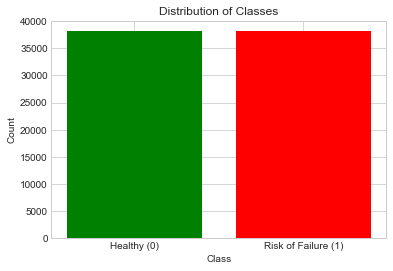

In [44]:
# Display new class count - with synthethic data
class_distribution(synthethic_data)

In [45]:
# Splitting intro train and test data
Xsynth_train, Xsynth_test, ysynth_train, ysynth_test = train_test_split(synthethic_data.drop(columns=['label']), 
                                                                        synthethic_data['label'], 
                                                                        test_size=0.2, 
                                                                        random_state=123)

<hr style="border:1px solid black"> </hr>

## Modeling

In [46]:
# Instantiating logistic regression, decision tree, random forest, and xgboost models
logreg = LogisticRegression(random_state=123) # Logistic Regression 
dtc = DecisionTreeClassifier(random_state=123) # Decision Tree
rfc = RandomForestClassifier(random_state=123) # Random Forest
xgb = XGBClassifier(objective='binary:logistic', n_estimators=10, eval_metric='logloss') # XGBoost

In [47]:
# Neural Network
def neural_network():
    neural_network = Sequential([
        Dense(14, input_dim=13, activation='relu', name="Input_Layer"),
        Dense(8, activation='relu', name="Hidden_Layer_1"),
        Dense(1, activation='softmax', name="Output_Layer"),
    ], name="neural_network")

    neural_network.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return neural_network

print(neural_network().summary())

Model: "neural_network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (Dense)          (None, 14)                196       
_________________________________________________________________
Hidden_Layer_1 (Dense)       (None, 8)                 120       
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 9         
Total params: 325
Trainable params: 325
Non-trainable params: 0
_________________________________________________________________
None


### Part I - Imbalance vs Balance

#### Data Imbalance

In [48]:
# Logistic Regression
logregfit = logreg.fit(X_train, y_train)
logpred = logregfit.predict(X_test)
_, fp_logreg, fn_logreg, _ = confusion_matrix(y_test, logpred).ravel()
accuracy_logreg = accuracy_score(y_test, logpred)
precision_logreg = precision_score(y_test, logpred)

In [50]:
# Decision Tree
dtcfit = dtc.fit(X_train, y_train)
dtcpred = dtcfit.predict(X_test)
_, fp_dtc, fn_dtc, _ = confusion_matrix(y_test, dtcpred).ravel()
accuracy_dtc = accuracy_score(y_test, dtcpred)
precision_dtc = precision_score(y_test, dtcpred)

In [52]:
# Random Forest
rfcfit = rfc.fit(X_train, y_train)
rfcpred = rfcfit.predict(X_test)
_, fp_rfc, fn_rfc, _ = confusion_matrix(y_test, rfcpred).ravel()
accuracy_rfc = accuracy_score(y_test, rfcpred)
precision_rfc = precision_score(y_test, rfcpred)

In [54]:
# XGBoost
xgbfit = xgb.fit(X_train, y_train)
xgbpred = xgbfit.predict(X_test)
_, fp_xgb, fn_xgb, _ = confusion_matrix(y_test, xgbpred).ravel()
accuracy_xgb = accuracy_score(y_test, xgbpred)
precision_xgb = precision_score(y_test, xgbpred)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [56]:
# Neural Network
nn = neural_network()
nn.fit(X_train, y_train, epochs = 30)
nn_pred = nn.predict(X_test)
_, fp_nn, fn_nn, _ = confusion_matrix(y_test, nn_pred).ravel()
accuracy_nn = accuracy_score(y_test, nn_pred)
precision_nn = precision_score(y_test, nn_pred)

Epoch 1/30
1033/1033 [==============================] - 4s 3ms/step - loss: 0.3465 - accuracy: 0.0763
Epoch 2/30
1033/1033 [==============================] - 3s 3ms/step - loss: 0.1883 - accuracy: 0.0774: 0s - loss: 0.1882 - 
Epoch 3/30
1033/1033 [==============================] - 3s 3ms/step - loss: 0.1869 - accuracy: 0.0783
Epoch 4/30
1033/1033 [==============================] - 3s 3ms/step - loss: 0.1820 - accuracy: 0.0791
Epoch 5/30
1033/1033 [==============================] - 3s 3ms/step - loss: 0.1815 - accuracy: 0.0776: 0s - l - ETA: 0s - loss: 0.1818 - ac
Epoch 6/30
1033/1033 [==============================] - 3s 3ms/step - loss: 0.1761 - accuracy: 0.0800: 0s - loss: 0.1761 - accuracy: 0.08
Epoch 7/30
1033/1033 [==============================] - 3s 3ms/step - loss: 0.1732 - accuracy: 0.0771
Epoch 8/30
1033/1033 [==============================] - 3s 3ms/step - loss: 0.1786 - accuracy: 0.0806
Epoch 9/30
1033/1033 [==============================] - 4s 3ms/step - loss: 0.1718 - acc

#### No Data Imbalance

- Upsampling:

In [57]:
# Logistic Regression
logregbal = logreg.fit(Xbal_train, ybal_train)
logbalpred = logregbal.predict(Xbal_test)
_, fp_logregbal, fn_logregbal, _ = confusion_matrix(ybal_test, logbalpred).ravel()
accuracy_logregbal = accuracy_score(ybal_test, logbalpred)
precision_logregbal = precision_score(ybal_test, logbalpred)

In [59]:
# Decision Tree 
dtcbal = dtc.fit(Xbal_train, ybal_train)
dtcbalpred = dtcbal.predict(Xbal_test)
_, fp_dtcbal, fn_dtcbal, _ = confusion_matrix(ybal_test, dtcbalpred).ravel()
accuracy_dtcbal = accuracy_score(ybal_test, dtcbalpred)
precision_dtcbal = precision_score(ybal_test, dtcbalpred)

In [61]:
# Random Forest
rfcbal = rfc.fit(Xbal_train, ybal_train)
rfcbalpred = rfcbal.predict(Xbal_test)
_, fp_rfcbal, fn_rfcbal, _ = confusion_matrix(ybal_test, rfcbalpred).ravel()
accuracy_rfcbal = accuracy_score(ybal_test, rfcbalpred)
precision_rfcbal = precision_score(ybal_test, rfcbalpred)

In [63]:
# XGBoost
xgbbal = xgb.fit(Xbal_train, ybal_train)
xgbbalpred = xgbbal.predict(Xbal_test)
_, fp_xgbbal, fn_xgbbal, _ = confusion_matrix(ybal_test, xgbbalpred).ravel()
accuracy_xgbbal = accuracy_score(ybal_test, xgbbalpred)
precision_xgbbal = precision_score(ybal_test, xgbbalpred)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [65]:
# Neural Network
nn_bal = neural_network()
nn_bal.fit(Xbal_train, ybal_train, epochs = 30)
nnbal_pred = nn_bal.predict(Xbal_test)
_, fp_nn, fn_nn, _ = confusion_matrix(ybal_test, nnbal_pred).ravel()
accuracy_nn = accuracy_score(ybal_test, nnbal_pred)
precision_nn = precision_score(ybal_test, nnbal_pred)

Epoch 1/30
1906/1906 [==============================] - 6s 3ms/step - loss: 0.5241 - accuracy: 0.4986
Epoch 2/30
1906/1906 [==============================] - 5s 3ms/step - loss: 0.4676 - accuracy: 0.4999
Epoch 3/30
1906/1906 [==============================] - 6s 3ms/step - loss: 0.4588 - accuracy: 0.4982
Epoch 4/30
1906/1906 [==============================] - 5s 3ms/step - loss: 0.4573 - accuracy: 0.4980
Epoch 5/30
1906/1906 [==============================] - 6s 3ms/step - loss: 0.4491 - accuracy: 0.5005
Epoch 6/30
1906/1906 [==============================] - 6s 3ms/step - loss: 0.4522 - accuracy: 0.4999
Epoch 7/30
1906/1906 [==============================] - 5s 3ms/step - loss: 0.4467 - accuracy: 0.5036
Epoch 8/30
1906/1906 [==============================] - 5s 3ms/step - loss: 0.4447 - accuracy: 0.5011
Epoch 9/30
1906/1906 [==============================] - 6s 3ms/step - loss: 0.4418 - accuracy: 0.4948
Epoch 10/30
1906/1906 [==============================] - 5s 3ms/step - loss: 0.448

- Synthethic Data:

In [66]:
# Logistic Regression
logregsynth = logreg.fit(Xsynth_train, ysynth_train)
logsynthpred = logregsynth.predict(Xsynth_test)
_, fp_logregsynth, fn_logregsynth, _ = confusion_matrix(ysynth_test, logsynthpred).ravel()
accuracy_logregsynth = accuracy_score(ysynth_test, logsynthpred)
precision_logregsynth = precision_score(ysynth_test, logsynthpred)

In [68]:
# Decision Tree
dtcsynth = dtc.fit(Xsynth_train, ysynth_train)
dtcsynthpred = dtcsynth.predict(Xsynth_test)
_, fp_dtcsynth, fn_dtcsynth, _ = confusion_matrix(ysynth_test, dtcsynthpred).ravel()
accuracy_dtcsynth = accuracy_score(ysynth_test, dtcsynthpred)
precision_dtcsynth = precision_score(ysynth_test, dtcsynthpred)

In [70]:
# Random Forest
rfcsynth = rfc.fit(Xsynth_train, ysynth_train)
rfcsynthpred = rfcsynth.predict(Xsynth_test)
_, fp_rfcsynth, fn_rfcsynth, _ = confusion_matrix(ysynth_test, rfcsynthpred).ravel()
accuracy_rfcsynth = accuracy_score(ysynth_test, rfcsynthpred)
precision_rfcsynth = precision_score(ysynth_test, rfcsynthpred)

In [72]:
# XGBoost
xgbsynth = xgb.fit(Xsynth_train, ysynth_train)
xgbsynthpred = xgbsynth.predict(Xsynth_test)
_, fp_xgbsynth, fn_xgbsynth, _ = confusion_matrix(ysynth_test, xgbsynthpred).ravel()
accuracy_xgbsynth = accuracy_score(ysynth_test, xgbsynthpred)
precision_xgbsynth = precision_score(ysynth_test, xgbsynthpred)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [74]:
# Neural Network
nn_synth = neural_network()
nn_synth.fit(Xsynth_train, ysynth_train, epochs = 30)
nnsynth_pred = nn_bal.predict(Xsynth_test)
_, fp_nn, fn_nn, _ = confusion_matrix(ysynth_test, nnsynth_pred).ravel()
accuracy_nn = accuracy_score(ysynth_test, nnsynth_pred)
precision_nn = precision_score(ysynth_test, nnsynth_pred)

Epoch 1/30
1907/1907 [==============================] - 4s 2ms/step - loss: 0.2433 - accuracy: 0.5003
Epoch 2/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.1427 - accuracy: 0.5025
Epoch 3/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.1347 - accuracy: 0.5001
Epoch 4/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.1325 - accuracy: 0.5001: 0s - loss: 0.1324 - ac
Epoch 5/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.1326 - accuracy: 0.5033
Epoch 6/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.1323 - accuracy: 0.5026
Epoch 7/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.1272 - accuracy: 0.4999
Epoch 8/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.1259 - accuracy: 0.5015
Epoch 9/30
1907/1907 [==============================] - 3s 2ms/step - loss: 0.1255 - accuracy: 0.5016
Epoch 10/30
1907/1907 [==============================] - 3

### Part II - Best Model & Tuning